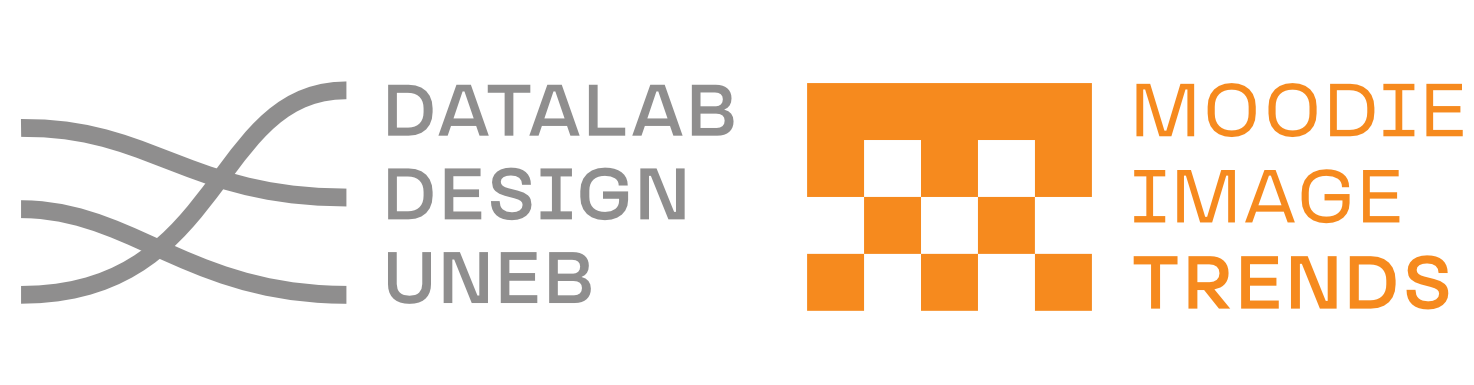

desenvolvido por [Elias Bitencourt](https://eliasbitencourt.com) | [Datalab Design](https://datalabdesign.org) - UNEB BAHIA BRASIL

##MOODIE IMAGE TRENDS  ·  Módulo de exploração e análise de tendências com visão computacional e linguagem natural (versão light)

MOODIE IMAGE TRENDS é o módulo para exploração de padrões cromáticos e análise de tendências do [`MOODIE`](https://github.com/datalabdesign/moodie), Desenvolvido para permitir a experimentação com ferramentas de visão computacional e algoritmos de recomendação customizáveis aplicadas a etapas de projetos em design ou como ponto de partida para pesquisas com visualidades.

A motivação original da ferramenta foi proporcionar um espaço experimental para ensino e experimentação crítica de modelos de visão computacional e suas aplicações em pesquisas e projetos. A ideia, portanto, é que o(a) usuário(a) possa não só aplicar os recursos disponíveis, mas ter a oportunidade de comparar modelos e examinar criticamente os resultados para entender como as arquiteturas e protocolos implícitos carregam viéses específicos e de que maneira eles impactam na tarefa que você está querendo realizar.

MOODIE ainda é experimental e está em desenvolvimento. Portanto, é bem provável que vc se depare com alguns erros e inconsistências. :))

Há uma versão ainda mais completa e com módulos mais voltados à audutoria de modelos e outros tipos de clusterização, a MOODIE VISION CRITICS. Mas essa versão ainda está restrita às pesquisas internas do datalab. Se você tiver interesse em testar em algum projeto acadêmico, entre em contato conosco.

* *Para detalhes sobre a licença de uso veja [`LICENSE.txt`](https://github.com/datalabdesign/moodie/blob/main/LICENCE.txt).*

* **Como citar (formato APA):** Bitencourt, E. (2025). *MOODIE: Modular Observational & Operational Design Image Explorer Light* (Versão beta) [Repositório GitHub]. Datalab/Design – Universidade do Estado da Bahia. https://github.com/datalabdesign/moodie

In [ ]:
# @title #Verificar necessidade de GPU
# 17-jun-2025
#@markdown > Se você não está familiarizado com Google Colab GPU e outras coisas do tipo, responde rapidinho a perguntinha abaixo.<br>O MOODIE vai te dar uma ideia se você está no caminho certo ou se precisa mudar alguma coisinha :)

import subprocess, textwrap, ipywidgets as w
from IPython.display import display, clear_output

#  helpers
def gpu_available() -> bool:
    try:
        subprocess.check_output(["nvidia-smi", "-L"], stderr=subprocess.DEVNULL)
        return True
    except Exception:
        return False

def gpu_name() -> str:
    if not gpu_available():
        return "CPU"
    out = subprocess.check_output(["nvidia-smi",
                                   "--query-gpu=name",
                                   "--format=csv,noheader"], text=True)
    return out.strip()

def plan_hint(model: str) -> str:
    m = model.upper()
    if any(tok in m for tok in ("A100", "H100")):
        return "Pro +"
    if any(tok in m for tok in ("V100", "P100")):
        return "Pro"
    if any(tok in m for tok in ("T4", "K80")):
        return "Free"
    return "Indefinido"

def show_instr_for_gpu():
    msg = textwrap.dedent("""
    OPS! Tarefas de visão computacional e machine learning geralmente funcionam melhor com uma GPU ativa.
    No momento, parece que vc não está conectado a uma GPU. Se você tem tempo e sua base de dados é pequena,
    talvez isso não seja um problema. Mas se você está com pressa ou sua base passa de 100 imagens, talvez seja
    melhor você ativar a GPU no seu colab.

    Como ativar sua GPU:
    1. No menu superior, selecione Runtime ▸ Change runtime type
       (ou no canto superior esquerdo, próximo ao check box verde, selecione o menu dropdown ▸ Alterar tipo de ambiente).
    2. Escolha GPU em Hardware accelerator.
       Se você tem um plano Colab Pro ou Pro + você pode optar por L4 GPU ou A100 GPU
       Se a sua conta google colab é free, selecione T4 + RAM
    3. Clique em Save.
       O Colab reiniciará automaticamente.

    Depois do reinício, siga para o próximo módulo de instalação de dependências
    """).strip()
    print(msg)

#  UI
question = w.HTML(
    "<b>Sua bse de dados é muito grande? Algo com mais de Mil imagens, por exemplo?</b>"
)

btn_yes = w.Button(description="SIM", button_style="success")
btn_no  = w.Button(description="NÃO", button_style="warning")
out     = w.Output()

def handler(need_gpu: bool):
    clear_output(wait=True)
    display(question, w.HBox([btn_yes, btn_no]), out)
    out.clear_output()
    with out:
        if need_gpu:
            if gpu_available():
                model = gpu_name()
                print(f"Uhuu! GPU ativa: {model}  ({plan_hint(model)})")
                print("Vamos voar! Ambiente pronto — siga para a célula de instalação.")
            else:
                show_instr_for_gpu()
        else:
            msg = "Ok, vamos de modo light! Tudo suave na nave..."
            msg += "Opa, mas temos GPU detectada, tá?" if gpu_available() else "Opa, mas temos GPU detectada, tá?"
            print(msg + " Siga para a célula de instalação.")

btn_yes.on_click(lambda _: handler(True))
btn_no .on_click(lambda _: handler(False))

display(question, w.HBox([btn_yes, btn_no]), out)


In [ ]:
# @title #01 Instalando dependências do MOODIE
# 1 jun 2025 — otimizado: downloads em lote, sem repetições, preload leve
#@markdown > Antes de começar, o MOODIE precisa instalar umas bibliotecas e preparar tudo para que sua experiência seja mais suave.<br> Aperta o botão e deixa que ele cuida de tudo pra você!

# imports leves
import os, sys, subprocess, importlib.util, contextlib, logging, io, re, base64, logging
from datetime import datetime
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
from PIL import Image


os.environ.update({
    "TF_CPP_MIN_LOG_LEVEL"        : "3",
    "TRANSFORMERS_VERBOSITY"      : "error",
    "HF_HUB_DISABLE_PROGRESS_BARS": "1",
    "NO_ALBUMENTATIONS_UPDATE"    : "1",
    "PIP_PROGRESS_BAR"            : "off"
})
for _log in ("tensorflow", "transformers", "huggingface_hub"):
    logging.getLogger(_log).setLevel(logging.ERROR)


LOGO_BASE64 = """
iVBORw0KGgoAAAANSUhEUgAABcIAAAGBCAYAAABFDcIFAAABe2lDQ1BJQ0MgUHJvZmlsZQAAeJx1kc9LQkEQxz9qYpRhUIeCDhLVyaIMpC5BSlggEWbQr4s+fRqoPd4zQroGXYWCqEu/DvUX1DXoHARFEUTnuhZ1qXjN08CInGV2PvvdnWF3FuyxrJIz6vohly/o0XDQOzs373U9U48TN+20xhVDG52ailDT3m+xWfG616pV+9y/1phMGQrY6oVHFE0vCI8LR1YLmsVbwq1KJp4UPhH26XJB4RtLT1T4yeJ0hT8t1mPRENibhb3pX5z4xUpGzwnLy+nKZVeUn/tYL3Gn8jPTEjvFOzCIEiaIlwnGCBFggGGZA/Tip09W1MjvL+dPsiy5iswaRXSWSJOhgE/UFamekqiKnpKRpWj1/29fDXXQX6nuDoLz0TRfu8G1CV8l0/w4MM2vQ3A8wHm+mr+8D0NvopeqWtceeNbh9KKqJbbhbAPa7rW4Hi9LDnG7qsLLMTTNQcsVNCxUevazz9EdxNbkqy5hZxd65Lxn8RsYfWfC/VnpzwAAloVJREFUeJzs3Xe4JEX1//H3LrnJOTeKgAQRTGAiKUqSoGQQRAxgtktt00/FrP3VKgMGTEiUpOQkkkEkI0GQJDQ55ybtsr8/qi9clpmentDdM3M/r+fpZ8PUVJ177+69M6dPnQIRERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERqdy0pgMQERk1ztppwLzAgsACk35t9/uTImMuaiZaERERERERERGZs+kARESGkbN2UWA14LX5rxPXq/AJ7uldTHcHoES4iIiIiIiIiEhDlAgXkSnLWTs3L09yT058L9FgaCIiIlNSloTXAcs0HYeITAn3B3G6RtNBdCNLwmXp7X3KzUGcPj3oeDrJknB5YLEennpTEKfPDDqeTrIkXAZYB1i+xbUM8ARwN3BX/uvE9T/g8iBOX6g75n5lSfhqYE1af8xLAg/T+mO+EbguiNNZDcS8BoPNZz4L3B3E6ZMDnLMrWRKuACza0PJ3B3H6UNnBDcf6CkGcXtPNeCXCRWTKcNbOAbwBeFd+bQAEjQY1RJy16wHzDXDKF4D7gLsiY54a4Ly1cNauCizXw1Ofj4z5Z59rL4J/ET4K/hMZ80A/Ezhr16a3N0lPRsZc3s/aZTlr5wHe2mHYfZExN9QRT12ctesAi/Tw1MciY64abDStOWsD4C0VL/ME8AjwKP5jG7k3uiNkEXr7fiAi0q3nmw6gBwb4Yg/P+zDw58GGUsoRwDt7eN6awPUDjqWlLAkDYDtgT+A9FO/8XRZfNNXKnVkSHg4cFsTp1QMNcsCyJFwM2An/Mb+tw/Bl8F+PVm7IkvAw/Mf8vwGG2MlZVHDTPEvCx/EJ/8nXFcDJNdyY+S6wV8VrtLMvcEAX478FfLSiWLr1AjBHN09QIlxExlbey3stXkp8bwws3GRMQ+4wYJUqJnbWPs5L1QN3ATcDRw150vBI/I2TrjlrV4mMuaWPtdcBzunj+XXaHvhbr0921s4J/ANYqoenP+OsXToy5vFe1+/CknT+mhxEcy9gB85ZOy9wLr1933wi/9rUUX22IvX+f3nCWXsZ8C/gTOBsJcZFRGTIbUPNifAsCRcH3l7nmmVlSTgd2BCfCN4Rf65Tv1YAYiDOkvBa4FDg0CBO7xrA3H3LknAuYAv8x7w1MPcApl0dn8D9bpaE/8S/nzwiiNOHBzB3ExbKr9l3ijyaJeERwMHAv5qogpfBUSJcRMaKs3YV4N3AJvjk95LNRiS5iRcVq0/6u287ay/Hv0g8IjLm3kYia8FZuwY9JsFzuwLfG1A44+7d9JYEB39o7Xb4F6UyeFvQ+83DBYEtgb8OLpyhsSD+Z8wmwFeBm5y1vwZ+P4q7X0REZErYLEvCeWtuN7Il3Z2rVIu8/cnB+OrvqrwO+BHwzSwJPwv8qcnkaZaEq+Or86vccfr2/PpWloR7BXF6aoVr1W0RfNX0vsCNWRIeDPy2m3YiMjyG7puSiEi3nLWLO2s/7ay9FLgJ+C2wM0qCj4I3AQ64y1l7mrN2y6YDyu3W5/N3z3ckSGe79/n8fr9W0p6+NuWsiv8+dpWzttP2YhERkSYE+CKhOm1d83odZUm4BXA11SbBJwuAPwBH5+1IapUl4bQsCT8CXE59bReXAk7JkvDnWRLOW9OadVoNX/D07ywJN2w6GOmeEuEiMpKctXM5a7dx1v4NuAf4JfDmhsOS3k0HNgNOdtb+xlk7yF7lXckT2P0m8FZndHp8Nybv7fz+PqfZ1Fm79CDikZc4axcG3tfnNFvl/e6nilWAC5y1n2s6EBERkRZqS0xnSTg3sHld63WSJeE8WRJa4BSaKZbaHp843biuBbMkXARfBf4HmjkX67PAJVkSrtXA2nVYHjg7S8JvZknYVY9qaZYS4SIyUpy16zprf4bvM308Pok2V6NByaDtC1yaH6DYhPWBlQcwz1Sphu3H1vTfk3EOfG9HGawPAPP0Occ89H+jY9RMB37mrN276UBERGTK+RnwBeC2No9vkyVhXTsWN8S3EmvlKHycF9URSJaECwMXAlGXT30BX3B1HXAecAJwBv7wxNuBbs9BWQE4K0vCj3X5vK5lSfhq4Cr8gZjdmIF/n301cDb+/fZZwL+BO+n+gNm1gcuyJHxvl88bFdOBbwP/yJJwuaaDkXLUI1xEhl5e7bk78CHg9Q2HI/VYC58M/wLw68iYOnvq9dsOYsKuztqv6BC9QgP7XAP7D2gu8Qb5tTlwQHONkt87a2+KjDm/6UBERGTKODSI08uzJFwK+HKLx5cD3ohvk1G1ourzbwRxemOWhKsAlbYUyxP/f8S3Yyzj38Dp+EO4LwzitO2B7HkV8LrAxvi2M5vhCzSKTAP2z5LwyiBOLysZU1eyJJwHOBpYqeRTLsAfXH8ucHEQp20T/Pnc6+E/5k3xNzw6mRc4LEvCNwRxemfJmHp1O76Yoxtz4HuALwYsDiyL/3f5DnzsZWwMXJUl4VuDOL21y/UnfBu/y72sjwCfbPPYJ4BLupjrji7GdrLdgOcbOCXCRWRoOWtXAr4C7M1gTrWW0TIPPrm5GP408so5a+fC95cvcjq+GmRDYJuCcSsA78RXkMhsnLWL4w9jLHIEcBmwLbBBwbi3O2tfHRnzv0HFN5U5a5ejcx/Rg/HVQjvid1G0825n7TLDdBhuTaYDzlm7nm6GiYhIzU6kdSIc/GvXShPhefK5XSL8xiBOb6xy/dl8Gt+WpJOzgB8AZ5U91DKI05n4z+XlwE+zJHwVEOPfuxbtqpsb3zP8jUGcPlJmrS79hM6J/1n4A81/GMTpFWUnDuL0WeD8/PpuloTrAF/Dvx4s2m2wBHBEloSbBHHabVV5N57u5uMpkif93wLsAexF53zEksCRWRK+I4jT57pdL4jT22i/m6NVfEXvo24a1OehB9cGcXpLQ2uXokS4iAwdZ+3KwFfxP3D0fWp4zAD+W3LsNHzLi8Xov/XFfs7a8yNjzulznjLeTee+gd+OjLnIWft3ihPh4Nuj9JIIfwz/ArMfS+MPcylyI3Bfn+v0elr6DnT+//2lyJg7nbX/pTgRDrAL8MMeY5GX24XiNzMzgS9ExjzorL0Tf8Oinen4bbm/GGB8vTgL+HsPz5uG/z62MvBqYA2g7BkGb8LfWPtLD+uKiIj06l/Ag/jk4+y2Ab5V8fpr4n9mtnJixWu/KEvCtwA/7TDsYWD3IE5P63e9PJH5ySwJfwAcCby9YPirgAOzJHx/2cR7GVkS7ohP/hf5H7DDIBKlQZz+G9g5S8LvA8fgDxBv5x3A9/E3C4ZenvS/ALggS8LvAF/EV2AXJcTfDPwIMNVHKL1SgklEhoazdjX8HeUP0nlbmdTvrsiY13X7JGft3PitmG/HV1FvCrymiymmA39x1q4bGdNv0raTTu0g7gAuzn9/LfAf/Iv9dnZ01n42MqarqoDImKsot9WwLWftnsBBHYZ9PzLm4H7W6UOnz/WFkTET2yf/DjyK37bYzm4oET4onfrbnxkZ82D++5OAjOJDmHaj+UT4hZExP+53EmftEvidSp+i3HbZXVEiXEREahTE6cwsCU/CFxXNbt0sCcMgTtMKQyhqi1JLIjxLwkXxvciLzpK6CvhAEKcD3VEYxOmdWRJugu/Z/omCodvi+5bbQaybt5r5Y4dhpwO7BXH68CDWnBDE6dVZEq4HHELxYetfypLw/CBOa7shMghBnN4FRFkSHgH8Df/etp0oS8Jzgjg9oZ7opFs6LFNEGuesXdNZexhwPb4PuJLgYyQy5rnImNsiYw6PjNkXX6W8Dd0dkLMMcIiztrKfW87a+el8sN/RE20O8r7lRZWw4CtJx/VwmJ7lbY86VXgfNfGb/EbCXzuMf12DB6yODWfta+m8nXby1+Yp/OFRRdZ31nZz82toRcY8GBnzRfwNsAc7jce3hinbX1JERGRQin42FyUqB6FdIvwR/KGVdfgGvuq6nWuADQadBJ8QxOlzQZx+Euh0E/77+WGeg/Az2h9QCnAKsNWgk+ATgjh9FJ/c7/Sa/edZEo5kLjKI04vxr5M7/Tv+c5aEYQ0hSQ9G8h+fiIwHZ+3aztoj8ZW1u6HvSVNCZMwLkTEn4rfH7Qw8VfKp78FXYlZla2D+DmOO7PDnVjpV105Fu3R4fBZ+e+Vk+lzXo1Ol/gzg2Nn+rszXZtfewhlOeT/6vUoMDfD9JUVEROp0BvBsm8c6tfbrWZaES9L+AMxTgzidUdXak2KYG9/XuZ1HgfcHcfpk1bEAX6e4Ndu8+BZyfcmScDmKz965Bfhg3te8MkGcvgB8GL9rtp1X07kgZmgFcXovsCVwQ8GwRanpjCvpnpJOIlI7Z+2iztrf4E/l3oniXrQypiJjZkXGHIU/efymkk/7UoXVlZ0SgLcDl07+i8iYG4ErOzxv27zaXF7S6XN9fmTM3bP93dnAAx2et2uVuwbGnbN2Gp1vJpwRGTN7JdFpwOMdnrd7Pv/YiIw5Gb89tpNlq45FRERksjzJe1abh9+VJeFCFS29Je3f29XVDmMrWvdHn7B3XYf55YnnXYHZX9dO9uEBLLUH7fN7LwDbV3Qw5ysEcfoEfpdtuxsxMJiPuTFBnD4ObAc8UTBs+ywJ+z0rSyqgN4siUhtn7TRn7R74u6f7ogS4AJEx/8EfUtkpyQm+R/TAq1jyvr+bdxh2VN4OZXad2qMEVFh5M2ry9iWdWpgcNftfRMbMAI7u8LyVaF+FJJ2tR+f+/a2+Ns/wyirx2a0OrNNjXMPskhJjlqo8ChERkVdq1x5lLqpr3deuLcoM/I3zOhQlWS8HjqspDgDyViRFLVLeliXha3udP0vCaRR/zEfmh1rWJojTG4E/FAzZYdSTxEGc/hef02hnfmD7msKRLigRLiK1cNauga9KOBglBWQ2kTF34HcHlNmut1cFIexI5wOkX5EA7PD3k6llx0s6VYO/QPvegmqPUq1OX5vngePbPDZVvzZXlxhTVdWdiIhIkZMKHht4kUaWhPMAm7V5+Py8h3SlsiRcBl+V3s4PgjhtVdhStT9QXPSzVx9zvxUoSqT/qI+5+5Hgb4C0Mj/+/deoO4LiNjAfqisQKU+JcBGplLM2cNb+AN8GZeOGwxmEZ/E9zc/Ab4k/GPgV/i7/N4DPAx/F977eCtiIclvnp7zImHOAn5cYupmztuik7l50StDdiq8geYXImNuAf3V4/ubO2sV7iGus5G1LOvWKPjcy5t42j11A8dZSgJ2ctXN1HdwU56ydE/99q8jpkTHtttX+A+h0+NI4tq4pc2Bmp3+zIiIiAxfE6Z20ef0KbJUlYacikG5tBLSr8q2rLcoHgTnaPHY7NVeDTwjiNAN+XTBkzz4OkCyqBj8ziNMyN+0HLojTlOLdnHvVFEpl8p7oPygYskmWhK+qKRwpadDf+EREXuSs3QrYn+ITu4fRLOA24MbZrv8Cd0TGvNBcaGPvJ8CngHkKxkzHv8hNBrGgs3Yl4J0dhrVrizLhCHw1RjtzAjsAB3QZ3rh5B9DpBPW2FfaRMS/kB+xGBc9fAtgUOLX78Ka0d9N5t07R1+Z5Z+0xwMcLnr8C/v/aed2HN7TKbGW+vfIoREREWjsBeFOLv18M307u/AGu1a4tCtSXCH9HwWNn5onLppwOfKvNY8sBSwP39DBv0cd8Rg/zDdLptC+CeVOWhNMaqtAfpCPx70vbFWrtCXynvnCkEyXCRWTgnLUrAL/AH5IxCq7Ft205H7geuCXveSs1i4y5x1l7IMX91sC3cBhIIpxy7Ro6tT85GnAU973fDSXCy7RF6bSDolMiHPznWonw7nT62jxH+16jE46kOBEO/mszTonwNUuMUSJcRESacgLw7TaPbcOAEuF5n+p2ifAbgji9eRDrlLBCwWPn1hRDO5cBGf78oFZWoLdE+DB/zEXrz49vH/dYTbFUIojTGVkSnok/sLQVnV80ZMZte6qINMxZux2+Z+owJ8FvBn4H7AIsExmzdmTM5yJjjomMuU5J8Ma16w892WudtYM6bLVTIvxm4KqiAZExd9M5ubehs3bFLuIaK87auencC/DsyJj7O4y5BL9jo8j7nbXt3mTIbPLPVafv2adFxnR6o3IucF+HMTvm/xZGXt5OpqgPKfjWKXfUEI6IiEgr/6b9z6FB9gl/Hf7Q8lbqqgYHWL7gsUZvxAdx+jxwYcGQothbypJwIdqfRfI07Vvj1CKI09soLgjo+mMeUmcXPDYuH+PYUCJcRAbCWTuvs/YXwLHAok3HM5t78b289wJWioxZNTJmn8iYIyNjOiVtpH4X4Q/lKzIP0HfPbWft6/Ev3Isc2aEtyoQjSozZpcSYcbUZfhtukY4HLuZfi06f6/kp3p4rL7c17Xt6TijztZlJ590TiwHvLRnXsPsSsE6HMb+JjOn0/UxERKQSeduJdono1bIkLNPiq4zG26JkSTgXsEybh18A0jri6ODWgseKKrvbKUqypnnyvWmD/piH0TkFj43Lxzg2lAgXkb45a1fDJy8/03QskzwD/AXYHFghMuZDkTEHRcYMwwsgKRAZ8xRwaYmhg7i73qkdBHRO7E34KzCzw5gybVjGVafP9Uz8jbQyOiZlmdqf6251+to8S/k3sVPia+Os3RbYr8Ow5yk+GEtERKQORa3NBlUV3i4R/jD+fWIdlqV9m8JHGu4PPuGhgsd6SZgWPafTIeZ1GfTHPIxuA2a0eWzRLAnnqzEW6UCJcBHpi7P2g8AVwLoNhzLhAuBj+JYnu0XGnJ5XKcpouaXEmL5eODlrp9P+8JYJ/wWuKTNfZMwDwJkdhq3rrC3TU3isOGsXpPMbrTMjYx4sOeW/8V+bIls4aztVoE95ztrFgS06DDslMuaJklNeROdWINs6aztVoA8dZ+0cztrXO2tPAo4DOrV42T8y5t7qIxMRESl0DvBkm8f6ToRnSbgUsH6bh08J4rRdgnDQit4bFCVj61QURy9FPqPwMRcl5MeibUi+82LsP85xocMyRaQneRJjf+BDTceC7zt2MHBwZExdB7FItcq8cOu3guCdQKee3UeVbIsy4Qg6t33YFfhGF3OOg+2ATpUQZSvviYyZ5aw9AvhWwbC5gO2B35edd4rakc6vB7v52rzgrD0S+GLBsAD/xvvwsvMOwG7O2jf38fwlgbXo/O94wlH41ikiIiKNCuL02SwJTwN2aPHw27MkXCKI07LFCK1sRftK7Dr7gy9X8NijdQXRQVGytCj+Xp7zaA/zVWHQH/OweghYqs1jy+PPnZoKLsuSsK5CxDiI0z91+yQlwkWka3lf5aOAQfWU69WZwA/xB+wNw1Y3GZw6EuFl2qKUafMw2XHAAfgkbDu7OWu/2WWCfdR1+lzPoHxblAlHUpwIB9+CQ4nwYp3alDwNnNTlnJ0S4RPr1pkIf01+1eFUYA/tRhIRkSFyAq0T4dPxBz8f3Mfc7dqizABO72PebhXt1BqGXtnQvn0GFL9/aGcqfszDaiq0gCljkRrXmreXJ6k1ioh0xVm7N3AJzSbBTwPeERmzaWTMmUqCj6XHS4xpd8e9I2ft3PhK2CL/iYy5rpt5I2Mewf/7LLIysF43844yZ+3SwKYdhp0RGdNVH8PImOuBqzsM28hZO5VeeHbFWbsSsEGHYSdHxrTbTt3O5XRub7SZs3aJLucddrfid3y8LzLmuaaDERERmeQU/IGRrfTcHiVLwnlpvxvy3CBOH+t1bpER82zBYz0lbKUaSoSLSCnO2unO2h8CfwTmaSiMk4D1I2O2iIz5Z0MxSD3K3NxotwWzjM2BRTuMKd0OYjZHlBgz8ocFdmEnYI4OY6r6XE8Ddu5x7qmgU4986OFrk+926PS1mZPWlWmj6jhgzciYI3RzVkREhk0Qpw8BF7Z5ePM8od2LjYH52zxWZ1sUEZFSlAgXkY6ctfPhkxpfaSiE44A3RcZsHRlzSUMxyHgp0xal1+TsicAzHcbs7KydKu3JOn2unweO73HuMq1rptJNh251+txk+AqyXky1r812wLXO2q86a3UgkoiIDKMT2vz9/PiEdi/atUUBJcJFZAgpES4ihZy1SwFn0bmNRBVOAdaJjHl/ZMwVDawvY8hZuxCdt4Bek7fe6FpkzBN07qm8NLBJL/OPEmftKsD6HYadnreU6VpkzK3ApR2GvdFZu3ov848zZ+3awNodhp0YGfNUj0tcC/ynw5gNnLVhj/MPo1WAHwCps/bXztpx6nspIiKjr10iHIoT2i1lSTit4Hn/CeL01m7nFBGp2lSpRhORHjhr1wBOBl5d89J3Ap8FjptiBwrKS8psz+w1Qbddifl7rQafcASd2z7sBpzR5zrDrpLWG7M5AnhLiTg6Haw51VS5K4LImFnO2iOA73QYuguQ9LrOkJoOfAJ4jbN2x8iYMmceiIiIVCqI0xuzJPwvrc962iZLwk8HcdrNe6/XAyu2eUzV4DLVFBVATKWzY34EPFjTWj21y1UiXERacta+C/gbsHCNy84EHPDtHg5nk/GyeIkxd/Y4d5kE4NE9zj3hFOBJYIGCMds7az8ZGfN0n2sNJWftNDp/rp+juDqpjKOBn3YYs5uzdj/dWPOctdPp3JbkKeDUPpc6ks6J8N2oJxF+LXBVH89fEFgpvzqdLzDhvcAFztpNI2Pu72NtERGRQTkB+FKLv18BWBe4sou5hq0tysyCx/o5W2iQinJwM3qYbyp+zMOq6P3rXbVF0bw/BHF6S9NBFFEiXERewVn7YeB31Ps94kLgE5Ex19S4pgyvShLhztplgE07DPt3ZMx/u517ssiYp521x1OcCF4Q2BL4az9rDbE30rriaLLTImMe62eRyJg7nLUXAO8sGLYK8GY6t1GZKt5B+wquCSf0e5MmMuZGZ+2VwBsKhq3jrF0rMua6ftYq4djImG8OYiJn7SLAXsCXgWU6DF8b+Da+QlxERKRpJ9I6EQ6+deAgEuEPAv/qJqgBubfgsQVri6JY0c30u3uYbyp+zMNKifARoR7hIvIiZ+00Z+33gD9RXxL8IeAjwIZKgsskS5UY08sLip3o/LOvzCF/ZUy1wwJnV+Zj0+e6GWV2RdT5tSnTQmdoRMY8GhnzM2Bl4CclnvJRZ+1rqo1KRESklIvw779a6XSGzouyJFwGWK/Nw6cEcVpUqVyVovcGS9YWRbHFCh7rZbdr0XOW6GG+Kgz6Yx46eb98JcJHhBLhIgK8uFX+F8DXa1z2EGD1yJg/Rca8UOO6MsTylhpvLTG0lxdOdbRFmfB34NEOY7bKq0vHirN2DjonN59lcNtmjwE6fQ/ZJY9rSnPWzk3nw4+fAE4f0JKlblLk/+9HSl4x/2U6f67mBParPCAREZEOgjidgT8DqpU3Zkm4Qsmptip4rKn+4EXJxiXyZGXT6kyEj2vyfxgtR/se4Y8Fcaq2r0NEiXARmUiC/wb4dE1LPgXsERmzZ2RMXQcpyOh4LbB0iXFdbaVz1q5K+8qVCVdExtzczbztRMY8i++zX2Qe4P2DWG/IbAws22HMKZExTwxisciYe4GzOwxbJo9rqtuM4jckAMdHxjwziMUiY26j8/boVwPrD2K9uuU3cfcEOrX42TW/CSEiItK0ovNZ3ldyjnZtUZ7HF4PULojTp2lf7T4nsHyN4bSzUsFjvSSFi5L/K2ZJOAxFIIP+mIfRxgWPqRp8yKhHuMgUl1dI/gHf77QOVwK7RMbcWNN6Mno69fAGuC8yptvTt8u0X5jurHVdzlukTFXNbsCBA1xzGJRpQ7L4gD/XQYkxuwFnDnDNUVRmV8SyA/7alHm9uRvN9BPtW2TM/c7aS4D3FAybA3gVoJ99IiLStL/jDyxvdYN2G+C3RU/OknA+2v/MOyeI08f7C68vd9G+RcUGwF9qjOVl8qT0OwqG9JIUfhh4Bpi3xWMLAusAV/Qw70BkSbgs/qyedpQIl9oNPBHurF0QXxXzPP6b63OTft/q77p5fOL3j+APBXjxiozRVgORLjlr5wQOor7eub8EvpRXyoq8Qn5j5rMlhp7W5bzTKJcAXDe/6vQuZ+2ykTH31LxuJZy18wI7lBi6YX7VaXtn7Sen6veg/DVamf6f786vOu3srDWRMTNqXndQrqE4EQ7+jaAS4SIi0qggTp/IkvAsYPMWD787S8IFOrRyeBftCxCaaosy4U7g9W0e25gGE+HA64BFCh7vOmEaxOmsLAnvpH2yeWMaTITjbz6082TDN00GIkvC6RS/br68rliknCoqwmcC0/B3F2vbAuqsfYrZkuNtrvt7qCIUGTvO2rmAQ/GHB1btEeDDkTHH17CWjLbtgVVLjPtzl/O+CVit62jqMR3///DnTQcyIFsBCzUdRBsLA1sAxzUcR1PeD8zXdBBtLAVsApzRdCA9ur7EmKKKKBERkTqdSOtE+NzAeylu79euLcrEvE26BtiyzWObZkk4PYjTps6melfBY3cC9/U47zW0f43xHsD2OO8gFH3Ml9YWRbXeh2/z185BdQUi5VSVCG/C/MBr8quQs/YhWifJbwX+A9wSGfN8daGKNMtZOw9wBLBdDctdCOwWGZPWsJaMsLxa9bslht4GnNfl9HXteujVboxPInwUPtfHNR1EQ0bhazOqifClBjRGRESkDicCv2rz2Da0SYTnB0626yN+bRCnt/UfWl8Oxh9k3crK+IKN2pP1WRLOCXyqYMhBfSToD6b9mUObZUm4RhCnZW7YD1SWhIsBHywY8ueaQqlM/v/h/xUMuTiI0xvqikfKqeKwzFHY0ro4sBZ++8LuwBeA/wP+iq/oecpZe42z9khn7bectTs4a9fUIUcyDvK2BX+jniS4AzZWElw6yVuX/JlyVdsH5QfUlZ17DmCXHkOry3rO2pGvFnXWLkL5Q5aasrWzdlgr1ivjrF2azq07mra9s3ZYK9Y7WavEmHYHeImIiNQqiNM78Gc3tbJVwSGLb6D9oZNNV4MTxOl/gEsKhnw9T17WbQeKizb/3MfcJwMPtHlsGvDVPubux6fxBautPIHPv426LYC3FDyuavAhVEVFeFPbTAZpLnz/ptfN9vcznLU34qvG/wNcl/9601TtNyqjJU+CH4/f7lalmcCnI2MKD1oRgReT4N8DPlDyKQd3ucQmwLJdPqcJu1KuIn6YbU+NbdF6NC/+RmC3/45G3c5UUwAxSAvitzOP4hujdv1IJ2v3JlVERKQJJ+AT27NbAngrfmfv7Ia5LcqEPwPrtXlsfXzRRm2xZkk4N/D1giHnB3F6c6/zB3H6fJaEhwGfbzNktywJfxzE6XW9rtGtLAkXBz5XMOSoIE6fqiueKmRJuAJwYMGQ54AjawpHujDwRHhkzCxn7QsM/5utXswJrJlfk8101t7EKxPkN0bGPFNviCKt5QdjHk71SfAngJ0iY7o6zFCmprwy90DKJ8H/ERlza5fLlDkkcxjs7qz9XmTMrKYD6cOofK53Y+olwoe9LcqE3RixRLizdldeWTzRyp1VxyIiItKFE4BvtXlsG7pLhD9AcSV2nY7A70yep83jf86S8M1BnP6vpnh+TvHrhKJkalkH0j4RPgfwtywJ1wvi9LEBrFUo303wF2CxgmGD+JgbkyXhPMAxFLe9Oz6I04drCkm6UEVFOPj2KMNeETZIcwCr59fkZM7zztrLgQvy68LImAcbiE+muLzi9gDa9w4blDuBrSJjrq54HRlxebuS7fEV0GUPsXwU+HiX68yXr9PJY0DVCeiFKL5J/FpgXdpvUx1qztrl8SfTF5mF/1xXbZEOj2/qrF06MqbXQ4lGSt52Z/0Ow4bla7OVs3aRyJhHa4ilb87aEPhNiaEZ8K+KwxEREenGlcBdtG51sg2z9drOknA5/AH0rZwcxGlT58W9TBCnj2RJeCztWyMuhk8MvyOI06zKWLIk3BvYt2DIU8DR/a4TxOnVWRJeAbyxzZDVgIOzJHx/DYeFfp/idnw3Af+sOIbKZEm4IHAIxa+tnwb2qyUg6VpVifCh+AY4BObCbyl6K/BFAGftDUxKjOMP5hzl6j8ZDT8G9q54jSuArSNj7q54HRlR+Q2Z1fEvjD5D+9PN2/lwZEy3lRtb4dstFPl3ZMy6Xc7bNWftn4EPdRi2GyOaCMe/2ejUc/HEyJhtqw7EWXs2xUn5OYAdgf2rjmVIlKkGPyIypvKqcWftJRT3UpwHf9N2qCuFnLXT8f+GfgAsXOIpZ2uXoIiIDJMgTmdlSXgirRO1q2dJuFoQpzdO+ruic2CGpS3KhO/ik/lBm8fXBc7KknD7IE7vGvTieR/yT+Er04t8KYjTJwe07FeB02j/enwb4K9ZEn4oiNPHB7Tmi/IDQX9InvtqYxbwqSBORzIHliXhqsBxvLJLxOw+lferlyGkRHj9JirHP5r/+T5n7URi/ALgqsiYUThwVEaEs/bLwJcqXuYEYLfImJHu8yUdLeis/WjnYS+aF99jcElgBeDt+Z978fPImON6eF6ZVh1H9DBvL46gcyJ8V2ftl7s5DHSIDNvneuMOY3Zj8InwlZy1Zdv8DMLZkTGPFA3Ib0CVSoQPJqRS6xQlwsHHO+hE+JzO2nZbpMuYDiyHr6haDdiT9lVXrahHpIiIDKMTaF+xvDXw09n+3MpzwN8HGVS/gjj9T5aE+1LcCm994PIsCXcK4vS8Qa2dJWEA/BbYo8PQI/NxAxHE6d+zJPw+8P8Khm0HXJxXht8wqLWzJFwS3w7l3R2Gfi+I0zMGtW5d8irwTwBfo3MBxCH0d/ipVKzK1ihSztL4bfsTW/efctb+C18tfgHwr8iYJ5oKTkabs/ZjwI8qXubnwBciY3QDbPwtBvy+gXUvBeJun+SsXRR/8F4ndSWozgQeAhYvGLM8sAFwbi0RDYizdg1aH7Y02dPUVy30V+BX+Mrvdt7mrF25h57zRTamcwJ+kN4MXN5hzBvxbXeKPAacPpCIOjuKl7+pbuVdztplI2PuGeC6X82vJlyLP6NDRERk2JyNb88xf4vHXkyE58ndTdvNMcCq5oEJ4vSQLAk35KUixFaWBs7NW6l8P4jTTq+r2sqScAFgH+ALwLIdht8EfLyCyuj9gHcAmxSMWR24OkvCg4Ef9XNQZ5aES+EPxfw0vg1kkXOAb/e6Vt3yqv5X429ofA5YtMTTbgQ+OaoV71OFKsKHz/z4u2gTd9JecNZeBZyP3+ZyjrbWShnO2h0Y4B3mNvYDvqP2PlKha/GHrz7Xw3O3p/N5FRf30G6lJ5Exzztrj8G/QC6yGyOWCKdcxfGJkTG1vEmKjHnQWXsGsHmHobvgW1uMszKV+n+LjHm28kiAyJg7nbXn42/4tDMd2Al/o3UcfFk3i0VEZBgFcfpMloSn0/rg+ndmSbh4EKcP4fMT87aZZtjaokz2WWA94PUdxr0feH+WhGcBp+CTtld16nueJeHSwEb5tQvFB0ROeBbYqYr2JEGczsyScDfgKnySv525gI8AH86S8ATgDPzHfH2nJG6WhK/Cf7zvwreJm69EaPcBu9XQR37O/GvSjWn4VppL4ncvL4ffybwxsGIX82T4r2tP73eyJFyY9v/HWlmg4LFFu/w8PDHAfvlLZElY942x54I4LdwlO5kS4cNvOr6a6434u1CZs/ZM4CTg5MiYgfezktHnrH0Pvvqs6GC+fn0tMuaHFc4vsj8QR8Y83ePzh6lVx+T1OiXCd3TWfqbH5H/tumi9UXdriCPonAjf3Vn7w3G9mZcfStvuoKjJmvjaFCXCwf+bGodE+H6RMac0HYSIiEiBE2idCJ8D+GqWhJdS3ObjpEqiGoAgTp/OknBH4GI6H9gNPrn7rvz3j2dJeAt+R+dDwCP4nuOL4Xd4LoOvGO7GC8C+QZxe1eXzSgvi9N4sCXfFF1J2Kgqajm+Xsl3+5weyJLwd//E+jN81uAD+410cv3u11eGqRTJg1yBOB7nTr51VgHtrWGd21wI799kX/GfAXgOJpvsDWPcFDhjQ2k0cDn8WndvyvEiJ8NET4LcobQ2QV4ufjP/hc6kqjsRZux5wLP4ub1W+GBnTaWu7SK8eAvaOjDmh1wmctSvgKxWKzGIAp7R36XzgHoq3Sy4KbMZwV9dMtj6wcocxTwCn1hDLZMfhe1YWvQFYE1gbuLqOgBqwMZ235j6If/FYp2OAX1J8s3Y9Z+0qkTE9b9cdAr8HvtN0ECIiIh2cgk/Qtvq5/IUOz706iNPbBx/S4ARxemOWhOviezd3uhE/2UJ0bv3XjTvwVdEXDHDOloI4PTtLwvXxfbtX7+KpS+bXoPwb2GWQ/ciH0AFAFMRpr8VbUrOqqkXVI7w+6wJfBy4C7nXWHuys3clZu0ijUUkjnLUr4W+KtOrxNiifVRJcKvR3YJ1+kuC5XWh/YvqE8+reVZPfrDyqxNAyFdbDokzl/XF9VPb3JDLmMfwbu05G6XPdrTJfm2MiY56vPJJJImPux/fM72TXqmOpyLPAZ4B9xnW3gYiIjI8gTh/A5xN6MRKFG3myfhPgGzRTuPlXYJ06kuAT8qrzN1F9u9R2fg68dYyT4I/jW6HsqyT4aKkqEa6q5GYsgd+ydCTwoLP2bGftF521a+Rb12WMOWsXAI5nsHdwZ7dvZMwvK5xfpqbbgO8Ba0TGbDag5PQwtkXpZt1t8//TQ81ZOxewc4mhw/y53tVZW2UbqUY4a+flpYO4iwzz12b3EXz9cgbw5siY/ZUEFxGREdJrEcpIJMLB988O4vR7wDuBWs4IAp7Bt0XcsZsexoMSxGkWxOkn8D3QH6pp2YeArYM4/XwQp+N4vt3DwK+AdYM4rXt3sQyAWqOMrznwW6I3Bv4PuNVZO9FC5ZxR6T0r5eRJnIOBdSpaYhbw0ciYP1U0v0w9j+Arow8F/hkZ88KgJnbWronfLVNkJr4yowkXA7cDKxWMmQ/YFjisloh6tymdb749AvyjhlhaOQnflzAoGBPiD8SprUKnJlvht/QWuYfmPu5j8RVKRW28Xov/v3xlHQH1IcX/W9s/Mub6poMRERHpwQnAj7t8zn3ApRXEUqkgTv+Vt0rZE/ggvs3foP0P//78z0Gc3lbB/F0J4vS4LAn/BeyNLxhas4Jl/o1vP3NIEKf3VzB/k2bgWxIfBJwSxGkth8xLNapKhKs1yvBZGb9N9zPAI87av+Krsc5RX/GxsB/+Lm8VXgA+FBlzaEXzy/A4A3/Qx6DMxL9Avju/7pr0+0cqrJZ8Lb4/dJEbI2MeqGj9QpExs5y1P6TzQY7L9LnUHXT+PNzR5xorlljjwqZuvkbGPOWs/RH+wOkir6ZzQvgZOn+sdXu04LHl6BzvWU29BoiMecRZmwBrdRi6Kp0T4U9Sz9dmBv5z/kj+63+BiyJj7q5hbRERkSr9F7gJ/3O3rJODOB1YMUudgjh9HNgf2D9LwlXwrfJ2B1brY9rH8LvzDwb+GcTpUO0MC+L0XuAHWRL+EF9Atzv+416uj2nvwRfuHBLE6bicufMo/n3rxHUlcETeQkjGQCXbTZ21p+DvMM2Nr/SZe9Lv56hiTenZffjD4o7Av5kbyR9kU5mzdif8D9yq7B0Zc2CF84uIiIgAkCXhXfT3plxEpKz7gjjtt/CgVlkSvhZ4VZuH/xXE6WN9zL0O3RViXB/EadrHemviiypauTCI0yd7nbvHeKbhe2q/AVgBWH62XxfBH8R+56TrjvzXW4GzRq0VSJaEc+BbxazJKz/mFfFnjz3NSx/nxK934m+enBfEae1FFVkSboLPMQ7Ks+RFW0GcPjXAeUvLknBtmnv9858gTksXSGVJuBb+38mweDiI09K7U2rvu+isnQOfEJ89QT7771v93Tz4bz7LtLnmqe8jGUt34BOqRwBXqLfl8HPWvgk4H99GoQpfioz5SUVzi4iIiLyMEuEiUqORS4RLc7IknBuYMapV8N3KbwzMDTw3bNXtIv0YtQOI2soPU1qYl5LiS9M+Yb4U1R0UOi5uwSfEj4iMGWSrBBkQZ+2y+J5sy1e0xI8iY75a0dwiIiIir6BEuIjUSIlwEZEpZmwS4d3Iq9KXwCfFl8P3wVoLvx1kLWDR5qIbStfhk+JHRsbc1HQwAs7aeYFzqOZgD4DfAftqV4CIiIjUSYlwEamREuEiIlPMlEyEF8kry5fmpaT4mpN+v3iDoQ2Ly8nbp0TG9HvImvQg/zd6ELBHRUscDeyqQ1RFRESkblMkEb4U/lC1cfYM4/1e81lgoaaDqNgCwENNB1ExJcJFRKaYcX5xMlB58nFJXpkcXzP/+6lmFnAGcCBwXGTMSB0KMcqctV8CkoqmPwPYOjLm2YrmFxEREWlriiTCF+nnQLtRkCXhTMa7FeUzQZxWdUbPUMiScAHgiabjqJgS4SIiU8ycTQcwKvIWEffn19mTH3PWLslLifE34U/dXa3uGGs2DXhvfj3qrD0M+BNwpdppVMdZ+z7gxxVNfzHwASXBRURERERERERk3CgRPgCRMQ8A5+YXAM7apYB35Nc78Qnycf18LwJ8Kr+udtb+CTgsMubBRqMaM87atYDDqWYnxw3AVpExT1Ywt4iIiIiIiIiISKPUGqUmztoAWA+fFH8n8HZgwUaDqtbzwPH41il/j4yZ0XA8I81ZuzhwCbByBdM/AqwXGXNzBXOLiIiIlKbWKONBrVFGn1qjiIjIOBrXCuWhExmTAefkF87aOYC1ealifANg+YbCq8JcwA75dbez9iDgwMiYm5oNa/Q4a+fCH2BZRRJ8JrCDkuAiIiIiIiIiIjLOlAhvSGTMTOCq/PpVfhhnyEsV4+9ifPqMLwd8Ffiqs/YCfC/xo9WGo7SfAZtUNPdnI2POqmhuERERERERERGRoaBE+JDID5i8Pb8OA3DWrgpslV8b4ausR91Eov+Xztoj8a1TLtQBm605az8BfLKi6X8bGfPriuYWEREREREREREZGkqED7G8jcjPgJ85axcE3gO8D9gSWLrB0AZhfmDv/LopP2Dz4MiYu5sNa3g4azcBflnR9OcAn61obhERERERERERkaGiwzJHkLN2OvAmXqoWf3OzEQ3MC8Bp+NYpJ0bGPNdwPI1x1r4auAxYrILpb8UfjvlQBXOLiIiI9EyHZY4HHZY5+nRYpoiIjCNVhI+gyJgXgEvzaz9n7bLAFvhq8fcACzQYXj+m46vdtwQedNYeij9g8+pmw6qXs3Ye4CiqSYI/AWyjJLiIiIiIiIiIiEwlSoSPgciYe/BV1H/Kk6gb4JPiWwMrNxlbH5YAPg983ll7Of7j+0tkzCONRlWPhGqq/GcBu0XGXFfB3CIiIiIiIiIiIkNLrVHGmLN2Gr6Fyi7AzsAKzUbUt2eBY/FJ8TPzyvix4qzdHjimoum/Ehnz44rmFhEREembWqOMB7VGGX1qjSIiIuNIFeFjLDJmFr7P9GXO2hh4Gz4pvhOwVJOx9WgefPy7AKmz9iB865T/NRvWYDhrV8Yn+atwKL7SXEREREREREREZMpRRfgU5KydE9gIn1DeHli02Yj6djY+gfy3yJis6WB6kbe0uRBfwT9oFwMbR8Y8U8HcIiIiIgOjivDxoIrw0aeKcBERGUeqCJ+CImNmAGcCZzprPwVsik+Kbwcs2GBovdokv37lrP0LPil+aV4RPyp+SjVJ8LuA9ysJLiIiIiIiIiIiU5kS4VNcZMxzwCnAKc7a+YAt8Enx9wGjVuWwELBPfv3HWfsn4NDImPuaDauYs3ZH4FMVTP0MsF1+mKqIiIiIiIiIiMiUpdYo0pKzdgFga+CDwOaM7tbGGcBJ+CrxU/Nq+KHhrF0FuIJqKvF3iYw5soJ5RURERCqh1ijjQa1RRp9ao4iIyDhSRbi0FBnzJPAX4C/O2uWAPYC9gdUaDax7c+JbvmwH3OusPRh/wOYNTQYF4KydFziKapLg31MSXERERERERERExFMiXDqKjLkb+LGzNgHejk+I7wQs0Ghg3VsGiIHYWXsRvkr8qMiYxxuKxwJvqGDeY4FvVTCviIiIiIiIiIjISFJrFOlJ3jplB3xSfIOGw+lHBvwVOBQ4q67WKc7anYEjKpj6WuBteUW/iIiIyEhRa5TxoNYoo0+tUUREZBypIlx6kida/wz82Vm7KrBXfo3aG5cA3/ZlD3zrlCPwSfErImNmVbFg/vn6fQVTPwXsqCS4iIiIiIiIiIjIy43zXXqpSWTMTZExXwdCYEvgGOD5ZqPqyTLA54HLgOudtf/PWbvyIBdw1s4HHE01fcH3GYbe5yIiIiIiIiIiIsNGFeEyMJExM4FTgVOdtUsAuwEfAV7faGC9eS3wXeC7ztp/Aofh+4k/2Oe8Dlin3+Ba+H1kzGEVzCsiIiIiIiIiIjLylAiXSuQJ4184a3+JPxDyw8DuwKKNBtabt+fXz521p+Fbp5wYGZN1M4mzdldgnwriuxr4XAXzioiIiIiIiIiIjAUlwqVSeZ/tK4ArnLVfArbFH7D5HkbvsNY5gffl15PO2r/iK8XPyqvh23LWvhb4XQUxPYnvC/50BXOLiIiIiIiIiIiMBSXCpTaRMc8ARwJHOmtDYE98pfhA+3DXZAHgQ/l1T37I5pHApZExL0wemPcFPyp/zqB9PDLmxgrmFRERERERERERGRtKhEsjImNS4HvO2h8AG+IT4jsC8zUaWG+WBaL8uttZexzwN+C8yJjngV9QTZ/0AyJj/lLBvCIyRpy1cwKLA0sBS+a/zgIeAx7NrwciYx5qKMSx5aydB/8zYrn8mgv/eZ+4HgXu6bSrSERERERERPo3aq0pZIw5axcCdsa3Tnlrw+EMwiPAdcA7K5j738Bb8yp7kYFw1n4TnygdlBeA+4C78+uu/NdH87ZJtXLWrgp8tu51C5wVGXPsoCd11i4IbIpv4/ReYHnK/by/A7g0vy4ALhzk18lZuwWw5aDm69LTkTFxlQs4a1cHdsX//JpIfi9e4qkZcBVwOb6V2PmRMbdUFOaLnLV748/w6NW/I2P+MKBYpgM/7zDsssiYgwaxngy3LAnvwv//GWeLBHH6WNNBVClLwpnA9KbjqNAzQZyOYgFPaVkSLgA80XQcFbsviNNlmg5CRETqo4pwGRqRMY8Dvwd+76xdA18lviewdKOB9W5RqkmCP4HvC64kuAzaHsAqNazzjLP2ZnzLoMMiY26tYU3wCeFP17RWGc8BA0mEO2un4c9g+CSwMb7yuFsr5tcH8j//11n7W+DgyJiHBxDmejT3+X8MGHgi3Fm7ArALsBu9J5UDXjqUeWLeC4GDgKMiY6pKlm2O34nVqyectUdExjw5gFim0fnfxuH4z4mIiIiIjJksCRfEv1+b2Ek5eVfl4sBT+Nf0j+e/3osvJrkqiNNxv2knA6REuAylyJjrgdhZ+3VgC3xS/H3o3yzAxyJjbmo6CJE+zAu8Lr++kyf9DgWOVnuO7jlrXwf8DHj3gKd+LeCAHzprvwX8VC08PGftu4Fv4Ft7VbG77h359Qtn7e+Bb0bGPFrBOv1YEF8B//umAxERERl3WRJeCry5oeU3COL0grKDsyS8iN52eC8XxOk9PTyvZ1kSzgncjy9i68bDQZyW2fk3UFkS/oPyr/mvCOL0TVXG068sCRcFtscXlWxMb6+rZ2VJeBNwGXAMcEoQp88OLMg2siR8mO7/3VTl6CBOd2o6iFGhpKIMtbzH9gnACc7apYEP4lunrNloYM35TWTMkU0HITJgk5N+hwKfz3eISAFn7dzAT/BV4HNUuNS8wI+BbZy1H6qjbcewctbOC/wQ+HxNS84LfAbY2VkbA4fMfiBzw/ZFiXAREREZjK2AgbRd68LbGZ5kZqEsCVcE3tXFU96YJeFaQZxeV1VMvciSMMAXOe6Gb5vYy07WyaYBq+XXbsDDWRIeCfwxiNPL+5xbxtA4922TMRMZc19kzE/xVaRvBQ7Ab4uZKq4ETNNBiFRoLvzujyudtes3Hcwwyw/APAyfJK0yCT7ZO4ArnLX99JUeWc7adfCVJp9vYPmlgD8Dp+c94IfFG521TVWniYiIyHjZpoE1t25gzV7tQfcV03tUEUgvsiScliXhHvhzo47Et3XsNwneymLAJ4DLsiQ8NEvCcT93RLqkRLiMnMiYWZExF0fG7IvvG7UHcHbDYVXtSWAn9QWXKWJl4AJn7VfyQ/Rkkvxz8jtghwaWXwg41Vn7mgbWboSzdrqz9kvAJcBaDYezKXCms7b2rbgF9mk6ABERERkL78mrhes0EonwLAmn4c9P69YHsySsq2imrSwJF8Mnvw8GFqlx6d2BG7MkjIfh8yDDQQkGGWmRMVlkzKGRMe8CXgN8F7ij4bCqsABwrrP2IGftB521yzYdkEjF5sS3oDjDWbtE08EMme/hK+ebsjTwd2ftwg3GUKevAQkwd9OB5N4CnJO3CxsGu02hfwsiIiJSnXnxN/1rkSXhqvgzcUbBevQW6/LAJgOOpStZEr4HuIb+Dmnvx/z4No+HZ0k4LK/npUFKhMvYiIy5NTLmm8CrgfcCRwCVH5JQo+Xwd4EPAe521l7rrHXO2q2ctQs0HJtIVd4FHK7KcM9ZuyLwxS6f9iTwb+B0fHuNH+IP1zwO33Lp4R5CWRmIe3jeSHHWbg58ZwBTPQGk+NPtB+F1wG8HNFeRG4FbO4wJ8NU2IiIiIkVeAA7Ev59tp872KEXV4MfjY320nlA6+lCbv8/o/DntpZK8b3krlB8Bf8fnMnrxHHAfcBvQ7+74nYDjG9h1IENGh2XK2ImMmQmcga8kXQzYFV89OdQnJvdgrfz6PDDDWXsR/uP+B3BpZMyMBmOT8fQYPoFaxjT83ffFgMXx1Qjr0ls/6/cAXwW+38Nzu/V1/P+hOvSSFP0i5XvpnQX8CTg2MiYrGuisXRT4OPBlyh8YFDlrfx0Zc1fJ8acBj5QcOz/wgw5jLgSOKjnfcyXHvchZ+2rgcLrvxXgRcB4+vsuAB/ODnyfmnRv/ZmCF/HoNvsVXt1U+2zlr3x8Zc2yXzytrVmTMa52104D/AqsWjN3XWfubyJhZFcUiIiIy1e2Hf01d1ieBdmfufI7uErw3dTG2yPNBnO4NkCXhusDaLca8L0vC6UGc1nE4eLtE+BPATkGcPpcl4Zupt5XHK2RJOA+wS5uH/zrpc7oG0Orslu2zJPxkEKdPVhVjG/vg31uUMQu4Av/6+ULgUuB+IAvidBa82B5mMWDF/FoBWAnfLrJs28bNgb9lSbjFxLwVuBP/nrJOt9e83khTIlzGWmTMw8CvgF85a9fGV63thv/GOU7mBDbIr+8Ajztrz8Yn9M4F/pPfIBDpx6ORMfv1+uR858Jb8Yntj9HdCe3fcdZeEBlzbq/rl3RzZMwlFa/RE2ftUvjPWycPAVtExlxadu7ImEeAHztrf4O/ufYlfEumIvPh24Z8quQaFwMXlxmb38TslAi/OjLmF2Xm65azdj7gr5T/N/oc/vBSFxlzTdHAyJjn8FUtt01a7wf4rcCfAd5H+eT7r5y1Z0XGPFZyfNciY2Y5aw8AflIwbG38/+2LqopDRERkKgvi9ORuxmdJuAXtE+FHBXE6qF1qvTqB1onwpfFt4Eq9ZuxVloSL4t87t3J6EKddF1FU6H20f0162KTfH0rrRHgAfADfn7sWWRKuD5R5nf4UvnDnF0Gc3lw0ME9cP5RfV01a6+vAFsBn8e8zO9kMXyV/UImxvXg4iNPaPtfSPSXCZcrIkxNfcdZ+Df9Db3d8n6pFmoyrIgvhT2HeNv/zU87ay/F3Vi/Jr9tVvSd1iox5En9z5h/O2u/ik7pfAZYq8fTp+BYpb4iMub/CMIfZDvjkc5H7gE0jY67tZYHImMfxNx2uxL9B6WQ7Z+2nx/B7yU+BN5Qcew3+MOMbel0s//xN7GRaGfgD5fo5Lovf5vn7Xtcu6SD8jYmivor7oES4iIiIlHMC7atmt6HiRDi+MrjdTtUTK167W+3aotwPnDnpz0fgX8O2+rj2pKZEeJaESwHH0HkX6wHAV4M4LbtjtKUgTmcCJwEnZUm4Jr6op1PxkM2S8JQgTh/oZ20ZTeq5KlNOZMwLkTHnRsZ8HFgGf3f0b/SwdX6EzA9sCHwBf1rz/4D7nLUnO2u/5azd0lm7ZKMRypQSGfNkZIzDt0u5sOTTlgN+XVlQw2+1EmO+2GsSfLLImBOBX5YYuhytq3lGlrN2ceAjJYcfBKzfTxJ8dpExt+IrVcpWqewwqLXbiYx5EP+GpsjOeYsdERERkU4uo32bwDr6hLdri/ICcEoN65eSJ5W3aPPwEUGcvtgONYjT+/CFFa28K0vCynfFZ0k4J/AXfNuSdh7Ht57Zt98k+OyCOP1PEKcfx3cBKMrvLIZvNyRTkBLhMqVFxjwbGXNsZMz2+KT4x4Bzmo2qNksCW+J/AJwM3O+svdVZe6Sz9gvO2g2ctfM3GqGMvciYe/AHYh5Y8invd9YuW2FIw6xM77uzBrheDJRJqrd7cT6qPkhx5fOEE4CPRMY8PegA8p7iH8f3SuzkXXkrmaod0OHxeWnoMCYREREZLXkP8JPaPPy6LAlXrmrtLAnnov3r14uCOH2wqrV7sBvtOzkc1uLvDm0zdhr1HG7+Cfx7u3YeBd4WxOnRVQYRxOlf6HxDZccsCXs5v0pGnBLhIrnImEciY/4QGbMJEOIPdijs9TqGXo3fZv8T/GFvjztrr3bW/sFZu4+z9g3O2rIH9YmUkvdM3gffz76T6fiDBaeiVTo8fnNkzN2DWiwy5hmgzIvUNQe1ZtPygyE/WmLoNcDuVZ69kP+/2LvE0DmB91YVxyTnA9d3GLNP/jkUERER6aSoDV+7iu1BeAft26MOW1uUdkUGN+Pbns7ueCBr85wP5QdOViKfe5+CITOA7YM4/U9VMUwWxOnpFO9wXRL/b0GmGCXCRVqIjLkjMiaJjHk9sA6Q4E//nWqm49sefAT4Lb468XFn7SXO2kOctd9w1u6cJ8g7Hawn0lZeAbsTcFeJ4XtN0WRbp6rfJZ21g/65XuZm4Di1VVoPeF2JcZ/Le95XKjLm35SrCq98q2vex/x3HYatQfuDp0REREQmOxNot7OuykR40dxDkwjPknBt2p9Zc1h+eOTLBHH6JHBsm+esDrxpQOG1sj6wVsHjURCng9y9WsZX8a1Y2vlAXYHI8NBhmSIdRMZcDVztrP0qsBE+EdCpMnOczYs/yfstsz/grL0LuLHF9b880SnSVmTM/c7a/eh88N8a+H9/l1Qe1HC5keKDRRfG9xEfWL9q4OoSY8ocdjoqylSDnxsZc3blkbzkJOCNHcbU1S7oYOCH+J8D7eyD31EkIiIi0lYQp1mWhGfQuoXFRlkSLhLE6aMVLN0uEX4rnXe/1andIZnQui3KhENp3wZlT3x/9ioUvY6+EV9YV6sgTp/KkvBY2n8u31ZnPDIclAgXKSky5gVn7WuY2knwTpbPr01m+/uZztpbeXly/L/5r3fnlYYi4BNt36L4gBWAvZh6ifDrgHd2GPMjZ+0HImNeGNCa/wMuorhn9sDasTQp32WwY4mhtupYZnNHiTHLVB4FEBnzsLP2KIp7ge/grP1cfsCmiIiISJETaJ0InxPYHDhikItlSfhaYNU2D5/Yqsq6Cfmhk+2S2ZcEcXpTwdP/AdxP62KVXbMk/GIQp0UHSXYtS8IFgV0Khnx78sGeNfsr7RPhS9cZiAwHJcJFSnLWvp7iHlPS3hz4FxyrAlvN9ljmrJ2cIL8FuA//w/s+4IHImGdrjFUaFBnznLP2l8CPOwzdBvhkDSENkzL99LYFvuWs3W8QN5jyhPrb+51nRCyKr6ovMgOosxoc4J/4KuwiRW+GBu0AihPhc+NvVP2klmhERERklJ0EzMIf5ji7bRhwIpwRaYsCvIf2hQ5F1eAEcTojS8K/AJ9r8fAS+BsMRf3Ze7ELMH+bx+4Ajhzwet24peCxZbIknDYsN0CkHkqEi5TgrF0Qf2hc0XZw6U0ArJtfLTlrH+WlxHirXyf//nFVmI+80+mcCF/OWTvXFGu5c13Jcd8ENnbWfioy5toqAxoznXYhAFwSGfNE5ZFMEhnzH+Brda7ZwUXAtRT3Uv+4s9YOcGeCiIiIjKEgTu/LkvASfH/p2W2ZJeFcQZwO8vV+u0T44/iDwYdFuwrmmZRLKh9K60Q4+IKGQSfCiw5u/3sQp5UdMF9C0e7VefCFMI/WE4oMAyXCRTrIt8v/Ad97V5qxSH6V+Ro866ztlCy/H3+a9rOTrmeA55S4GQrXAI/gK3TbmYavkijTNmJcXAY8ASxYYuyGwFXO2pPw2wFPjIx5tMLYxkGZAyer6qk4MiJjZjlrD6B4h9Sq+BZZZ9YTlYiIiIywE2idCF8Yfwj3QA5YzJJwMeAdbR4+bdDtQnqVJeEiwHZtHv5HEKf3lZjmcvxu61bvn7fOknCxIE4f7i3ClopeRzf9evAxig9zf6auQGQ4KBEu0pkBdmo6CCltHvwP4jJJrVdw1j7PS4nxZ3llsryXP58TGTNMB68Mtbwf/0XAlh2GrsAUSoRHxjzmrHX4iu8y5sC3StkWeN5Zex7+jcTZwGVTrJq+jDLfMx6oPIrRcAh+10ZQMGYfmn/jIyIiIsPvBOD7bR7bmgElwoEt8K+PWxmmtig74t/TtlLYFmVCEKezsiQ8FPhOi4fnxuc3Bnl4ZdHOyrrbCr5M3vbkgiZjkOGiRLhIAWftu4CkgqkfBb6CP/huU2o66ExKmSu/FhjgnJ9guE4gHwX3lBizfAXrftJZu0UF887uY5ExvRwYY4FdaX/ITztzAe/OL4CnnLXn41+Yng1c2WM846RMaxQdAMmLN2WOAPYuGPZ+Z+3SkTFlqpZERERk6roOf0D7q1s8tm2WhGZAPZzbtUV5ATh1APMPSru2KBlwbBfzHEbrRDj49igDSYTnB3su2+bhZ/G7skWGhhLhIm04a0N8/63pFUy/R2TMScABeeuVtfAHYmwKbET7gyZEpoqHSowpk7js1kb5VbV9enlSnoB8H3Axvl1Qr+bHH5Szef7nxydVjB8XGfO/PuYeVWUqwh+pPIrRcQDFifA588c7HfQpIiIiU1hevXwCrXtavxpYk/Jn5bSUJeFcvPS6d3YXBnFa5r1H5bIkXIX27VuOD+L0ybJzBXF6a5aE/6T1wfdvy5Jw1SBOB3Hg+rK0z5k8qIMoZdgoES7SgrN2Xnxf3SUqmP7/8iQ44Put4g8euxZwztq5gbfik+LvAdajmmS8yDBrKhE+9CJjbnTWrg8cTOt+ir1YCHhfflln7WXAUcDRkTG3DWiNYVfUk35CTwf9OGv3x/e1r9L/i4ypM1F/KXAVBQcd4w/N/LHOXhAREZEOTqT94Y7b0GciHN8jeuGCtYfFngWPlWqLMptDaZ0IB9iD8i0XixS9J9NuShk6SoSLzCav0P4V8OYKpv8n8PWiAZExzwHn5dc3nbULAxvzUsX4ayuIS2TYZCXGLFR5FEMqT4a/E/gysB+D/3n+5vxKnLWXAocDv4mMeXbA60wVn6T6RPgPqbFifdKhmb8pGPYq4L3AabUEJSIiIqPqPPyhhq2S1dvQ/w6zdm1RYEgS4VkSTscnp1t5EPh7D9MeDfyC1u8V9siScL8gTvstWChKhD/a59yjaJUsCevsi779gA8+HXtKhIu80sco3u7dq4eBXbo9oC4y5jHg+PzCWbsiPiE+cS014DhFZATkPb2/76w9Bd+m4i0VLfWW/NrHWfvRyJgLK1pHRs/hwE8obue1D0qEi4iISIEgTp/PkvBUYJcWD6+fJeHSQZz21Gs6S8JptE+E3wz8t5d5K7ABvoiglaOCOO36oPsgTh/MP6+tPv5X4c8sO6/beWdTdLZWT7spR1yAL2Ssy9w1rjUWlAgXmcRZ+1Zg/4qm3yMy5o5+J8nnOBA40Fk7HXgdL7VR2RD/jVdEpojImCuB9Zy1a+O3U36Qag7gXR0431n7a+CrkTFPVLCGjJDImMedtYcBHy8YtrWzdvnImLvqiktERERG0gm0ToRPA7YC/tTjvKsDr2nz2IlD1MO63SGZ0FtblAmH0v5GwJ70nwivTJaEnwW+X/Eyvw/i1FS8hgwR9R0WyTlrlwaOAeaqYPofR8acMuhJI2NeiIy5OjLGRsZsASwGvA34LP4H3rDc3RbpVtVtJMZOZMw1kTFfwh/6uAVwBPD4gJeZBnwKuM5Zu8aA55bRdECHx+cAPlJHICIiIjLSTgNmtHlsmz7mHYW2KPMDO7Z5+H/ARX1MfyLQroBlpywJ5+tj7qrNha84r/Kap7aPRoaCKsJFAGftXPiD4ZavYPoLgf9XwbyvkPfv/Vd+AeCsXQTf6/ct+IM31wOWqyMekT4sWGKMDl9pIW+ZchpwmrN2TuBN+F0j78afQj+I7XMrAqc4a98aGdPTNtURpRs0s4mMuSI/XLXoXI2POmu/HxkzFbfHSveeptw5EaNskbwX7DjLGO+iq2ezJCxzyPIoCxj//4tPNx2AvCSI00eyJDwPeFeLh9+bJeF8QZz28jVrlwh/DLigh/mqsB3tW4wc1k/VehCnT2dJeAzw4RYPLwhsiy+gEZkSlAgX8RJ8W5FBexDfF7zdne3KRcY8CvwjvwBw1i7PS4nxif6/7U7RFmnC4iXG3FnBuvuQ9+OvWNc9/nqRf++5OL++76wN8Mnwd+OT42+k9+Tuq4Df01+FzjB5qMSYol7YU9kBFCfCJ3YpnFRPODLKgjhdpekYqpYl4WOM/4HPcwZxOrY3v7IkXJDB77oaNvcGcaqfe1K3E2mdCJ8P//q1q9cSWRIuDry9zcOn9tJ3uyJVtUWZPEerRDj49ihKhMuUoUS4THnO2t2Az1cw9QvAbpExVSTr+pL3ar0LOA4g7zW+Ki+vGl8XbROS5jSVCH90nCucI2My4Iz8wlm7GP58ge3xvRe7PWNga2ftepExlww00GaUOcOhzL/LVi6kv2ry9Rnu12xHAJbinRz7okS4iIiIFDsRcG0e24buX0tsSfvdKcPSFmUFfIFKK1cEcXrDAJY5B7ib1jvDN8uScJkgTu8dwDoCj1JPYdUE7Wzp0jC/qRKpnLP29cAfKpr+a5ExZ1Q090BFxryA7yf+X3xvcZy1cwNr81LV+BuA1dBhnFKPlUqMGbqbTKMmMuZh4EjgSGftfMBmwMfwbxrK+hQwDonwMv+eekqER8Zs0MvzJjhr7wOW6meOKkXGPOmsPRT4RMGwLZ21K0XG3F5XXCIiIjJagji9JUvC64C1Wjy8dZaE04M4faGLKdu1RZkJnNp1gNXYnfYFE4OoBieI05lZEh4OfLHFw9OB3fBFDb0o+npMxbaCaRCnezUdhLRXSSLcWfsPfA/S5yZdz7b582P47cgPT/p14vdPRcYMywm+MmactYsCx+K3WQ3aX/HtVkZWZMxzwOX59RsAZ+00/F3k1VpcK6ObazIAztp5gLeWGHpX1bFMJZExT+N3iRznrH038FNgnRJPXbvKuGpUJhEeVh5Fa2XeRDxceRTFDqA4ET4N+CjwjXrCERERkRF1Aq0T4cvgz765tMwkWRLODWze5uELgjh9pLfwBidLwmm0b4syi8G2LDmU1olw8O1Rek2EF+2m7be90lnAZ/qcA3wP9ncPYB4ZA1Ulrd7MYPoNP+esnUiM3wvcnF835b/ekr9xF+mKs3YO/N3VlSuY/gbgw+N4Eyf/mCbaqpw9+bH8wNFXAa/llUnyKg4hlfG1HjBvhzHPAw/UEEvj8gMvOyVpT4uM2WtQa0bGnOmsXR+/jbLTTYk1nLVzjMFBiGVao2zorJ1W5/f3vHVVpwPZ7s/b3jQmMubfztp/Ufzv5SPO2u9ExgxLP04REREZPicAX23z2DaUTITjzwBr17ZtKNqi4HNna7R57KwgTu8e4FpXA9cCr2vx2DpZEq4TxOm/e5i36H1Kr20FAQji9Ergyn7mAMiSMESJcMkNe/Xm3Pi7fssAa9Li0ARn7Z28PDk+8ftbmn5TKEPtW/iDuwbtCeD9kTFPVDD3UMsTGzfl18s4axcAVuGVCfLXAovUF6WMiG1LjLk1b+kz9iJjZjhr56X4BnOZCvpu133WWbsD/gXzIgVD58W3srl10DHUrExF+IrAa/CvNeqyOJ1frw1Lu5EDKP63uCzwPvxuLBEREZFWLgHup3VbuG0ov7usXVsUGJ5EeNWHZL4oiNNZWRIeCvyozZA9gEEnwpfoYT6RSg17IryMFfJr49kfcNbezUsJ8smJ8psjY56qMUYZIs7abn54dmvPyJhBHGYxViJjngSuyq8X5a1WFscnxFfGv9hZus2vc9UWsDQmP7xxnxJDp9rJ5g9SnAhfxVk7T2TMs4NcNDLmLmftOfjthEXWYPQT4Y/i27J1qlzZFt82pi6tqnZmd1vVQZR0FPAziv+t7osS4SIiItJGEKcvZEl4ErB3i4dfnyXhq4I4va1ojrzlSLtE+I1BnN7YZ5h9y1u37Nrm4WeAv1Ww7OG0T4TvniXhV4I4ndHlnI8BT9G6DcrCWRLOG8TpM13OOWhF7XCfrC0KGQrjkAgvslx+bTT7A87aW4ALgX/mv/5nqlQXTmXO2tWAQyqa/vuRMcdVNPdYytsLPJhfF7YblyfMF6Z9knz2v1uo0sClSp8BFigx7uCqAxkyD+IrkduZA1gVX709aJfRORG+GnByBWvXJjJmlrP2cDr3IfyCs/ZXkTF1vaDfrsSY2yqOoZTImMxZezDFn8P3OmtXjowZ9RsnIiIiUp0TaJ0IB5/g/mWH568JvLrNY8NSDb4VsFibx04M4vSxQS8YxOkdWRKeQ4tCUnwnhk2B07qcc1aWhHfii9taWR84t5s5K7B0wWP/qy0KGQrjnggv8pr82jP/86PO2ovwybgLgUvUWmW85O05jqWaJOnp+HYrUoE8Yf5ofv230/i8jcSStE6cLwkEwDyTrnnb/H7iz9MH+OFIG87adYEvlxh67hRMopU5GHQtqkmEL1JizIMVrNuEP9I5Eb4s8HHgF1UHk//c2qnE0Fe0pGrQAXT+HH6M9r0/RURERP6Br4pudW7QNnROhI96W5TXZUlYVZHJigWP7UmXifBcUSL83TSfCG/VZmfCbXUFIcNhKifCZ7cIvmf0RN/oGc7aK3kpMX5hZMw9DcUmfZp0OOaaFUz/P2C3MTgobmzklZp3UO7wu47ywwrLJMzbPfavQcQxzpy1i+O3/xVtW5vw52qjGUrnAB/oMOZDwJEVrP2OEmOGKRHbs/zAx8vwBxcV+b6z9qzImCpuPEz2DXx1TpEMOLriOEqLjLnOWXsB8M6CYXs7a78VGfNcXXGJiIjI6Aji9KksCf+BP1tkdhtlSbhwh4rpdonwRyjYiVyXLAmXxFeEt7MG7Q/RrNL7syRcKIjTx7t83n9pfxjlpsA3+wurd1kSzoEvGGpHFeFTjBLh7c0JvCW/Pg/grP0fkxLjwHVqpzIy/g9/53jQngE+EBnzcAVzy5CIjJkBzMD3PpMBc9Yuj0+Ct9u+ONlTwDHVRjSU/lFizBbO2ndGxlwwqEXz3RVvKjG0zsMjq/ZHOifCFwBOctauFxlzfxVBOGs3BUyJoQdFxjxaRQx9OIDiRPhS+JYvR9USjYiIiIyiE2idCJ8L2Iw2ryPyJPPb2sx5ag89sKuwC8OZj5sX2AH4U5fPOxT4ZJvH3pol4VpBnF7XV2S9W5/iQzvTugKR4aDt/t15NfBB4DfA1cDDztrTnLVfyntPyxBy1n4CiCqa/mORMVdVNLfI2HPWbgBcDqxX8im/zQ9fnWpuAO4uMe5wZ+2yg1gw783vgLk7DH0Uf8jkuPgL8HSJcSsB5zpr1x50AM7ad+G37ZZ5g9Rpa3ATjgE63SDet45AREREZGSdVPBYUZHblsC0No+NQluUpu3Zecgr/Au4vs1j02i2jex2BY/dHcRpmdf9MkaUCO/Pwvg7kQnwX2ft9c7aHzlr3+as1ed2CDhrN6e6JMEvI2MOrWhukbHmrH2js/ZofL+4osNLJrsU+Fp1UQ2vvE9+merZFYHT8n7r/fo25ZKVh+XxjYXImMeAn5UcvjpwibP2E3kLpb44a1dx1h6C3wHQqifm7P4eGdPuTUdj8vZUB3UYtomKCERERKSdIE7vwb/+b2WrLAnnavNYu7YoM+it//VAZUm4FuV2XDZloywJX9XNE4I4nYXfVdnOjlkSvr6vqHqQJeEywCcKhhxeVywyPIZxK8YoWz2/vgzc56w9ATgeODN/Uyg1yqv0jgLmqGD684EvVDCvyFhy1s6H35a2AfCe/NduPAbsPMV7Cv8If0hj0GHc64ErnLUHAd+IjLmzm0WctasAXwT2KTF8Br711Lj5Jn5L7cYlxs4L/Br4srP2l8Af8mR6ac7alfD9wPeiu59ZSTfr1Ox3dN6N9XH8vzURERGRVk7At6ud3SL4c2zOmfyXWRLOgy9WbOX8IE4fHWBsvRrmavAJHwS+1+VzDsG/X2mXZzwiS8K31/w1+B6+pWErLwD71xiLDAklwquzNPCx/HrKWXs6Pil+cmTMOG0hH0p5a4CTgQUrmP4eYKfImOcrmFtkmC2Tfy8ra158P7aJq5+dMh+OjKnjIJOdnLVFh6kM2iGRMaX6a0fG3Oes/QXwlRLDp+GTqjs7a/cH/gncAtwaGfOyXvf5Dqal8Qn0T+F7MbbbTjq7QyNjbi8z0Fm7PbB9yXnnKTHmPc7aslUcWWTMR0uOJTJmhrN2F+AKYLmST1sJ+Anwo/yw7X/it4neiz+Y6RFgFvAqYGV8u7WJX9fH97vsxlcjY87s8jm1iYy5wVl7DsU3Ez7srP0D/vMiIiIiMrsTgO+2eWwbZkuEAxvRPvHZeFuU/ODGDxYMOQafoK3DQsDmbR7bM0vC7+eV3qUEcXp/loQnAu9vM2QN4KgsCbcK4rTyXEqWhB8EPlIw5NggTku9j5HxokR4PeYHPpBfM521F+CT4sdHxtzaaGRjyFk7P/6H3IoVTP88sH1kzL0VzC0y7OYB3tvAuj+PjDm2prW6SdYOwj/p7qDJ/8MnuJcpOX4+4EuT/8JZex9wKzAT/31yeXp7PfAM8MMuxr8O2LWHddpZJb/KeAwonQiHF2887Ihv39PN52fyYduf62bNLhwI/LiiuQfpAIoT4YvRvp+kiIiIyDXA7fiCg9ltkyXhF2ZL1rZriwJDkAgHNgXanedzQRCnO9YVSJaEcwJ30Pp9xar4Qo1/dTntj/Bfg3avnd8D/CVLwr2DOH28y7lLy5JwO+DPHYb9rKr1Zbipj3X95sDfpbTALc7aa5y133PWvkV9xfvnrJ0Df2JxVT23PhcZc1FFc4vIy83CJ1q/1GngVBEZ8zCwFfBUp7EFlsa3/Xgn/k1FL0nwGcAOkTE39hHH0IuM+SfVHbbcq3OBfUekL/uxwINNByEiIiKjKU9yn9Dm4dfgW9MCkCXhNNonwm8I4rSb4pOqFLVFOay2KIAgTmfgD4lvp+tDM4M4vQQwHYZtD1yeJeEbu52/kywJ58qScD/gaIrbDV4EXDjo9WU0KPHavNcBXwcuAW5z1n5fh0f15ccUnwrcjz8Dv61obhF5ubuBTSNjvqY2RC8XGXMFsBP1bZtsZa/ImJMbXL82kTH7A7sAjzYcCsCV+F1JI9ErPzLmWXz1uoiIiEiviiq5t5n0+9fRunIc2ifTa5Ml4UK0bxsyA5+8rdshBY/tkvdc79b+FCfYwe/qvChLwt9kSdh3/itLwmlZEm4CXAx8i+JCn7uBnbpp+yLjRYnw4bIi8DXgv87afzpr93HWLtJwTCPDWfsZqjvA8grgkyNSgScy6k4A1omMOavpQIZVZMwpwI74lh91egH4TGRMrRUrTYuMORL/5uqMhkJ4Fv/6YP0RPGfkd00HICIiIiPtXOCJNo9NToQPe1uUHfFnKLVyWhCnTbzGuwr4T5vHFsXvRO1KnmD+GHBdh6FzA/sCN2RJeHyWhB/MkvBVeWV/R1kSTs+ScPUsCT+Pb7V3FvCGDk97CnhfEKd3lllDxpN6hA+vt+XXz521xwEHAWdExsxoNKoh5azdHfhFRdM/BHwgMubpiuYXEe864OfAH3TTqbPImL85ay/HV3JsUMOSF+NvCF5Rw1pDJzLmLmft5vgDRRPav5EZtH8CH4mMuaGm9QYqMuZmZ+2ZwLubjkVERGRUZUl4BrBuF09ZqOCx67Ik7GZn4dZBnHbbK3pggjh9LkvCU/E7Imf3tiwJ3wY8Tvtq64fwrTCaNjRtUSYEcTorS8JDaH/uz57A33qY96ksCT8AXAYs2GH4NPwNjYmbGndlSXgpcB/+sPmHgSfzeRbJr1WA9YCFuwjrBWCXIE6v7OI5vXhdloQPVLxGK18O4vRPDaw7cpQIH37zADvn1z3O2kOBgyJjOt1dmzKctVvR+SCEXs0AdoqM0WnCItW4Gzgc39v/aiXAuxMZc7uzdhN8cvbzwKsrWOZh4MvAnyJjmmzH0rj84/+ls/bv+IMwdwSWqGi5WwEH/HoMPu+/RYlwERGRfizC4F5zLNbl+GHIG51A60T4NHzRQJFTgjidOfiQysuScGXaF648RbMV64fTPhG+VZaESwRx2vWZL0Gc3pgl4Xp0f4bb8vk1SDOBzwRxetKA521lOtW9PyhSV5HOyKvqG9qa+ATu3JN+bfX7BYHF8d+IF5v0+8m/BhXFOIqWxR8a9yVn7WX4KvG/jOA26YFx1r4TOIbq/i3vo/YMIgPzBD7xfRdwM3AUcE5kTKMvTEdd/vn7hbP2V8CWwGfxScdS2wrbeBbfBuQ44Nj8kE7JRcb8F/iks/Zz+M/1rvgqpE4VL53chO8PeQxw1RjdGDoeX9WzdNOBiIiIyEg6FZ/MLDoAsZ1haIuyR8FjxwZx+lRtkcwmiNM0S8JzgI1bPDwn/qyc/Xuc+4YsCd8OfAPf5q+J9sxXAh8N4nRK7mqVV6okeRgZc/eg5nLWLoA/DXiVSdeq+a+Dvks0St6cX9ZZeyI+KX7qVDpUzln7euAkqrvz9aPIGG0tkankC/SfyJtsJj75dRdwT2RMu95+dbke+GDDMczumkFNlCfETwROdNYuDLwFeGt+rYW/wdxqm+xjwL3APcD/gJOB0yNjnhxUbLlj8TdAmlDJz8b8Z+5pwGnO2n3xNyLeyEuVLBPX7J/3h/E3hSau/+GTxXXuivhlvmblImOed9buQPsDrMq4bUDhiIiIyIgJ4vThLAnPp3WytsjzwOmDj6i8vOf1ngVDhuHsnUNp/7ndkx4T4eBb2wDfyJLwFHxLx9f0OleXngH2A2wQp1MmTyad9VMt1jhnbcDLk+SrTvr9ig2G1pQH8N9E/xgZc23TwVTJWfsa4AJgmYqWOBrYZQy2o4uIvMhZOyd+a+2i+NZP90XGZI0GNQXkN/WXwd8cuicy5pmGQxKRBmVJ+BjF/XvHwZxNtyKoUpaEC+J7Eo+ze4M4XbbpIMTLeya/uaHlNwji9IKyg7MkvAhfiDG7Z4M47bmILUtCA/y0y6f9I4jT9/Sx5tXA2i0eejiI08VLzrEBcF6bhx8AlgvitNGz4LIkXBhfwDRPmyFrBnF6/QDWWQCIgN2B1/Y7Xxsz8TsIvhDE6Y0VrUGWhA/j31MNi08FcfrrpoMYBcPQ66ln+Zv3a2hRUeesnQ9YmZcS5Kvif3CsQ2/baUbBkvgesZ931p4H/Aq/pX2s7n45a5cF/k51SfB/AR9SElxExk1+4PKD+SU1yavrm6qGFxERERkHJ9J9InwY2qIUHZJ5ZNNJcIAgTh/LkvAE/Pk3reyBb23S7zpPAt/NkvB7+NzcrvjWK2GfU88A/oEvaDw+iNMp2z5YOhvpRHiRyJingevy60V5Vdb6wNuBdwBvYzwrMjbMr7udtb8DfhcZc0/DMfXNWbsIfhv6yhUtcRuwbf7vR0RERERERKRpP6e6QrBObuty/P7AX1v8fV+7RII4vSlLwk8D83XxtKP7WROwtD74sJvdfZcAN7R5rJY2dSV9Hx9rK/cOcqEgTmcBVwFXZUn4VXxebgt8Z4flaN9eEHxBz+QWg+fjk9+PDDLGEr7JcB1QeVHTAYyKkW6NMgjO2jnwvVPfMel6VZMxVWQG/ofRr4ALRvEArrwVzunAOyta4jHg7ZEx/6lofhERERGZ4tQaZfSpNYqISPXyVirL4c+xegD/fem5ZqOSUTflE+GtOGuX4+WJ8TcwXu1UrsYnxA+LjGnsdOJu5Enw44FNK1piBrBFZMw/KppfRERERESJ8DGgRLiIiMhoUiK8BGft/MB6+KT4hsBGwNyNBjUYjwEHAr+OjLmp6WDayZPgJwDvrnCZj0bG/LHC+UVERERElAgfA0qEi4iIjCYlwnvgrF0I2BzYFtgSWKTRgAbj7/gq8ZMjY4bmRWueBD8ReFeFy/w4MuYrFc4vIiIiIgIoET4OlAgXEREZTWN7WGaVImMeB44CjnLWzoWvEt82v/o97bYp782v2521vwH+GBnzYJMB5ZX4JwKbVLjMwQzg9GMREREREREREREZXqoIHyBn7TRgHV5Kir+h2Yj68ixwCGAjY66ve/E8CX4yvg1NVU4Eto+Meb7CNUREREREXqSK8NGninAREZHRpER4hZy1IbANPim+MaNbgX8K8FPg7MiYWVUv5qxdAJ8E37DCZc4HNouMebrCNUREREREXkaJ8NGnRLiIiMhoUiK8Js7aRYAteKmv+IKNBtSbKwELHFlVFXWeBD8F2KCK+XP/BjaKjHmswjVERERERF5BifDRp0S4iIjIaFIivAHO2nmArYEP4ZPjczQbUdfuAn4B/C4y5tFBTeqsXRCfBH/noOZs4RbgHZEx91W4hoiIiIhIS0qEjz4lwkVEREaTEuENc9YuA+wG7AWs3Ww0XXsS+CPws8iY2/qZKK+YPwl4R/9htXUPPgn+vwrXEBERERFpS4nw0adEuIiIyGhSInxI5AdtrouvEt8dWKLRgLrzAvBX4KeRMRd3+2Rn7QrAqcDrBh3YJI8CG0bGXFPhGiIiIiIihZQIH31KhIuIiIwmJcKHkLN2bnzLlL2A9zFah2xeiD9Y84TImI4vfp21awKnAStWGNPTwKaRMf+scA0RERERkY6UCB99SoSLiIiMJiXCh5yzdglgV3xS/I3NRtOVm4GfAX+OjHmq1QBn7TuAE4FFK4xjBrBNZMypFa4hIiIiIlKKEuGjT4lwERGR0aRE+Ahx1q6Nb53yQWDphsMp62Hgt8D+kTH3TPyls3Y74C/AvBWuPRPYLTLmqArXEBEREREpTYnw0adEuIiIyGhSInwEOWvnBDYDPgFsyWh8HZ8DDgcs/kDMXwHTK1xvJrBrZMzRFa4hIiIiItIVJcJHnxLhIiIio2mUek9LLjJmBnAycLKzdmV8QnxvYLFGAys2N769y141rDUT2CUy5pga1hIREREREREREZEhV2VFrtQgMubWyJgvASvgk+FXNBxS02YAOysJLiIiIiIiIiIiIhOUCB8TkTFPR8YcCLwZeBtwKL4dyVQykQT/a9OBiIiIiIiIiIiIyPBQa5QxExkzC/gX8C9n7ReAjwL7Ais2Glj1ZgA7RcYc23QgIiIiIiIiIiIiMlxUET7GImPuj4z5AbAy8H7gzIZDqsrzwA5KgouIiIiIiIiIiEgrqgifAvLDNY8DjnPWrgF8EvgQsGCTcQ3IRBL8hKYDERERERERERERkeGkivApJjLm+siYzwDLA58Cbmo4pH48D2yvJLiIiIiIiIiIiIgUUSJ8ioqMeSIy5tfA6sC2wHkNh9StZ4D3R8ac2HQgIiIiIiIiIiIiMtymNR2ADA9n7ZuBLwA7AnM0HE4ns4CTAQecnR8SKiIiIiIy1LIkfAxYqOk4KjZnEKczmw6iKlkSLgg83nQcFbs3iNNlmw5CRERkkJQIl1dw1q4EfBb4GKPRR/xq4GfAXyJjnmk4FhERERGRtpQIH31KhIuIiIwmJcKlLWftwsBHgc8BKzYcThkPAL8BfhMZc2/TwYiIiIiIzE6J8NGnRLiIiMhoUiJcOnLWzgXsgG+b8qaGwynjOeAvwM8iY65qOBYRERERkRcpET76lAgXEREZTUqES2nO2mnAZsBvgZUaDqesc/FtU06MjBnbF+MiIiIiMhqUCB99SoSLiIiMpulNByAjZT3gl4xOEhxgI+BY4EZn7efydi8iIiIiIiIiIiIyhczZdAAy/PLWKF8H/h8wR8Ph9GplfGX4D5y1hwO/jYy5vNmQRIZHvuPj7g7DzouM2bmGWI4ENiwaExnTVYWSs3Zb/G6WXs0A3hAZ82Afc0yO50Bg84Ihz0XGdHXT0Vn7ZuDEvgIbrAMjY77WzROctecBq1YUD8AzwKP59QBwOXAxcFlkzJMVrisiIiIiIiINUyJcCjlrVwMOBd7SdCwDEuAPAP2os/ZSfGLsiMiYrNmwRIbCMh0eX6yWKPw6nWLp1rwDmHMv4Cf9hwLAohTH81wPc87VYc669bLtfwnq/Rh2zH99zll7NPBr4KLImFk1xiAik2RJuBKjW3hR1j2Mf1uNlbMkHNvWKMD8wJ1NB1GxB7MkXLnpICo2M4jT25sOQkRE6qNEuLSUV4fuA1hgvobDqcpb8ss6aw8CDoiM+U/DMYnI8Pq4s/anSpKOpbmB3fPrPGfthyNjbm04JpGp6p/Ack0HUbFFgjh9rOkgqpQnwce5DeczQZyO63skALIkXAB4ouk4KnYfw1VEICIiFVMiXF7BWfsq4FfAlg2HUpeFgc8Cn8235f8W+FtkzLPNhiUiQ2ZVYBPgrKYDkUptCFztrP10ZMyfmw5GRERERESkblkSTgNWwZ8TuBSwZP7rUvhCokeBx/JfHwGuB64K4vSZBsItTYlweZGzdl7gi/h+4PM2HE5TNsyvB5y1fwJ+p6pAEZlkX5QInwrmBw501k6PjPlT08GIiIjI1JUl4ab4865Gxe+DOP15mYFZEhpg7wpimIFPzD2cX3cAFwIXB3Fa6bkwWRKeAoRVrtGDdYM4nVF2cJaEcwFX9rlmCmwVxOlAdtNmSbgxsH+HYccGcfqNLuddEziq17gKPIw/g+tu4K5Jv78buCWI0xcqWLNvWRLOC2wMbJVfr+5yihlZEl4NXAL8FThr2D5WJcIFAGftFsAvgdc0HcuQWBL4MvBlZ+3pwG+AkyNjSv/wEJGx9H5n7dKRMfc1HYjU4vfO2vsjY05qOhARERGZshYE1mo6iC4s3eXYOj+2mVkSXgkcCBwUxOlTFayxKr6KdtT1+3VZC3gbvuXZIJT5f3BJD/POW2LeQbsjS8LDgUODOL225rVbypJwKeB7+FaRQR9TzQm8Mb/2BW7KkvAA4M9BnD7Ud6ADMM5926QEZ+2rnLXHAqdQfxJ8VJLKmwHHAbc5a7/lrF2+4XhEpDlzAh9uOgipzXTgN87afl4MioiIiMhwmAN4M74V7B1ZEv4wS8KFG45pnO3TdABDakV84eU1WRJelSXhF7MkbCTPlCXh3FkSfgG4CfgY/SXBW1kV+Ak+Ib7zgOfuiSrCpyhn7Ty81AaliYNeLge2B1YAvgBsB0xrII5uLA/sB3zDWXsi8Gfg1MiY55oMSkQG5q/ADcBO+B/Y7XzcWZtExgzVFq+SHgaqqHxp5ZEK5nwW33uuFwG+v908XT5vBcDgKyREREREZDwsCnwF2DlLwt2DOL2o6YDG0M5ZEkZBnD7cdCBDbJ38SrIk/DnwlSBOazmvLkvCdYAjgdfWsNyiwBFZEr4f+GST/yaUCJ+CnLWb49ugNLVd52Bg38iYp4HbgQudtasAn8H3B1ugobjKmgOfuN8OeNhZeyRwCPCvyJiB9L8SkUYcHhnzN2ft7cDvCsa9GngPcHo9YQ3U5yNjDmk6iD7cFBnzhl6f7KydDiwLrIm/Gfzekk/9jLP2ByN680NERERE2ns1cH6WhF8N4vT/mg5mzMwD7Mlo9bhvyjTg88DGWRLuGsTpDVUuliXha4Ez8G2B67QzsGaWhBsGcfpozWsDao0ypThrV3LW/g04lWaS4DPwye698iT4iyJjbo6M+RwvVYjf3kB8vVgM+AS+79VNztr98qS+iIyuvwBPdBijbX4jKDLmhciYuyJjzoiM2QzYBH94TSdL4fvciYiIiMj4mQNfkfvJpgMZQ/tkSTjsu/+HybrA5VkSfqSqz1uWhCsB/6D+JPiEtYETsiRsojuFEuFTgbN2GWetw2/5f39DYdwFvDsyZv+iqunImMciYyw+Ub89cH5dAQ7Aa4Bv4RPiFzlrP+msXbzpoESkO5ExTwKHdRi2jbN2uTrikepExpwD7AqUqfTeotpoRERERKRh+2dJuF3TQYyZ1YENmw5ixATAH4AjsyScd5ATZ0k4P74SfIVBztuDDfCH1tZOrVHGmLN2KSAGPkkzfcAnHAl8MjKmdA+gyJgZwN+Avzlr34TfIrIzMFclEQ7eW/PrZ87aU4BDgZMiY55pNiwRKekA/CnX7cwBfAT4bj3hSFUiY8531v4Y+GqHoXUfKC0iIiIi9ZoGHJwl4cpBnD7YdDBDbiZwHTA3PtldZB/g3MojGj87AvcDnx7gnB+n+DysVh4HbgTuBu7JL/DnL70q/zWk+xzzzlkS/jaI03O6fF5flAgfQ87aJfC9Tz/D4E987cZjwKfwfXd77p0dGXM5sIez9sv4NiSfAEal0nouYNv8esxZexQ+KX6Bes2KDK/ImKuctZcA6xUM+1jeN3pmXXFJZY6ncyJ8qToCEREREZnNv/Hvq/v1EzoXyH0JyPpc54o+nz+7A4Czuxg/H77v92uAlfFJ2kW7eP6CwNfwh6VXYRbwpormbqeK9yv3B3G6TpaEcwC34JOh7WyfJeGSQZw+UEEcdbgH+G0X4+fD/5tbDFgC3+6km3+Dk30qS8Jzgzg9usfnvyhLwnnwucIyZgFnAn8Cjgvi9Omiwfm/g/fgC8Xe3EVYSZaE6wdxWtt5e0qEjxFn7WL4/tqfpfkDJ88BPhQZkw5qwsiYu4FvOGt/AOyOrxJfa1Dz12Bh4GP5dbuz9jDgkMiYSg9BEJGeHUBxInxFfLuMk+oJRyp0Hf7FXlEfvqZ66ImIiMgUFsTprcCv+50nS8Lv0TkR/oemDrArcEkQp0f2+uQ8+bcv8HXKv577VJaEPw/itIqzy2YFcXplBfM2IojTmVkS/h74XsGwuYG9gFE9jPTuIE6/0+uTsyScjs9dbQR8EFi/yyn+mCXhFUGc3tJrDLk9gTLtPe8DNgvi9N9lJw7idCZwWpaEpwNb4/89rF3iqW8BtsEXJtVCPcLHgLN2UWftd4Db8Hcum0yCP4e/i/zuQSbBJ4uMeToy5g/4/1TvAU6pYp2KrYT/Wl3vrL3UWWuctdp2LzJcjsTvbCmiQzPHQN4XvtOhmZ3+LYiIiIjIkAni9NkgTn+OrxD/QcmnzY0vvpNy/gTM6DDm43lCeMoJ4vSFIE6vCeJ0f+BtwCb4wyrLWhA4Kr+p04+9S4y5E9iwmyT4ZEGczgri9ATg7fh2KmXUepbhlPxHOC6ctQs7a78F/A/4Bv4/R5OuBd4SGfOTOtp+RMbMioz5R2TMVvjtTr+m/21cTXgz8FPgZmftdc7aHzpr3+as1f9PkQZFxjwFHNJh2JbO2rCOeKQ6ztq5gKU7DKuiIkhEREREahDE6RNBnH4d+GPJp7y3ynjGSRCn9wAndBi2Cj4BPKXlieJz8P++PkPnGwgT3gj0XJWeW63EmI8EcVo2gd1WEKdPArvgi2U72bzOmyRKtI0gZ+3aztrf4KvX9sO33GiaxSfBr25i8ciY/0bGfAp/8q2h/J2nYbMm8BXgn8A9zto/OGu3cdY22etdZCo7oMPj04GP1hGIVOo1dD6MWYlwERERkdH3OeD6EuPekSVh08WGo6TT+ybwLWqEFxPi++NvDjxc8mkfz5Jw3l7Wy5JwMXzP8iLPAef3Mn8reQugL5cYujSwzqDW7USJ8BHhrJ3bWbuLs/Z84Gr8N5D5Gw4L4A58G5QvRMY803QwkTGPRMY4fIX4u4GjKX+HbdgsBXwE3yvpQWft8c7ajzhrO1UtisiARMZci78xVeSjeUWxjK63lBhzc+VRiIiIiEilgjh9Cvh4iaFz0t2hf1PdP4BbO4zZLkvCZeoIZlQEcXoBsDNQpqvCIvh+2r0o04r34k6HYvbgAMp9bG8Y8Lpt6bDMIeesXRHfg/Zj+MTosJiF31IUR8Y80nQws4uMmQWcBZzlrF0W3wvp48CotjCYD/8NbxtglrP2YvzWo+OB6/OPV0SqcQC+x1k7ywLvA46tJxwZJGftQnTuF/konbd7ioiIiMhouBSYCczRYZyK0EoK4vSFLAl/B/yoYNicwIeBH9YT1WgI4vQfWRJ+BUhKDN8LOKqHZZYtMWbuHuYtFMTp01kS3gS8tsPQsgfZ9k0V4UPIWTvdWfseZ+2x+AMwv85wJcEvB94WGfOxYUyCzy4y5p7ImO8DK+NPrz0Zn8gfVdOAt+ITN9cBNzlrrbN2Y2etbm6JDN7RQKfvdTo0cwTlZzE4fFutIr/LD9QUERERkREXxOmzwA0lhtaWnBsTBwLPdxgzZQ/N7OAn+O4PnWyWJeFyPcz/vxJj3jCAAzlbuabEGCXCpyJn7aLO2s/j+1X9HdiO4foaPQJ8Alg/MubipoPpVmTMzMiYkyJj3odPiv8AuK/hsAbhNUAEnA3c76w9xFm7o7N20YbjEhkLkTFPAwd1GPZeZ+3KdcQjg+GsXRffA6/T6enPAftXHpCIiIiI1KlM0nGJyqMYI0Gc3k/nXbKvQgeRvkIQp7PovEsVfI7wgz0scSN+F0SRuanm/Ksy/9dqK/5V9WjDnLULAFsCO+C31s/XbERt/QH4amTMg00HMgiRMbcBX3fWfhvYFp/gH4cTjBfFf1P8IL6FytX4RM95wPmRMfc2GZzICPsd8PmCx6fhW1h9tZZoevd7Z+2va1hn2YoqqBd11u7Zx/MDYC3g9cA76Xyz+QVg18iYO/pYU0RERESGT5ncxsBbRUwBBwA7dRizD3BaDbGMmmOAW+jcz3tXyrVReVEQp89mSXgznVuUuCwJrwji9KJu5u/gh8D/dRhTpo/4QCgR3oC8H+lW+OT3Fgxv8ht8G5RPjWIFeBmRMc/h2x4c7axdHd9HfC98QnnUTcOfvLsO8GkAZ+2N+KT4ecB5kTG3NxeeyOiIjLneWXsesGHBsL2dtd/Kv68Mq3nya1QtT+fq/EH6WGTM32pcT0RERETqsWaJMQ9VHsX4ORtffbxawZitsyRcPojTu2qKaSQEcTozS8ITKS7AAlg1S8JpeRV5N/5D50T4XMDfsyTcD/hFEKedWt10FMTpDGBGv/MMihLhNXHWLoLvT70DsBnDn4h4BPga8PvImE7bJ8ZCZMwNgHHWfh1/B3NffC/ucbJafn0UwFl7B5MS48B/dfCmSFsHUJwIXwq/w+ToesKRCt2IPwz6+KYDEREREZHBypJwomisk4erjmXcBHE6Kz808ycFw+YAPgJ8p56oRso5dE6Ezw8sBDzW5dyXA+8vMW4B/Nfvw1kS/hQ4IYjTsbkppER4hZy1iwHb4JPf78XfWRkFf8S3QXmg6UCaMKkf8EHO2rXxbUZ2x1cijpsV8R/b7vmfH8irXieua6bKjRCREv4K/AJYvGDMvigRPsoewre3OTAyZmiqFkRERERkoJamXP/vO6sOZEwdhO93XdRa5mNZEv4grxaWl5wHzMLv8C+yPN0nwg8AvoJPdJexFvAnYGaWhGcDxwNnAdf3UI0+NJQIHyBn7TRgdWBjfFXguxmtz/E/gS9Exvyr6UCGRWTMNcCXnbVfw39d9wC2p/w3jlGzJP7j2z7/8+PO2gt4KTF++ZC3fRCpTGTMs87aPwNfKBj2LmftqpExN9UUlgzWAsBGwM3O2nMjY2rrVSciIiIitdm3xJgXgCpyI9OyJNyognlbuSWI09qT+UGcPpgl4THAbgXDVsC3Cj6xnqhGQxCnj2RJ+BCdb9SsgG910s3cD2ZJ+BNgvy7DmgPYNL8A7suS8Bx8G5yzgZtGKTE+SknaoeOsnY7vK7URPkm6ITWedDpAFwPfBM5QW4zW8qroM4EznbWfxN/o2ANf6T9Hk7FVbCH8Ya5b5n9+2ll7OXANcO3Er5ExjzQUn0jdfkdxIhz8WQNfqiEWGbx5eGmXzK3O2l8BP1NCXERERGQ85Enob5QYemUQp49XEMI0fPuLOhjA1bTW7A6gOBEO/tBMJcJfqWwivBffx7cA3rzH54PfUbFzfgHcNVti/H/DnBhXIrwLeeJ7bXzie+Iq2iI/7C4DvgWcqgR4eZExGfAX4C/O2qWBXfBJ8Tc1Glg95gPemV8vctbezWzJceA/eZsZkbERGXOjs/Ys4F0Fwz7srP1GZMwzdcUllVgZ+CnwVmfth/T9TERERGS0ZUm4JHAYML3EcCVo+3M+cD2wRsGYLbMkXCmI09trimlUlOlN31Pr3iBOZ2RJuAtwFL6wcxCW5+Utd/+bJeHR+RrXDltSXInwAs7aOYDX46u9NwI2ABZrMqYBuRKfAD9JCfD+RMbcB/wc+Lmzdg18P/EPAmGjgdVvufzabNLfzXLW3szLk+PXADer966MuAMoToQvDnwAOLyecLpyE3BfDetUWUHdz/ePOejcb292OwIrOGu3napnZ4iIiIiMsiwJ5wU+hT8Lpkwx4zPArysNaszlh2YeAPysYNg04KOUq9CfSh4tMWbZXicP4vSxLAk3Bz6BPxRzvl7nauO1wP/LrxsmJcWvG4akuBLhOWft4sDr8M3gX5dfrwcWbjKuAbsanwA/XgnwwYuMuR74urP2G/iK6T3wCZRx+jfUjWnAqvk1+WTiZ5211+MT45OT5Hfo36WMiOOA+yluhbUvw5kI/25kzCFNB9GHayNj1u71yfkN7uWAlfA3LN+Lv3nZqcXV2/DVQ4OqmhARERGRimRJOA2fKFwNWBff2rCbVhJ/DuJUBRD9Oxj4ETBvwZiPZEn4nSBOn68pplEws8SYMrsa2soT0r/OkvAM/Nfprf3MV2B1/I2ObwDnZEm4TxCnN1a0VilTLhHurF0In+yenPBeC1imybgqdh0+AX6s+pxWL/8cnwec56z9DLA1PtGyJVPw/1wL8+BfjKw7298/7qy9FrgFuBu4a7Zf74mM0Q9HaVxkzHPO2gOBLxcM28BZu2ZkTFcHmEi18vMe7sgvgMOdtd/F/4zco8PT3+Os3Tgy5pwKQxQRERGRl/tuloRRF+PnwBc8zN/jencCX+/xuTJJfvDjUcCeBcOWBd4HHFtPVDJZEKc3ZUm4Ab6f+17AJhUutzFwdZaE+wE/bermx1gm5Zy1c+MT28viS/InJ7ynUsuK6/GnwR6jBHgz8h7BRwNHO2uXAHbCV0dvzJj+/+vDQsDb86uVWc7aB3hlgnz2Xx9UZbnU4PcUJ8LBH5r5+epDkX5ExtzirP0Q/ibdTh2G/8BZ+w59jxERERGpzUQbzjq8AOwWxGmZHs1SzgEUJ8LB76ZVIrwhQZzOwFeFH5wl4Ur4Qs4P4Xf3D9o8wA+BnbMk/EgQp1dUsEahkUrEOWvnxSe3l8t/XbbNnzudrjrOZgGn4vtZnZZXv8kQiIx5EP91+bWzdmH8Kb3b4CvFF2kwtFExDd+KYingDQXjnnPW3kPnhPlTSma9wvPAXAWP13U4cKfv4c/WEkWBPHn6d4pbZXzIWftVHbI4/CJjZjlrPw68GX9IZjtvw7e+Or+WwERERESkLjOBjwZxqtd5g3URvh1qUXvD92ZJuHIQp7fWFNOwK3pPPuG5KhbODy79fpaEPwDWx3c4eDfwFvpsxzKbdYELsiTcKIjTSwc4b0eVJMKdtfPgewDNi2+6Pu9sV9m/W5SXJ7oXqSLeMfEw8EfggMiYW5oORopFxjwGHAkc6aydC38Q6zbAtsCrGgxtHMyN7/+7UodxM521TwCzX4+3+LuJ6yl8snjGpF9ntPi72R97NDImG9hHWIE8EfggxYdurO6snV7lDpO8h/PqHYY9WNX6XTqA4kT4IvgK44NqiUb6EhnzmLP2j8D3OwxdGyXCRURERMbJs8BOQZyeUNN6J9a0TuOJ5UmHZu7fYejH8IeZis+FdnJ3lQHkPcT/lV9fz5JwEWAjYFN8YnyNASwzH3BSloRvDuL0jo6jB6SqivD7mLoHBNbtEnyV8VGqOhxNed/rs4CznLURvoXPRFJ8vSZjG3Nz4BOVi9Sw1ieA39awTr86JcLnw7eXuq3CGFai+DAVGJ5E+InAvRSfMbEPSoSPkqtLjFml8ihEREREpC7/BPYJ4vTamtZ7IYjTbWpaa1gcCiRAUDBm7ywJvxXEaSWVziOmzE7sOyuPYpIgTh8Fjs8vsiRcHngXPin+HnpvX7QUvhCpU/ucgRmp1ijyomeAvwC/joy5rOlgZHDyVh3X5tcPnLUTB0dsg7/z1ilBKNKPMgnmNag2EV7mzvJQJMIjY57PK4iLDtN5m7P29ZExZRKs0jwlwkVERETG30S16x+BA4M41ZlqFQri9LEsCY8A9i4YthSwHXBULUENt6FLhM8uiNO7gEOAQ7IknI5vnbJ9fhW1mmxl9ywJfxDE6Q0DDrMlJcJHy83Ab4A/R8bo8IYpIDLmHvyhfL931s6Pv9O2DT45vmSTsclYuq/EmDXw5xBUpUwivNJtYF36PfA1fA/7dvYBPlVPONKnGSXGvLryKERERERk0J4D/gEcB5wYxOm9zYYz5RxAcSIc/PumKZ0Iz5JwRcrtWr+r4lBKy28kXQxcnCXhl/HnLn2P4jaik00H9qC4wGxglAgffs8Dp+AT4GdU2ZtXhltkzFP4H9rH5X2U1+elFiqdeiqLlHEBsEuHMTs6a10VB43mByJ/rMTQcwe9dq8iY2531p6KP/S2nT2ctV+OjHmyrrikZ68rMeapyqMQERERkUH6O7BDEKdPNB3IFHYpcCXwhoIx78qScLUgTm+sKaZhtFHJcaUT4VkSLkVxO0+Ae4M4vb/snO3kvcUvBTbLknBzfIvYTue3gW+xokT4FPYscDpwDHBiZMyjzYYjwyb6/+3deaxtVX0H8C8oDhsRxzpgj4jGVgWnIkWjVtOkpDa2tDVSlSiKirEOPbtkS5CaplVLd9t92hoLKBoxKg7gGK0D1uJUqWhbBBoREDcFihRk0MMDhNc/9nnwBN49+957hvsun0+yct97d529fu/evOH81lq/X1nenK6W2TeTHDVqmn2SPHu78eglhsfO67Qecw5MdzPhi3NY/5gkj+0x78tzWHs9TsjKifA90m0wnLiYcFiHPonwK+YeBQAA27w2yft38LmjJ2Oa30pyULocC0uwXdPMab2zXp3kyAWEtFE9p8ecq4qqHa/imS9I8s4pc/4hyZ+s4plTFVX7+XE9eF660+L3mTL9aeN6UKzy97UmEuEbx5Z05QY+luSzw7K8dsnxsBMZluWF6TpCvy9JRk2zV5JnTcaz0y+5A+elqzX2iCnzjh81zQHDspxZre5R0zwxyZt6TL1wWJYXzWrdGflcuh35vVaYc0Qkwje0UdPcPckhPaau+6QEAAC93VBU7Z3eyBvXg7ckeXJWPpSyzUnjenB+UbX/OcPYWJ0PJfnbrJwUPWxcD44pqnbLgmLaMMb1YPd0N/6nWW1j1z7v2x+/ymf2UlTtueN68KfpDo+tZNd0deIvmkcct1+I5RmnS3wfkuTBw7L8g2FZniwJznoNy/KSYVl+eFiWfzwsy/2SPChd44kmyZlJlNjhDiblTj7bY+qjkpwyapppu7q9TJ7znvTbnP3ELNacpWFZ/jzTk9z7j5rm1xYRD2v25iQH9Jh3xrwDAQBguqJqb07yknT91KZOT/KpSZkIlmBSmuZDU6Y9MF3DxbuiV6XL3UyzoxsSO7K0RPhE39vkfZqErpsT4Yv3sySfSXcl5/OTus8wV8OyvDLJpyYjo6bZI8kz0p0Wf1a6euP3WFqAbCR/k+TwTP/34TeSfHvUNIcMy/KstS42app9020I9qlzvyXdCYKN6MQkf5aVN5iPSHfVjw1k0nPhpem+f318fo7hAACwCkXVXj2uBwenO6yw+5TpgySnjuvBbxZVe+Pcg+POnJDp74mOSPLBBcSyYYzrwb3SryTM9eneP69Gn0T4XuN6sGdRtdes8tl9/CjJ1ZneBHQmB+2mkQhfjDbJv6Y7yfiFYVlev9xwuKsbluV16erQfyG5tUnhAbmtxvgzMv0/EWxCw7K8YNQ0702/hO2vJjlz1DQfSVdT7Dt9mmiOmmaXdFcYh+lqZ+/WM7zjhmW5Ibu7D8vyf0ZN89kkz19h2otHTXOkWz8bw+QmwnOTvC3Jfj1f9r1hWbbziwoAgNUqqvaccT14WfrVAH9mkneO68GrJ439WKCiar87rgdnJtl/hWnPGteDxxdVe+6i4lqmcT3YJck/ZeVSm9ucWlTtat9PXpxka5JdpszbN8k3VvnsPvacjGkW8j5LInw+fpjk9HTJ79M3YD1b+AXDstyS5KuTkVHT7Jaum/O2OuNPSrL3suJj4d6a5GVJ7tlj7m5JDp2Ma0ZNc0G6evUXTMYlSR6WroHrY7b7eN9VxvTTJPUqX7Nox2flRPjuSd45appz0q8p6DwcO2qaoxa43uuGZfmVGT7vkaOm+eQ6n3G/dF//h63htX+5zrUBAJiDompPHdeDt6df88xXJjkryTvmGxU7cHyml5Y8IskbFxDLRvCaJC/vOfd9q314UbU/GdeD7yaZVqrzNZlPIvzpmZ6EvykS4TuV89Mlvk9Pl/h2Woyd2rAsb0ry75Pxd8mt5VSekG6XcN90Jyj3TdfQgE1kWJYXj5rmiKz+H9k9kzx1MmZpa5IXb9TT4Nv5Qrp/vAcrzDl0QbHsyMMnY1H2mMPz+jSQmYdvp98pIwAAluMt6Q50/XaPuaNxPfjvompPm3NM3NGH0/UvW+lw1EvH9eCoomo3bUWFyUnw1yT5x54vuTjJWg8ZnZbpifCXjOtBXVTt99a4xo48s8ecCyc1/+dOInxtzsvktHe6xPclyw0H5m9STuVbk3GrUdP8Uu6YHN83C6rvxHwMy/KkUdPsk+4/k8v25mFZfmbZQUwzLMubR03z7jg1vBldm+TwPqV/AABYjqJqbx7Xg5ekO8Dw6CnT75bko+N6cEBRtX2abTIjRdX+bFwPPpDktStMu1+SFyY5aSFBLdi4Htw7XTmUw1bxsmOLqr1ljUueluRNU+bskuTj43rw9KJq+9QVn2pcD/ZP8oYeU38wi/X6kAif7rIkZyc5J10C8KvDsrxsuSHBxjEsyx8n+ZfJSJKMmmbXdKdit0+M75eupnTfetAs35+n+z4etsQYTkxy7BLXX633pvu63W3JcTA7NyU5eFiWsz4ZAQDAjE3KQBycLn8zre/V/ZN8elwPDlxD3WXW54SsnAhPutPSmyoRPq4He6Qr+1JmdaUaP57kuHUs/bUkl2b67eDHJPncuB78YVG1F69jvYzrwa8k+ef0OyT5/vWstRoS4be5Ml3Ce1vS++wk5wzL8qqlRgU7oWFZ3pLkosm49STvpPb4Y3PHE+T7ZHrNKBZsWJZbR03zinQlcpok91rg8jcmeX2Sd+9Mp3CHZXnpqGk+neT3lx0LM3F5kpfOuM45AABzVFTt2eN6cFiSj/WY/rgkHxrXg99bVGkGkqJqzxrXg28lOXCFaQeO68ETi6o9a1Fxzdqk/Mmj0/Vee3aSg9Oddl+NHyY5fD3NXYuqvWFcD96a7hT6NE9L8l/jevDGJCcXVfvz1aw1rgf3SvJH6W5KP6jHS76fLtG/EHfFRPh1uWPC++wkP96Zki2wM5rUHj9nMj6y7ddHTXPvdDuTe035uMhELOmS4UmOGzXN15KcnG7jYt7OT3LIsCy/u4C15uGESIRvBp9J8srJrRcAAHYiRdWeMq4Hxybp0yj+d5K8refc9dp1XA+mlaiYtUuKqv3Agtfs4/isnAhPkteP68Ex6U7vL8tjxvXgU6uYv1uSB6RLAj84K9dCn+amJC8sqvbqdTxjm/ckqZLs3WPu/dOd0n77uB68K93huAuT/Kio2htvP3lcD+6R5JHpemK9JqvrJXfsIjehNlsifGuSH6crZ7JtXDr5eFG6hPfFEt6wsQzL8vokF0zGnRo1zS7p/jLe1uxvR8nyhybZdc4h3+UMy/LsUdM8Jd0O9hvS7WjP2pnpmrOeOtk02Vl9Kd2u/aOWHQirdmO65j3vGJblmcsOBgCAdTkmXfPMg3rMfdO4HnyvqNoPzjmmZPGlH7+RZCMmwj+a5O+z8gnpV07GMu2Z5HeXtPaRRdXO5H1JUbU3juvBUene7/T1iCR/sd3PbxnXgzZdUvzayed/OclD1hjW+UkW8WfuVjtLIvzmdNeTb5/cvv2PLx+W5aqO7AM7h8kG1lWTcfaO5o2a5u7pdh9XSpTfN8kek3GPuQa+iUz+fj0lySmjpnlqklek6wC9X9a2+bA13e2Ab6b7j9nXN8NG5bAsbxk1zbuS/NWyY2GHbkjykyRXJ7kkyb9tG8Oy/MkS4wIAYEYmzTNfnK555j49XvKecT04r6jab885NJIUVXv9uB68P/2aKd7V/DzdRs47ZvnQomo/Mq4HT8n0xpk7smu6E+V7zyCcK5I8r6jahR6Cm1ci/LR0jcK27GBcv4rPXZfkimFZqtUETDVJ1l46GVONmuYe6RLi2yfH7+zn25Lmd5+M3W73caVfu2Imv7kNZFK25LtJMmqaPZLsn+TX0zX8eMB2Y48kP81tmxhXpbu58+0kZwzL8uoFhXxKppfWmeVGap1kNMPn9XFGNl75oNV+TZ+c+fcL2Dosyztc5wMAYPMpqvaq7ZpnFlOm3zPJJ8f14GlF1fZ6P8m6nRCJ8Nu7IMmL5rghc3S6RPYhc3p+H9cmOaio2h8seuG5JMKHZfmCeTwXYNYmCbErJ4M1GJbldUm+Mhkb0mQzdWEbqpOGsTcsar1lrTlrEtQAAMxaUbXfG9eDl2e7PlUreHiST4zrwXOKqr1+zqHd5RVVe+64Hnw93U1jurrcryuq9rp5LVBU7S2TZrJ3S7KM/O2WJM8vqvY/lrC2OroAAAAAbF5F1X403a3NPg5I8q5xPZj3TUU6xy87gA3g4iSHFlX7snkmwbcpqnZLkhcmOTzJz+a93na+lORJRdV+dYFr/gKJcAAAAAA2u6OTfLHn3EOTHDnHWLjNqblr3tC+JsmJSZ6TZO8FNWq9VVG1W4uqfW+6hrJ9/1ys1SXpEu8HFVV73pzXWpFEOAAAAACbWlG1Nyd5UZIf9nzJX4/rwfPmGBK59XTyScuOY0GuSfLJdCVJHlpU7auKqj29qNpblhVQUbU/KKr2oCRPSHJcZntC/IwkRyV5XFG1HyuqdusMn70m82qWCQAAAMDGcHKS3afMWXS/lu9kegL0/FkuuF3zzLLnSw4a14MvF1XbtxfPx5M8ZE3Bzc9qGxJuzfTvy9VrC2WHjkvywHU+4xtreM1VmU8S/sokl6Y7CX3pZFxWVO0iy5CsSlG15yZ57bgeHJ3kuUmenuTAJPsnuXfPx2xJcnq6ZP+nN2LTWfWOAACADWFcDy5J16hsM7tfUbXXLDuIeRrXg5uzuW8fbymqtm9SYKc0rgf3STL3OrVLdnlRtQ9ddhAAG9m4HuyWZJ8kD5iM+08+7prk8iT/m+SyycdrNsKp75U4EQ4AAGwU5yb5v2UHMWdLu/68QGdlcyfC+54M3Zndku77uJndFWsSA6xKUbU3Jfn+suMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB2Jv8P1lY/qSDVdh0AAAAASUVORK5CYII=
"""
try:
    _logo_bytes = base64.b64decode(LOGO_BASE64) if LOGO_BASE64.strip() else None
    GLOBAL_LOGO = Image.open(BytesIO(_logo_bytes)).convert("RGBA") if _logo_bytes else None
except Exception:
    GLOBAL_LOGO = None

def ensure_project_dir():
    """
    Garante project_dir e subpastas.
    """
    global project_dir, project_name
    if 'project_dir' not in globals():
        project_dir = os.path.join(os.getcwd(), 'MOODIE_temp')
        print(f"[MOODIE] 'project_dir' não definido; usando {project_dir}")
    for sd in ["datasets", "reports", "imagens"]:
        os.makedirs(os.path.join(project_dir, sd), exist_ok=True)
    if 'project_name' not in globals() or not project_name:
        project_name = "moodie_temp"

_IMG_PAT = re.compile(r'^[^/\\<>:"|?*]+\.(?:jpe?g|png|gif|tiff?|bmp|webp)$', re.I)


def detect_image_columns(df: pd.DataFrame,
                         min_match_ratio: float = 0.90,
                         sample_size: int = 250) -> list[str]:
    """
    Detecta colunas cujo conteúdo são majoritariamente
    nomes de arquivos de imagem.
    """
    if df is None or df.empty:
        return []
    good = []
    for col in df.columns:
        if not pd.api.types.is_string_dtype(df[col]):
            continue
        sample = df[col].dropna().astype(str).head(sample_size)
        if sample.empty or sample.nunique()<1:
            continue
        bad = sample.str.contains(r'[/\\]|http|<|>', case=False, regex=True)
        if bad.any():
            continue
        if sample.str.match(_IMG_PAT).mean() >= min_match_ratio:
            good.append(col)
    return good


def choose_torch_spec() -> list[str]:
    """
    Decide o wheel de torch/torchvision a instalar.
    - Se PyTorch já existe (ex.: Colab GPU) e é ≥ 2.1 ⇒ nada.
    - Caso contrário:
        GPU (CUDA 11.8+) → torch-cu118  |  CPU → torch-cpu
    Devolve [] ou lista com specs + índice extra (-f …).
    """
    # Já existe uma versão adequada?
    found = importlib.util.find_spec("torch")
    if found:
        import torch, packaging.version as pv
        if pv.parse(torch.__version__) >= pv.parse("2.1.0"):
            return []             # nada a fazer
    # GPU detectada?
    try:
        subprocess.check_output(["nvidia-smi", "-L"], stderr=subprocess.DEVNULL)
        has_cuda = True
    except Exception:
        has_cuda = False

    # URL do índice extra dos wheels oficiais
    extra_index = "https://download.pytorch.org/whl/torch_stable.html"

    if has_cuda:
        return [
            "torch==2.1.2+cu118", "torchvision==0.16.2+cu118",
            "-f", extra_index
        ]
    else:                         # CPU only
        return [
            "torch==2.1.2+cpu", "torchvision==0.16.2+cpu",
            "-f", extra_index
        ]

BASE_BATCHES = [
    choose_torch_spec(),                                         # lote-0  (pode vir vazio)
    [   # lote-1  ─ libs puramente-Python (download menor)
        "imagehash", "colorthief", "pillow",
        "distinctipy", "bokeh",
        "umap-learn", "hdbscan"
    ],
    [   # lote-2  ─ libs de visão / ML
        "timm==0.9.12", "transformers==4.40.0", "insightface==0.7.3",
        "opencv-python", "onnxruntime",
        "huggingface_hub[hf_xet]", "deepface"
    ]
]

# Remove pacotes já presentes
def unresolved(specs):
    out=[]
    for s in specs:
        if s.startswith("-f"):                 # índice extra - mantém
            out.append(s); continue
        name = re.split(r"[<=>]", s)[0].split("+")[0]  # torch+cu118 - torch
        if importlib.util.find_spec(name) is None:
            out.append(s)
    return out

BATCHES = [b for b in (unresolved(batch) for batch in BASE_BATCHES) if b]

#  helpers
def pip_batch(batch):
    """Instala *um* lote silenciosamente."""
    cmd = [
        sys.executable, "-m", "pip", "install",
        "-q", "--no-cache-dir", "--prefer-binary", *batch
    ]
    subprocess.check_call(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

#  UI widgets
install_btn = widgets.Button(description="Instalar MOODIE", button_style="success")
out = widgets.Output()
display(install_btn, out)

#  callback principal
def on_install(_):
    import time
    t0 = time.perf_counter()
    out.clear_output()
    with out:
        print("Instalando tudo que o MOODIE precisa. Aguarda só um pouquinho.")

        bar = widgets.IntProgress(
            value=0, min=0,
            max=2 + len(BATCHES),               # 1 passo/lote + imports + preload
            description="Preparando…",
            style={'description_width': '170px'},
            layout=widgets.Layout(width="600px")
        )
        display(bar)

        # (1) instala lotes
        for batch in BATCHES:
            nice = " ".join(s.split("==")[0] for s in batch if not s.startswith("-f"))
            bar.description = f"Instalando Biblioteca {nice[:40]}…"  # corta p/ caber
            pip_batch(batch)
            bar.value += 1

        # (2) smoke-test de imports (sem baixar pesos)
        bar.description = "Testando imports…"
        with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
            import imagehash, colorthief, umap, hdbscan, distinctipy, bokeh
            import timm, transformers, onnxruntime, cv2, deepface, PIL, torch
        bar.value += 1

        # (3) preload leve (carrega apenas configs pequenas)
        bar.description = "Carregando configs leves…"
        try:
            from transformers import AutoConfig
            _ = AutoConfig.from_pretrained(
                    "nlpconnect/vit-gpt2-image-captioning",
                    trust_remote_code=False
                )
        except Exception:
            pass
        bar.value += 1

        bar.bar_style = "success"
        bar.description = "Pronto! Podemos seguir para a interface.!"
        elapsed = time.perf_counter() - t0     # FIM
        mins, secs = divmod(int(elapsed), 60)
        print(f"MOODIE instalado em {mins} min {secs} s.")

install_btn.on_click(on_install)


In [ ]:
# @title #02 Conectando ao Google Drive (Opcional)
#@markdown > O MOODIE funciona melhor se você estiver conectado ao seu google drive.<br>
#@markdown Isso evita que arquivos muito pesados tornem o processo ainda mais lento.<br>
#@markdown Mas, se você preferir trabalhar com os arquivos fazendo upload, também é uma opção.
#@markdown É só seguir para o módulo 03.

import os
import ipywidgets as widgets
from IPython.display import display, clear_output

# Seção 1: Conexão com Google Drive
# Flag global para indicar se o Drive foi conectado
drive_connected = False # garante existência da flag mesmo se bloco #02 não for executado

# Área de saída para a conexão
connect_output = widgets.Output()

def on_connect_clicked(b):
    global drive_connected
    with connect_output:
        clear_output()
        if importlib.util.find_spec("google.colab") is None:
            print("Este notebook não está rodando no Google Colab. Pule esta etapa.")
            return
        try:
            from google.colab import drive
            drive.mount('/content/drive')
            drive_connected = True
            print("Google Drive conectado com sucesso.")
            # Atualiza o botão para indicar que a conexão foi realizada
            connect_button.description = "Google Drive Conectado"
            connect_button.disabled = True
        except Exception as e:
            print("Erro ao conectar o Google Drive:", e)

# Botão para conectar ao Google Drive
connect_button = widgets.Button(
    description="Conectar ao Google Drive",
    layout=widgets.Layout(width='300px')
)
connect_button.on_click(on_connect_clicked)

# Exibe a interface de conexão
display(widgets.VBox([connect_button, connect_output]))

In [ ]:
# @title #03 Criando diretórios de trabalho (Opcional)
#@markdown Agora vamos começar a organizar nosso ambiente de trabalho!
#@markdown 1. Se você já se conectou ao google drive, Marque SIM. Se prefere trabalhar fazendo uploads, marque NÃO.
#@markdown 2. Se você já tem uma pasta no seu drive ou no amnbiente do google colab, marque a opção "Diretório Existente". Mas se quiser começar um novo projeto, marque "Novo Diretório"
#@markdown 3. Se você marcou "Novo diretório", basta informar o nome da pasta onde você quer salvar os trabalhos e indicar o caminho dessa pasta.
#@markdown    - Se você está conectado ao google drive, cole o caminho da sua pasta. Você pode visualizar o caminho abrindo o menu lateral à sua esquerda selecionando o ícone da pasta (files), depois procurando pela pasta Drive. No menu dropdown dessa pasta vc verá a árvore dos seus arquivos no google drive. Basta procurar o diretório desejado, clicar com o botão direito do mouse e selecionar "copiar path".
#@markdown    - Se você deseja usar algum diretório que já está no seu ambiente colab, o processo é o mesmo. Basta procurar pela sua pasta na lateral esquerda e repetir o processo.
#@markdown    - Se optar por deixar esse campo em branco, o MOODIE vai criar uma pasta com o nome desejado no seu drive, se estiver conectado, ou no ambiente do colab.

#@markdown 4. Agora digite o nome do seu projeto. Ele será usado para customizar os nomes dos arquivos que o MOODIE vai salvar pra você.
#@markdown 5. Escreva uma nota mental sobre o que é o seu projeto e outra informação que você achar importante. O MOODIE vai salvar um arquivo de registro com todas as informações organizadas para facilitar a sua navegação posterior
# Widget que pergunta se você está conectado ao Google Drive.
# Caso o botão de conexão tenha sido clicado, o padrão será "Sim".

if 'drive_connected' not in globals():
    drive_connected = False


#widgets interface

default_connected = 'Sim' if drive_connected else 'Não'
connection_status = widgets.RadioButtons(
    options=['Sim', 'Não'],
    value=default_connected,
    description='Está conectado ao Google Drive?',
    layout=widgets.Layout(width='600px'),
    style={'description_width': '220px'}
)

# Widget para escolha entre criar um novo diretório ou usar um existente.
directory_choice = widgets.RadioButtons(
    options=['Novo diretório', 'Diretório existente'],
    value='Novo diretório',
    description='Opção:',
    layout=widgets.Layout(width='600px'),
    style={'description_width': '150px'}
)

# Widgets para quando for criar um novo diretório.
folder_input = widgets.Text(
    value='',
    placeholder='Digite o nome da nova pasta',
    description='Nome da Pasta:',
    layout=widgets.Layout(width='600px'),
    style={'description_width': '150px'}
)

specific_path_input = widgets.Text(
    value='',
    placeholder='Opcional: caminho específico onde criar a pasta',
    description='Caminho específico:',
    layout=widgets.Layout(width='600px'),
    style={'description_width': '150px'}
)

# Widget para quando for utilizar um diretório existente.
existing_folder_input = widgets.Text(
    value='',
    placeholder='Digite o caminho do diretório existente',
    description='Diretório existente:',
    layout=widgets.Layout(width='600px'),
    style={'description_width': '150px'}
)

# Widgets para os dados do projeto.
project_name_input = widgets.Text(
    value='',
    placeholder='Digite o nome do projeto',
    description='Nome do Projeto:',
    layout=widgets.Layout(width='600px'),
    style={'description_width': '150px'}
)

project_description_input = widgets.Textarea(
    value='',
    placeholder='Digite uma breve descrição do projeto',
    description='Descrição do Projeto:',
    layout=widgets.Layout(width='600px', height='150px'),
    style={'description_width': '150px'}
)

# Botão para confirmar as escolhas.
confirm_button = widgets.Button(
    description='Confirmar'
)

# Área de saída para exibir mensagens da criação dos diretórios.
dir_output = widgets.Output()

# Atualiza os campos exibidos conforme a escolha entre novo diretório ou diretório existente.
def update_directory_fields(change):
    if change['new'] == 'Novo diretório':
        folder_input.layout.display = ''
        specific_path_input.layout.display = ''
        existing_folder_input.layout.display = 'none'
    else:
        folder_input.layout.display = 'none'
        specific_path_input.layout.display = 'none'
        existing_folder_input.layout.display = ''

directory_choice.observe(update_directory_fields, names='value')
update_directory_fields({'new': directory_choice.value})



#  árvore de arquivos para orientar o usuário
TREE_PLAN = {
    "datasets"                        : "CSVs gerados / amostras",
    "reports"                         : "Relatórios TXT/HTML",
    "imagens"                         : "Imagens originais ou baixadas",

    # aparecem depois, quando módulos forem executados

    "duplicatas"                      : "Resultados da deduplicação (#08)",
    "clustering_manual"               : "Saídas do cluster manual (#10)",
    "clustering_BERT"                 : "Saídas dos clusters via modelagem BERT (#11)",
    "clustering_Computer_vision"      : "Saídas clusterização usando modelos de visão computacional (#12)",
    "color_map"                       : "Mapas perceptuais (#13)",
    "paletas_tema"                    : "Paletas acessíveis (#13)",
    "imagewall"                       : "Parede de miniaturas do corpus (#14)",
    "paleta"                          : "Paletas de cor globais / por grupo (#14-15)",
    "recomendacao_system"             : "Rodadas de recomendação (#15)",

}

_MAX_KEY = max(len(k) for k in TREE_PLAN)           # largura ideal (auto)

def _tree_lines(d, prefix=""):
    last = list(d)[-1]
    for k in d:
        conn = "└── " if k == last else "├── "
        # usa _MAX_KEY em vez de 20 fixo
        yield f"{prefix}{conn}{k:<{_MAX_KEY}} → {d[k]}"
        if isinstance(d[k], dict):
            subp = prefix + ("    " if k == last else "│   ")
            yield from _tree_lines(d[k], subp)

TREE_TXT = "\n".join(_tree_lines(TREE_PLAN))


# Função que processa as informações e cria (ou utiliza) o diretório com a estrutura do projeto.

def on_confirm_clicked(b):
    global project_name, project_dir  # Variáveis globais para uso posterior na pipeline
    with dir_output:
        clear_output()
        # Define o caminho base dependendo da opção selecionada na segunda interface.
        if connection_status.value == 'Sim':
            base_path = '/content/drive/My Drive'
        else:
            base_path = '/content'

        # Seleciona o diretório do projeto conforme a escolha do usuário.
        if directory_choice.value == 'Novo diretório':
            folder_name = folder_input.value.strip()
            if folder_name == '':
                print("Por favor, informe o nome da nova pasta.")
                return
            specific_path = specific_path_input.value.strip()
            if specific_path:
                if not specific_path.startswith('/'):
                    specific_path = os.path.join(base_path, specific_path)
                new_base = specific_path
            else:
                new_base = base_path
            project_folder = os.path.join(new_base, folder_name)
            if not os.path.exists(project_folder):
                os.makedirs(project_folder)
                print(f"Pasta principal criada: {project_folder}")
            else:
                print(f"Pasta principal já existe: {project_folder}")
        else:  # Caso utilize diretório existente.
            project_folder = existing_folder_input.value.strip()
            if project_folder == '':
                print("Por favor, informe o caminho do diretório existente.")
                return
            if not os.path.exists(project_folder):
                print(f"O diretório especificado não existe: {project_folder}")
                return
            print(f"Utilizando diretório existente: {project_folder}")

        # Coleta os dados do projeto.
        project_name = project_name_input.value.strip()
        project_description = project_description_input.value.strip()

        # 1) cria SÓ as pastas-base
        for root in ("datasets", "reports", "imagens"):
            os.makedirs(os.path.join(project_folder, root), exist_ok=True)

        # 2) monta / mostra a árvore
        tree_str = (
            f"Nome do Projeto: {project_name}\n\n"
            f"Descrição do Projeto: {project_description or '(sem descrição)'}\n\n"
            f"Estrutura planejada de diretórios:\n\n"
            f"{project_folder}/\n{TREE_TXT}\n\n"
            "Pastas além de datasets, reports e imagens serão criadas "
            "automaticamente pelos módulos correspondentes.\n\n"
            "OBS: arquivos importantes ganham carimbo DD_MM_AA_HH_MM para facilitar rastreio.\n"
        )
        print(tree_str)

        #  3) grava README
        readme_path = os.path.join(project_folder, f"README_{project_name or 'projeto'}.txt")
        with open(readme_path, "w", encoding="utf-8") as f:
            f.write(tree_str)
        print(f"README salvo em: {readme_path}")

        project_dir = project_folder
        print("Este diretório será utilizado para salvar os arquivos do projeto.")

confirm_button.on_click(on_confirm_clicked)

# UI final (inalterada)
display(widgets.VBox([
    connection_status,
    directory_choice,
    folder_input,
    specific_path_input,
    existing_folder_input,
    project_name_input,
    project_description_input,
    confirm_button,
    dir_output
]))


In [ ]:
# @title #04 Descompactar imagens (Obrigatório)
# @markdown * Se o seu arquivo possui mais de 5MB, opte por fornecer o caminho do seu arquivo ZIP. Arquivos muito pesados podem demorar mais para processar via upload direto

import os
import shutil
import zipfile
import time  # Para simular progresso
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
from io import BytesIO



# Função de extração do ZIP
def extract_zip_modified(input_zip, progress):
    # Define a pasta de extração dentro de project_dir (ou usa './images/')
    try:
        extraction_folder = os.path.join(project_dir, "imagens")
    except NameError:
        extraction_folder = './images/'
        print("Aviso: 'project_dir' não definido. Usando './images/' como diretório de extração.")

    # Limpa e recria o diretório de imagens
    if os.path.exists(extraction_folder):
        shutil.rmtree(extraction_folder)
    os.makedirs(extraction_folder, exist_ok=True)

    # Abre o ZIP e lista todos os arquivos não-diretório, ignorando __MACOSX
    with zipfile.ZipFile(input_zip, 'r') as zip_ref:
        members = [m for m in zip_ref.namelist() if not m.endswith('/') and not m.startswith('__MACOSX')]
        total = len(members)
        converted_count = 0
        extracted_count = 0

        for idx, member in enumerate(members, start=1):
            progress.value = idx / total
            try:
                data = zip_ref.read(member)
                img = Image.open(BytesIO(data))
            except Exception:
                # Não é imagem válida
                continue

            # Normaliza modo de cor
            if img.mode not in ('RGB', 'RGBA'):
                img = img.convert('RGB')

            # Define extensão de saída
            #fmt = img.format.lower() if hasattr(img, 'format') else ''
            fmt = (img.format or '').lower()
            if fmt in ('jpeg', 'jpg'):
                out_ext = '.jpg'
            elif fmt == 'png':
                out_ext = '.png'
            else:
                out_ext = '.jpg'  # converte outros formatos para JPG
                converted_count += 1

            # Nome de saída: ignora subpastas dentro do ZIP
            base = os.path.basename(member)
            name_no_ext = os.path.splitext(base)[0]
            out_name = name_no_ext + out_ext
            out_path = os.path.join(extraction_folder, out_name)

            # Se PNG e tiver alpha, mantém; se JPG, garante RGB
            if out_ext == '.jpg' and img.mode == 'RGBA':
                img = img.convert('RGB')

            # Salva a imagem convertida ou não
            img.save(out_path)
            extracted_count += 1

    # Garante que o progresso seja 100%
    progress.value = 1.0
    time.sleep(0.1)
    clear_output(wait=True)

    # Feedback ao usuário
    print(f"Foram extraídas {extracted_count} imagens para '{extraction_folder}'.")
    if converted_count:
        print(f"Dessas, {converted_count} foram convertidas para JPG.")

    # Retorna lista de caminhos completos das imagens extraídas
    all_images = [os.path.join(extraction_folder, f)
                  for f in os.listdir(extraction_folder)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    return all_images

# Widgets para escolha da fonte das imagens
images_source_method = widgets.RadioButtons(
    options=['Pasta existente', 'Descompactar ZIP'],
    value='Descompactar ZIP',
    description='Fonte das Imagens:',
    layout=widgets.Layout(width='47%'),
    style={'description_width': '150px'}
)


# Widgets para a opção "Pasta existente"
existing_images_folder_input = widgets.Text(
    value='',
    placeholder='Digite o caminho da pasta com as imagens',
    description='Pasta com Imagens:',
    layout=widgets.Layout(width='47%'),
    style={'description_width': '150px'}
)

process_existing_images_button = widgets.Button(
    description='Processar Imagens',
    button_style='info',
    tooltip='Clique para processar a pasta com imagens'
)

copy_progress = widgets.FloatProgress(
    value=0.0, min=0.0, max=1.0,
    description='Copiando Imagens:',
    layout=widgets.Layout(width='47%')
)
copy_progress.layout.display = 'none'  # Inicia oculto

output_existing = widgets.Output()

# Função para processar a opção de "Pasta existente"
def on_process_existing_images_button_click(b):
    with output_existing:
        clear_output()
        ensure_project_dir()  # garante estrutura completa
        folder_path = existing_images_folder_input.value.strip()
        if not os.path.isdir(folder_path):
            print("O caminho fornecido não é um diretório ou não existe.")
            return

        # Define a pasta de destino para as imagens (dentro do diretório do projeto)
        dest_folder = os.path.join(project_dir, "imagens")
        if not os.path.exists(dest_folder):
            os.makedirs(dest_folder)

        # Se o caminho fornecido for o mesmo da pasta de imagens do projeto, nada a copiar
        if os.path.abspath(folder_path) == os.path.abspath(dest_folder):
            print("As imagens já estão na pasta correta.")
            total_imagens = 0
            for root, dirs, files in os.walk(dest_folder):
                for f in files:
                    if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                        total_imagens += 1
            print(f"Foram encontradas {total_imagens} imagens.")
            return

        # Busca os arquivos de imagem na pasta fornecida
        image_files = []
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_files.append(os.path.join(root, file))
        if not image_files:
            print("Nenhuma imagem encontrada no diretório fornecido.")
            return

        # Copia os arquivos para a pasta de destino com barra de progresso
        print(f"Iniciando cópia de {len(image_files)} imagens...")
        copy_progress.value = 0.0
        copy_progress.layout.display = ''
        total = len(image_files)
        for i, file in enumerate(image_files):
            try:
                shutil.copy2(file, dest_folder)
            except Exception as e:
                print(f"Erro ao copiar {file}: {e}")
            copy_progress.value = (i + 1) / total
            time.sleep(0.01)  # Pequena pausa para simulação visual
        copy_progress.layout.display = 'none'
        print(f"Processo finalizado: {len(image_files)} imagens copiadas para a pasta {dest_folder}.")

process_existing_images_button.on_click(on_process_existing_images_button_click)

existing_images_box = widgets.VBox([
    existing_images_folder_input,
    process_existing_images_button,
    copy_progress,
    output_existing
])


# Widgets para a opção "Descompactar ZIP"
zip_method = widgets.RadioButtons(
    options=['Caminho', 'Upload'],
    value='Caminho',
    description='Método ZIP:',
     layout=widgets.Layout(width='47%'),
    style={'description_width': '100px'}
)

zip_path_widget = widgets.Text(
    description='ZIP Path:',
    placeholder='Digite o caminho do arquivo ZIP',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='47%')
)

zip_upload_widget = widgets.FileUpload(
    accept='.zip',
    multiple=False,
    description="Fazer Upload do ZIP"
)


# LIGA A VERIFICAÇÃO DE TAMANHO AO UPLOAD
def check_uploaded_file_size(change):
    with output_zip:
        clear_output()
        if not zip_upload_widget.value:
            extract_button.disabled = True
            return
        uploaded_filename = list(zip_upload_widget.value.keys())[0]
        content = zip_upload_widget.value[uploaded_filename]['content']
        file_size_mb = len(content) / (1024 * 1024)

        if file_size_mb > 7:
            print(f"Aviso: o arquivo ZIP tem {file_size_mb:.2f} MB.")
            print("Evite o modo 'Upload' para arquivos pesados.")
            print("Use o modo 'Caminho' com o arquivo salvo no ambiente do Colab ou no Google Drive.")
            extract_button.disabled = True
        else:
            print(f"Arquivo ZIP de {file_size_mb:.2f} MB carregado. Pronto para extração.")
            extract_button.disabled = False

zip_upload_widget.observe(check_uploaded_file_size, names='value')


# Barra de progresso para simulação do upload
upload_progress = widgets.FloatProgress(
    value=0.0, min=0.0, max=1.0,
    description='Upload:',
    layout=widgets.Layout(width='47%')
)
upload_progress.layout.display = 'none'

# Função para atualizar visibilidade dos widgets de entrada do ZIP conforme o método escolhido
def update_zip_input_method(change):
    if change['new'] == 'Caminho':
        zip_path_widget.layout.display = ''         # Exibe o campo de caminho
        zip_upload_widget.layout.display = 'none'     # Oculta o upload
    else:
        zip_path_widget.layout.display = 'none'
        zip_upload_widget.layout.display = ''

zip_method.observe(update_zip_input_method, names='value')
update_zip_input_method({'new': zip_method.value})

# Área de saída para feedback do processo de ZIP
output_zip = widgets.Output()

# Botão para iniciar a extração do ZIP
extract_button = widgets.Button(
    description='Extrair Imagens',
    button_style='info',
    tooltip='Clique para extrair as imagens do arquivo ZIP'
)

def on_extract_button_click_modified(b):
    with output_zip:
        clear_output()
        ensure_project_dir()  # garante estrutura completa

        # fonte ZIP
        if zip_method.value == 'Caminho':
            zip_path = zip_path_widget.value.strip()
            if not os.path.isfile(zip_path):
                print("Arquivo ZIP não encontrado no caminho fornecido.")
                return
            file_to_extract = zip_path

        else:  # Método "Upload"
            if not zip_upload_widget.value:
                print("Por favor, faça upload de um arquivo ZIP.")
                return

            uploaded_filename = list(zip_upload_widget.value.keys())[0]
            content = zip_upload_widget.value[uploaded_filename]['content']
            file_size_mb = len(content) / (1024 * 1024)

            if file_size_mb > 7:
                print(f"Aviso: o arquivo ZIP tem {file_size_mb:.2f} MB.")
                print("Para arquivos maiores que 7 MB, recomenda-se usar o modo 'Caminho',")
                print("salvando o arquivo no ambiente do Colab ou no Google Drive.")
                return

            file_to_extract = os.path.join(os.getcwd(), "uploaded_zip.zip")
            with open(file_to_extract, "wb") as f:
                f.write(content)

            # Feedback do upload
            upload_progress.value = 0.0
            upload_progress.layout.display = ''
            for i in range(0, 101, 10):
                upload_progress.value = i / 100.0
                time.sleep(0.05)
            upload_progress.value = 1.0
            upload_progress.layout.display = 'none'

        # Diretório corrente para possíveis usos futuros
        global current_directory
        current_directory = os.path.dirname(file_to_extract)

        # Barra de progresso da extração
        progress = widgets.FloatProgress(
            value=0.0, min=0.0, max=1.0,
            description='Extraindo:',
            layout=widgets.Layout(width='47%')
        )
        display(progress)

        # Executa a extração
        global extracted_images_paths
        extracted_images_paths = extract_zip_modified(file_to_extract, progress)

        clear_output(wait=True)
        print(f"Foram extraídas {len(extracted_images_paths)} imagens do arquivo {file_to_extract}.")
        print(f"As imagens foram salvas em {os.path.join(project_dir, 'imagens')}.")


# (re)liga o botão
extract_button.on_click(on_extract_button_click_modified)


zip_images_box = widgets.VBox([
    zip_method,
    zip_path_widget,
    zip_upload_widget,
    upload_progress,
    extract_button,
    output_zip
])


# Função para atualizar a interface conforme a opção de fonte de imagens selecionada
def update_images_source_ui(change):
    if change['new'] == 'Pasta existente':
        existing_images_box.layout.display = ''
        zip_images_box.layout.display = 'none'
    else:
        existing_images_box.layout.display = 'none'
        zip_images_box.layout.display = ''

images_source_method.observe(update_images_source_ui, names='value')
# Chama a função de atualização para a configuração inicial
update_images_source_ui({'new': images_source_method.value})


# Exibe a interface completa para o módulo de imagens
display(widgets.VBox([
    images_source_method,
    existing_images_box,
    zip_images_box
]))


In [ ]:
# @title #05 UPLOAD E ANÁLISE DO CSV (Opcional)

# @markdown - Se você já possui uma base de dados em CSV com uma coluna contendo o nome das imagens fornecidas, basta fornecer o arquivo ou o caminho para que MOODIE conecte as coisas.

# @markdown - Mas se você possui apenas as imagens no momento, não se preocupe. É só pular essa etapa que o MOODIE cudará do resto mais à frente.
import ipywidgets as widgets
from IPython.display import display, clear_output
import os
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
import os
import pandas as pd
import time  # Já estava aqui, ok
import io    # Adicione esta linha


# largura-padrão para TODAS as barras do módulo
_BAR_W = widgets.Layout(width='47%')   # ou '600px', se preferir fixo

# Função para retornar um timestamp no formato DD_MM_YY_HH_MM
def get_timestamp():
    return time.strftime("%d_%m_%y_%H_%M")

# Interface para escolha do método
# Radio button para selecionar o método de entrada
method_choice = widgets.RadioButtons(
    options=['Upload', 'Fornecer caminho'],
    value='Fornecer caminho',
    description='Método:',
    layout=widgets.Layout(width='80%'),
    style={'description_width': 'initial'}
)

# Widget para upload do arquivo CSV (aparece se "Upload" for selecionado)
upload_widget = widgets.FileUpload(
    accept='.csv',
    multiple=False,
    layout=widgets.Layout(width='11.5%')
)

# Widget para que o usuário informe o caminho do arquivo CSV (aparece se "Fornecer caminho" for selecionado)
file_path_input = widgets.Text(
    value='',
    placeholder='Forneça o caminho completo para o arquivo CSV',
    description='Caminho do CSV:',
    layout=widgets.Layout(width='47%'),
    style={'description_width': 'initial'}
)
# Inicialmente, esconde o campo de caminho, pois o padrão é "Upload"
upload_widget.layout.display = 'none'   # ← começa escondido
file_path_input.layout.display = ''     # ← começa visível

# Função para atualizar os widgets exibidos conforme o método escolhido
def update_method_fields(change):
    if change['new'] == 'Upload':
        upload_widget.layout.display = ''
        file_path_input.layout.display = 'none'
    else:
        upload_widget.layout.display = 'none'
        file_path_input.layout.display = ''

method_choice.observe(update_method_fields, names='value')

# Barras de progresso e área de saída
# Barra de progresso para simulação do upload
upload_progress = widgets.IntProgress(value=0, min=0, max=100, description='Upload:', bar_style='warning', layout=_BAR_W)
upload_progress.layout.display = 'none'

# Barra de progresso para o processamento do arquivo
processing_progress = widgets.IntProgress(value=0, min=0, max=100, description='Processando:', bar_style='info', layout=_BAR_W)
processing_progress.layout.display = 'none'

# Área de saída para exibir os resultados da análise
output_upload = widgets.Output()

# Container para agrupar as barras de progresso e a área de saída
container = widgets.VBox([upload_progress, processing_progress, output_upload])

# Função de análise do CSV
def analyze_csv(b):
    with output_upload:
        clear_output()  # Limpa mensagens anteriores
        ensure_project_dir()  # garante estrutura

        # 1. Fase de "Upload" ou validação do caminho
        if method_choice.value == 'Upload':
            upload_progress.layout.display = 'flex'
            upload_progress.value = 0
            # Simula o progresso de upload
            for i in range(0, 101, 10):
                upload_progress.value = i
                time.sleep(0.1)
            # Se nenhum arquivo foi enviado, interrompe o processamento
            if not upload_widget.value:
                print("Nenhum arquivo enviado. Por favor, envie um arquivo CSV.")
                upload_progress.layout.display = 'none'
                return
            # Obtém o conteúdo do arquivo enviado
            uploaded_file = list(upload_widget.value.values())[0]
            content = uploaded_file['content']
            file_io = io.BytesIO(content)
            csv_source = file_io
        else:
            # Se o método for "Fornecer caminho", utiliza o caminho informado
            provided_path = file_path_input.value.strip()
            if not provided_path or not os.path.exists(provided_path):
                print("Caminho fornecido inválido ou inexistente.")
                return
            csv_source = provided_path
            # Como não há upload, ajusta a barra de progresso de upload imediatamente
            upload_progress.value = 100

        # Oculta a barra de upload e exibe a de processamento
        upload_progress.layout.display = 'none'
        processing_progress.layout.display = 'flex'
        processing_progress.value = 0

        # 2. Fase de Processamento
        try:
            chunk_list = []
            chunksize = 10000
            for chunk in pd.read_csv(csv_source, chunksize=chunksize):
                chunk_list.append(chunk)
                processing_progress.value = min(processing_progress.value + 15, 80)
            df = pd.concat(chunk_list, ignore_index=True)
        except Exception as e:
            df = pd.read_csv(csv_source)
            processing_progress.value = 80

        processing_progress.value = 85  # Fim da leitura

        # Armazena o DataFrame em uma variável global para uso posterior
        global global_df
        global_df = df.copy()

        # Relatório de análise do CSV
        print("Relatório de análise do CSV:")

        # Exibe a lista de colunas encontradas
        print("\nColunas encontradas:")
        print(df.columns.tolist())

        # Exibe o número de linhas do DataFrame
        num_linhas = df.shape[0]
        print(f"\nNúmero de linhas: {num_linhas}")

        # Verifica a quantidade de valores NaN em cada coluna
        nan_counts = df.isna().sum()
        colunas_com_nan = nan_counts[nan_counts > 0]
        print("\nColunas com valores NaN e quantidade de NaNs:")
        if not colunas_com_nan.empty:
            for col, count in colunas_com_nan.items():
                print(f"{col}: {count}")
            print(f"\nTotal de colunas com NaN: {len(colunas_com_nan)}")
        else:
            print("Nenhuma coluna possui valores NaN.")

        # Exibe os tipos de dados de cada coluna
        print("\nTipos de dados das colunas:")
        print(df.dtypes)

        # Análise de possíveis identificadores com base na taxa de unicidade (apenas colunas com taxa >= 65%)
        print("\nAnálise de possíveis identificadores (apenas colunas com taxa de unicidade >= 65%):")
        total_count = df.shape[0]
        columns_info = []

        for col in df.columns:
            series = df[col]
            if series.dtype == object:
                # 1) remove NaN
                valid_series = series.dropna()

                # 2) converte todo o restante para string
                valid_series = valid_series.astype(str)

                # 3) elimina vazios depois do strip
                valid_series = valid_series[valid_series.str.strip() != ""]
            else:
                valid_series = series.dropna()

            valid_count = valid_series.shape[0]
            unique_count = valid_series.nunique()
            ratio = unique_count / valid_count if valid_count > 0 else 0.0
            missing_note = ""
            if valid_count < total_count:
                missing_note = " (Observação: valores vazios/NaN foram ignorados)"
            if ratio >= 0.65:
                duplicates_removed = valid_count - unique_count
                columns_info.append((col, ratio, unique_count, duplicates_removed, df[col].dtype, missing_note))

        columns_info.sort(key=lambda x: x[1], reverse=True)

        for col, ratio, unique_count, duplicates_removed, col_dtype, note in columns_info:
            print(f"Coluna '{col}':")
            print(f"  Tipo: {col_dtype}")
            print(f"  Unicidade: {unique_count} de {df[col].dropna().shape[0]} ({ratio:.2%}){note}")
            print(f"  Duplicatas removidas se usada como chave: {duplicates_removed}\n")

        processing_progress.value = 100

        #  Salva o CSV analisado na pasta "datasets" do projeto
        if 'project_dir' in globals() and os.path.exists(project_dir):
            datasets_dir = os.path.join(project_dir, "datasets")
        else:
            datasets_dir = os.path.join(os.getcwd(), "datasets")
        if not os.path.exists(datasets_dir):
            os.makedirs(datasets_dir)
        # Usa o nome do projeto (deve ter sido definido no Módulo 1)
        try:
            global project_name
        except NameError:
            project_name = "projeto"
        csv_filename = f"dataset_{project_name}_upload_{get_timestamp()}.csv"
        csv_path = os.path.join(datasets_dir, csv_filename)
        df.to_csv(csv_path, index=False)
        print(f"\nArquivo CSV analisado salvo em: {csv_path}")
        #Fim do salvamento

        print("\nDados salvos com sucesso!")
        display(df.head(5))

# Botão para iniciar a análise
analyze_button = widgets.Button(
    description='Analisar CSV',
    button_style='success'
)
analyze_button.on_click(analyze_csv)

# Monta a interface final
display(widgets.VBox([
    widgets.Label("Selecione o método para fornecer o arquivo CSV:"),
    method_choice,
    upload_widget,
    file_path_input,
    analyze_button,
    container
]))



#BLOCO 02 - Preprocessamento e enriquecimento

> Essa etapa é opcional. Nela você encontrará opções de remoção de duplicatas, e enriquecimento do dataset. Se você já tem tudo que precisa, pode pular para o próximo bloco!



In [ ]:
# @title #06 Sampleamento de dataset com imagens (opcional)


from IPython.display import display, HTML

display(HTML(r"""
<details>
  <summary style="font-size:16px;font-weight:bold;">
    Mais informações sobre este módulo
  </summary>

  <ul>
    <li>Caso você esteja trabalhando apenas com imagens, esse módulo permite que você faça o sampleamento das imagens.</li>
    <li>Caso tenha um dataset já importado, ele detecta automaticamente e permite que vc realize a amostragem na sua base de dados.</li>
  </ul>

  <h4>Para que serve</h4>
  <ul>
    <li>Criar <b>subconjuntos enxutos</b> do seu corpus para testes rápidos, prototipagem de modelos ou balanceamento de classes.</li>
    <li>Funciona mesmo que você <b>ainda não tenha</b> um <code>global_df</code>: basta ter imagens em <code>project_dir/imagens</code>.</li>
  </ul>

  <h4>Como funciona</h4>
  <ul>
    <li><b>Random Sample</b> – sorteia <code>N</code> linhas/imagens sem estratificação.</li>
    <li><b>Downsample</b> – corta as classes dominantes para deixar todas com o mesmo nº de exemplos.</li>
    <li><b>Upsample</b> – replica linhas das classes menores até atingir o alvo.</li>
    <li>Se você indicar uma <b>coluna-categoria</b>, o script calcula:
      <ul>
        <li><b>Representatividade</b> da amostra (% do corpus)</li>
        <li><b>Margem de erro</b> (95 % de confiança)</li>
      </ul>
    </li>
    <li>Salva um CSV em <code>datasets/</code> <b>e</b> substitui o <code>global_df</code> pela amostra gerada.</li>
  </ul>

  <h4>Passo a passo</h4>
  <ol>
    <li>Clique <b>Analisar dataset</b> para descobrir colunas categóricas e receber um hint de método.</li>
    <li>Escolha <b>método</b>, <b>coluna-categoria</b> (opcional) e <b>tamanho da amostra</b>.</li>
    <li>Clique <kbd>Executar amostragem</kbd> (ou “Criar dataset de imagens” se só houver JPEGs).</li>
  </ol>

  <h4>Dicas rápidas</h4>
  <ul>
    <li>Use <b>Downsample</b> quando uma classe ocupar &gt; 80 % do corpus — evita viés, mas descarta dados.</li>
    <li><b>Upsample</b> é útil para CNNs (dados balanceados) mas introduz duplicatas — cuidado com estatísticas clássicas.</li>
    <li>Sem coluna-categoria válida o módulo cai automaticamente em <b>Random Sample</b>.</li>
    <li>Precisa apenas “dar uma olhada”? Gere um CSV pequeno e continue a pipeline — você pode re-extrair amostras sempre que quiser.</li>
  </ul>
</details><br><br>
"""))


import os
import time
import warnings
from math import sqrt, log2
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output, FileLink


# widgets de interface

# para dataset já existente
analyze_button = widgets.Button(
    description="Analisar dataset",
    button_style="info",
    layout=widgets.Layout(width="200px")
)
sampling_method = widgets.Dropdown(
    options=["Downsample", "Upsample", "Random Sample"],
    value="Random Sample",
    description="Método:",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="300px")
)
category_column = widgets.Text(
    description="Coluna categoria:",
    placeholder="ex: classe, grupo...",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="300px")
)
sample_size_ds = widgets.IntText(
    value=100,
    description="Total amostra:",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="300px")
)
run_ds_button = widgets.Button(
    description="Executar amostragem",
    button_style="success",
    layout=widgets.Layout(width="200px")
)

# para caso só haja imagens
sample_size_img = widgets.IntText(
    value=100,
    description="Total imagens:",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="300px")
)
run_img_button = widgets.Button(
    description="Criar dataset de imagens",
    button_style="success",
    layout=widgets.Layout(width="200px")
)

output = widgets.Output()

# funções auxiliares... helpers

def is_image_file(fn):
    return fn.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".gif", ".webp"))

def sample_data(df, method, cat_col, n):
    if cat_col and cat_col in df.columns:
        g = df.groupby(cat_col)
        k = g.ngroups
        per = max(1, n // k)
        if method == "Downsample":
            m = min(g.size().min(), per)
            df_s = g.apply(lambda x: x.sample(m, random_state=1))
        elif method == "Upsample":
            df_s = g.apply(lambda x: x.sample(per, replace=True, random_state=1))
        else:
            df_s = df.sample(min(n, len(df)), random_state=1)
    else:
        df_s = df.sample(min(n, len(df)), random_state=1)
    return df_s.reset_index(drop=True)

def representativity(orig, samp):
    return round(len(samp)/len(orig)*100, 2) if len(orig)>0 else 0

def confidence_interval(N, n, level=0.95):
    if n <= 1 or N <= 1:
        return 0
    z = 1.96 if level==0.95 else 1.64
    p = 0.5
    e = z * sqrt((p*(1-p))/n) * sqrt((N-n)/(N-1))
    return round(e*100, 2)

def get_timestamp():
    return time.strftime("%Y%m%d_%H%M%S")

def analyze_dataframe(df):
    print("→ Exploração de colunas categóricas em global_df:")
    cands = []
    for c in df.select_dtypes(include="object").columns:
        vals = df[c].dropna().astype(str)
        if vals.str.len().mean() > 50:
            continue
        if vals.str.contains("http|www|\\.com|@").any():
            continue
        nunq = vals.nunique()
        if 1 < nunq < len(df)*0.5:
            cands.append((c, nunq))
    if not cands:
        print("   nenhuma coluna categórica adequada encontrada.")
    else:
        for c, nunq in cands:
            dist = df[c].value_counts(normalize=True)
            maxr = dist.max()
            ent  = -(dist*np.log2(dist)).sum()
            ment = round(log2(nunq), 4)
            nent = round(ent/ment, 4) if ment>0 else 0
            rec  = ("Downsample" if maxr>0.8 else
                    "Random Sample" if nent>0.85 else
                    "Upsample")
            print(f" • {c}: categorias={nunq}, entropia norm={nent}, dominante={round(maxr*100,2)}% → {rec}")


# callbacks

def on_ds_analyze(b):
    with output:
        clear_output()
        dfg = globals().get("global_df")
        if dfg is None:
            print("global_df não encontrado. Não há dataset carregado.")
        else:
            analyze_dataframe(dfg)

def on_ds_run(b):
    with output:
        clear_output()
        ensure_project_dir()
        warnings.simplefilter("ignore", DeprecationWarning)
        dfg = globals().get("global_df")
        if dfg is None:
            print("global_df ausente. Vamos usad apenas a interface de imagens.")
            return
        df = dfg.copy()
        # uniformiza nome de imagem
        if "image_name_original" not in df.columns:
            first = df.columns[0]
            df["image_name_original"] = df[first].astype(str)
        method = sampling_method.value
        catcol = category_column.value.strip()

        if method in ("Downsample","Upsample") and catcol not in df.columns:
            print(f"Atenção: '{method}' requer coluna de categoria válida. Usando Random Sample.")
            method = "Random Sample"

        n_tot = sample_size_ds.value
        if n_tot <= 0:
            print("O tamanho da amostra deve ser maior que zero.")
            return

        samp = sample_data(df, method, catcol, n_tot)
        rep  = representativity(df, samp)
        ci   = confidence_interval(len(df), len(samp))

        ts = get_timestamp()
        base = globals().get("project_dir", os.getcwd())
        ds_dir = os.path.join(base, "datasets")
        os.makedirs(ds_dir, exist_ok=True)
        fname = f"dataset_sampled_{ts}.csv"
        path  = os.path.join(ds_dir, fname)
        samp.to_csv(path, index=False)

        print(f"Amostra gerada: {len(samp)} linhas ({rep}% do total).")
        print(f"Margem de erro ≈ ±{ci}% (95%).")
        display(FileLink(path, result_html_prefix="↳ Baixar CSV: "))

        globals()["global_df"] = samp
        print("global_df atualizado com a amostra.")

def on_img_run(b):
    with output:
        clear_output()
        ensure_project_dir()
        warnings.simplefilter("ignore", DeprecationWarning)
        base = globals().get("project_dir", os.getcwd())
        imgs_dir = os.path.join(base, "imagens")
        if not os.path.isdir(imgs_dir):
            print(f"Pasta de imagens não encontrada: {imgs_dir}")
            return
        all_imgs = [f for f in sorted(os.listdir(imgs_dir)) if is_image_file(f)]
        if not all_imgs:
            print("Nenhuma imagem válida encontrada na pasta.")
            return
        n = sample_size_img.value
        if n <= 0:
            print("O total de imagens deve ser maior que zero.")
            return

        n = min(n, len(all_imgs))
        rng = np.random.RandomState(1)
        sampled = list(rng.choice(all_imgs, size=n, replace=False))
        df = pd.DataFrame({"image_name_original": sampled})
        globals()["global_df"] = df
        print(f"Dataset global criado com {len(df)} imagens.")
        display(df.head())

analyze_button.on_click(on_ds_analyze)
run_ds_button.on_click(on_ds_run)
run_img_button.on_click(on_img_run)


# montar interface em vertical, dependendo de global_df

def has_valid_df():
    return ("global_df" in globals()
            and isinstance(global_df, pd.DataFrame)
            and not global_df.empty)

if has_valid_df():
    ui = widgets.VBox([
        widgets.HTML("<h3>PII 04 – Sampleamento de Dataset</h3>"),
        analyze_button,
        sampling_method,
        category_column,
        sample_size_ds,
        run_ds_button,
        output
    ])
else:
    ui = widgets.VBox([
        widgets.HTML("<h3>PII 04 – Sampleamento de Imagens</h3>"),
        widgets.HTML("Nenhum dataset carregado – amostra aleatória do repositório de imagens."),
        sample_size_img,
        run_img_button,
        output
    ])

display(ui)


In [ ]:
# @title #07 B Extrair características e rótulos com modelos de visão computacional
# 02 julho 2025 - processamento em lote
# 31 de julho -  adicionei helpers didáticos com informações sobre modelos e arquiteturas

from IPython.display import display, HTML

display(HTML(r"""
<details>
  <summary style="font-size:16px;font-weight:bold;">
    Mais informações sobre este módulo
  </summary>

  <h4>Para que serve</h4>
  <ul>
    <li>Extrair <b>features vetoriais</b> (<code>*_features</code>) e <b>rótulos</b>/captions (<code>*_labels</code>) de cada imagem usando modelos de visão prontos.</li>
    <li>Embeddings = base para UMAP, HDBSCAN, K-Means, busca de similaridade.</li>
    <li>Rótulos e captions = texto auxiliar para filtros, dashboards e títulos de clusters.</li>
    <li>Escolha <b>um ou mais</b> modelos de visão para o MOODIE extrair <code>*_features</code> e <code>*_labels</code>.</li>
    <li>Modelos <b>CNN</b> geram vetores + Top-3 classes <b>ImageNet</b>.</li>
    <li>Modelos <b>ViT</b> podem gerar <b>captions</b> completas em inglês — úteis quando você deseja ter<br>uma descrição da cena representada e não apenas os objetos presentes.</li>
    <li>Estimar idade/gênero sempre que houver um rosto proeminente - Ative <b>Faces</b> (InsightFace Buffalo-L).</li>
  </ul>

  <h5 style="margin:12px 0 6px">Qual o motivo de usarmos os róótulos de ImageNet neste código?</h5>
    <ul style="margin-left:16px">
      <li>As versões padrão de <b>MobileNetV2, VGG16, ResNet50, InceptionV3</b> em Keras/TensorFlow e de <b>EfficientNet-B0</b> em timm<br>vêm geralmente
          <b>pré-treinadas em ImageNet-1k</b> (≈1000 classes).<br>É por isso que, “direto da biblioteca”, os rótulos Top-k seguem o vocabulário do ImageNet-1k.</li>
      <li>A ideia aqui é permitir que você entre em contato com o default dos modelos e possa compreender criticamente<br>as limitações de observar agrupamento de imagens pelos rótulos
          sem compreender as particularidades das arquiteturas de cada modelo.</li>
    </ul>

  <h4>Como funciona</h4>
  <ul>
    <li>Cada modelo marcado gera <b>3 colunas</b>:
      <code>Model_features</code>, <code>Model_labels</code>, <code>Model_scores</code>.
      <ul>
        <li><b>CNN + ImageNet</b> → vetor + Top-3 classes (probabilidades).</li>
        <li><b>ViT + Captioning</b> → vetor + descrição curta em inglês.</li>
      </ul>
    </li>
    <li>Opcional <b>Faces (InsightFace)</b> → <code>gender_label</code>, <code>age_label</code>.</li>
    <li>Tudo fica em GPU (FP16) se disponível; senão roda em CPU, 1 imagem por vez para evitar estouro de memória.</li>
    <li>Ao terminar, grava um CSV em <code>datasets/</code> e atualiza o <code>global_df</code>.</li>
  </ul>

  <h4>O que faz</h4>
  <ul>
    <li>Cria novas colunas <code>Model_features</code>, <code>Model_labels</code>, <code>Model_scores</code> para cada arquitetura marcada.</li>
    <li>Embeddings vêm <b>prontos</b> para UMAP, HDBSCAN, K-Means, etc.</li>
    <li>Labels/captions facilitam buscas de palavras-chave ou geração de descrições de cluster.</li>
    <li>Salva um CSV completo em <code>datasets/</code> e já atualiza o <code>global_df</code>.</li>
  </ul>

  <h4>Como usar – 3 passos</h4>
  <ol>
    <li>Confirme a <b>coluna de imagem</b> (dropdown no topo).</li>
    <li>Marque os <b>modelos</b> que deseja executar (pode misturar CNN + ViT; o MOODIE cuida do device e do dtype).</li>
    <li>Clique em <kbd>Extrair</kbd> e aguarde a barra de progresso.</li>
  </ol>

  <h4>Dicas rápidas</h4>
  <ul>
    <li>Comece leve: <b>MobileNetV2</b> ou <b>EffNetB0</b> para ter embeddings rápidos; adicione ViT-caption depois.</li>
    <li>GPU disponível? Os modelos rodam em <b>FP16</b> para economizar RAM.</li>
    <li>Sem GPU ou menos de <b>5 GB</b> RAM? O código força TensorFlow em CPU e usa lotes de <b>1</b> imagem para evitar OOM.</li>
    <li>Captioning é mais pesado; se o Colab travar, execute apenas MobileNetV2 ou EfficientNet na primeira rodada.</li>
    <li>As colunas <code>*_scores</code> trazem a probabilidade bruta; normalize ou filtre se for usar como features numéricas.</li>
    <li>Quer re-extrair depois? Basta desmarcar/marcar modelos — o cache evita downloads repetidos.</li>
    <li>Coluna <code>*_scores</code> guarda as probabilidades brutas – normalize se for usar como feature numérica.</li>
    <li>Se você quer explorar aspectos semânticos do seu dataset, opte por modelos captioning como o BLIP e o ViT-GPT2. <br>Além das features serem mais adequadas para isso, você ainda pode usar as descrições automáticas<br>no nosso módulo de modelagem de tópicos BERT e criar clusters a partir dos temas identificados.</li>
  </ul>
</details><br><br>
"""))


# imports leves
import os, io, contextlib, warnings, logging, gc
from datetime import datetime
import numpy as np, pandas as pd, torch, cv2
from PIL import Image
import ipywidgets as widgets
from IPython.display import display

# silencia ONNX Runtime e InsightFace
try:
    import onnxruntime as ort
    ort.set_default_logger_severity(3)
except Exception:
    pass
logging.getLogger("insightface").setLevel(logging.ERROR)

# silencia TensorFlow / Keras
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings("ignore", category=UserWarning, module="keras")
# patcha get_file para não mostrar barra de download
try:
    from tensorflow.keras import utils as k_utils
    _orig_get_file = k_utils.get_file
    def _quiet_get_file(*a, **kw):
        kw["progress_bar"] = False
        with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
            return _orig_get_file(*a, **kw)
    k_utils.get_file = _quiet_get_file
except Exception:
    pass

try:
    import tensorflow as _tf_sil
    # logger do TF já está em ERROR, mas o Keras ainda imprime pela função
    _tf_sil.get_logger().setLevel("ERROR")
    # a partir do TF-2.14 existe esta flag que corta “Downloading data from …”
    if hasattr(_tf_sil.keras.utils, "disable_interactive_logging"):
        _tf_sil.keras.utils.disable_interactive_logging()
except Exception:
    # se TF não estiver instalado ainda, simplesmente ignoramos
    pass

#  utilidades básicas

def detect_env():
    # importa psutil apenas se disponível
    try:
        import psutil as _psutil
    except ImportError:
        _psutil = None

    gpu_t = torch.cuda.is_available()
    try:
        import tensorflow as tf
        gpu_tf = len(tf.config.list_physical_devices("GPU")) > 0
    except Exception:
        gpu_tf = False

    ram = (_psutil.virtual_memory().total / 2**30) if _psutil else None

    return dict(
        gpu    = gpu_t or gpu_tf,
        device = torch.device("cuda" if gpu_t else "cpu"),
        ram_gb = ram,
        ctx_id = 0 if (gpu_t or gpu_tf) else -1,
        dtype  = torch.float16 if gpu_t else torch.float32
    )

ENV = detect_env()          # recria a variável global



def is_local_image_file(s: str) -> bool:
    """
    True se `s` for apenas um nome/caminho de arquivo com extensão de imagem
    **e** não contiver 'http://' ou 'https://'.
    """
    s = str(s).strip().lower()
    if s.startswith(("http://", "https://")) or "://" in s:
        return False
    return s.endswith((".jpg", ".jpeg", ".png", ".gif", ".bmp", ".webp"))


def _build_df_from_images(folder):
    return pd.DataFrame({
        "image_name_original":
            sorted([f for f in os.listdir(folder) if is_image_file(f)])
    })

ensure_project_dir()

imgs_dir = os.path.join(project_dir, "imagens")
if ('global_df' not in globals()) or global_df.empty:
    global_df = _build_df_from_images(imgs_dir)

def get_image_columns():
    """
    Devolve apenas colunas que:
      • sejam do tipo string/objeto;
      • tenham pelo menos 1 valor não-nulo nas primeiras 15 linhas;
      • todos esses valores sejam nomes de arquivo de imagem locais.
    """
    if global_df.empty:
        return []

    cols = []
    for c in global_df.select_dtypes(include=["object", "string"]).columns:
        sample = (
            global_df[c]
            .dropna()                  # remove NaN
            .astype(str)
            .head(15)                  # pega até 15 valores
            .str.strip()
        )
        if sample.empty:
            continue                   # evita aprovar colunas vazias
        if sample.apply(is_local_image_file).all():
            cols.append(c)

    return cols or list(global_df.columns)  # fallback antigo

#  caches
_keras_cache, _timm_cache = {}, {}
_vitgpt_cache, _vitblip_cache, _faceapp_cache, _im1k = None, None, None, None

#  carregadores lazy
def load_keras_model(name):
    """
    Carrega e devolve (feature_model, full_model, preprocess_fn, input_size)
    para MobileNetV2, VGG16, ResNet50 e InceptionV3.

    Totalmente silencioso: nenhum 'Downloading ...' ou UserWarning é exibido.
    """
    if name in _keras_cache:
        return _keras_cache[name]

    import tensorflow as tf
    # suprime logger interno do TF (além do TF_CPP_MIN_LOG_LEVEL=3 já setado)
    tf.get_logger().setLevel("ERROR")

    from tensorflow.keras.applications import (
        MobileNetV2, VGG16, ResNet50, InceptionV3
    )
    from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mob_pre
    from tensorflow.keras.applications.vgg16        import preprocess_input as vgg_pre
    from tensorflow.keras.applications.resnet50     import preprocess_input as res_pre
    from tensorflow.keras.applications.inception_v3 import preprocess_input as inc_pre

    # Colab-free com pouca RAM: força TF em CPU
    if ENV["ram_gb"] and ENV["ram_gb"] < 5:
        tf.config.set_visible_devices([], "GPU")

    # redireciona *todo* stdout/err gerado durante o download/carregamento
    with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
        if   name == "MobileNetV2":
            f = MobileNetV2(weights="imagenet", include_top=False, pooling="avg")
            p = MobileNetV2(weights="imagenet")
            pre, sz = mob_pre, (224, 224)
        elif name == "VGG16":
            f = VGG16(weights="imagenet", include_top=False, pooling="avg")
            p = VGG16(weights="imagenet")
            pre, sz = vgg_pre, (224, 224)
        elif name == "ResNet50":
            f = ResNet50(weights="imagenet", include_top=False, pooling="avg")
            p = ResNet50(weights="imagenet")
            pre, sz = res_pre, (224, 224)
        else:                                     # InceptionV3
            f = InceptionV3(weights="imagenet", include_top=False, pooling="avg")
            p = InceptionV3(weights="imagenet")
            pre, sz = inc_pre, (299, 299)

    _keras_cache[name] = (f, p, pre, sz)
    return _keras_cache[name]

def load_timm_model(name):
    """
    Cria modelo TIMM já pronto:
      • half() se houver GPU,
      • sempre no device correto,
      • devolve (features_net, classifier_net, transform, input_size)
    """
    if name in _timm_cache:
        return _timm_cache[name]

    import timm

    mdl_name = {
        "EffNetB0": "efficientnet_b0",
        "ViT16_1k": "vit_base_patch16_224"
    }[name]

    mdl = timm.create_model(mdl_name, pretrained=True).eval()

    # — se houver GPU, usa FP16 para ganhar throughput —
    if ENV["gpu"]:
        mdl = mdl.half()

    mdl = mdl.to(ENV["device"])          # garante device único

    cfg = timm.data.resolve_data_config({}, model=mdl)
    tfm = timm.data.create_transform(**cfg)

    # guardamos duas referências ao mesmo objeto (features & head separados)
    _timm_cache[name] = (mdl, mdl, tfm, (224, 224))
    return _timm_cache[name]

def load_vit_gpt2():
    global _vitgpt_cache
    if _vitgpt_cache: return _vitgpt_cache
    from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
    _vitgpt_cache=dict(
        model=VisionEncoderDecoderModel.from_pretrained(
              "nlpconnect/vit-gpt2-image-captioning").to(ENV["device"]).eval(),
        proc =ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning"),
        tok  =AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
    ); return _vitgpt_cache

def load_blip():
    global _vitblip_cache
    if _vitblip_cache: return _vitblip_cache
    from transformers import BlipProcessor, BlipForConditionalGeneration
    _vitblip_cache=dict(
        model=BlipForConditionalGeneration.from_pretrained(
             "Salesforce/blip-image-captioning-base").to(ENV["device"]).eval(),
        proc =BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    ); return _vitblip_cache

def load_face_app():
    global _faceapp_cache
    if _faceapp_cache: return _faceapp_cache
    import insightface, contextlib, io
    from insightface.utils import ensure_available
    from insightface.app import FaceAnalysis
    with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
        ensure_available("models","buffalo_l",root=os.path.expanduser("~/.insightface"))
        app=FaceAnalysis(name="buffalo_l",
                         providers=["CUDAExecutionProvider","CPUExecutionProvider"])
        app.prepare(ctx_id=ENV["ctx_id"],det_size=(640,640))
    _faceapp_cache=app; return app

def load_imagenet1k_labels():
    global _im1k
    if _im1k is None:
        url="https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
        _im1k=pd.read_csv(url,header=None)[0].tolist()
    return _im1k

#  dataset inicial

ensure_project_dir()
imgs_dir=os.path.join(project_dir,"imagens")
if ("global_df" not in globals()) or global_df.empty:
    global_df=build_df_from_images(imgs_dir)

is_image_file = is_local_image_file

if "IMG_LOOKUP" not in globals():
    IMG_LOOKUP = {
        f.lower(): os.path.join(root, f)
        for root, _, files in os.walk(imgs_dir)
        for f in files if is_image_file(f)
    }

#  interface

dd_layout = widgets.Layout(width="600px")   # dropdown fixo
cb_layout = widgets.Layout(width="auto")    # checkboxes expansivos
bar_layout = widgets.Layout(width="600px")   # barras de progresso com 600 px
layout = dd_layout
style     = {"description_width": "160px"}  # largura do rótulo widgets

# definição da coluna de imagens
img_cols = get_image_columns() or list(global_df.columns)  # fallback se deu vazio

image_col_dropdown = widgets.Dropdown(
    options = img_cols,
    value   = img_cols[0] if img_cols else None,
    description = "Coluna imagem:",
    layout = layout,
    style  = style
)

# dropdown
label_col = widgets.HTML(
    "<b>Coluna imagem:</b>",
    layout=widgets.Layout(width="150px")   # largura do texto-rótulo
)
image_col_dropdown = widgets.Dropdown(
    options = img_cols,
    value   = img_cols[0] if img_cols else None,
    layout  = widgets.Layout(width="450px"),   # só o controle
    style   = {"description_width": "20px"}     # não reserva espaço extra
)

#Help for dummies

HELP_CNN_HTML = r"""
<details>
  <summary style="font-size:13.5px;font-weight:600;margin:6px 0;">Saiba mais sobre a arquitetura (CNN + ImageNet)</summary>
  <div style="font-size:13.5px;line-height:1.6;">
  <p><b>O que é uma CNN?</b> Uma <i>Convolutional Neural Network</i> usa filtros (convoluções) que varrem a imagem para detectar
       <b>padrões locais</b> (bordas, texturas, formas). Camadas iniciais captam traços simples; camadas intermediárias combinam esses traços
       em <i>partes</i> de objetos; camadas profundas agregam partes em <b>categorias</b> (ex.: “tigre”, “violão”). <b>Pooling</b> e <b>stride</b>
       ajudam a ganhar <b>robustez a pequenas translações</b> e reduzem a resolução, permitindo generalizar.</p>

    <p><b>O que é ImageNet?</b> É um grande conjunto de dados com ~1k categorias de objetos do cotidiano, muito usado para <b>pré-treino</b>.
       Cientificamente, o pré-treino em ImageNet fornece <b>representações visuais genéricas</b> que servem de base para várias tarefas.
       Na prática, grande parte dos modelos que usaremos aqui foram têm como pre-treino default os rótulos construídos a partir do vocabulário do ImageNet-1k.
       O que faremos aqui é exatamente isso. Expor os limites e viéses de trabalhar com modelos pre-treinados.</p>

    <p><b>Como “veem” as imagens?</b> CNNs tendem a ter <b>viés por textura</b> (padrões locais) mais forte que por forma global,
       embora arquiteturas modernas equilibrem melhor isso. O que aparece no Top-3 de rótulos reflete os <b>padrões visuais</b>
       predominantes que o modelo reconhece no recorte analisado.</p>

    <h5 style="margin:6px 0 4px">Como uma CNN lê uma imagem (visão geral, sem pré-requisitos)</h5>
    <ol style="margin-left:16px">
      <li><b>Entrada</b>: a imagem é redimensionada para um tamanho fixo (ex.: 224×224) e normalizada. Isso padroniza a escala e a cor.</li>
      <li><b>Primeiros “olhares” locais</b>: o modelo aplica pequenas “lentes” que varrem a imagem procurando padrões simples, como bordas e texturas
          (<i>convolução</i>).</li>
      <li><b>Resumo do que é mais forte</b>: em pequenas regiões, ele guarda apenas o sinal mais marcante para seguir adiante
          (<i>max pooling</i>), o que dá robustez a pequenos deslocamentos.</li>
      <li><b>Da parte para o todo</b>: essas etapas se repetem em camadas mais profundas. Camadas baixas captam traços simples,
          intermediárias combinam traços em “partes” de objetos e as mais profundas juntam essas partes em conceitos de alto nível.</li>
      <li><b>Resumo numérico</b>: perto do fim, a rede produz um vetor de números que resume a imagem
          (<i>embedding</i>). É esse vetor que usamos para agrupar imagens por semelhança (clustering).</li>
      <li><b>Saída de classes</b>: quando a meta é classificar, o vetor passa por um pequeno “cabeçote” que converte números em probabilidades de classe
          (<i>camadas densas + softmax</i>), gerando os rótulos que são mais prováveis para identificar o objeto da foto.</li>
    </ol>

    <h5 style="margin:10px 0 4px">Onde entram pesos, perda e rótulos (no <i>treinamento</i>)</h5>
    <p>Os <b>pesos</b> são “botões” que a rede ajusta para melhorar suas previsões. No treino, comparamos a saída com o rótulo correto dado por humanos
       e calculamos um erro (<i>função de perda, ex.: entropia cruzada</i>). Em seguida, ajustamos os pesos para diminuir esse erro
       (<i>otimização por gradiente</i>). <b>Rótulos não são nativos</b> do modelo: eles vêm do conjunto de treino e dizem “o que é” cada imagem.</p>

    <h5 style="margin:10px 0 4px">Por que ImageNet aqui? E como isso é usado na prática</h5>
    <ul style="margin-left:16px">
      <li><b>ImageNet-1k</b> é um grande conjunto rotulado com ~1.000 categorias comuns. Ele é o padrão para <b>pré-treinar</b> modelos de visão:
          o modelo aprende um “vocabulário visual” geral.</li>
      <li>Na indústria e na pesquisa, é comum usar um modelo <b>pré-treinado em ImageNet</b> e depois <i>adaptá-lo</i> para tarefas específicas
          (ou apenas usar seus <b>embeddings</b> para busca e agrupamento). É rápido, barato e costuma funcionar bem em muitos domínios.</li>
      <li>Neste módulo, usamos esses modelos <b>pré-treinados</b> para extrair <b>embeddings</b> e expomos os Top-3 de referência nativos na biblioteca do modelo.
          A ideia é permitir que você não só possa tirar proveito do uso dessas rotulagens, mas sobretudo, compreender as limitações que aparecem quando
          a sua análise de imagens usando modelos de visão computacional foca nos termos mais recorrentes e não na arquitetura vetorial do modelo.
          Modelos diferentes enxergam de forma diferente, mas como são geralmente treinados em um mesmo léxico, focar nas plavras pode mascarar as particularidades de cada um.</li>
    </ul>

    <h5 style="margin:10px 0 4px">Efeito prático nos <i>embeddings</i> e no clustering</h5>
    <p>Em CNNs, os embeddings tendem a dar bastante peso a <b>padrões locais</b> (texturas, materiais, bordas). Ao clusterizar, você tenderá a ver grupos
       que refletem aparência superficial (ex.: “madeira/pelo/metais”) e, conforme a arquitetura, também <b>forma</b> e <b>escala</b> dos objetos.</p>

    <h5 style="margin:10px 0 4px">Perfis dos modelos desta seção (quem criou, como “varrem” e efeitos práticos)</h5>
    <ul style="margin-left:16px">
      <li style="margin-bottom:10px;">
        <b>MobileNetV2</b> — <span style="opacity:.9;">Google (Sandler et al., 2018)</span><br>
        <b>Como funciona</b>: em vez de aplicar um único filtro pesado que já mistura todas as cores de uma vez, ela primeiro “peneira” cada canal de cor separadamente (parte <i>depthwise</i> da <i>convolução separável em profundidade</i>)
        para captar bordas e texturas básicas em R/G/B, e só depois faz uma mistura rápida com filtros 1×1 (parte <i>pointwise</i>) para combinar essas pistas entre canais.
        Os blocos internos seguem um ciclo “estreito → largo → estreito”: começam comprimidos, expandem os canais (1×1), varrem por canal (3×3 <i>depthwise</i>) e voltam a comprimir (1×1).
        Um atalho liga a entrada e a saída justamente nas partes estreitas (<i>inverted residual</i>), e a última compressão não usa ReLU (<i>bottleneck linear</i>) para não destruir informação ao reduzir dimensão.<br>
        <b>O que isso muda</b>: Na prática, esse desenho corta muito o custo de cálculo e memória, mantendo o modelo rápido em dispositivos móveis e preservando bem padrões de cor/texture em baixa/média resolução
        (com a limitação de, às vezes, perder detalhes muito finos).<br>
        <b>No clustering</b>: agrupa por <b>padrões amplos de cor/ textura</b> (madeira, grama, concreto).<br>
        <b>Aplicações reais</b>: visão embarcada em celulares, IoT, câmeras com pouca CPU.<br>
        <b>Referência</b>: <a href="https://arxiv.org/abs/1801.04381" target="_blank" rel="noopener">MobileNetV2: Inverted Residuals and Linear Bottlenecks</a>.
      </li>

      <li style="margin-bottom:10px;">
        <b>VGG16</b> — <span style="opacity:.9;">Oxford VGG (Simonyan &amp; Zisserman, 2014)</span><br>
        <b>Como funciona</b>: empilha longas sequências de filtros 3×3 (mais de&nbsp;10 camadas seguidas) sem
        atalhos, intercaladas apenas por <i>max-pooling</i> para reduzir a resolução. Cada bloco de 2-3
        convoluções “mergulha” nos detalhes antes de descer um nível, e a profundidade total (16 camadas
        ponderáveis) expande o campo de visão pouco a pouco.<br>
        <b>O que isso muda</b>: a cadeia densa de filtros pequenos reforça <b>texturas, padrões de borda e
        micro-detalhes</b>;
        <b>Limitação</b>: O número alto de parâmetros torna o modelo pesado, e a falta de atalhos dificulta
        capturar contexto global muito amplo.<br>
        <b>No clustering</b>: forma grupos coesos por <b>assinatura de textura/ contorno</b> (tecido rendado vs. liso).<br>
        <b>Aplicações reais</b>: <i>baseline</i> acadêmico, <i>style-transfer</i>, detecção/segmentação tradicionais.<br>
        <b>Referência</b>: <a href="https://arxiv.org/abs/1409.1556" target="_blank" rel="noopener">Very Deep Convolutional Networks for Large-Scale Image Recognition</a>.
      </li>

      <li style="margin-bottom:10px;">
        <b>ResNet50</b> — <span style="opacity:.9;">Microsoft Research (He et al., 2015)</span><br>
        <b>Como funciona</b>: introduz <i>atalhos residuais</i> que somam a entrada à saída de um bloco
        (1×1 → 3×3 → 1×1, <i>bottleneck</i>), permitindo chegar a 50 camadas sem “apagar” gradientes. O bloco aprende
        só a <i>diferença</i> (<i>residual</i>) em relação ao que já vinha, mantendo informação útil intacta.<br>
        <b>O que isso muda</b>: a profundidade extra aprende <b>forma global</b> e ainda preserva detalhes
        locais graças aos atalhos; isso resulta em embeddings equilibrados, úteis para distinguir
        categorias visuais diferentes (ferramentas × animais) sem perder textura quando relevante.<br>
        <b>Limitação</b>: Por outro lado,como o caminho “longo” ainda é pesado, pode ser mais lento em edge-devices e, em cenas muito agitadas,
        às vezes foca demais em objetos centrais e ignora contexto periférico.<br>
        <b>No clustering</b>: distingue bem <b>categorias visuais</b> (ferramentas, animais) mantendo sensibilidade a textura.<br>
        <b>Aplicações reais</b>: inspeção industrial, classificação geral, <i>feature extractor</i> em pipelines de produção.<br>
        <b>Referência</b>: <a href="https://arxiv.org/abs/1512.03385" target="_blank" rel="noopener">Deep Residual Learning for Image Recognition</a>.
      </li>

      <li style="margin-bottom:10px;">
        <b>InceptionV3</b> — <span style="opacity:.9;">Google (Szegedy et al., 2015/2016)</span><br>
        <b>Como funciona</b>: examina a mesma região com “lentes” de vários tamanhos em paralelo (<i>multi-escala</i>) e
        quebra operações grandes em passos menores (<i>fatorização</i>). Isso é, em cada “Inception-block”, a mesma região da imagem é analisada
        <u>simultaneamente</u> com filtros 1×1 (cor/local), 3×3 (textura/forma média) e 5×5 — que o modelo otimiza cortando em 1×5&nbsp;+&nbsp;5×1 (<i>fatorização</i>)
        para gastar menos cálculo. As saídas são concatenadas, misturadas por um 1×1 e seguem adiante; pequenos “cabeçotes auxiliares” mais perto do início geram rótulos provisórios e empurram o gradiente de volta,
        ajudando a treinar blocos mais profundos.<br>
        <b>O que isso muda</b>: Isso faz com que o embedding diferencie tanto textura fina (folha) quanto composição geral
        ( árvore inteira ) e responda bem quando o mesmo objeto aparece <i>gigante</i> ou <i>microscópico</i>
        na cena. Na pática o modelo percebe <b>detalhes pequenos e estruturas grandes</b> simultaneamente; reconhece um mesmo objeto em tamanhos variados e diferentes contextos de luminosidade e ângulo.<br>
        <b>Limitação</b>: ao misturar escalas, texturas muito sutis (padrões finíssimos ou ruído “granulado”)
        podem ser suavizadas; se todas as fotos mostrarem o objeto sempre no mesmo enquadramento,
        o efeito multi-escala tende a diluir — o embedding fica menos sensível a variações delicadas de
        textura/borda dentro de uma mesma classe.<br>
        <b>No clustering</b>: realça diferenças de <b>escala e composição</b> além da textura.<br>
        <b>Aplicações reais</b>: catálogos com objetos de vários tamanhos, fotos produto+ambiente, acervos heterogêneos.<br>
        <b>Referência</b>: <a href="https://arxiv.org/abs/1512.00567" target="_blank" rel="noopener">Rethinking the Inception Architecture for Computer Vision</a>.
      </li>

      <li style="margin-bottom:10px;">
        <b>EfficientNet-B0</b> — <span style="opacity:.9;">Google (Tan &amp; Le, 2019)</span><br>
        <b>Como funciona</b>: usa blocos tipo MobileNetV2 (<i>MBConv</i>) com atenção por canal com um mecanismo que dá mais peso aos canais de cor/textura mais informativos
        (<i>Squeeze-and-Excitation</i>). Além disso, escala <b>em conjunto</b> largura, profundidade, resolução
        (<i>compound scaling</i>) para equilibrar detalhe e contexto.<br>
        <b>O que isso muda</b>: O diferencial é o <i>compound&nbsp;scaling</i>: aumentar <b>ao mesmo tempo</b> profundidade (nº de
        blocos), largura (nº de canais) e resolução de entrada seguindo uma fórmula fixa — mantendo o balanço detalhe&nbsp;×&nbsp;contexto.
        Na prática, extrai <b>detalhes finos + contexto global</b> com menos parâmetros; em cenas naturais, realça padrões úteis e reduz ruído de fundo.<br>
        <b>No clustering</b>: grupos estáveis em <b>ambientes naturais</b> e produtos texturizados (frutas, tecidos, plantas) e é menos “confuso” quando há muito detalhe de fundo.<br>
        <b>Limitação</b>: por usar filtros separáveis estreitos e atenção canal-por-canal, pode
        perder micro-contrastes muito sutis (vinco suave em tecido claro, reflexo fraco em metal) e
        achar parecidas superfícies de cor lisa porém com microtextura diferente, algo que variantes maiores (B4, B7) capturam melhor.<br>
        <b>Aplicações reais</b>: busca visual de produto, varejo com restrição de custo.<br>
        <b>Referência</b>: <a href="https://arxiv.org/abs/1905.11946" target="_blank" rel="noopener">EfficientNet: Rethinking Model Scaling for CNNs</a>.
      </li>
    </ul>
  </div>
</details>
"""


HELP_VIT_IMAGENET_HTML = r"""
<details>
  <summary style="font-size:13.5px;font-weight:600;margin:6px 0;">Saiba mais sobre a arquitetura (ViT + ImageNet)</summary>
  <div style="font-size:13.5px;line-height:1.6;">
    <h5 style="margin:10px 0 4px">O que é um ViT?</h5>
    <p>Um <b>Vision&nbsp;Transformer</b> vê a imagem como uma frase de “palavras visuais”. Ele corta a figura em
       pequenos ladrilhos (<i>patches</i>), transforma cada patch em um vetor (<i>token</i>) com informação de
       posição e, camada após camada, faz cada token prestar atenção (<i>self-attention</i>) aos demais para
       entender <b>como as partes se relacionam</b>. Nos estágios iniciais capta cores e texturas dentro de
       cada patch; nos intermediários combina patches vizinhos em partes maiores; nos finais integra relações
       de longo alcance para formar o <b>contexto global</b> da cena. Em vez de <i>pooling</i> ou <i>stride</i>,
       a robustez vem da própria atenção, que aprende a ignorar ruído e focar nas regiões relevantes.</p>

    <h5 style="margin:6px 0 4px">Como um ViT lê uma imagem</h5>
    <ol style="margin-left:16px">
      <li><b>Quebra em ladrilhos</b>: a imagem é dividida em pequenos blocos regulares (ex.: 16×16), chamados “patches”.</li>
      <li><b>Cada bloco vira um token</b>: cada patch é transformado em um vetor e recebe sua posição na imagem
          (<i>embedding de posição</i>).</li>
      <li><b>Token de resumo</b>: é adicionado um token especial que “resume” a cena (<i>[CLS] token</i>), que aprenderá a representar a imagem inteira.</li>
      <li><b>Todos conversam entre si</b>: em cada camada, cada token decide quanto “olha” para os outros (<i>multi-head self-attention</i>), captando <b>relações de longo alcance</b>
          (objeto e contexto distante). Há camadas de normalização e pequenas redes totalmente conectadas (<i>LayerNorm</i> + <i>MLP</i>) com atalhos (<i>residual connections</i>).</li>
      <li><b>Saída</b>: o token [CLS] vira o <i>embedding</i> da imagem; se houver cabeçote de classificação, ele gera probabilidades (<i>softmax</i>) para as classes.</li>
    </ol>

    <h5 style="margin:10px 0 4px">Diferença para CNN (efeito prático)</h5>
    <p>Enquanto CNNs enfatizam <b>padrões locais</b> (texturas, bordas), o ViT enfatiza <b>relações e composição</b> da cena.
       Em embeddings, isso tende a refletir <b>arranjo, co-ocorrência de objetos e layout</b>.</p>

    <h5 style="margin:10px 0 4px">Modelo desta seção</h5>
    <ul style="margin-left:16px">
      <b>ViT-B/16</b> — <span style="opacity:.9;">Google Research/Brain (Dosovitskiy et&nbsp;al., 2020)</span><br>
        <b>Como funciona</b>: usa patches de <b>16×16</b> pixels como “palavras visuais” e o mecanismo de <i>self-attention</i> para relacionar partes distantes da imagem.<br>
        <b>O que isso muda</b>: percebe <b>composição/arranjo</b> e contexto com mais naturalidade que CNNs puras; porém, detalhes muito finos podem se perder quando cabem em menos de um patch.<br>
        <b>No clustering (embeddings)</b>: surgem grupos por <b>layout de cena</b>, <b>co-ocorrências</b> (ex.: pessoa+quadro, mesa+notebook) e organização dos elementos, além de textura.<br>
        <b>Aplicações reais</b>: páginas/peças gráficas (cartazes, capas), cenas com múltiplos objetos distribuídos, varejo com “produto no ambiente”.<br>
        <b>Pesos públicos &amp; rótulos</b>: disponível em bibliotecas (p.ex., <i>timm</i>) com <b>fine-tune em ImageNet-1k</b>; no nosso código, o <i>decode</i> usa o vocabulário ImageNet-1k, então os rótulos seguem esse conjunto.<br>
        <b>Referências</b>:
          <a href="https://arxiv.org/abs/2010.11929" target="_blank" rel="noopener">An Image is Worth 16×16 Words: Transformers for Image Recognition at Scale</a> (ViT, Google) &middot;
          <a href="https://arxiv.org/abs/2012.12877" target="_blank" rel="noopener">Training data-efficient image transformers &amp; distillation through attention</a> (DeiT, Facebook/Meta).
      </li>
    </ul>

    <h5 style="margin:10px 0 4px">Observações</h5>
    <ul style="margin-left:16px">
      <li>ViTs costumam exigir <b>bom pré-treino</b> para generalizar; com pesos adequados, funcionam muito bem em dados diversos.</li>
      <li>Como os patches têm tamanho fixo, a <b>resolução de entrada</b> impacta o que o modelo enxerga: levantar a resolução ajuda a reter detalhes finos.</li>
    </ul>
  </div>
</details>
"""


HELP_VIT_CAPTION_HTML = r"""
<details>
  <summary style="font-size:13.5px;font-weight:600;margin:6px 0;">Saiba mais sobre a arquitetura (ViT + Captioning)</summary>
  <div style="font-size:13.5px;line-height:1.6;">
    <h5 style="margin:10px 0 4px">O que é um ViT + Captioning?</h5>
    <p>Enquanto um <b>ViT pré-treinado no ImageNet</b> termina seu trabalho escolhendo <b>uma etiqueta entre 1.000</b>,
       o <b>ViT&nbsp;+&nbsp;Captioning</b> funciona no esquema <b>encoder–decoder</b>:
       o <b>encoder visual</b> (ViT) transforma a imagem em um grande “resumo numérico”,
       e o <b>decoder de linguagem</b> (por exemplo, GPT-2 ou BLIP) usa esse resumo para <b>escrever uma frase completa</b>.
       Em vez de um vocabulário fixo de classes, ele produz <b>texto livre</b>, permitindo descrever ações, relações
       e contextos que não caberiam em uma lista fechada de rótulos.
       Por causa desse pré-treino com pares imagem-texto, os embeddings visuais tendem a carregar mais
       <b>informação semântica</b> sobre “quem faz o quê, onde e com quem”, enquanto a versão ImageNet
       foca sobretudo em <b>identificar objetos isolados</b>.</p>

    <h5 style="margin:6px 0 4px">O que muda em relação a “1.000 rótulos fixos”</h5>
    <p>Neste modo, a saída não é escolher uma classe entre 1.000 opções, mas <b>gerar uma frase</b> que descreve a imagem.
       A pipeline é <b>encoder–decoder</b>: um <b>codificador visual</b> (ex.: ViT) transforma a imagem em vetores e um
       <b>decodificador de linguagem</b> (ex.: GPT-2 ou o gerador do BLIP) “escreve” a legenda. O treino usa pares imagem–texto
       anotados por humanos (ex.: COCO, Conceptual Captions), ajustando o sistema para prever a próxima palavra correta.</p>

    <h5 style="margin:10px 0 4px">Como funciona por dentro (encoder–decoder)</h5>
    <ul style="margin-left:16px">
      <li><b>Imagem → vetor</b>: o encoder (ViT) divide a imagem em bloquinhos (patches), transforma cada bloco em um vetor
          (<i>patch embedding</i>) com posição (<i>positional embedding</i>) e relaciona tudo por <i>self-attention</i>.
          O token de resumo (<i>[CLS]</i>) vira o <b>embedding visual</b> da cena.</li>
      <li><b>Vetor → frase</b>: o decoder de linguagem gera a legenda <b>palavra por palavra</b>, usando o embedding visual como “contexto”.
          O objetivo de treino é minimizar o erro de previsão da próxima palavra (<i>entropia cruzada</i>).</li>
    </ul>

    <h5 style="margin:10px 0 4px">Efeito prático nos <i>embeddings</i> e no clustering</h5>
    <p>Mesmo quando você usa apenas o <b>embedding visual</b> do encoder (sem a legenda), o pré-treino com linguagem
       tende a destacar <b>relações, ações e contexto</b> da cena. No clustering, é comum ver grupos por <b>tipo de cena,
       atividade e interação</b> (ex.: “pessoa escrevendo”, “alguém segurando x”), e não só por textura/objeto isolado.</p>

    <h5 style="margin:10px 0 4px">Modelos desta seção (quem criou, como funciona e efeitos práticos)</h5>
    <ul style="margin-left:16px">

      <li style="margin-bottom:10px;">
        <b>ViT-GPT-2 (captioning)</b> — <span style="opacity:.9;">ViT: Google Research/Brain (Dosovitskiy et&nbsp;al., 2020) ·
        GPT-2: OpenAI (Radford et&nbsp;al., 2019)</span><br>
        <b>Como funciona</b>: encoder ViT (patches + <i>self-attention</i>) produz o embedding visual; decoder GPT-2 gera a frase
        condicionada nesse embedding.<br>
        <b>O que isso muda</b>: descrições <b>curtas e diretas</b>; capta quem-faz-o-quê e objetos proeminentes, mas pode simplificar detalhes finos da cena.<br>
        <b>No clustering</b>: destaca <b>layout/ação</b> e <b>co-ocorrências</b> (pessoa+objeto), além de forma.<br>
        <b>Aplicações reais</b>: geração rápida de metadados, acessibilidade (descrições automáticas), rascunho de títulos e <i>alt-text</i>.<br>
        <b>Pesos &amp; vocabulário</b>: implementações populares (ex.: “nlpconnect/vit-gpt2-image-captioning”) geram <b>texto livre em EN</b>
        — não há “vocabulário fixo” como ImageNet; os rótulos passam a ser <b>frases</b>.<br>
        <b>Referências</b>:
          <a href="https://arxiv.org/abs/2010.11929" target="_blank" rel="noopener">ViT (Dosovitskiy et&nbsp;al., 2020)</a> ·
          <a href="https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf" target="_blank" rel="noopener">GPT-2 (Radford et&nbsp;al., 2019)</a> ·
          <a href="https://arxiv.org/abs/1405.0312" target="_blank" rel="noopener">MS-COCO (Lin et&nbsp;al., 2014)</a>.
      </li>

      <li style="margin-bottom:10px;">
        <b>BLIP base</b> — <span style="opacity:.9;">Salesforce Research (Li et&nbsp;al., 2022)</span><br>
        <b>Como funciona</b>: pré-treino multimodal que <b>“limpa” e melhora</b> pares imagem-texto da Web (<i>bootstrapping</i>) e
        treina encoder–decoder para compreensão e geração.<br>
        <b>O que isso muda</b>: tende a trazer <b>mais contexto</b>, relações e detalhes semânticos que não estão explícitos só na textura.<br>
        <b>No clustering</b>: organiza por <b>temas/ações</b> e <b>papéis</b> na cena (quem faz o quê, com o quê), útil para dashboards semânticos.<br>
        <b>Aplicações reais</b>: curadoria e navegação por temas, apoio a busca semântica, <i>captioning</i> enriquecido para acervos grandes.<br>
        <b>Pesos &amp; vocabulário</b>: gera <b>texto livre</b> (EN) — não há restrição a 1.000 classes; as frases refletem o conhecimento multimodal do pré-treino.<br>
        <b>Referência</b>: <a href="https://arxiv.org/abs/2201.12086" target="_blank" rel="noopener">BLIP: Bootstrapping Language-Image Pre-training</a>.
      </li>

    </ul>

    <h5 style="margin:10px 0 4px">Limitações e cuidados</h5>
    <ul style="margin-left:16px">
      <li><b>Viés e alucinação</b>: por gerar linguagem, pode <b>alucinar</b> detalhes ou refletir <b>viés</b> dos dados de treino.</li>
      <li><b>Idioma</b>: as legendas são em <b>inglês</b> por padrão;</li>
      <li><b>Granularidade</b>: detalhes muito pequenos podem não aparecer na legenda; a resolução/recorte das imagens podem interferir no resultado.</li>
    </ul>

  </div>
</details>
"""



HELP_FACES_HTML = r"""
<details>
  <summary style="font-size:13.5px;font-weight:600;margin:6px 0;">Saiba mais (Faces: InsightFace Buffalo-L)</summary>
  <div style="font-size:13.5px;line-height:1.55;">

    <h5 style="margin:6px 0 4px">O que faz?</h5>
    <p>Detecta rostos e estima <b>gênero</b> e <b>idade</b> quando há uma face proeminente na imagem.
       O conjunto “Buffalo-L” da biblioteca <b>InsightFace</b> combina <i>detector</i> de face, alinhamento,
       <i>backbone</i> de reconhecimento (estilo ResNet-34/IR, treinado com perda <i>ArcFace</i>) e
       cabeças específicas de atributos (gênero/idade).</p>

    <h5 style="margin:10px 0 4px">Como funciona por dentro (pipeline)</h5>
    <ol style="margin-left:16px">
      <li><b>Detecção</b> — localiza a(s) face(s) e pontos de referência (olhos, nariz, comissuras).
          Implementações comuns: <i>RetinaFace</i> ou <i>SCRFD</i> (detector rápido de 1 estágio).</li>
      <li><b>Alinhamento &amp; recorte</b> — corrige rotação/pose usando os marcos faciais (transformação de similaridade “olhos-nariz-boca”)
          e recorta a face para um tamanho padrão.</li>
      <li><b>Embedding facial (reconhecimento)</b> — a face alinhada passa por um <i>backbone</i> tipo ResNet-34/IR
          treinado com margem angular <i>ArcFace</i>, gerando um vetor descritivo (embedding). <span style="opacity:.85;">(No nosso módulo, esse vetor não é exportado por padrão; o uso é interno.)</span></li>
      <li><b>Atributos</b> — cabeças de <b>classificação</b> (gênero) e <b>regressão</b> (idade) operam sobre as features para produzir as estimativas.
          Se não houver face, registramos <code>no_face</code>.</li>
    </ol>

    <h5 style="margin:10px 0 4px">O que esperar na prática</h5>
    <ul style="margin-left:16px">
      <li>Resultados úteis para <b>exploração</b>, filtros e triagem de imagens (ex.: “isolar fotos com pessoas”).</li>
      <li>Estimativas podem variar com <b>iluminação</b>, <b>pose</b>, <b>oclusão</b>, <b>resolução</b> e tipo de câmera.</li>
      <li>Campos gravados no dataset: <code>gender_label</code> e <code>age_label</code> (ou <code>no_face</code> quando não detecta).</li>
    </ul>

    <h5 style="margin:10px 0 4px">Limitações e cuidados</h5>
    <ul style="margin-left:16px">
      <li><b>Viés</b>: os modelos refletem o perfil dos dados de treino e podem apresentar vieses demográficos.</li>
      <li><b>Incerteza</b>: trate idade como <b>aproximação</b>, não como dado exato; valide amostras antes de decisões.</li>
      <li><b>Ética/privacidade</b>: avalie consentimento e base legal (LGPD) para processar atributos faciais; evite usos sensíveis.</li>
    </ul>

    <h5 style="margin:10px 0 4px">Quem fez / referências técnicas</h5>
    <ul style="margin-left:16px">
      <li><b>InsightFace</b> (biblioteca e <i>model zoo</i>): <a href="https://github.com/deepinsight/insightface" target="_blank" rel="noopener">repositório oficial</a>.</li>
      <li><b>ArcFace</b> (perda com margem angular para reconhecimento facial):
          <a href="https://arxiv.org/abs/1801.07698" target="_blank" rel="noopener">Deng et&nbsp;al., 2019</a>.</li>
      <li><b>RetinaFace</b> (detecção de face com landmarks):
          <a href="https://arxiv.org/abs/1905.00641" target="_blank" rel="noopener">Deng et&nbsp;al., 2019</a>.</li>
      <li><b>SCRFD</b> (detector eficiente de 1 estágio):
          <a href="https://arxiv.org/abs/2105.04714" target="_blank" rel="noopener">Guo et&nbsp;al., 2021</a>.</li>
    </ul>

  </div>
</details>
"""


# Largura controlada para evitar rolagem horizontal
ui_layout = widgets.Layout(width='auto')

# Usa os HELPs já definidos (recomendado) ou aplica fallback simples
HELP_CNN_HTML          = globals().get("HELP_CNN_HTML", "<details><summary>Saiba mais</summary><p>CNN + ImageNet.</p></details>")
HELP_VIT_IMAGENET_HTML = globals().get("HELP_VIT_IMAGENET_HTML", "<details><summary>Saiba mais</summary><p>ViT + ImageNet.</p></details>")
HELP_VIT_CAPTION_HTML  = globals().get("HELP_VIT_CAPTION_HTML", "<details><summary>Saiba mais</summary><p>ViT + Captioning.</p></details>")
HELP_FACES_HTML        = globals().get("HELP_FACES_HTML", "<details><summary>Saiba mais</summary><p>Faces (InsightFace).</p></details>")


#Mudando o estilo da interface do helper...
# ── Estilo do "menu drop-down" dos HELPs (remove bold e pinta como link) ──
from IPython.display import HTML, display

display(HTML(r"""
<style>
/* Estiliza somente <summary> dos HELPs com classe 'help-acc' */
details.help-acc > summary {
  font-weight: 400;
  color: #42a5f5;
  text-decoration: underline;
  cursor: pointer;
  outline: none;
  list-style: none;
}
details.help-acc > summary[style] {
  font-weight: 400 !important;
  color: #42a5f5 !important;
  text-decoration: underline !important;
}
details.help-acc > summary::-webkit-details-marker { display: none; }
details.help-acc > summary::before {
  content: "▸";
  display: inline-block;
  margin-right: 6px;
  transition: transform .2s ease;
  color: #90caf9;
}
details.help-acc[open] > summary::before {
  transform: rotate(90deg);
}

/* Rótulos das checkboxes: deixam quebrar linha e não cortam texto */
.widget-checkbox label {
  white-space: normal !important;
  display: inline-block;
}

/* Largura confortável só para o CONTEÚDO dos HELPs */
details.help-acc .help-body {
  max-width: 700px;         /* ajustar caso prejudique leiturabilidade */
  display: inline-block;    /* impede ocupar 100% da linha */
}


</style>
"""))

# ── Garante que os HELPs recebam a classe 'help-acc' no <details> ──
# (Você pode manter seus HELP_* como estão; este patch adiciona a classe)
for _name in ["HELP_CNN_HTML", "HELP_VIT_IMAGENET_HTML", "HELP_VIT_CAPTION_HTML", "HELP_FACES_HTML"]:
    _html = globals().get(_name, "")
    if _html:
        # adiciona a classe se ainda não existir
        if '<details class="help-acc"' not in _html:
            _html = _html.replace("<details", '<details class="help-acc"', 1)
        # garante classe na primeira <div> interna do help
        _html = _html.replace('<div style="', '<div class="help-body" style="', 1)

        # (opcional) neutraliza negrito inline se houver
        _html = _html.replace("font-weight:bold", "font-weight:400")
        _html = _html.replace("font-weight:600", "font-weight:400")
        globals()[_name] = _html



SECTIONS = [
    {
        "title": "Convolutional Neural Network (CNN) + ImageNet (1k rótulos) – features + Top-3 ImageNet",
        "help_html": HELP_CNN_HTML,
        "models": {
            "MobileNetV2": "Cor & textura ampla (pode perder microdetalhes) — MobileNetV2 (leve/rápido)",
            "VGG16"      : "Textura & bordas, assinaturas locais bem marcadas — VGG16",
            "ResNet50"   : "Equilíbrio textura/forma global — ResNet50",
            "InceptionV3": "Multi-escala (variação de tamanho), reconhece objetos em posições e proporções diferentes — InceptionV3",
            "EffNetB0"   : "Detalhe fino + contexto, estável em cenas naturais (fauna, flora, insetos), reduz ruido de fundo — EfficientNet-B0",
        }
    },
    {
        "title": "Vision Transformers (ViT) + ImageNet (1k rótulos) – features + Top-3 ImageNet",
        "help_html": HELP_VIT_IMAGENET_HTML,
        "models": {
            "ViT16_1k": "Estilo & composição, co-ocorrências (atenção global, menos microtextura) — ViT-B/16",
        }
    },
    {
        "title": "ViT + Captioning (ViT + LLM) – features + descrições automáticas",
        "help_html": HELP_VIT_CAPTION_HTML,
        "models": {
            "ViT_GPT2": "Compreensão descritiva (ação/objeto principal) + legenda curta (EN) — ViT-GPT-2",
            "BLIP"    : "Semântica da cena (tema/relações/contextos) + legenda (EN) — BLIP base",
        }
    },
]

model_checks, ui_blocks = {}, []
for sec in SECTIONS:
    # Título da seção
    ui_blocks.append(
        widgets.HTML(f"<div style='margin-top:12px'><b>{sec['title']}</b></div>", layout=ui_layout)
    )
    # HELP da seção (logo abaixo do título)
    ui_blocks.append(
        widgets.HTML(sec["help_html"], layout=ui_layout)
    )
    # Checkboxes dos modelos da seção
    for key, descr in sec["models"].items():
        model_checks[key] = widgets.Checkbox(
            value=False, description=descr, indent=False,
            layout=widgets.Layout(width='auto'),
            style=style,
        )
        ui_blocks.append(model_checks[key])

# EXTRAS (Faces) + HELP
extra_checks = {
    "Faces": widgets.Checkbox(
        value=False,
        description="Idade/gênero (faces) — InsightFace (buffalo_l, ResNet-34)",
        indent=False,
        layout=widgets.Layout(width='auto'),
        style=style,
    )
}

# Botão e área de saída (mantidos como no seu código original)
extract_btn = widgets.Button(
    description="Extrair", button_style="success",
    layout=widgets.Layout(width="150px")
)
output_feat = widgets.Output()
output_feat.layout = widgets.Layout()  # nada de max_width aqui (evita cortes)

# Montagem final (vertical, com largura máxima controlada)

# Caixa só dos controles
controls_box = widgets.VBox(
    [
        widgets.HTML("<h3>Selecione a coluna da imagem</h3>", layout=ui_layout),
        image_col_dropdown,
        widgets.HTML("<h3>Selecione os modelos por arquitetura e treinamento</h3>", layout=ui_layout),
        *ui_blocks,
        widgets.HTML("<div style='margin-top:12px'><b>Extras:</b></div>", layout=ui_layout),
        widgets.HTML(HELP_FACES_HTML, layout=ui_layout),
        *extra_checks.values(),
        extract_btn,
    ],
    layout=ui_layout  # limita só os controles, não os resultados
)

# Exibe: controles (estreitos) + resultados (largura padrão do Colab)
display(controls_box, output_feat)



#  extração
def on_extract(_):
    global global_df
    output_feat.clear_output(wait=True)        # limpa execuções anteriores

    if global_df.empty:
        with output_feat: print("DataFrame vazio."); return
    col=image_col_dropdown.value
    if not col:
        with output_feat: print("Selecione a coluna."); return
    sel_models=[k for k,c in model_checks.items() if c.value]
    sel_extras=[k for k,c in extra_checks.items() if c.value]
    if not sel_models and not sel_extras:
        with output_feat: print("Nada selecionado."); return

    # 1.  COPIA O DATAFRAME ORIGINAL (garantir remoção de Nana)
    df = global_df.copy()                     # cópia de trabalho
    n0 = len(df)

    def _is_missing(v):
        if pd.isna(v):                            # NaN / None
            return True
        s = str(v).strip().lower()
        return s in ("", "nan", "none")           # string vazia ou "nan"/"none"

    mask_valid = ~df[col].apply(_is_missing)
    df = df.loc[mask_valid].copy()
    n_removed = n0 - len(df)

    if n_removed:
        print(f"↪︎ {n_removed} linhas removidas (valor ausente em '{col}').")
    else:
        print("Nenhuma linha removida por ausência na coluna-imagem.")

    # substitui o dataframe global para que etapas seguintes o enxerguem limpo
    global_df = df

    loaders={  # lambdas sem args
        "MobileNetV2": lambda: load_keras_model("MobileNetV2"),
        "VGG16"      : lambda: load_keras_model("VGG16"),
        "ResNet50"   : lambda: load_keras_model("ResNet50"),
        "InceptionV3": lambda: load_keras_model("InceptionV3"),
        "EffNetB0"   : lambda: load_timm_model("EffNetB0"),
        "ViT16_1k"   : lambda: load_timm_model("ViT16_1k"),
        "ViT_GPT2"   : load_vit_gpt2,
        "BLIP"       : load_blip
    }

    #  barra de preparação
    prep=widgets.IntProgress(value=0,min=0,max=len(sel_models),
                             description="Baixando:",layout=bar_layout,
                             style={'description_width':'180px'})
    with output_feat: display(prep)
    for m in sel_models:
        loaders[m](); prep.value+=1; prep.description=f"OK: {m}"
    if "Faces" in sel_extras: load_face_app()
    prep.bar_style="success"; prep.close()

    #  DataFrame destino
    df=global_df.copy()
    for m in sel_models:
        for suf in ("features","labels","scores"):
            df[f"{m}_{suf}"]=None
    if "Faces" in sel_extras:
        df["gender_label"]=df["age_label"]=None

    #  barra de progresso principal
    prog=widgets.IntProgress(value=0,min=0,max=len(df),
                             description="Extraindo:",layout=bar_layout,
                             style={'description_width':'180px'})
    with output_feat: display(prog)

    # util Keras
    from tensorflow.keras.preprocessing import image as kimg
    from tensorflow.keras.applications.imagenet_utils import decode_predictions


    #  atualização para processar imagens em mini-lotes (CNN/ViT) +  INDIVIDUAL (BLIP, Faces)


    from math import ceil

    BATCH = 16 if ENV["gpu"] else 4          # ajuste conforme RAM/GPU

    # 1) pré-varredura de caminhos válidos -- não abrimos a imagem ainda
    valid   : dict[int, str] = {}            # idx  → caminho
    missing : list[int]      = []            # idx sem imagem local

    for idx, row in df.iterrows():
        raw  = str(row[col]).strip()
        name = os.path.basename(raw).lower()
        p    = IMG_LOOKUP.get(name)
        if p is None:                        # tenta usar o próprio path
            p = raw if os.path.isabs(raw) else os.path.join(imgs_dir, raw)
        if p and os.path.exists(p):
            valid[idx] = p
        else:
            missing.append(idx)

    # marca as linhas “órfãs” como 'na'
    for idx in missing:
        for m in sel_models:
            df.at[idx, f"{m}_features"] = df.at[idx, f"{m}_labels"] = df.at[idx, f"{m}_scores"] = "na"
        if "Faces" in sel_extras:
            df.at[idx, "gender_label"] = df.at[idx, "age_label"] = "na"

    # calcula quantos *passos* reais existirão na barra
    n_steps_per_img = (
        len([m for m in sel_models if m in ("MobileNetV2", "VGG16", "ResNet50", "InceptionV3")]) +
        len([m for m in sel_models if m in ("EffNetB0", "ViT16_1k")]) +
        int("ViT_GPT2" in sel_models) +
        int("BLIP"     in sel_models) +
        int("Faces"    in sel_extras)
    )
    n_steps_total   = max(1, n_steps_per_img) * len(df)   # “missing” contam: barra mostra tudo
    prog.max        = n_steps_total
    prog.value      = 0

    # 2)   CNN/Keras em lote
    keras_models = [m for m in sel_models if m in ("MobileNetV2", "VGG16", "ResNet50", "InceptionV3")]
    if keras_models:
        import tensorflow as tf
        for m in keras_models:
            mdl_f, mdl_p, pre, sz = load_keras_model(m)
            ft_col, lb_col, sc_col = f"{m}_features", f"{m}_labels", f"{m}_scores"

            idxs = list(valid.keys())
            for k in range(0, len(idxs), BATCH):
                batch_idx = idxs[k:k+BATCH]
                arr = np.stack([
                    pre(tf.keras.preprocessing.image.img_to_array(
                        Image.open(valid[i]).convert("RGB").resize(sz)))
                    for i in batch_idx
                ])
                feats = mdl_f.predict(arr, verbose=0)
                preds = mdl_p.predict(arr, verbose=0)
                decs  = tf.keras.applications.imagenet_utils.decode_predictions(preds, top=3)

                for j, idx in enumerate(batch_idx):
                    df.at[idx, ft_col] = feats[j].tolist()
                    df.at[idx, lb_col] = ",".join(d[1] for d in decs[j])
                    df.at[idx, sc_col] = ",".join(f"{d[2]:.4f}" for d in decs[j])

                prog.value += len(batch_idx)

    # 3)   TIMM (EffNetB0 / ViT16_1k) em lote
    timm_models = [m for m in sel_models if m in ("EffNetB0", "ViT16_1k")]
    if timm_models:
        for m in timm_models:
            mdl_f, mdl_p, tfm, _ = load_timm_model(m)
            ft_col, lb_col, sc_col = f"{m}_features", f"{m}_labels", f"{m}_scores"
            target_dtype  = next(mdl_f.parameters()).dtype
            imagenet_lbls = load_imagenet1k_labels()

            idxs = list(valid.keys())
            for k in range(0, len(idxs), BATCH):
                batch_idx = idxs[k:k+BATCH]
                imgs = torch.stack([
                    tfm(Image.open(valid[i]).convert("RGB")) for i in batch_idx
                ]).to(ENV["device"], target_dtype)

                with torch.no_grad():
                    feats  = mdl_f.forward_features(imgs).flatten(1).cpu().numpy()
                    logits = torch.softmax(mdl_p(imgs), dim=-1).cpu().numpy()

                top3 = np.argsort(logits, axis=1)[:, -3:][:, ::-1]
                for j, idx in enumerate(batch_idx):
                    df.at[idx, ft_col] = feats[j].tolist()
                    df.at[idx, lb_col] = ",".join(imagenet_lbls[c] for c in top3[j])
                    df.at[idx, sc_col] = ",".join(f"{logits[j, c]:.4f}" for c in top3[j])

                prog.value += len(batch_idx)

    # 4)   modelos 1-a-1 (BLIP, ViT-GPT-2, Faces)
    #     são poucos — custo não pesa
    for idx, p in valid.items():
        img_pil = Image.open(p).convert("RGB")

        if "ViT_GPT2" in sel_models:
            ft, lb = "ViT_GPT2_features", "ViT_GPT2_labels"
            vit = load_vit_gpt2()
            enc = vit["proc"](images=img_pil, return_tensors="pt").to(ENV["device"])
            with torch.no_grad():
                out   = vit["model"].generate(**enc, max_length=40)
                feats = vit["model"].get_encoder()(**enc).last_hidden_state[:, 0, :]
            caption        = vit["tok"].batch_decode(out, skip_special_tokens=True)[0]
            df.at[idx, ft] = feats.squeeze().cpu().numpy().tolist()
            df.at[idx, lb] = caption.replace(", ", ",")
            df.at[idx, "ViT_GPT2_scores"] = ""
            prog.value += 1

        if "BLIP" in sel_models:
            ft, lb = "BLIP_features", "BLIP_labels"
            blip = load_blip()
            enc  = blip["proc"](images=img_pil, return_tensors="pt").to(ENV["device"])
            with torch.no_grad():
                out   = blip["model"].generate(**enc, max_new_tokens=40)
                feats = blip["model"].vision_model(enc["pixel_values"]).last_hidden_state[:, 0, :]
            caption        = blip["proc"].tokenizer.decode(out[0], skip_special_tokens=True)
            df.at[idx, ft] = feats.squeeze().cpu().numpy().tolist()
            df.at[idx, lb] = caption.replace(", ", ",")
            df.at[idx, "BLIP_scores"] = ""
            prog.value += 1

        if "Faces" in sel_extras:
            fa = load_face_app()
            with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
                faces = fa.get(cv2.imread(p))
            if faces:
                f0 = faces[0]
                df.at[idx, "gender_label"] = "male" if f0.gender == 1 else "female"
                df.at[idx, "age_label"]    = int(f0.age)
            else:
                df.at[idx, "gender_label"] = df.at[idx, "age_label"] = "no_face"

        prog.value += 1

    # 5) finaliza barra, força sync e limpa memória
    prog.description = "Salvando CSV…"
    prog.max  = prog.value + 1   # só 1 passo
    torch.cuda.synchronize() if ENV["gpu"] else None
    torch.cuda.empty_cache()
    gc.collect()

    # remover scores vazios (uma vez só)
    df.drop(columns=["ViT_GPT2_scores","BLIP_scores"], errors="ignore", inplace=True)

    #prog.value = prog.max
    prog.bar_style="success"; prog.close()

    # mostra resultado final
    with output_feat:
        display(df.head())
        ds_dir=os.path.join(project_dir,"datasets"); os.makedirs(ds_dir,exist_ok=True)
        csv_path=os.path.join(ds_dir,f"dataset_{project_name}_feat_{datetime.now():%d_%m_%Y_%H_%M_%S}.csv")
        df.to_csv(csv_path,index=False)
        print("CSV salvo em:",csv_path)

    global_df=df

extract_btn.on_click(on_extract)


In [ ]:
# @title #08 REMOVER Duplicatas visuais  (v11 – 08-jul-2025)


from IPython.display import display, HTML

display(HTML(r"""
<details>
  <summary style="font-size:16px;font-weight:bold;">
    Mais informações sobre este módulo
  </summary>

  <p>
  <ul>
    <li>Selecione com qual modelo de visão computacional você deseja que o MOODIE avalie seu corpus em busca de duplicatas.</li>

    <li>Clique em <b>Visualizar duplicatas</b> se quiser <i>apenas</i> inspecionar:<br>
        nada sai do lugar, mas você ganha duas <i>image-walls</i> (corpus completo + somente duplicatas, se existirem).</li>

    <li>Clique em <b>Remover duplicatas</b> para mover as cópias para
        <code>imagens/duplicatas/</code>, atualizar o <code>global_df</code> e gerar três walls
        (corpus completo, corpus limpo, só duplicatas).</li>
  </ul>


  <h4>Como funciona</h4>
  <ul>
    <li>Converte a coluna escolhida em vetores e mede <b>cosseno</b> entre todos os pares.
        Similaridade ≥ <b>0.97</b> ⇒ pertencem ao mesmo grupo.</li>
    <li>Mantém a <i>âncora</i> (imagem mais antiga / primeiro nome lexicográfico) e marca o restante como duplicata.</li>
    <li>Gera CSVs (<code>dataset_no_duplicates_…</code>, <code>dataset_duplicates_…</code>) e ZIP pronto para download com walls + datasets.</li>
    <li>Em modo <b>Remover</b> os arquivos duplicados são apenas <b>movidos</b> – nada é apagado em definitivo.</li>
  </ul>

  <h4>Como usar</h4>
  <ol>
    <li>Confirme que já extraiu embeddings no módulo #05.</li>
    <li>Escolha a <b>coluna de features</b> no dropdown.</li>
    <li>Clique em <b>Visualizar</b> <i>ou</i> <b>Remover</b> duplicatas e aguarde
        (a barra de progresso mostra o que está acontecendo).</li>
  </ol>

  <h4>Dicas rápidas</h4>
  <ul>
    <li>O limiar 0.97 é seguro.  Quer fundir versões levemente diferentes? Diminua para ~0.95, mas revise o resultado manualmente.</li>
    <li>Mesmo nomes diferentes ou mudanças de resolução são capturadas, porque a checagem usa <b>embeddings</b>, não strings de arquivo.</li>
    <li>As walls ficam salvas em <code>duplicatas/imagewalls/</code> para que você possa conferir ou alimentar um relatório.</li>
    <li>Se precisar restaurar algo basta mover as imagens de volta e recarregar o CSV “limpo” como <code>global_df</code>.</li>
  </ul>
  </p>
</details>
"""))

from IPython.display import display, HTML
import os, shutil, io, zipfile, tempfile, re, sys, gc, warnings
import numpy as np, pandas as pd, ipywidgets as w
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
from PIL import Image
from IPython.display import clear_output, FileLink

# ──────────────────────────────────────────────────────────────
#  1. Helpers
# ──────────────────────────────────────────────────────────────
def parse_features_to_array(v):
    if isinstance(v, (list, np.ndarray)):
        a = np.asarray(v, dtype=float);  return a if a.size else None
    if isinstance(v, str) and v.strip().startswith('['):
        try:    return np.fromstring(v.strip('[]'), sep=',')
        except: return None
    return None

def _make_dup_wall(dup_map,
                   img_dir: str,
                   dup_img_dir: str,
                   iw_root: str,
                   proj_name: str,
                   progress=None):
    """
    Constrói e grava a parede 'CORPUS_DUPLICATES_<proj>'.

    dup_map     : dict[ str -> list[str] ]
        Chave  = imagem âncora mantida no corpus
        Valores = caminhos (relativos) das cópias

    img_dir     : pasta com as imagens originais
    dup_img_dir : pasta onde as cópias foram/serão movidas
    iw_root     : pasta raiz de saída para as walls
    proj_name   : nome do projeto (usado no nome do arquivo)
    progress    : ipywidgets.IntProgress ou None
    """
    ordered = []

    # 1) âncoras que ainda estão em img_dir
    for anc, copies in dup_map.items():
        p_anc = os.path.join(img_dir, anc)
        if os.path.isfile(p_anc):
            ordered.append(p_anc)

        # 2) cópias (já movidas ou ainda no local original)
        for c in copies:
            p_c1 = os.path.join(dup_img_dir, c)   # após mover
            p_c2 = os.path.join(img_dir, c)       # antes de mover
            p_ok = p_c1 if os.path.isfile(p_c1) else p_c2
            if os.path.isfile(p_ok):
                ordered.append(p_ok)

    if not ordered:            # nada a desenhar
        return None

    # preenche a barra de progresso – se existir
    if progress:
        progress.max   = len(ordered)
        progress.value = 0

    # usa o helper já corrigido (combine_images_in_memory)
    wall_path = save_wall(
        ordered,
        f"CORPUS_DUPLICATES_{proj_name}",
        iw_root,
        progress=progress
    )
    return wall_path


def combine_images_in_memory(paths, thumb_size=(140, 140), progress=None):
    """Cria mural de miniaturas totalmente em memória.

    Parameters
    ----------
    paths : list[str]
        Caminhos das imagens.
    thumb_size : tuple[int,int], optional
        Tamanho (w,h) da miniatura. Default (140,140).
    progress : ipywidgets.IntProgress | None, optional
        Barra para feedback incremental. Se None, ignora.

    Returns
    -------
    PIL.Image or None
        Parede de imagens já montada ou None se nada deu certo.
    """
    thumbs = []
    for p in paths:
        try:
            im = Image.open(p).convert('RGB')
            m  = min(im.size); l=(im.width-m)//2; t=(im.height-m)//2
            thumbs.append(im.crop((l,t,l+m,t+m)).resize(thumb_size,
                                                        Image.LANCZOS))
        except Exception:
            pass
        if progress:            # ← mantido o nome ORIGINAL
            progress.value += 1

    if not thumbs:
        return None

    import math
    cols = int(math.ceil(math.sqrt(len(thumbs))))
    rows = math.ceil(len(thumbs) / cols)
    wall = Image.new('RGB',
                     (cols * thumb_size[0], rows * thumb_size[1]),
                     'white')
    k = 0
    for r in range(rows):
        for c in range(cols):
            if k >= len(thumbs):
                break
            wall.paste(thumbs[k], (c * thumb_size[0], r * thumb_size[1]))
            k += 1
    return wall


def save_wall(paths, title, out_dir, *, progress=None):
    w = combine_images_in_memory(paths, progress=progress)
    if w is None: return None
    os.makedirs(out_dir, exist_ok=True)
    safe = re.sub(r'[^\w\-]+','_',title)[:120]          # ← MOD
    fp   = os.path.join(out_dir, f"{safe}.jpg")
    w.save(fp, dpi=(300,300));  return fp


# ──────────────────────────────────────────────────────────────
#  2. Deduplicação usando embeddings
# ──────────────────────────────────────────────────────────────
def deduplicate_by_embeddings(df, *, img_col, feat_col,
                              sim_thresh=0.97, verbose=False):
    df_pos   = df.reset_index(drop=False)
    idx_orig = df_pos['index']
    feats    = df_pos[feat_col].apply(parse_features_to_array)

    valid = feats.apply(lambda x: isinstance(x, np.ndarray) and x.size)
    if not valid.any():  raise ValueError("Nenhum embedding válido.")

    pos_valid = np.where(valid.values)[0]
    X = np.stack(feats.iloc[pos_valid]).astype(float)
    X /= np.linalg.norm(X, axis=1, keepdims=True) + 1e-9

    S      = cosine_similarity(X)
    parent = np.arange(len(pos_valid))
    def find(i):
        while parent[i]!=i:
            parent[i]=parent[parent[i]]; i=parent[i]
        return i
    def union(i,j):
        pi,pj=find(i),find(j)
        if pi!=pj: parent[pj]=pi

    for i in range(len(pos_valid)):
        for j in range(i+1,len(pos_valid)):
            if S[i,j] >= sim_thresh: union(i,j)

    clusters={}
    for local,dfpos in enumerate(pos_valid):
        clusters.setdefault(find(local),[]).append(dfpos)

    keep, dup, dup_map = [], [], {}
    for cl in clusters.values():
        cl.sort()                         # menor índice = âncora
        anc = cl[0]; keep.append(anc)
        if len(cl)>1:
            v_a  = feats.iloc[anc]
            rest = sorted(cl[1:], key=lambda p: cosine(feats.iloc[p], v_a))
            dup.extend(rest)
            # só grava no mapa se o nome for diferente da âncora       # ← MOD
            anc_name = df_pos.iloc[anc][img_col]
            dup_map[anc_name] = [df_pos.iloc[p][img_col]
                                 for p in rest
                                 if df_pos.iloc[p][img_col] != anc_name]

    df_clean = df.loc[idx_orig.iloc[keep]].copy()
    df_dups  = df.loc[idx_orig.iloc[dup]].copy()

    if verbose:
        print(f"⇢ Grupos : {len(clusters)} | Δ dup = {len(df_dups)}")
        print(f"⇢ Removidos {len(df_dups)} (ficam {len(df_clean)})")

    return df_clean, df_dups, dup_map


def order_by_similarity(df, feat_col):
    vecs  = df[feat_col].apply(parse_features_to_array)
    valid = vecs.apply(lambda v:isinstance(v,np.ndarray))
    if not valid.any(): raise ValueError("Embeddings inválidos")
    X = np.stack(vecs[valid]);  S = cosine_similarity(X)
    np.fill_diagonal(S,-1); n=len(S); seen=np.zeros(n,bool)
    order=[0]; seen[0]=True
    for _ in range(n-1):
        nxt=np.argmax(np.where(seen,-1,S[order[-1]]))
        order.append(int(nxt)); seen[nxt]=True
    return df[valid].index[order].tolist()


# ──────────────────────────────────────────────────────────────
#  3. Interface ─ (mesma dos módulos anteriores)
# ──────────────────────────────────────────────────────────────
try:
    img_cols = get_image_columns()
except NameError:
    def _looks_like_img(s):
        return isinstance(s,str) and s.lower().endswith(
            (".jpg",".jpeg",".png",".bmp",".gif",".webp"))
    img_cols=[c for c in global_df.columns
              if global_df[c].head(20).dropna().astype(str).map(_looks_like_img).any()]
img_cols = img_cols or list(global_df.columns)

img_col_dd = w.Dropdown(options=img_cols, value=img_cols[0],
                        description="Coluna imagem:",
                        layout=w.Layout(width="420px"),
                        style={"description_width":"120px"})
feat_cols = [c for c in global_df.columns if c.endswith("_features")]
feat_dd   = w.Dropdown(options=feat_cols, description="Col. features:",
                       layout=w.Layout(width="420px"),
                       style={"description_width":"120px"})
btn_view   = w.Button(description="Visualizar duplicatas", button_style="info", icon="eye")
btn_remove = w.Button(description="Remover duplicatas",  button_style="warning", icon="trash")
out_dup    = w.Output()
display(w.VBox([w.HTML("<h3><b>Deduplicação visual</b></h3>"),
                img_col_dd, feat_dd,
                w.HBox([btn_view, btn_remove]), out_dup]))


#  utilitário ZIP + download
def _zip_and_download(iw_root, ds_dir, proj_name, zip_bar, *, files):
    zip_bar.layout.display = 'none'  # invisível até o build

    def _build_zip_with_bar() -> bytes:
        zip_bar.layout.display = ''
        abs_pairs = []
        for rel in files:
            root = iw_root if rel.startswith("imagewalls/") else ds_dir
            abs_path = os.path.join(root, os.path.basename(rel))
            if os.path.isfile(abs_path):
                abs_pairs.append((abs_path, rel))
        zip_bar.max, zip_bar.value = len(abs_pairs), 0
        buf = io.BytesIO()
        with zipfile.ZipFile(buf, 'w', zipfile.ZIP_DEFLATED) as zf:
            for src, arc in abs_pairs:
                zf.write(src, arcname=arc)
                zip_bar.value += 1
        zip_bar.bar_style = "success"
        buf.seek(0)
        return buf.getvalue()

    if hasattr(widgets, "FileDownload"):  # ipywidgets ≥ 8
        dl = widgets.FileDownload(
            label='Baixar ZIP',
            filename=f'deduplicacao_{proj_name}.zip',
            data=_build_zip_with_bar
        )
        display(widgets.VBox([zip_bar, dl]))
    else:                                  # Colab / ipywidgets 7
        dl = widgets.Button(description='Baixar ZIP',
                            icon='download', button_style='success')
        display(widgets.VBox([zip_bar, dl]))   # idem (Colab)

        def _on_click(_b):
            data = _build_zip_with_bar()
            try:
                from google.colab import files
                tmp = f'/tmp/dedup_{proj_name}.zip'
                with open(tmp, 'wb') as f:
                    f.write(data)
                files.download(tmp)
            except Exception:
                tmp = os.path.join(tempfile.gettempdir(),
                                   f'dedup_{proj_name}.zip')
                with open(tmp, 'wb') as f:
                    f.write(data)
                display(FileLink(tmp, result_html_prefix="Clique para baixar: "))
        dl.on_click(_on_click)


# ──────────────────────────────────────────────────────────────
#  5. Função principal
# ──────────────────────────────────────────────────────────────
def _run_dedup(delete: bool):
    """delete=True → move/atualiza DF; False → só relatórios."""
    global global_df

    proj_name = globals().get('project_name',
                              os.path.basename(os.path.abspath(project_dir)))

    with out_dup:
        clear_output()
        step_bar  = w.IntProgress(0,0,5 if delete else 4,
                                  description="Início", bar_style="info")
        inner_bar = w.IntProgress(0,0,1,layout=w.Layout(width="55%"))

        zip_bar   = w.IntProgress(0, 0, 1,layout=w.Layout(width="55%", display="none"))

        display(w.VBox([step_bar, inner_bar]))

        #display(w.VBox([step_bar, inner_bar]))

        img_col  = img_col_dd.value
        feat_col = feat_dd.value
        df_full  = global_df.copy()

        iw_root  = os.path.join(project_dir, "duplicatas", "imagewalls")
        os.makedirs(iw_root, exist_ok=True)
        img_dir  = os.path.join(project_dir,"imagens")

        # 1) WALL completo -------------------------------------------------
        step_bar.description="Wall completo"
        order = order_by_similarity(df_full, feat_col)
        inner_bar.max,len(order); inner_bar.value=0
        save_wall([os.path.join(img_dir,str(f)) for f in df_full.loc[order,img_col]],
                  f"CORPUS_FULL_{proj_name}", iw_root, progress=inner_bar)
        step_bar.value+=1

        # 2) Deduplicação --------------------------------------------------
        step_bar.description="Deduplicando…"
        df_clean, df_dup, dup_map = deduplicate_by_embeddings(
            df_full, img_col=img_col, feat_col=feat_col, sim_thresh=0.97)

        n_keep = len(df_clean)
        n_dup  = len(df_dup)
        msg    = f"⇢ Mantidas: {n_keep:,}  |  Duplicatas: {n_dup:,}"
        print(msg)                              # mostra no output da célula
        step_bar.description = msg             # aparece na barra superior
        step_bar.value+=1

        # ---------- VISUALIZAR -------------------------
        if not delete:
            step_bar.description="Walls dup."
            _make_dup_wall(dup_map, img_dir, img_dir,
                           iw_root, proj_name, inner_bar)
            step_bar.value+=1

            step_bar.description="CSV dup."
            ds_dir=os.path.join(project_dir,"datasets"); os.makedirs(ds_dir,exist_ok=True)
            csv_du=f"dataset_duplicates_{proj_name}.csv"
            df_dup.to_csv(os.path.join(ds_dir,csv_du),index=False)
            step_bar.value+=1

            #zip_bar=w.IntProgress(0,0,1,layout=w.Layout(width="55%",display="none"))
            _zip_and_download(iw_root,ds_dir,proj_name,zip_bar,
                              files=[f"imagewalls/CORPUS_FULL_{proj_name}.jpg",
                                     f"imagewalls/CORPUS_DUPLICATES_{proj_name}.jpg",
                                     f"datasets/{csv_du}"])

            # ── encerra a barra interna ────────────────────────────────
            inner_bar.bar_style      = "success"   # fica verde
            inner_bar.layout.display = "none"      # some da interface
            # ─── barra principal finalizada ────────────────────────────
            step_bar.value       += 1
            step_bar.description  = "Concluído"
            step_bar.bar_style    = "success"
            return


        # ---------- REMOVER duplicatas ------------------------------------
        dup_img_dir=os.path.join(img_dir,"duplicatas"); os.makedirs(dup_img_dir,exist_ok=True)
        anchors=set(df_clean[img_col])                    # nomes a preservar     # ← MOD
        step_bar.description="Movendo dup."
        inner_bar.max,inner_bar.value=len(df_dup),0
        for f in df_dup[img_col]:
            src=os.path.join(img_dir,str(f))
            if f in anchors:                               # mantém exemplar único # ← MOD
                inner_bar.value+=1; continue
            if os.path.isfile(src):
                shutil.move(src, os.path.join(dup_img_dir,str(f)))
            inner_bar.value+=1
        # ── encerra a barra interna ──────────────────────────────────────
        inner_bar.bar_style      = "success"          # pinta de verde
        inner_bar.layout.display = "none"             # esconde do painel

        step_bar.value += 1

        #  CSVs + walls ----------------------------------------------------
        step_bar.description="Salvando CSVs"
        ds_dir=os.path.join(project_dir,"datasets"); os.makedirs(ds_dir,exist_ok=True)
        csv_ok=f"dataset_no_duplicates_{proj_name}.csv"
        csv_du=f"dataset_duplicates_{proj_name}.csv"
        df_clean.to_csv(os.path.join(ds_dir,csv_ok),index=False)
        df_dup  .to_csv(os.path.join(ds_dir,csv_du),index=False)
        step_bar.value+=1

        step_bar.description="Wall sem dup."
        order_clean=order_by_similarity(df_clean,feat_col)
        inner_bar.max,len(order_clean); inner_bar.value=0
        save_wall([os.path.join(img_dir,str(f)) for f in df_clean.loc[order_clean,img_col]],
                  f"CORPUS_NO_DUPLICATE_{proj_name}", iw_root, progress=inner_bar)
        _make_dup_wall(dup_map, img_dir, dup_img_dir, iw_root, proj_name, inner_bar)
        step_bar.value+=1

        #  atualiza DF global ---------------------------------------------
        global_df = df_clean.copy()                        # ← MOD

        #  ZIP final -------------------------------------------------------
        #zip_bar=w.IntProgress(0,0,1,layout=w.Layout(width="55%",display="none"))
        _zip_and_download(iw_root,ds_dir,proj_name,zip_bar,
                          files=[f"imagewalls/CORPUS_FULL_{proj_name}.jpg",
                                 f"imagewalls/CORPUS_NO_DUPLICATE_{proj_name}.jpg",
                                 f"imagewalls/CORPUS_DUPLICATES_{proj_name}.jpg",
                                 #f"datasets/{csv_ok}", #remover dataset corpus sem duplicata do zip para otimizar o download
                                 f"datasets/{csv_du}"])
        step_bar.value+=1; step_bar.description="Concluído"; step_bar.bar_style="success"
        gc.collect()

# conexões dos botões
btn_view  .on_click(lambda _: _run_dedup(delete=False))
btn_remove.on_click(lambda _: _run_dedup(delete=True))


In [ ]:
# @title #09 Enriquecer DataFrame Global (Opcional)
# v4 01-jul-2025

from IPython.display import display, HTML

display(HTML(r"""
<details>
  <summary style="font-size:16px;font-weight:bold;">
    Mais informações sobre este módulo
  </summary>

  <p>
  <ul>
    <li>O MOODIE permite que você possa realizar clusterizações e análises extras com textos ou critérios de categorização adicional. Então, se você tem outra base de dados externa que contém algum tipo de parâmetro extra (como textos de um post, comunidades encontradas em uma rede gephi etc.) você pode trazer esses dados e atualizar o seu dataframe. Para isso, basta que você tenha uma coluna com identificadores únicos na base extra e que também exista no seu dataframe. Elas não precisam ter o mesmo nome, mas precisam ter os mesmos parâmetros (ex: image name, image_id, etc.)</li>

    <li>Depois que você fizer o upload da sua base extra, selecione a coluna de referência que bate com a coluna de referência que você quer vincular no seu dataframe</li>

    <li>Por fim, marque as colunas da base extra que você quer trazer para seu dataframe atual.</li>
  </ul>

  <h4>Como funciona</h4>
  <ul>
    <li>Faz um <b>merge “left”</b> mantendo todas as linhas da base atual e adicionando apenas as colunas selecionadas da nova base.</li>
    <li>Não altera as colunas originais; se houver conflito de nome, acrescenta o sufixo <code>_novo</code>.</li>
  </ul>

  <h4>Como usar</h4>
  <ol>
    <li><b>Carregue</b> o CSV (upload ou caminho local).</li>
    <li>Escolha a <b>chave de referência</b> que existe nas duas bases (ex.: <code>image_name</code>, <code>post_id</code>, <code>user_handle</code>).</li>
    <li>Marque as <b>colunas da base nova</b> que você quer copiar e clique em <kbd>Atualizar base</kbd>.</li>
  </ol>
  &nbsp;↳ Um backup em CSV é salvo em <code>datasets/</code>, e o <code>global_df</code> já aparece enriquecido.

  <h4>Dicas rápidas</h4>
  <ul>
    <li>A chave <b>não precisa ter o mesmo nome</b> nas duas bases – só o mesmo valor.</li>
    <li>Colunas numéricas ou de texto muito longas funcionam igual: o merge não mexe em tipos, mas células vazias viram <b><code>NaN</code></b>.</li>
    <li>Bases grandes? Disponha o CSV no Google Drive / Colab e use “Caminho local” para evitar limites de upload.</li>
    <li>Se algo der errado basta recarregar o notebook: o <code>global_df</code> anterior continua salvo em disco.</li>
  </ul>
  </p>
</details>
"""))



import os, io, time, warnings, contextlib
import pandas as pd, numpy as np
import ipywidgets as w
from IPython.display import display, clear_output, HTML

#  pré-requisitos
if 'project_dir' not in globals():
    raise RuntimeError("project_dir indefinido.")
if 'global_df' not in globals() or global_df.empty:
    display(HTML(
        "<b style='color:red'>OOPS! Parece que o MOODIE está vazio, volte duas casinhas.</b><br>"
        "Faça o upload de imagens na célula <b>#04 Descompactar imagens</b> e volte aqui."
    ))
    # encerra a célula sem mostrar erro
    #raise SystemExit
ensure_project_dir()

#  layout / estilo
BTN_W   = '150px'       # largura dos botões
GRID_NC = 5             # nº de colunas de check-boxes
_ts     = lambda: time.strftime("%d_%m_%Y_%H_%M_%S")

#  helpers
def _make_chk_boxes(columns):
    """
    Recebe lista de colunas → devolve (tuple[Checkbox], dict[col]→Checkbox)
    """
    boxes = {c: w.Checkbox(description=c, indent=False,
                           layout=w.Layout(width='auto'))
             for c in columns}
    return tuple(boxes.values()), boxes            # só widgets, não GridBox

#  ETAPA 1 : seleção / leitura do CSV novo
method_rb = w.RadioButtons(
    options=[('Upload', 'upload'), ('Caminho local', 'path')],
    value='path', description='Método:',
    style={'description_width': '80px'}
)

uploader = w.FileUpload(accept='.csv', multiple=False,
                        layout=w.Layout(width=BTN_W))
path_txt = w.Text(description='CSV:',
                  placeholder='~/meu_dataset.csv',
                  layout=w.Layout(width='50%'),
                  style={'description_width': '40px'})

uploader.layout.display = 'none' # Oculta o uploader por padrão
path_txt.layout.display = ''     # Mostra o campo de texto por padrão

def _toggle(ch):
    if ch['new'] == 'upload':
        uploader.layout.display = ''
        path_txt.layout.display = 'none'
    else:
        uploader.layout.display = 'none'
        path_txt.layout.display = ''
method_rb.observe(_toggle, names='value')

btn_load = w.Button(description='Carregar CSV',
                    button_style='info', icon='upload',
                    layout=w.Layout(width=BTN_W))

#  ETAPA 2 : parâmetros de merge (placeholder vazios)
# 1)  dimensões: rótulo grande (260 px) + dropdown compacto (200 px)
_dd_layout = w.Layout(width="200px")          # largura do controle
_dd_style  = {"description_width": "0px"}     # não reserva espaço p/ rótulo

dd_key_new = w.Dropdown(
    options=[],                               # preenchido após o upload
    layout=_dd_layout,
    style=_dd_style,
)
dd_key_glob = w.Dropdown(
    options=list(global_df.columns),
    layout=_dd_layout,
    style=_dd_style,
)

# 2)  rótulos HTML (à esquerda) — mesma largura p/ alinhar com o texto
_lbl_w = w.Layout(width="260px")              # largura do rótulo
lbl_key_new  = w.HTML(
    "<b>Col. Referência&nbsp;(BASE NOVA):</b>", layout=_lbl_w
)
lbl_key_glob = w.HTML(
    "<b>Col. Referência&nbsp;(GLOBAL atual):</b>", layout=_lbl_w
)

# 3)  linhas (rótulo + dropdown) empilhadas verticalmente
row_key_new  = w.HBox([lbl_key_new,  dd_key_new])
row_key_glob = w.HBox([lbl_key_glob, dd_key_glob])

# 4)  grade dos check-boxes permanece igual
grid_layout = w.Layout(
    grid_template_columns=f"repeat({GRID_NC}, 1fr)",
    grid_gap="2px 8px",
    width="100%",
)
chk_grid  = w.GridBox(layout=grid_layout)     # preenchido depois
chk_boxes = {}                                # dict[col] Checkbox

btn_update = w.Button(
    description="Atualizar base",
    icon="check",
    button_style="success",
    layout=w.Layout(width=BTN_W),
)

# desabilita até o CSV ser carregado
for _w in (dd_key_new, dd_key_glob, btn_update):
    _w.disabled = True

# 5)  montagem final — tudo alinhado à esquerda
step2_box = w.VBox([
    w.HTML("<h4>1) Escolha as colunas-chave de referência</h4>"),
    row_key_glob,
     row_key_new,
    w.HTML("<h4 style='margin-top:12px'>2) Marque as colunas da base nova que deverão ser copiadas</h4>"),
    chk_grid,
    btn_update,
])
step2_box.layout.display = "none"

#  área de saída / log
out_box = w.Output()

#  leitura do CSV novo
def _read_csv():
    """Devolve (df, nome_arquivo) conforme método escolhido."""
    if method_rb.value == 'upload':
        if not uploader.value:
            raise RuntimeError("Nenhum arquivo enviado.")
        meta   = next(iter(uploader.value.values()))
        fname  = meta['metadata']['name']
        df_new = pd.read_csv(io.BytesIO(meta['content']))
    else:
        p = os.path.expanduser(path_txt.value.strip())
        if not (p and os.path.isfile(p)):
            raise RuntimeError("Caminho inválido.")
        fname  = os.path.basename(p)
        df_new = pd.read_csv(p)
    if df_new.empty:
        raise RuntimeError("CSV carregado está vazio.")
    return df_new, fname

#  callback : carregar CSV
def _on_load(_):
    with out_box:
        clear_output()
        try:
            df_new, fname = _read_csv()
        except Exception as err:
            print(f"Erro: {err}")
            return

        # —— preenche widgets da etapa 2
        dd_key_new.options = list(df_new.columns)

        widgets_tuple, boxes_dict = _make_chk_boxes(df_new.columns)
        chk_grid.children = widgets_tuple        # agora é tupla
        global chk_boxes
        chk_boxes = boxes_dict

        for w_ in (dd_key_new, dd_key_glob, btn_update):
            w_.disabled = False
        step2_box.layout.display = ''            # revela etapa 2
        btn_update.df_new = df_new               # guarda p/ merge

        print(f"CSV '{fname}' carregado "
              f"({len(df_new):,} linhas, {df_new.shape[1]} colunas). "
              f"Selecione chaves e colunas a copiar.")

btn_load.on_click(_on_load)

#  callback : atualizar base
def _on_update(_):
    global global_df

    df_new = getattr(btn_update, 'df_new', None)
    if df_new is None:
        return
    k_new  = dd_key_new.value
    k_glo  = dd_key_glob.value
    cols   = [c for c, cb in chk_boxes.items() if cb.value]

    with out_box:
        clear_output()
        if not cols:
            print("Nenhuma coluna selecionada."); return

        print(f"Merging '{k_glo}' (global)  ↔  '{k_new}' (novo)…")

        df_merge = df_new[[k_new] + cols].copy()
        merged = pd.merge(
            global_df,
            df_merge,
            how='left',
            left_on=k_glo,
            right_on=k_new,
            suffixes=('', '_novo')
        )
        if k_new in merged.columns and k_new != k_glo:
            merged.drop(columns=[k_new], inplace=True)

        added = [c for c in merged.columns if c not in global_df.columns]
        print(f"\nColunas acrescentadas: {added or '—'}")
        for c in added:
            na = merged[c].isna().sum()
            print(f"  • {c:<25} NaN: {na:,}  ({na/len(merged):.1%})")

        #  salva resultado
        ds_dir = os.path.join(project_dir, 'datasets')
        os.makedirs(ds_dir, exist_ok=True)
        proj   = globals().get('project_name', 'projeto')
        fn_out = f"dataset_{proj}_enriquecido_{_ts()}.csv"
        merged.to_csv(os.path.join(ds_dir, fn_out), index=False)
        print(f"\nCSV salvo em: datasets/{fn_out}")

        #  atualiza dataframe global
        global_df = merged.copy()
        print("\nglobal_df atualizado.")
        display(global_df.head())

        # bloqueia widgets até novo CSV
        for w_ in (dd_key_new, dd_key_glob, btn_update):
            w_.disabled = True
        step2_box.layout.display = 'none'

btn_update.on_click(_on_update)

#  exibe interface
display(w.VBox([
    w.HTML("<h3><b>Enriquecer DataFrame Global</b></h3>"),
    w.VBox([method_rb, uploader, path_txt, btn_load]),
    step2_box,
    out_box
]))


#Bloco 2 - Clusterização
>Nesse módulo do MOODIE você poderá usar os metadados dos modelos de visão computacional ou as categorias que você possui no seu dataset para agrupar e visualizar as imagens.

>Nessa versão light Você poderá clusterizar os dados apenas de maneira manual:

>1. Clusterização Manual: Selecione essa opção caso você já tenha alguma coluna contendo classes ou variáveis resultantes de anotações qualitativas ou de processos de agrupamento anteriores (como uma clusterização originária de um algoritmo de comunidades do Gephi ou de alguma classificação qualitativa). O MOODIE irá criar uma imagewall com as imagens referentes a cada uma das categorias presentes na coluna que você escolher como critério. Se você quiser calcular as métricas de avaliação da qualidade dos clusters, selecione um dos modelos de visão computacionais disponíveis no seu dataset (opcional).

A versão Pro inclui mais dois tipos de clusterização:

>2. Clusterização semântica por Modelagem de tópicos (BERT): Se você possui uma coluna com conteúdo textual (legendas de um post, descrições de um vídeo, rótulos ou descrições automáticas geradas pelos modelos de visão computacional usados nas etapas anteriores), você pode aplicar um BERT topic e identificar clusters semânticos associados às imagens. Nesse caso, o MOODIE irá agrupar as imagens associadas a cada cluster semântico identificado pelo BERT e gerar uma imagewall para cada um deles.

>3. Clusterização por visão computacional: Se o seu foco é agrupar as imagens a apartir das características intrínsecas, o MOODIE permite que você escolha as features de um dos modelos e passe ela por uma pipeline que envolve a redução de dimensionalidade (PCA, UMAP ou PCA + UMAP) e a clusterização com o algoritmo HDBSCAN. A interface oferece o ajuste fino de alguns hiperparâmetros referentes a cada uma das etapas e retorna métricas de qualidade dos agrupamentos, visualizações interativas e imagewalls para cada cluster. (OBS: a clusterização por caracteristicas de visão computacional é um processo iterativo e fortemente influenciado pela escolha dos métodos e qualidade das combinações dos hiperparâmetros. Se você optar por esse módulo, é importante conhecer o papel de cada parâmetro na produção dos dados que você irá estudar).



In [ ]:
# @title #10  Clusterização Manual por Coluna  (Novo)

from IPython.display import display, HTML

display(HTML(r"""
<details>
  <summary style="font-size:16px;font-weight:bold;">
    Mais informações sobre este módulo
  </summary>

  <h4>Como funciona</h4>
  <ul>
    <li>Agrupa suas imagens <b>usando qualquer coluna categórica</b> do <code>global_df</code>
        (marcas, temas, autor, rótulos vindos de IA, etc.).</li>
    <li>Cria a coluna <code>cluster_manual</code> no <code>global_df</code> com a categoria atribuída.</li>
    <li>Gera <b>image-walls</b> (<code>.jpg</code>) para cada grupo.</li>
    <li>(Opcional) calcula <b>Silhouette</b> e <b>Davies-Bouldin</b> se você indicar
        uma coluna <code>*_features</code>.
        <ul>
          <li><b>Silhouette</b> – varia de <b>-1 a 1</b>. Quanto mais perto de <b>1</b>,
              melhor a separação: as imagens ficam bem coladas ao seu próprio cluster
              e longe dos vizinhos.</li>
          <li><b>Davies-Bouldin</b> – começa em <b>0</b> e quanto <b>menor</b> melhor.
              Avalia compactação interna × distância entre clusters; números altos
              indicam clusters muito parecidos ou espalhados.</li>
        </ul>
    </li>
    <li>Salva CSV completo, relatório <code>.txt</code> e métricas em
        <code>clustering_manual/…</code>.</li>
  </ul>

  <h4>Como usar</h4>
  <ol>
    <li><b>Coluna Imagem</b> – onde está o nome/ caminho do arquivo da foto.</li>
    <li><b>Coluna Agrupar</b> – campo categórico que define o(s) cluster(s).</li>
    <li><b>Célula contém</b>
        <ul>
          <li><i>Um valor por linha</i> → a célula já tem um único rótulo.</li>
          <li><i>Múltiplos (separados)</i> → há vários rótulos na mesma célula
              (ex.: <code>"vermelho, azul"</code>). Escolha e informe o <b>separador</b>
              (<code>,</code> por padrão). O código faz <code>split → explode</code>
              antes de agrupar.</li>
        </ul>
    </li>
    <li><b>Col. Features</b> – selecione um <code>*_features</code> se quiser as métricas;
        deixe em <b>Nenhum</b> para pular.</li>
    <li>Clique <b>Gerar clusters manuais</b>.</li>
  </ol>

  <h4>Dicas rápidas</h4>
  <ul>
    <li><b>Métricas (Silhouette / Davies-Bouldin)</b> só valem a pena se:
        cada cluster tiver <b>pelo menos 2</b> imagens ou se você indicar uma
        coluna <code>*_features</code> gerada pelo CLIP, ViT, BLIP, etc.
        Caso contrário, elas aparecem como “n/a”.</li>

    <li>Se você quer agrupar por categorias que aparecem em múltiplos valores por
        linha (como hashtags, gêneros musicais etc.), marque a opção e informe o
        separador (<code>,</code> ou <code>;</code>, por exemplo). A linha é “explodida”
        em vários registros, permitindo criar clusters a partir de tags, estilos
        ou cores listadas na mesma célula.
        <ul>
          <li><i>Vantagem</i> → a mesma imagem pode entrar em diversos grupos,
              facilitando análises temáticas (ex.: #instalovers; #photooftheday).</li>
          <li><i>Riscos</i> → o mesmo arquivo aparece repetido nas métricas;
              clusters podem ficar artificiais ou muito pequenos. Use apenas quando
              cada valor realmente representar uma categoria independente ou isso
              for algo importante na sua pesquisa.</li>
        </ul>
    </li>

    <li><b>Separador vazio ou inexistente</b> ⇒ o valor não é dividido; se a
        célula também estiver vazia ela é ignorada.</li>
  </ul>
</details>
"""))



import os, sys, time, warnings, subprocess, importlib, logging, gc, re
import numpy as np, pandas as pd, ipywidgets as w
from IPython.display import display, clear_output, HTML
from PIL import Image

#  pré-requisitos
if 'project_dir' not in globals():
    raise RuntimeError("project_dir indefinido.")
if 'global_df' not in globals() or global_df.empty:
        display(HTML(
        "<b style='color:red'>OOPS! Parece que você não carregou imagens no início, volte duas casinhas.</b><br>"
        "Faça o upload de imagensna célula <b>#04 Descompactar imagens</b> e volte aqui."
    ))

#  helpers

##Filtrar coluna de imagens no drop down
try:
    #chamar a mesma função do modulo 8
    img_cols = get_image_columns()
except NameError:
    EXT = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.webp')

    def _looks_like_img(s: str) -> bool:
        if not isinstance(s, str):
            return False
        s = s.strip().lower()
        # ignora querystring/fragmento caso venha de URL
        s = s.split('?')[0].split('#')[0]
        return s.endswith(EXT)

    def _img_cols(df: pd.DataFrame):
        cols = []
        for c in df.columns:
            smp = df[c].dropna().astype(str).head(20)
            if smp.empty:
                continue
            # >>> diferença principal: usamos ANY, não ALL
            if smp.map(_looks_like_img).any():
                cols.append(c)
        return cols

    img_cols = _img_cols(global_df)

# Fallback seguro (só se nada foi detectado)
if not img_cols:
    import warnings
    warnings.warn(
        "Nenhuma coluna de imagem detectada pelos critérios; "
        "mostrando todas as colunas para seleção manual."
    )
    img_cols = list(global_df.columns)

# --- (Opcional) também filtrar o dropdown de 'Coluna Agrupar' para NÃO
#     incluir colunas de imagem ou *_features
def _grp_cols(img_col):
    def _is_img_col(name: str) -> bool:
        return name in img_cols
    return [c for c in global_df.columns
            if c != img_col and not c.lower().endswith('_features') and not _is_img_col(c)]

def _feat_cols():
    return [c for c in global_df.columns if c.lower().endswith('_features')]

#  widgets
_L = lambda w_: w.Layout(width=f'{w_}px', flex='0 0 auto')

dd_img = w.Dropdown(
    options=img_cols,
    value=img_cols[0] if img_cols else None,
    description='Coluna Imagem:',
    layout=w.Layout(width='520px'),
    style={'description_width': '150px'}
)

dd_grp = w.Dropdown(
    options=_grp_cols(dd_img.value),
    description='Coluna Agrupar:',
    layout=w.Layout(width='520px'),
    style={'description_width': '150px'}
)

dd_feat = w.Dropdown(
    options=['Nenhum'] + _feat_cols(),
    value='Nenhum',
    description='Col. Features (métricas):',
    layout=_L(520), style={'description_width': '150px'}
)

def _refresh_opts(*_):
    dd_grp.options = _grp_cols(dd_img.value)
    # mantém a lógica original do dd_feat
    feat_cols = [c for c in global_df.columns if c.lower().endswith('_features')]
    if feat_cols:
        dd_feat.options = ['Nenhum'] + feat_cols
        if dd_feat.value not in dd_feat.options:
            dd_feat.value = 'Nenhum'
    else:
        dd_feat.options, dd_feat.value = ['Nenhum'], 'Nenhum'

dd_img.observe(_refresh_opts, names='value')

# NOVO – modo da célula e separador
cell_mode_rb = w.RadioButtons(
    options=[('Um valor por linha', 'single'),
             ('Múltiplos (separados)', 'multi')],
    value='single',
    description='Célula contém:',
    layout=_L(520), style={'description_width': '150px'}
)
sep_txt = w.Text(
    value=',',
    description='Separador:',
    layout=_L(200), style={'description_width': '95px'}
)
def _toggle_sep(_=None):
    sep_txt.layout.display = '' if cell_mode_rb.value == 'multi' else 'none'
_toggle_sep()
cell_mode_rb.observe(_toggle_sep, names='value')

info_lbl = w.HTML(
    "<i>Escolha uma coluna de embeddings (<code>*_features</code>) para "
    "calcular Silhouette/Davies-Bouldin. Selecione <b>Nenhum</b> para ignorar.</i>"
)

btn_run  = w.Button(description='Gerar clusters manuais',
                    button_style='success', icon='layers')
out_main = w.Output()

display(w.VBox([
    w.HTML("<h3><b>Clusterização Manual (por Coluna)</b></h3>"),
    dd_img, dd_grp,
    cell_mode_rb, sep_txt,       # novos controles
    dd_feat, info_lbl,
    btn_run, out_main
]))

#  util p/ criar image-walls
def _wall(paths, title, out_dir, sz=(140, 140), max_imgs=400):
    import math, itertools
    thumbs = []
    for p in itertools.islice(paths, max_imgs):
        if isinstance(p, str) and os.path.isfile(p):
            try:
                im = Image.open(p).convert('RGB')
                m  = min(im.size); l = (im.width - m) // 2; t = (im.height - m) // 2
                thumbs.append(im.crop((l, t, l + m, t + m)).resize(sz, Image.LANCZOS))
            except Exception:
                pass
    if not thumbs:
        return
    cols = int(math.ceil(math.sqrt(len(thumbs))))
    rows = math.ceil(len(thumbs) / cols)
    wall = Image.new('RGB', (cols * sz[0], rows * sz[1]), 'white')
    k = 0
    for r in range(rows):
        for c in range(cols):
            if k >= len(thumbs):
                break
            wall.paste(thumbs[k], (c * sz[0], r * sz[1])); k += 1
    os.makedirs(out_dir, exist_ok=True)
    safe = re.sub(r'[^\w\-]+', '_', str(title))[:120]
    wall.save(os.path.join(out_dir, f"{safe}.jpg"), dpi=(300, 300))

#  lazy-install p/ métricas
REQ = ["scikit-learn", "scipy"]
_missing = lambda p: [x for x in p if importlib.util.find_spec(x) is None]
def _pip(pkgs):
    if not pkgs:
        return
    bar = w.IntProgress(0, 0, 1, description='Instalando…', layout=_L(600)); display(bar)
    cmd = [sys.executable, "-m", "pip", "install", "-q", "--no-cache-dir", *pkgs]
    subprocess.check_call(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    bar.value, bar.bar_style, bar.description = 1, 'success', 'OK'; time.sleep(0.3)

#  callback principal
def _run_manual(_):
    with out_main:
        clear_output()
        _pip(_missing(REQ))
        from sklearn.metrics import silhouette_score, davies_bouldin_score

        img_col, grp_col = dd_img.value, dd_grp.value
        if not img_col or not grp_col:
            print("Selecione coluna de imagem **e** coluna de agrupamento."); return

        df = global_df.copy()
        n_tot = len(df)

        # paths absolutos
        imgs_dir = os.path.join(project_dir, 'imagens')
        df['__img_path'] = df[img_col].astype(str).apply(
            lambda p: p if os.path.isabs(p) and os.path.isfile(p)
            else os.path.join(imgs_dir, p)
        )
        df = df[df['__img_path'].apply(os.path.isfile)]
        if df.empty:
            print("Nenhum arquivo de imagem existente encontrado."); return

        #  agrupamento (single | multi)
        cell_mode = cell_mode_rb.value
        if cell_mode == 'multi':
            sep = sep_txt.value or ','
            df['__grp_tmp'] = (
                df[grp_col].fillna('')
                             .astype(str)
                             .str.split(sep)
                             .apply(lambda lst: [s.strip() for s in lst if s.strip()])
            )
            df = df.explode('__grp_tmp')
            df['cluster_manual'] = df['__grp_tmp']
            df = df[df['cluster_manual'] != '']          # remove vazios
        else:
            df['cluster_manual'] = df[grp_col].fillna('').astype(str).str.strip()
            df = df[df['cluster_manual'] != '']          # remove vazios

        if df.empty:
            print("Nenhum valor de agrupamento encontrado após o pré-processamento."); return

        # Garanto que tudo é string (evita misturar float e str)
        df['cluster_manual'] = df['cluster_manual'].astype(str)

        uniq    = sorted(df['cluster_manual'].unique())
        n_clust = len(uniq)

        #  métricas (opcional)
        feat_used = None
        silh = dav = np.nan
        feat_sel = dd_feat.value
        if n_clust >= 2 and feat_sel != 'Nenhum' and feat_sel in df.columns:
            feat_used = feat_sel
            try:
                vecs = df[feat_used].apply(
                    lambda v: np.asarray(v) if isinstance(v, (list, np.ndarray))
                    else np.fromstring(str(v).strip('[]'), sep=',')
                )
                ok = vecs.apply(lambda a: isinstance(a, np.ndarray) and a.size)
                if ok.all():
                    X   = np.stack(vecs.values)
                    lbl = df['cluster_manual'].factorize()[0]
                    if len(set(lbl)) >= 2 and len(X) >= len(set(lbl)) * 2:
                        silh = silhouette_score(X, lbl)
                        dav  = davies_bouldin_score(X, lbl)
            except Exception as err:
                warnings.warn(f"Métricas silhouette/davies falharam: {err}")

        #  diretórios
        ts   = time.strftime("%d_%m_%Y_%H_%M_%S")
        root = os.path.join(project_dir, "clustering_manual"); os.makedirs(root, exist_ok=True)
        run_dir = os.path.join(root, f"cluster_manual_{grp_col}_{ts}")
        iw_dir  = os.path.join(run_dir, "imagewalls"); os.makedirs(iw_dir, exist_ok=True)

        # image-walls
        for cid, grp in df.groupby('cluster_manual', sort=True):
            _wall(grp['__img_path'].tolist(), f"cluster_{cid}", iw_dir)

        #  relatório
        rep = [
            "# Relatório de Clusterização Manual",
            f"Data/Hora              : {ts}",
            f"Coluna imagem          : {img_col}",
            f"Coluna agrupamento     : {grp_col}",
            f"Modo célula            : {'múltiplos' if cell_mode=='multi' else 'único'}",
            f"Separador              : {sep_txt.value if cell_mode=='multi' else '—'}",
            f"Total imagens process. : {len(df)} / {n_tot} originais",
            f"Clusters encontrados   : {n_clust}",
            f"Col. features métricas : {feat_used or '—'}",
            f"Silhouette             : {silh:.4f}" if not np.isnan(silh) else "Silhouette             : n/a",
            f"Davies-Bouldin         : {dav:.4f}"  if not np.isnan(dav)  else "Davies-Bouldin         : n/a",
            "",
            "Imagens por cluster:"
        ]
        for cid, cnt in df['cluster_manual'].value_counts().sort_index().items():
            rep.append(f"  • {cid} : {cnt}")

        rpt_dir = os.path.join(run_dir, "reports"); os.makedirs(rpt_dir, exist_ok=True)
        with open(os.path.join(rpt_dir, "relatorio_clusters.txt"), 'w', encoding='utf-8') as f:
            f.write("\n".join(rep))

        # datasets
        ds_dir = os.path.join(run_dir, "datasets"); os.makedirs(ds_dir, exist_ok=True)
        drop_cols = ['__img_path']
        if '__grp_tmp' in df.columns:
            drop_cols.append('__grp_tmp')
        df.drop(columns=drop_cols, errors='ignore').to_csv(
            os.path.join(ds_dir, f"clusters_{grp_col}_{ts}.csv"), index=False
        )

        # feedback
        display(HTML("<pre style='font-size:13px;line-height:1.25em'>" +
                     "\n".join(rep) + "</pre>"))
        print(f"Artefatos gravados em: {run_dir}")
        display(df.head())
        gc.collect()

btn_run.on_click(_run_manual)


#BLOCO 03 - visualização do corpus e análise de tendências de cor (para design)
> Essa parte do Moodie é dedicada às tarefas de exploração e visualização do corpus. Aqui você encontrará ferramentas que permitirão extrair padrões de cor, mapear o campo cromático, gerar ideias de paletas temáticas e acessíveis, criar imagewalls com imagens mais representativas do corpus ou de um grupo. o MOODIE também oferece um algoritmo de recomendação customizável para que vc possa explorar possibilidades de busca por imagem e seleção de imagens com base em parâmetros específicos que podem auxiliar em etapas de análise de similares, avaliação de padrões no corpus ou montagem de mood boards.

In [ ]:
# @title #13  Extração de mapa perceptual de cores + recomendação de paletas (Obrigatório para o Bloco 3)

from IPython.display import display, HTML

display(HTML(r"""
<details>
  <summary style="font-size:16px;font-weight:bold;">
    Mais informações sobre este módulo
  </summary>

  <h4>Como funciona?</h4>
  <ul>
    <li>Se você é designer ou está querendo mapear padrões cromáticos em um corpus, este módulo é pra você.</li>
    <li>O MOODIE lê as imagens da pasta <code>imagens/</code> do seu projeto → ajusta o <i>DataFrame</i> com metadados EXIF, cores dominantes e paletas representativas.</li>
    <li>Cria um <b>mapa perceptual&nbsp;LAB</b> (20&nbsp;×&nbsp;20 células) ― cada célula recebe as cores reais do corpus seguindo a distribuição de matizes.</li>
    <li>Resume o mapa em <b>“zonas de cor”</b> (CSV) e gera <b>seis paletas temáticas</b> (Colorido · Brilho · Suave · Profundo · Escuro · Acessível).</li>
    <li>Simula daltonismo – garante que a paleta “Acessível” tenha contraste ΔE&nbsp;≥&nbsp;25 para protanopia, deuteranopia e tritanopia.</li>
    <li>Agrupa tudo em dashboards PNG e oferece um ZIP com → dataset + relatório + artefatos visuais.</li>
  </ul>
  <h4>Detalhes Técnicos e Interpretação:</h4>
 <h3>1&nbsp;·&nbsp;Cor Dominante</h3>
  <p>A <strong>cor dominante</strong> é a tonalidade que mais ocupa espaço na imagem. Imagine reduzir a foto a um único e grande pixel​ —​ a cor exibida seria a dominante. Em projetos de design, ela funciona como <em>“etiqueta” cromática</em> que resume rapidamente o clima principal de cada foto ou página.</p>


  <h3>2&nbsp;·&nbsp;Cor Representativa&nbsp;(&amp; Paletas)</h3>
  <p>Já as <strong>cores representativas</strong> formam pequenas paletas (normalmente 5 – 8 tons) que capturam as nuances importantes da cena. Não se limitam à cor mais comum: elas preservam <em>contraste, luz e variedade</em> para que possamos compreender a atmosfera completa da imagem ou de todo o projeto.</p>


  <h3>3&nbsp;·&nbsp;Geração das Paletas</h3>
  <ol>
    <li><b>Coleta&nbsp;↘</b> · Para cada imagem, extrai‑se a cor dominante e a mini‑paleta representativa.</li>
    <li><b>Agrupamento&nbsp;↘</b> · Todas as cores entram em um espaço perceptual (LAB), onde tons próximos se aglomeram naturalmente.</li>
    <li><b>Filtragem&nbsp;e&nbsp;Peso&nbsp;↘</b> · Filtros temáticos (Colorido, Suave, Escuro…) premiam cores que expressam o objetivo da paleta.</li>
    <li><b>Curadoria&nbsp;↘</b> · Garantimos contraste mínimo (ΔE) e diferença de matiz para que as amostras se distingam mesmo em simulações de daltonismo.</li>
  </ol>
  <p>O resultado são seis paletas temáticas por abordagem (dominante ou representativa), prontas para UI, identidade visual e moodboards.</p>


  <h3>4&nbsp;·&nbsp;Mapa Perceptual LAB (20×20)</h3>
  <p>Pense no mapa perceptual como um <em>sismógrafo</em> de cor: ele derrama todas as amostras em uma malha 20×20 onde o eixo horizontal representa a matiz e o vertical mistura luminosidade + saturação. Áreas mais “cheias” indicam cores frequentes; vazios apontam lacunas cromáticas — excelentes pistas para balancear layouts ou sugerir variações.</p>


  <h3>5&nbsp;·&nbsp;Mapa Dominante × Mapa Representativo</h3>
  <table style="border-collapse:collapse;font-size:14px;">
    <tr><th style="border:1px solid #ddd;padding:6px 10px;">Foco</th><th style="border:1px solid #ddd;padding:6px 10px;">Mapa Dominante</th><th style="border:1px solid #ddd;padding:6px 10px;">Mapa Representativo</th></tr>
    <tr><td style="border:1px solid #ddd;padding:6px 10px;">Fonte de dados</td><td style="border:1px solid #ddd;padding:6px 10px;">1 cor por arte/slide/foto</td><td style="border:1px solid #ddd;padding:6px 10px;">5 – 8 cores por arte</td></tr>
    <tr><td style="border:1px solid #ddd;padding:6px 10px;">Mostra</td><td style="border:1px solid #ddd;padding:6px 10px;">Tonalidades predominantes<br>(“personalidade‑macro”)</td><td style="border:1px solid #ddd;padding:6px 10px;">Toda a gama de acentos, sombras e highlights</td></tr>
    <tr><td style="border:1px solid #ddd;padding:6px 10px;">Quando usar</td><td style="border:1px solid #ddd;padding:6px 10px;">• Classificar ou filtrar rapidamente um grande lote de imagens<br>• Detectar outliers de cor</td><td style="border:1px solid #ddd;padding:6px 10px;">• Desenvolver identidade visual integrada<br>• Criar moodboards ricos e balancear UI
</td></tr>
  </table>

  <h3 style="margin-top:18px;">6&nbsp;·&nbsp;Aplicações Rápidas</h3>
  <ul>
    <li><b>Escolha de cor‑chave</b> · Use a dominante para thumbnails ou indicadores de categoria.</li>
    <li><b>Moodboard robusto</b> · Junte as paletas representativas para contar a jornada cromática completa de uma marca.</li>
    <li><b>Acessibilidade</b> · A paleta “Acessível” já sai testada contra protanopia, deuteranopia e tritanopia (ΔE ≥ 25).</li>
    <li><b>Gap analysis</b> · O mapa perceptual revela tons pouco explorados que podem ser explorados como diferencial.</li>
  </ul>

  <h4>Como usar?</h4>
  <ol>
    <li><b>Coluna de imagem:</b> escolha a coluna com os nomes dos arquivos (ou deixe o default).</li>
    <li>Marque as opções desejadas:
      <ul>
        <li><b>Renomear</b> (HEX ou pHash) – útil para organizar imagens novas.</li>
        <li><b>Metadados&nbsp;EXIF / dimensões</b> – adiciona largura, altura, GPS, etc.</li>
        <li><b>Cores por imagem</b> – calcula cor dominante + paleta de 8 cores.</li>
        <li><b>Mapas + paletas do corpus</b> – gera o mapa perceptual e as paletas.</li>
      </ul>
    </li>
    <li>Clique <b>Executar</b> e espere a barra concluir.</li>
    <li>Quando aparecer “<b>Baixar ZIP</b>”, faça o download do pacote completo.</li>
  </ol>

  <h4>Dicas rápidas</h4>
  <ul>
    <li>Comece com <b>poucas imagens</b> (≤&nbsp;50) para entender a lógica.</li>
    <li>O algoritmo ignora arquivos sem extensão .jpg/.png e linhas do DataFrame cujos arquivos não existam – isso evita erros.</li>
    <li>Se já extraiu cores antes, o script pula a etapa automaticamente.</li>
    <li>As paletas “temáticas” são apenas sugestões: ajuste o código se quiser mudar o número de cores, critérios de contraste ou filtros de matiz.</li>
    <li>Valores de ΔE e limites de saturação/lightness baseiam-se em uso web/mobile; aumente-os para branding impresso.</li>
  </ul>
</details><br><br>
"""))



import os, time, uuid, math, re, warnings
from datetime import datetime
from collections import Counter, defaultdict
from IPython.display import Javascript


import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import display, clear_output

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter
import colorsys
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec
from skimage import color

from PIL import Image, ExifTags, ImageDraw, ImageFont
#from colorthief import ColorThief
try:
    from colorthief import ColorThief
except ImportError:
    print("OOPS parece que você não instalou o MOODIE corretamente. Volte para o início do notebook e execute a célula de instalação")

import imagehash


import base64
from io import BytesIO

from colorsys import rgb_to_hls

from matplotlib.gridspec import GridSpec
from skimage import color

import textwrap
from matplotlib import transforms

import zipfile
from IPython.display import FileLink

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


warnings.filterwarnings("ignore", category=UserWarning)
hex_re = re.compile(r"^#[0-9a-fA-F]{6}$")
MAX_COLORS = 500  # mantém o grid leve

# velocidade – cria miniatura em RAM sem gravar no disco
def load_thumbnail_for_colorthief(img_path, max_size=250):
    """
    Abre a imagem, gera miniatura (máx `max_size` px no maior lado)
    e devolve um objeto ColorThief alimentado por bytes.
    """
    from PIL import Image
    im = Image.open(img_path).convert("RGB")
    im.thumbnail((max_size, max_size), Image.LANCZOS)   # in‑place
    buf = BytesIO()
    im.save(buf, format="JPEG")
    buf.seek(0)
    return ColorThief(buf)


#  0) decodifica logo uma vez para uso global
GLOBAL_LOGO = Image.open(
    BytesIO(base64.b64decode(LOGO_BASE64))
).convert("RGBA")


def embed_brand(img_path, margin=60, logo_scale=0.25):
    """
    Cola a GLOBAL_LOGO no rodapé da imagem, sem texto.
    """
    fig = Image.open(img_path).convert("RGBA")
    w, h = fig.size

    logo = GLOBAL_LOGO
    logo_w = int(w * logo_scale)
    logo_h = int(logo.size[1] * (logo_w / logo.size[0]))
    logo = logo.resize((logo_w, logo_h), Image.LANCZOS)

    new_h = h + margin
    canvas = Image.new("RGBA", (w, new_h), "WHITE")
    canvas.paste(fig, (0, 0))

    pad = margin
    x_logo = w - (pad - 40) - logo_w
    y_logo = h + (margin - logo_h) // 2 - 25
    canvas.paste(logo, (x_logo, y_logo), logo)

    canvas.convert("RGB").save(img_path, dpi=(300, 300))

def safe_sync_image_column(df, imgs_dir, col="image_name_original"):
    """
    Garante que o DataFrame só contenha linhas cujos arquivos existem,
    **mas** nunca devolve um DataFrame vazio – nesse caso ele devolve
    o df original e apenas avisa.
    """
    names = [f for f in os.listdir(imgs_dir)
             if f.lower().endswith((".jpg", ".jpeg", ".png"))]

    if col not in df.columns:
        df[col] = pd.NA                          # cria coluna vazia

    common  = set(df[col].dropna()) & set(names)
    missing = set(df[col].dropna()) - common
    extra   = set(names) - common

    if not common:                              # EVITA DF VAZIO
        print("⚠️  Nenhuma imagem do DataFrame existe na pasta; "
              "o DataFrame será mantido como estava.")
        return df                               # devolve intacto

    # mantém apenas linhas com imagem física
    df_synced = df[df[col].isin(common)].reset_index(drop=True)

    print(f"Aviso: {len(missing)} linhas sem imagem removidas.")
    print(f"Aviso: {len(extra)} arquivos extras ignorados.")
    return df_synced





# 1) DICIONÁRIO DE MATIZES (24 faixas de 15°)

def _hex_to_h_deg(h):
    r, g, b = [int(h[i:i+2], 16) / 255 for i in (1, 3, 5)]
    h_l, *_ = colorsys.rgb_to_hls(r, g, b)
    return (h_l * 360) % 360

color_hue_dict = [
    (0, 15, "Vermelho"), (15, 30, "Vermelho-alaranjado"),
    (30, 45, "Laranja"), (45, 60, "Amarelo-alaranjado"),
    (60, 75, "Amarelo"), (75, 90, "Amarelo-esverdeado"),
    (90, 105, "Chartreuse"), (105, 120, "Verde-amarelado"),
    (120, 135, "Verde"), (135, 150, "Verde-cian"),
    (150, 165, "Ciano-esverdeado"), (165, 180, "Ciano"),
    (180, 195, "Ciano-azulado"), (195, 210, "Azul-ciano"),
    (210, 225, "Azul-claro"), (225, 240, "Azul"),
    (240, 255, "Azul-arroxeado"), (255, 270, "Violeta"),
    (270, 285, "Roxo"), (285, 300, "Magenta"),
    (300, 315, "Magenta-rosado"), (315, 330, "Rosa"),
    (330, 345, "Rosa-avermelhado"), (345, 360, "Vermelho-final")
]

def hex_to_rgb(h):
    return tuple(int(h[i:i+2], 16) / 255 for i in (1, 3, 5))

def hex_to_lab(h):
    return color.rgb2lab([[hex_to_rgb(h)]])[0, 0]

def rgb_to_hex(rgb):
    return "#{:02x}{:02x}{:02x}".format(
        int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255)
    )

def hue_to_range_name(h_deg):
    for a, b, name in color_hue_dict:
        if a <= h_deg < b:
            return name
    return "Desconhecido"

def split_colors(s):
    return [c for c in re.split(r"[;,]", s) if hex_re.match(c)]


# utilidades extras para simulação de daltonismo

_CB_MATS = {
    # fonte: Machado, Oliveira & Smith (2009) – matrices sRGB linear
    'protan': np.array([[0.152286 , 1.052583 , -0.204868],
                        [0.114503 , 0.786281 ,  0.099216],
                        [-0.003882, -0.048116,  1.051998]]),
    'deutan': np.array([[0.367322 , 0.860646 , -0.227968],
                        [0.280085 , 0.672501 ,  0.047413],
                        [-0.011820, 0.042940 ,  0.968881]]),
    'tritan': np.array([[1.255528 , -0.076749, -0.178779],
                        [-0.078411,  0.930809,  0.147602],
                        [0.004733 ,  0.691367,  0.303900]])
}

def _hex_to_linear_rgb(h):
    """HEX → RGB linearizado (sem gama).  Retorna vetor float[3]."""
    r, g, b = hex_to_rgb(h)           # 0-1 sRGB
    return np.power(np.array([r, g, b]), CB_GAMMA)

def _linear_rgb_to_hex(v_lin):
    """RGB linear → HEX, aplicando gama."""
    v_lin  = np.clip(v_lin, 0, 1)                 # evita negativos / >1
    v_srgb = np.power(v_lin, 1/CB_GAMMA)          # volta p/ sRGB
    v_srgb = np.clip(v_srgb, 0, 1)
    return '#{:02x}{:02x}{:02x}'.format(*(np.round(v_srgb * 255).astype(int)))

CB_GAMMA = 2.2   # expoente para remover/aplicar gama sRGB

def simulate_cb(hex_color, cb_type):
    """
    Simula como 'hex_color' é percebida por quem tem o tipo de
    daltonismo `cb_type` (protan, deutan ou tritan).
    """
    v_lin = _hex_to_linear_rgb(hex_color)
    v_sim = _CB_MATS[cb_type] @ v_lin            # aplica matriz
    return _linear_rgb_to_hex(v_sim)

# distância mínima exigida numa visão daltônica simulada
DE_MIN_CB = 15     # 15~20 geralmente seguro; ajuste se preciso

def palette_is_cb_safe(picks):
    """True se TODAS as 5 cores seguem distinguíveis em CVD."""
    for cb in ('protan', 'deutan', 'tritan'):
        sims = [simulate_cb(h, cb) for h in picks]
        for i in range(len(sims)):
            for j in range(i + 1, len(sims)):
                if _deltaE(sims[i], sims[j]) < DE_MIN_CB:
                    return False
    return True


#  util extra – resume células blur em estatísticas por bin

def summarize_bins(df_grid, n_bins):
    """
    Recebe o DataFrame com TODAS as células do grid (uma linha por célula)
    e devolve um DataFrame por bin com:
        bin_id, nome_cor, num_celulas, proporcao_area,
        cores_hex (lista única), num_cores
    """
    out = []
    total = len(df_grid)
    for b in range(n_bins):
        g = df_grid[df_grid.bin_id == b]
        if g.empty:
            continue
        hexes = g.hex.unique().tolist()
        h_mean = np.mean([_hex_to_h_deg(h) for h in hexes])
        out.append(dict(
            bin_id=b,
            nome_cor=hue_to_range_name(h_mean),
            num_celulas=len(g),
            proporcao_area=round(len(g)/total, 4),
            cores_hex=",".join(hexes),
            num_cores=len(hexes)
        ))
    return pd.DataFrame(out)

def save_bins_files(bin_df, csv_path, txt_path, title):
    """
    Salva o CSV de bin e opcionalmente um TXT enxuto.
    """
    bin_df.to_csv(csv_path, index=False)
    if txt_path:
        with open(txt_path, "w", encoding="utf-8") as f:
            f.write(f"Resumo – {title}\n")
            for _, r in bin_df.sort_values("proporcao_area", ascending=False).iterrows():
                pct = r.proporcao_area * 100
                f.write(f"[{int(r.bin_id):2}] {r.nome_cor:<20}  "
                        f"{pct:5.1f}% área  ({r.num_cores} cores | "
                        f"{r.num_celulas} células)\n")



# Mapa perceptual + CSV das células — título auto-ajustável

import textwrap
from matplotlib import transforms


# Mapa perceptual + CSV das células — título auto-ajustável (OK)

import textwrap
from matplotlib import transforms as mtrans          # garantia de alias

def generate_weighted_clustered_color_map(
    hex_list, title, out_path, bins_csv_path,
    rows=20, cols=20, sigma_grid=0.06, sigma_blur=1.0
):
    #  PARÂMETROS DE AJUSTE RÁPIDO
    SIDE_INCH     = 5      ### largura/altura do quadrado cromático
    BASE_TITLE_PT = 12     ### corpo inicial (será reduzido se não couber)
    MIN_TITLE_PT  = 8     ### corpo mínimo aceitável
    TOP_MARGIN_PT  = 30       # respiro ACIMA do título (⇑ aumenta margem superior)
    TITLE_PAD_PT  = 5      ### distância título ↔ mapa (pt)
    PAD_INCHES    = 0.15   ### respiro externo quando salvar PNG


    #  1. pré-processamento das cores
    hex_list = hex_list[:MAX_COLORS]
    freq     = Counter(hex_list)
    all_cols = list(freq.keys())
    labs     = np.array([hex_to_lab(h) for h in all_cols])
    h_deg    = np.array([_hex_to_h_deg(h) for h in all_cols])
    h_norm   = h_deg / 360

    bin_idx  = np.array([next(i for i,(a,b,_) in enumerate(color_hue_dict)
                              if a <= h < b) for h in h_deg])
    present  = np.sort(np.unique(bin_idx))
    map_bin  = {old:i for i,old in enumerate(present)}
    range_idx= np.array([map_bin[b] for b in bin_idx])
    n_bins   = len(present)

    #  2. quotas por bin
    bin_w, bin_cols = np.zeros(n_bins), defaultdict(list)
    for idx,col in zip(range_idx, all_cols):
        bin_w[idx]+=1; bin_cols[idx].append(col)
    bin_w /= bin_w.sum()
    total   = rows*cols
    quotas  = np.round(bin_w*total).astype(int)
    quotas[np.argmax(quotas)] += total-quotas.sum()

    #  3. embed PCA (AFFINITY)
    H         = h_norm*2*np.pi
    hls_vals  = np.array([colorsys.rgb_to_hls(*hex_to_rgb(h))
                          for h in all_cols])
    S, L_     = hls_vals[:,2], hls_vals[:,1]
    xyz       = np.column_stack((S*np.cos(H), S*np.sin(H), L_))
    embed     = PCA(2).fit_transform(xyz)
    embed     = (embed-embed.min(0))/np.ptp(embed,0)

    xs = np.linspace(0,1,cols);  ys = np.linspace(0,1,rows)[::-1]
    grid = np.stack(np.meshgrid(xs,ys),-1).reshape(-1,2)
    d2   = ((embed[None,:,:]-grid[:,None,:])**2).sum(2)
    W    = np.exp(-d2/(2*sigma_grid**2)); W/=W.sum(1,keepdims=True)

    #  4. alocação de células
    assigned = -np.ones(total,int)
    for r in np.argsort(-quotas):
        if quotas[r]==0: continue
        affin = W[:,range_idx==r].sum(1)
        assigned[np.argsort(-affin)[:quotas[r]]] = r
    un = np.where(assigned<0)[0]
    if len(un):
        affin_all = np.stack([W[:,range_idx==r].sum(1)
                              for r in range(n_bins)],1)
        assigned[un] = affin_all.argmax(1)[un]

    #  5. gera RGB + blur
    cell_lab = np.zeros((total,3))
    for r in range(n_bins):
        cells = np.where(assigned==r)[0]; idxs = np.where(range_idx==r)[0]
        if not len(idxs): continue
        W_r = W[cells[:,None],idxs]; W_r/=W_r.sum(1,keepdims=True)
        cell_lab[cells] = W_r.dot(labs[idxs])

    rgb = color.lab2rgb(cell_lab.reshape(rows,cols,3))
    for i in range(3):
        rgb[...,i] = gaussian_filter(rgb[...,i], sigma=sigma_blur)

    #  6. figura + título adaptativo
    title_pt       = BASE_TITLE_PT                 # começa no corpo “ideal”
    title_h_in     = title_pt/72 * 1.4             # ≈ altura do texto
    top_margin_in  = TOP_MARGIN_PT/72              # faixa branca acima do título
    mid_pad_in     = TITLE_PAD_PT/72               # respiro título ↔ mapa
    header_in      = top_margin_in + title_h_in + mid_pad_in

    H_FIG = SIDE_INCH + header_in                  # altura total da figura
    fig   = plt.figure(figsize=(SIDE_INCH, H_FIG))

    # fração vertical ocupada pelo cabeçalho completo
    frac_header = header_in / H_FIG                # (0 → nenhum, 1 - tudo) # fração da altura reservada ao cabeçalho

    #eixo do mapa: inicia EXACTAMENTE onde termina o cabeçalho
    #ax = fig.add_axes([0, 1-frac_header, 1, frac_header*-1 + 1])
    ax = fig.add_axes([0, 0, 1, 1 - frac_header])
    ax.imshow(rgb, aspect='equal')
    ax.axis('off')

    fig.canvas.draw()
    axis_pix = ax.get_window_extent().width        # largura útil p/ shrink-to-fit

    #  shrink-to-fit
    while title_pt >= MIN_TITLE_PT:
        nchar = int(axis_pix / (title_pt*0.55))
        wrapped = "\n".join(textwrap.wrap(title, width=nchar))
        tmp = fig.text(0, 0.5, wrapped, fontsize=title_pt,
                      transform=mtrans.IdentityTransform(),
                      ha='left', va='center')
        fig.canvas.draw()
        if tmp.get_window_extent().width <= axis_pix+1:
            tmp.remove(); break
        tmp.remove(); title_pt -= 1

    #  título definitivo
    # x = 0.5 → centralizado; y = 1 - top_margin_in/H_FIG mantém-no
    # dentro da faixa branca, deixando o “top_margin” acima dele
    fig.text(0.5,
            1 - top_margin_in/H_FIG,
            wrapped,
            fontsize=title_pt,
            ha='center', va='top')

    fig.savefig(out_path, dpi=300,
                bbox_inches='tight', pad_inches=PAD_INCHES)
    plt.close(fig)


    #  7. marca
    embed_brand(out_path, margin=80)

    #  8. CSV das células
    flat_rgb   = rgb.reshape(-1,3)
    hex_grid   = [rgb_to_hex(c) for c in flat_rgb]
    h_deg_grid = np.array([_hex_to_h_deg(h) for h in hex_grid])
    bin_grid   = [int(np.argmin([abs(d-np.mean([_hex_to_h_deg(c)
                        for c in bin_cols[r]]))
                        for r in range(n_bins)]))
                  for d in h_deg_grid]
    df_grid = pd.DataFrame({"hex":hex_grid, "bin_id":bin_grid})
    df_grid.to_csv(bins_csv_path, index=False)
    return df_grid, n_bins





# 3) PALLETAS TEMÁTICAS  –  revisão 25-abr-2025 + ajuste saturação


#  pequenas utilidades
def _deltaE(h1, h2):
    L1,a1,b1 = hex_to_lab(h1);  L2,a2,b2 = hex_to_lab(h2)
    return ((L1-L2)**2 + (a1-a2)**2 + (b1-b2)**2) ** .5

def _hls(h):                     # devolve lightness (L) e saturação (S)
    _, l, s = rgb_to_hls(*hex_to_rgb(h))
    return l, s

#  pontuação
def theme_weight(h, theme):
    l, s = _hls(h)
    if theme == 'colorido':   return (s**2) * (1 - abs(.5 - l))
    if theme == 'brilho':     return l * s                          # claro + saturado
    if theme == 'suave':      return (1 - s) * l                    # pastel claro
    if theme == 'profundo':   return (1 - l) * s                    # escuro + saturado
    if theme == 'escuro':     return (1 - l) * (.5 + s/2)           # mais peso ao escuro
    if theme == 'acessivel':  return s * (1 - abs(.5 - l))
    return 0

#  filtros por tema
# Valores empíricos – ajuste se necessário
THEME_FILTERS = {
    'colorido':  lambda l, s: s >= .70 and .35 <= l <= .65,
    'brilho':    lambda l, s: l >= .70 and s >= .50,
    'suave':     lambda l, s: l >= .60 and s <= .40,
    'profundo':  lambda l, s: l <= .25 and s >= .90,
    'escuro':    lambda l, s: l <= .15 and s >= .25
    # 'acessivel' não usa filtro próprio
}

#  agrupa bins - 5 zonas
def cluster_bins_to_n(df_grid, n_bins, target_n=5):
    groups = [df_grid[df_grid.bin_id == i].hex.tolist() for i in range(n_bins)]
    while len(groups) > target_n:                     # une vizinhos mais próximos
        mids = [np.mean([_hex_to_h_deg(c) for c in g]) for g in groups]
        join = min(range(len(mids)-1), key=lambda i: abs(mids[i]-mids[i+1]))
        groups[join] += groups.pop(join+1)
    while len(groups) < target_n:                     # divide maior grupo
        i = max(range(len(groups)), key=lambda j: len(groups[j]))
        g = groups[i]; cut = len(g)//2
        groups[i], extra = g[:cut], g[cut:]
        groups.insert(i+1, extra)
    return groups

#  seleção de cores distintas
def pick_distinct(cands, k, forbid=set(), hue_gap=40, de_min=24):
    chosen = []
    for h in cands:
        if h in forbid:
            continue
        if all(abs(_hex_to_h_deg(h)-_hex_to_h_deg(c))%360 >= hue_gap
               and _deltaE(h, c) >= de_min for c in chosen):
            chosen.append(h)
            if len(chosen) == k:
                break
    return chosen

#  “Okabe-Ito” base p/acessível
safe_okabe = ['#E69F00','#56B4E9','#009E73',
              '#F0E442','#0072B2','#D55E00',
              '#CC79A7','#000000']

#  gera PNG
def make_thematic_palettes(df_grid, n_bins, corpus_dir,
                           project_name, suffix):
    """
    6 paletas + simulador CVD
    ---------------------------------------------------------------
    FIG_W ............... largura total (polegadas)  — patches ∝ FIG_W
    HSPACE .............. respiro vertical entre linhas
    SIM_RATIO ........... altura relativa das 3 linhas de simulação
    DE_MIN_CB ........... contraste mínimo (ΔE*00) exigido na visão CVD
    ---------------------------------------------------------------
    """
    #  parâmetros fáceis de ajustar
    FIG_W     = 10
    HSPACE    = 0.45
    SIM_RATIO = 0.40   # ← linhas CVD ~40 % da altura normal
    DPI       = 150
    DE_MIN_CB = 25
    #

    themes  = ['colorido', 'brilho', 'suave', 'profundo', 'escuro', 'acessivel']
    titles  = ['Colorido', 'Brilho', 'Suave', 'Profundo', 'Escuro', 'Acessível']

    #  zonas perceptivas
    zones = cluster_bins_to_n(df_grid, n_bins, 5)
    zone_sorted = {
        t: [sorted(z, key=lambda h: theme_weight(h, t), reverse=True) for z in zones]
        for t in themes if t != 'acessivel'
    }

    #  GridSpec: 6 linhas normais + 1 branca + 1 subtítulo + 3 CVD
    height_ratios = [1]*6 + [0.25, 0.35] + [SIM_RATIO]*3
    gs_rows       = len(height_ratios)
    fig_h         = (FIG_W/5) * (sum(height_ratios))   # garante patches quadrados nas 6 primeiras
    fig           = plt.figure(figsize=(FIG_W, fig_h), dpi=DPI)
    gs            = GridSpec(gs_rows, 5, figure=fig, wspace=0, hspace=HSPACE,
                             height_ratios=height_ratios)
    LEFT_MARGIN   = 0.26          # mesmo da subplot_adjust
    fig.subplots_adjust(left=LEFT_MARGIN, right=0.98, top=0.96, bottom=0.06)

    # título principal (alinhado com LEFT_MARGIN)
    fig.text(LEFT_MARGIN, 0.98, f'Paletas Temáticas – {suffix.capitalize()}',
             ha='left', va='top', fontsize=14)

    used, row = set(), 0          # ponteiro de linha GS

        #  utilitário de contraste CVD
    def _min_de_across_cvd(picks):
        """
        Devolve a menor distância ΔE*00 entre quaisquer duas cores de `picks`
        depois de simular protanopia, deuteranopia e tritanopia.
        Se a lista tiver 0 ou 1 elemento, retorna np.inf.
        """
        if len(picks) < 2:
            return np.inf

        worst = np.inf
        for cb in ('protan', 'deutan', 'tritan'):
            sims = [simulate_cb(h, cb) for h in picks]
            n = len(sims)
            for i in range(n):
                for j in range(i + 1, n):
                    worst = min(worst, _deltaE(sims[i], sims[j]))
        return worst


    # loop das 6 paletas principais

    for theme, title in zip(themes, titles):
        #  escolha de cores
        if theme == 'acessivel':
            picks = []
            # 1) tenta pegar 1 cor por zona que não conflite em CVD
            for z in zones:
                for cand in z[:5]:          # examina até 5 melhores da zona
                    if cand in used or cand in picks:
                        continue
                    if _min_de_across_cvd(picks+[cand]) >= DE_MIN_CB:
                        picks.append(cand)
                        break
            # 2) fallback caso ainda falte cor
            fallback = [c for c in safe_okabe + list(df_grid.hex.unique())
                        if c not in used and c not in picks]
            for h in fallback:
                if len(picks) == 5:
                    break
                if _min_de_across_cvd(picks+[h]) >= DE_MIN_CB:
                    picks.append(h)
            if len(picks) < 5:
                print("Aviso: paleta acessível saiu com", len(picks), "cores.")

        else:
            picks, filt = [], THEME_FILTERS[theme]
            for z in zone_sorted[theme]:
                for h in z:
                    if h in used:
                        continue
                    l, s = _hls(h)
                    if not filt(l, s):
                        continue
                    if all(abs(_hex_to_h_deg(h)-_hex_to_h_deg(c))%360 >= 40
                           and _deltaE(h, c) >= 24 for c in picks):
                        picks.append(h); break
                if len(picks) == 5:
                    break
            # fallback relax igual ao original
            relax = 0
            while len(picks) < 5 and relax < 3:
                relax += 1
                for h in sorted(df_grid.hex.unique(),
                                key=lambda h: theme_weight(h, theme), reverse=True):
                    if h in used or h in picks:
                        continue
                    l, s = _hls(h)
                    if relax == 1 and not filt(l, s):
                        continue
                    if all(abs(_hex_to_h_deg(h)-_hex_to_h_deg(c))%360 >= 40
                           and _deltaE(h, c) >= 24 for c in picks):
                        picks.append(h)
                        if len(picks) == 5:
                            break

        #  desenha linha principal
        for col, hx in enumerate(picks):
            ax = fig.add_subplot(gs[row, col])
            ax.add_patch(Rectangle((0, 0), 1, 1, facecolor=hx))
            ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.axis('off')
            ax.text(0.5, -0.13, hx, ha='center', va='top',
                    transform=ax.transAxes, fontsize=8)
            if col == 0:
                ax.text(-0.08, 0.5, title, ha='right', va='center',
                        transform=ax.transAxes, fontsize=11)
        used.update(picks)
        if theme != 'acessivel':
            row += 1
            continue

        #  bloco simulador de daltonismo
        row += 1  # pula linha branca (height_ratio = 0.25)
        row += 1  # linha do subtítulo
        fig.text(LEFT_MARGIN, gs[row-1, 0].get_position(fig).y0 - 0.01,
                 "Simulador de daltonismo", ha='left', va='bottom', fontsize=12)

        #  3 simulações CVD
        for cb_key, cb_lbl in (('deutan', 'Deuteranope'),
                               ('protan', 'Protanope'),
                               ('tritan', 'Tritanope')):
            cb_cols = [simulate_cb(h, cb_key) for h in picks]
            for col, hx in enumerate(cb_cols):
                ax = fig.add_subplot(gs[row, col])
                ax.add_patch(Rectangle((0, 0), 1, 1, facecolor=hx))
                ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.axis('off')
                ax.text(0.5, -0.13, hx, ha='center', va='top',
                        transform=ax.transAxes, fontsize=8)
                if col == 0:
                    ax.text(-0.08, 0.5, f'Acessível – {cb_lbl}',
                            ha='right', va='center', transform=ax.transAxes,
                            fontsize=10)
            row += 1

    #  salva
    out = os.path.join(corpus_dir,
                       f"paletas_tematicas_{suffix}_{project_name}.png")
    fig.savefig(out, bbox_inches='tight', pad_inches=0.25)
    plt.close(fig)
    print("Paletas salvas em:", out)




#  função de composição das duas imagens lado a lado,
#  com controle de altura da paleta (factor <=1.0)

def combine_images_side_by_side(img_left_path, img_right_path, out_path,
                                gap=10, pal_height_factor=0.9):
    """
    img_left_path   = paleta
    img_right_path  = mapa
    gap             = espaço em pixels entre as duas
    pal_height_factor = fração da altura do mapa que a paleta deve ocupar
    """
    left  = Image.open(img_left_path).convert("RGB")
    right = Image.open(img_right_path).convert("RGB")

    # 1) escala a paleta para pal_height_factor * altura do mapa
    target_h = int(right.height * pal_height_factor)
    left = left.resize(
        (int(left.width * target_h / left.height), target_h),
        Image.LANCZOS
    )

    # 2) canvas com altura = altura do mapa
    H = right.height
    W = left.width + gap + right.width
    canvas = Image.new("RGB", (W, H), "white")

    # 3) centra verticalmente a paleta, cola mapa no topo
    y_left = (H - left.height) // 2
    canvas.paste(left,  (0,       y_left))
    canvas.paste(right, (left.width + gap, 0))

    canvas.save(out_path, dpi=(300,300))

# armazena caminhos de saída pra depois empacotar
_artifacts = {}


# 4) UTIL PARA PLOTAR GRID + embed_brand

def _plot_grid(rgb, title, out_path, dpi=300, figsize=(6,6)):
    rows, cols = rgb.shape[:2]
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.set_axis_off()
    for y in range(rows):
        for x in range(cols):
            ax.add_patch(plt.Rectangle((x,y),1,1, facecolor=rgb[y,x], edgecolor=None))
    ax.set_xlim(0, cols); ax.set_ylim(rows, 0)
    ax.set_title(title, fontsize=10)
    plt.tight_layout(rect=[0,0,1,0.95])
    fig.savefig(out_path, bbox_inches="tight", pad_inches=0.2, dpi=dpi)
    plt.close(fig)
    embed_brand(out_path, margin=80)



# 5) INTERFACE WIDGETS

html_intro   = widgets.HTML("<h3>Análise e Extração de Metadados + Cores</h3>")
rename_radio = widgets.RadioButtons(
    options=[("Não renomear","none"),("Renomear por HEX","hex"),("Renomear por pHash","phash")],
    value="none", style={"description_width":"150px"}
)
def chk(label, default=True):
    return widgets.Checkbox(value=default, description=label, indent=False,
                            layout=Layout(width='auto'))
chk_meta   = chk("Extrair Metadados EXIF / dimensões")
chk_colors = chk("Extrair cores por imagem (dominante + representativas)")
chk_corpus = chk("Gerar mapas + paletas do corpus")


# Dropdown **fora** do on_run e o exibimos junto

#chama a função para detectar colunas de imagem (na instalação do colab)
df_g = globals().get("global_df")
img_cols = detect_image_columns(df_g) if df_g is not None else []

if img_cols:
    image_col_dropdown = widgets.Dropdown(
        options=img_cols,
        value=img_cols[0],
        description="Coluna de imagem:",
        layout=Layout(width='400px'),
        style={'description_width':'initial'}
    )
else:
    image_col_dropdown = widgets.HTML(
        "<i>Nenhuma coluna com nomes de arquivos de imagem encontrada.</i>"
    )

btn_run    = widgets.Button(description="Executar", button_style="success")
out        = widgets.Output()

ui = widgets.VBox([
    html_intro,
    image_col_dropdown,   # já aparece na tela, se houver global_df
    rename_radio,
    chk_meta,
    chk_colors,
    chk_corpus,

    btn_run,
    out
])
display(ui)


pbar = widgets.IntProgress(min=0, max=1, value=0, layout=Layout(width='50%'))
plab = widgets.Label("")

def start_bar(desc, total):
    out.clear_output(wait=True)
    plab.value = desc
    pbar.max = total
    pbar.value = 0
    display(widgets.VBox([plab, pbar]))

def step(): pbar.value += 1
def fin(): pbar.bar_style = 'success'

# botão de download (não exibido até o fim de on_run)
btn_download = widgets.Button(description="Baixar ZIP", button_style="info")


# 6) PIPELINE PRINCIPAL

def extract_exif_data(image):
    """Extrai metadados EXIF (incluindo GPS)."""
    exif = {}
    if hasattr(image, '_getexif'):
        raw = image._getexif()
        if raw:
            for tag_id, val in raw.items():
                tag = ExifTags.TAGS.get(tag_id, tag_id)
                exif[tag] = val
            if 'GPSInfo' in exif:
                gps = exif['GPSInfo']
                def conv(v): return v[0][0]/v[0][1] + v[1][0]/v[1][1]/60 + v[2][0]/v[2][1]/3600
                if 2 in gps and 4 in gps:
                    lat = conv(gps[2]); lon = conv(gps[4])
                    if gps.get(1,'N')=='S': lat = -lat
                    if gps.get(3,'E')=='W': lon = -lon
                    exif['GPSLatitude'], exif['GPSLongitude'] = lat, lon
    return exif



#  on_run – pipeline completo

def on_run(b):
    global global_df                              # mantém variável global
    ensure_project_dir()
    with out:
        out.clear_output()

        # 1) checagens iniciais
        if 'project_dir' not in globals() or 'project_name' not in globals():
            print("Defina project_dir e project_name"); return

        imgs_dir = os.path.join(project_dir, "imagens")
        if not os.path.isdir(imgs_dir):
            print("Sem pasta imagens"); return

        img_paths = [                              # busca *recursiva*
            os.path.join(r, f)
            for r, _, fs in os.walk(imgs_dir)
            for f in fs
            if f.lower().endswith((".jpg", ".jpeg", ".png"))
        ]
        if not img_paths:
            print("Nenhuma imagem encontrada"); return

        # 2) DataFrame base
        #sel     = image_col_dropdown.value or "image_name_original"
        sel = getattr(image_col_dropdown, "value", None) or "image_name_original"

        df_base = globals().get("global_df")

        if df_base is not None and not df_base.empty:
            df      = df_base.copy()
            key_col = sel
            if key_col not in df.columns:
                raise ValueError(f"Coluna escolhida '{key_col}' não existe em global_df")
        else:
            df      = pd.DataFrame({"image_name_original":[os.path.basename(p) for p in img_paths]})
            key_col = sel
            print(f"Criado novo DataFrame apenas com a coluna '{key_col}'")

        # mantém somente linhas com arquivos físicos
        df = safe_sync_image_column(df, imgs_dir, col=key_col)

        # paths atualizados
        img_paths = [os.path.join(imgs_dir, fname) for fname in df[key_col].astype(str)]

        # 3) RENOMEAÇÃO

        ren = rename_radio.value
        if ren != "none":
            # cria as colunas somente quando for renomear
            if "pHash" not in df.columns:
                df["pHash"] = pd.NA
            if "image_name_new" not in df.columns:
                df["image_name_new"] = pd.NA

            start_bar(f"Renomeando ({ren})", len(img_paths))
            for p in img_paths:
                old_name = os.path.basename(p)
                dir_     = os.path.dirname(p)
                try:
                    # calcula novo nome
                    if ren == "hex":
                        new_name = f"{uuid.uuid4().hex}.jpg"
                    else:
                        ph = str(imagehash.phash(Image.open(p).convert("RGB")))
                        new_name = f"{ph}.jpg"
                        df.loc[df[key_col] == old_name, "pHash"] = ph

                    # renomeia no disco
                    new_path = os.path.join(dir_, new_name)
                    os.rename(p, new_path)

                    # atualiza a coluna escolhida e a coluna image_name_new
                    df.loc[df[key_col] == old_name, key_col]            = new_name
                    df.loc[df[key_col] == new_name,  "image_name_new"] = new_name

                except Exception as e:
                    print(f"Falha ao renomear {old_name}: {e}")
                step()
            fin()

            # reconstrói img_paths recursivamente
            img_paths = [
                os.path.join(r, f)
                for r, _, fs in os.walk(imgs_dir)
                for f in fs
                if f.lower().endswith((".jpg", ".jpeg", ".png"))
            ]


        # 4) EXIF
        if chk_meta.value:
            cols = ["width","height","filesize_kb"] \
                 + [f"exif_{c}" for c in ["Make","Model","DateTime","Software"]] \
                 + ["GPSLatitude","GPSLongitude"]
            for c in cols:
                df[c] = df.get(c, None)

            start_bar("EXIF / dimensões", len(img_paths))
            for p in img_paths:
                try:
                    bn = os.path.basename(p)
                    size_kb = os.stat(p).st_size / 1024
                    im  = Image.open(p); w,h = im.size
                    exif = extract_exif_data(im); im.close()
                    df.loc[df[key_col]==bn, ["width","height","filesize_kb"]] = (w,h,round(size_kb,2))
                    for tag in ("Make","Model","DateTime","Software"):
                        if tag in exif:
                            df.loc[df[key_col]==bn, f"exif_{tag}"] = exif[tag]
                    for gps in ("GPSLatitude","GPSLongitude"):
                        if gps in exif:
                            df.loc[df[key_col]==bn, gps] = exif[gps]
                except:
                    pass
                step()
            fin()

        #  5) EXTRAÇÃO DE CORES (dominante + representativas)
        have_dom = (
            "dominant_color" in df.columns
            and df["dominant_color"].notna().any()
        )
        have_rep = (
            "representative_colors" in df.columns
            and df["representative_colors"].notna().any()
        )
        have_cols = have_dom and have_rep

        if have_cols:
            # já tenho colunas com pelo menos um valor válido
            print("❏ Cores já extraídas, pulando esta etapa.")
        elif chk_colors.value or chk_corpus.value:
            # preciso extrair porque o usuário pediu cores ou vai gerar mapas
            # assegura que as colunas existem
            if "dominant_color" not in df.columns:
                df["dominant_color"] = pd.NA
            if "representative_colors" not in df.columns:
                df["representative_colors"] = pd.NA

            start_bar("Extraindo cores... pode demorar um pouco", len(img_paths))
            for p in img_paths:
                try:
                    bn = os.path.basename(p)
                    ct = load_thumbnail_for_colorthief(p, max_size=250)
                    dom = "#%02x%02x%02x" % ct.get_color(quality=20)
                    pal = ["#%02x%02x%02x" % c for c in ct.get_palette(8, quality=20)]
                    df.loc[df[key_col] == bn, "dominant_color"] = dom
                    df.loc[df[key_col] == bn, "representative_colors"] = ",".join(pal)
                except:
                    pass
                step()
            fin()
        else:
            # nem há cores e nem foi solicitado — aborta
            print("Colunas de cores ausentes. Marque 'Extrair cores' ou 'Gerar mapas' e execute novamente.")
            return


        # 6) DIRETÓRIOS
        corpus_dir   = os.path.join(project_dir, "paleta", "corpus_color")
        report_dir   = os.path.join(project_dir, "reports")
        datasets_dir = os.path.join(project_dir, "datasets")
        for d in (corpus_dir, report_dir, datasets_dir):
            os.makedirs(d, exist_ok=True)

        # 7) DASHBOARDS
        if chk_corpus.value:
            dom_all = df["dominant_color"].dropna().tolist()[:MAX_COLORS]
            rep_all = sum((split_colors(s) for s in df["representative_colors"].dropna()), [])[:MAX_COLORS]
            csv_dom = csv_rep = dash_dom = dash_rep = None  # adicionado
            bins_dom = bins_rep = pd.DataFrame()            # garante existência

            start_bar("Gerando dashboards", 2)

            #  mapa dominantes
            if len(dom_all) < 2:
                print("Sem cores dominantes suficientes — mapa ignorado.")
                bins_dom = pd.DataFrame(); n_dom=0; step()
            else:
                mapa_dom = os.path.join(corpus_dir, f"mapa_dom_{project_name}.png")
                df_dom, n_dom = generate_weighted_clustered_color_map(
                    dom_all,
                    f"Mapa perceptual zonas de cores dominantes {project_name}",
                    mapa_dom,
                    bins_csv_path=None
                )
                bins_dom = summarize_bins(df_dom, n_dom)
                csv_dom  = os.path.join(corpus_dir, f"zonas_dom_{project_name}.csv")
                save_bins_files(bins_dom, csv_dom, None, "Zonas dominantes")
                pal_dom  = os.path.join(corpus_dir, f"paletas_tematicas_dominantes_{project_name}.png")
                make_thematic_palettes(df_dom, n_dom, corpus_dir, project_name, 'dominantes')
                dash_dom = os.path.join(corpus_dir, f"dashboard_corpus_color_zone_dom_{project_name}.png")
                combine_images_side_by_side(pal_dom, mapa_dom, dash_dom)
                for f in (mapa_dom, pal_dom):
                    try: os.remove(f)
                    except: pass
                step()

            #  mapa representativas
            if len(rep_all) < 2:
                print("Sem cores representativas suficientes — mapa ignorado.")
                bins_rep = pd.DataFrame(); n_rep=0; step()
            else:
                mapa_rep = os.path.join(corpus_dir, f"mapa_rep_{project_name}.png")
                df_rep, n_rep = generate_weighted_clustered_color_map(
                    rep_all,
                    f"Mapa perceptual zonas de cores representativas {project_name}",
                    mapa_rep,
                    bins_csv_path=None
                )
                bins_rep = summarize_bins(df_rep, n_rep)
                csv_rep  = os.path.join(corpus_dir, f"zonas_rep_{project_name}.csv")
                save_bins_files(bins_rep, csv_rep, None, "Zonas representativas")
                pal_rep  = os.path.join(corpus_dir, f"paletas_tematicas_representativas_{project_name}.png")
                make_thematic_palettes(df_rep, n_rep, corpus_dir, project_name, 'representativas')
                dash_rep = os.path.join(corpus_dir, f"dashboard_corpus_color_zone_rep_{project_name}.png")
                combine_images_side_by_side(pal_rep, mapa_rep, dash_rep)
                for f in (mapa_rep, pal_rep):
                    try: os.remove(f)
                    except: pass
                step()
            fin()

        # 8) salva dataset e atualiza global_df
        #global_df = global_df.drop(columns=['image_name_original'])
        df = df.dropna(axis=1, how='all') #limpa colunas vazias
        csv_out = os.path.join(
            datasets_dir,
            f"dataset_corpus_color_{project_name}_{datetime.now():%d_%m_%Y_%H_%M_%S}.csv"
        )
        df.to_csv(csv_out, index=False)
        globals()["global_df"] = df.copy()
        print("Global_df atualizado com os novos dados de cores.")

        #9) relatório final (com número de cores e células)
        total     = len(df)
        meta_ok   = df["width"].notna().sum() if chk_meta.value else 0
        meta_fail = total - meta_ok
        cor_ok    = df["dominant_color"].notna().sum() if chk_colors.value or have_cols else 0
        cor_fail  = total - cor_ok

        lines = [
            f"Projeto: {project_name}",
            f"Diretório: {project_dir}",
            "",
            f"Imagens analisadas: {total}",
            f"Metadados extraídos: {meta_ok} | Falhas: {meta_fail}",
            f"Cores extraídas:     {cor_ok} | Falhas: {cor_fail}",
            "",
            "Resumo das zonas cromáticas – Dominantes:"
        ]
        for _, r in bins_dom.sort_values("proporcao_area", ascending=False).iterrows():
            lines.append(
                f"[{int(r.bin_id):2}] {r.nome_cor:<20} "
                f"{r.proporcao_area*100:5.1f}% área  "
                f"({r.num_cores} cores | {r.num_celulas} células)"
            )
        lines += ["", "Resumo das zonas cromáticas – Representativas:"]
        for _, r in bins_rep.sort_values("proporcao_area", ascending=False).iterrows():
            lines.append(
                f"[{int(r.bin_id):2}] {r.nome_cor:<20} "
                f"{r.proporcao_area*100:5.1f}% área  "
                f"({r.num_cores} cores | {r.num_celulas} células)"
            )
        report_str   = "\n".join(lines)
        final_report = os.path.join(report_dir, f"report_corpus_color_map_zones_{project_name}.txt")
        with open(final_report, "w", encoding="utf-8") as f:
            f.write(report_str)
        print(report_str)

        # 12) prepara artifacts e exibe botão de download
        used_images = [
            os.path.join(imgs_dir, fname)
            for fname in df[key_col]
            if os.path.exists(os.path.join(imgs_dir, fname))
        ]

        _artifacts.update({
        "used_images": used_images,
        "report":      final_report,
        "dataset":     csv_out,
        })
        optional_keys = {
            "csv_dom_zones": csv_dom,
            "csv_rep_zones": csv_rep,
            "dashboard_dom": dash_dom,
            "dashboard_rep": dash_rep,
        }
        for k, v in optional_keys.items():
            if v is not None:
                _artifacts[k] = v

        print("\n YeY! Tudo pronto! Clique em “Baixar ZIP”")
        display(btn_download)



#  on_download – zip, progresso e download


try:
    from google.colab import files as gcf
except ImportError:
    gcf = None

def on_download(b):
    with out:
        clear_output()
        btn_download.layout.display = 'none'

        #  coleta somente as imagens usadas
        files_to_zip = [
            (src, os.path.join("visual_corpus", os.path.basename(src)))
            for src in _artifacts.get("used_images", [])
            if os.path.exists(src)
        ]
        for key in _artifacts:
            if key == "used_images":
                  continue
            src = _artifacts[key]
            if src and os.path.exists(src):
                files_to_zip.append((src, os.path.basename(src)))

        # adiciona os outros artefatos
        for key in ("report","dataset","csv_dom_zones","csv_rep_zones",
                    "dashboard_dom","dashboard_rep"):
            src = _artifacts[key]
            files_to_zip.append((src, os.path.basename(src)))

        # mostra barra de progresso
        pbar = widgets.IntProgress(min=0, max=len(files_to_zip), description="Compactando:")
        display(pbar)

        zip_path = os.path.join(project_dir, f"{project_name}_corpus_color_visual_bundle.zip")
        with zipfile.ZipFile(zip_path, "w") as zf:
            for src, arc in files_to_zip:
                zf.write(src, arcname=arc)
                pbar.value += 1

        # completa barra
        pbar.value = pbar.max
        pbar.bar_style = 'success'

        # dispara download automático (se Colab)
        if gcf:
            gcf.download(zip_path)
        else:
            print(f"ZIP criado em: {zip_path}. Faça o download manualmente.")


# reconecta
btn_run.on_click(on_run)
btn_download.on_click(on_download)




In [ ]:
# @title #14  Visualizar o corpus – Imagewalls por grupos ou por imagens representativas


from IPython.display import display, HTML

display(HTML(r"""
<details>
  <summary style="font-size:16px;font-weight:bold;">
    Mais informações sobre este módulo
  </summary>

  <h4>O que este módulo faz?</h4>
  <ul>
    <li>Monta <b>imagewalls</b> (colagens de miniaturas) do seu corpus:
      <ul>
        <li><b>Geral</b> – todas as imagens (ou amostra filtrada).</li>
        <li><b>Por grupo</b> – uma wall para cada valor de uma coluna (ex.: <code>cluster_id</code>).</li>
      </ul>
    </li>

    <li>Suporta <b>filtros antes da montagem</b>:
      <ul>
        <li><b>Representatividade</b> – top-<em>N</em> imagens mais próximas do centróide das <em>features</em>.</li>
        <li><b>Ranking numérico</b> – ordena por uma métrica (views, score, etc.).</li>
        <li><b>Cor dominante</b> – ordena por luminosidade da cor dominante.</li>
      </ul>
    </li>

    <li>Adiciona, opcionalmente, uma <b>paleta de cores</b> (ColorThief) no rodapé da wall.</li>

    <li>Pode <b>eliminar duplicatas</b>:
      <ul>
        <li>exatas (hash MD5),</li>
        <li>quasi-idênticas (pHash ≤ 4) e, se houver vetores, por distância de <em>features</em>.</li>
      </ul>
    </li>

    <li>Exporta: JPGs das walls (+ paletas se marcadas), CSVs, relatório TXT e um ZIP pronto para download.</li>
  </ul>

  <h4>Passo a passo</h4>
  <ol>
    <li><b>Colunas</b> – escolha a coluna de <b>imagem</b> (obrigatório) e, se for usar “Representatividade”, a coluna de <b>features</b>.</li>
    <li><b>Filtros</b> – defina um tipo em “Filtros de Ordenação” e ajuste os parâmetros que aparecem.</li>
    <li><b>Agrupamento</b> – caso queira uma wall por grupo, selecione a coluna em “Agrupar por”.</li>
    <li><b>Thumbs &amp; Paletas</b> – escolha tamanho do thumbnail, crop (quadrado) e marque se deseja paletas na wall geral e/ou por grupo.</li>
    <li>(Opcional) marque <b>Eliminar Duplicatas</b> para remover imagens repetidas antes de gerar as walls.</li>
    <li>Clique <b>Gerar Imagewalls</b> e aguarde a barra de progresso. No final surgirá o botão <b>Download ZIP</b> com todos os artefatos.</li>
  </ol>

  <h4>Dicas rápidas</h4>
  <ul>
    <li>Para o filtro <b>Representatividade</b> é obrigatório ter uma coluna que termine em <code>_features</code>.</li>
    <li>Thumbnails ≥ 100 px funcionam bem para impressão; 80–100 px bastam para visualização web.</li>
    <li>Se o corpus for grande, use um <em>Top N</em> baixo primeiro para testar a configuração.</li>
    <li>A qualidade das paletas depende das imagens originais – fotos muito escuras ou saturadas podem enviesar as cores.</li>
    <li>Todos os arquivos gerados vão para <code>project_dir/imagewall/&lt;MODELO_Filtro_top_N_DD_MM_AA_HH_MM&gt;/…</code>; o ZIP é apenas uma cópia de conveniência.</li>
  </ul>
</details><br><br>
"""))



import os, io, time, math, zipfile, tempfile
import numpy as np
import pandas as pd
from PIL import Image, ImageFont, ImageDraw
from scipy.spatial.distance import cdist
import ipywidgets as widgets
from IPython.display import display, clear_output, FileLink

try:
    from colorthief import ColorThief
except ImportError:
    print("OOPS parece que você não instalou o MOODIE corretamente. Volte para o início do notebook e execute a célula de instalação")


# VARIÁVEL GLOBAL DO DATASET

# global_df deve vir da pipeline anterior

# ADJUSTMENT: Variável global para armazenar os contadores de execução por configuração.
config_run_counters = {}

# ADJUSTMENT: Função para gerar o nome da pasta de execução, combinando as informações.
def generate_run_folder(proj_name, model_name, filtro_str, run_counter_str, run_id):
    return f"{proj_name}_{model_name}_{filtro_str}_{run_counter_str}_{run_id}"


# FUNÇÕES AUXILIARES


def get_timestamp():
    """Retorna um timestamp no formato DD_MM_YY_HH_MM."""
    return time.strftime("%d_%m_%y_%H_%M")

def parse_features_to_array(features_str):
    """Converte string '[x,y,z]' em array NumPy."""
    fs = features_str.strip()
    if fs.startswith("[") and fs.endswith("]"):
        fs = fs[1:-1]
    return np.fromstring(fs, sep=',')

def find_most_representative_images(df_cluster, features_col, top_n, distance_metric='cosine'):
    """Seleciona as top_n imagens mais próximas do centróide das features."""
    arrs, idxs = [], []
    for idx, val in df_cluster[features_col].items():
        try:
            if isinstance(val, str):
                arr = parse_features_to_array(val)
            elif isinstance(val, (list, np.ndarray)):
                arr = np.array(val)
            else:
                continue
            arrs.append(arr)
            idxs.append(idx)
        except Exception:
            continue
    if not arrs:
        return df_cluster.index.tolist()
    X = np.stack(arrs)
    centroid = X.mean(axis=0, keepdims=True)
    dists = cdist(X, centroid, distance_metric).flatten()
    order = np.argsort(dists)
    return [idxs[i] for i in order[:top_n]]

def brightness_of_hex(hex_color):
    """Calcula a luminosidade aproximada de uma cor em hex (#RRGGBB)."""
    hex_color = hex_color.lstrip('#')
    r = int(hex_color[0:2], 16)
    g = int(hex_color[2:4], 16)
    b = int(hex_color[4:6], 16)
    return (0.299*r + 0.587*g + 0.114*b)

def create_styled_palette_image(dominant_hex, palette_hexes, max_colors=5, patch_width=120, patch_height=100):
    """Gera imagem com a cor dominante e patches das cores da paleta."""
    palette_hexes = palette_hexes[:max_colors] if palette_hexes else ["#000000"]
    patch_count = len(palette_hexes)
    header_height = 50
    total_width = patch_count * patch_width
    total_height = header_height + patch_height
    img = Image.new("RGB", (total_width, total_height), (255,255,255))
    draw = ImageDraw.Draw(img)
    font = ImageFont.load_default()

    # Faixa superior com cor dominante
    dom_hex = dominant_hex.lower()
    try:
        dr = int(dom_hex[1:3], 16); dg = int(dom_hex[3:5], 16); db = int(dom_hex[5:7], 16)
    except:
        dr, dg, db = 0, 0, 0
    draw.rectangle([0,0,total_width,header_height], fill=(dr,dg,db))
    lum_dom = brightness_of_hex(dom_hex)
    text_color = (0,0,0) if lum_dom > 127 else (255,255,255)
    text = f"Dominante {dominant_hex}"
    bbox = draw.textbbox((0,0), text, font=font)
    tw = bbox[2]-bbox[0]; th = bbox[3]-bbox[1]
    x_text = (total_width - tw)//2; y_text = (header_height - th)//2
    draw.text((x_text,y_text), text, fill=text_color, font=font)

    # Faixa inferior com patches das cores
    for i, hex_val in enumerate(palette_hexes):
        x0 = i*patch_width; y0 = header_height
        x1 = x0 + patch_width; y1 = y0 + patch_height
        try:
            cr = int(hex_val[1:3],16); cg = int(hex_val[3:5],16); cb = int(hex_val[5:7],16)
        except:
            cr, cg, cb = 0, 0, 0
        draw.rectangle([x0,y0,x1,y1], fill=(cr,cg,cb))
        lum = brightness_of_hex(hex_val)
        tcol = (0,0,0) if lum>127 else (255,255,255)
        bbox2 = draw.textbbox((0,0), hex_val, font=font)
        tw2 = bbox2[2]-bbox2[0]; th2 = bbox2[3]-bbox2[1]
        cx = x0 + (patch_width - tw2)//2; cy = y0 + (patch_height - th2)//2
        draw.text((cx,cy), hex_val, fill=tcol, font=font)

    return img

def get_full_image_path(img_path, base_img_source):
    """Verifica se img_path existe; senão concatena com base_img_source."""
    if os.path.exists(str(img_path)):
        return str(img_path)
    candidate = os.path.join(base_img_source, str(img_path))
    if os.path.exists(candidate):
        return candidate
    return None

def generate_palette_for_images(image_paths):
    """Cria colagem de thumbs e extrai cor dominante + paleta via ColorThief."""
    mosaic = combine_images_in_memory(image_paths, thumb_size=(100,100))
    if not mosaic:
        return None
    buff = io.BytesIO()
    mosaic.save(buff, format="JPEG"); buff.seek(0)
    ct = ColorThief(buff)
    pal = ct.get_palette(color_count=5, quality=1)
    dom = ct.get_color(quality=1)
    dom_hex = "#{:02x}{:02x}{:02x}".format(*dom)
    pal_hex = ["#{:02x}{:02x}{:02x}".format(*c) for c in pal]
    return dom_hex, pal_hex

def append_palette_to_wall(wall_image, dominant_hex, palette_hexes, hi_res_subdir=None, hi_filename=None):
    """
    Concatena a paleta no rodapé da imagewall e, se hi_filename for fornecido,
    salva a versão hi-res da paleta em hi_res_subdir.
    """
    pal_img = create_styled_palette_image(dominant_hex, palette_hexes, max_colors=5)
    if pal_img.width != wall_image.width:
        ratio = wall_image.width / pal_img.width
        new_h = int(pal_img.height * ratio)
        pal_img = pal_img.resize((wall_image.width, new_h), Image.Resampling.LANCZOS)
    combined = Image.new("RGB", (wall_image.width, wall_image.height + pal_img.height), (255,255,255))
    combined.paste(wall_image, (0,0))
    combined.paste(pal_img, (0, wall_image.height))
    if hi_res_subdir and hi_filename:
        os.makedirs(hi_res_subdir, exist_ok=True)
        hi_path = os.path.join(hi_res_subdir, hi_filename)
        pal_img_hi = create_styled_palette_image(dominant_hex, palette_hexes,
                                                 max_colors=5, patch_width=240, patch_height=200)
        pal_img_hi.save(hi_path)
    return combined

def combine_images_in_memory(image_paths, thumb_size=(100,100)):
    """Cria colagem simples em memória a partir de image_paths."""
    thumbs = []
    for p in image_paths:
        try:
            im = Image.open(p).convert("RGB")
            im.thumbnail(thumb_size)
            thumbs.append(im)
        except:
            pass
    if not thumbs:
        return None
    n = len(thumbs); cols = int(math.sqrt(n)) or 1; rows = math.ceil(n/cols)
    w = cols*thumb_size[0]; h = rows*thumb_size[1]
    collage = Image.new("RGB",(w,h),(255,255,255))
    idx=0
    for r in range(rows):
        for c in range(cols):
            if idx>=len(thumbs): break
            x, y = c*thumb_size[0], r*thumb_size[1]
            collage.paste(thumbs[idx],(x,y)); idx+=1
    return collage

def adjust_thumb_size_for_min_wall(n_images, user_thumb, min_wall=(600,600)):
    """Garante que a wall não fique menor que min_wall ajustando o tamanho do thumb."""
    if n_images<1:
        return user_thumb
    cols = int(math.sqrt(n_images)) or 1; rows = math.ceil(n_images/cols)
    w = cols*user_thumb[0] + (cols-1); h = rows*user_thumb[1] + (rows-1)
    min_w, min_h = min_wall
    if w>=min_w and h>=min_h:
        return user_thumb
    scale = max(min_w/w if w>0 else 1, min_h/h if h>0 else 1)
    new_w = max(1, int(user_thumb[0]*scale)); new_h = max(1, int(user_thumb[1]*scale))
    return (new_w,new_h)

def extract_model_from_feature_column(feat_col_name):
    """Extrai o prefixo do nome da coluna de features."""
    return feat_col_name.split("_")[0] if "_" in feat_col_name else (feat_col_name or "NONE")



# HELPER PARA COLUNAS DE RANKING


def get_candidate_ranking_columns(df):
    candidates = []
    for col in df.columns:
        # ignora colunas de feature, cores, hashes
        if col.lower().endswith('_features'): continue
        if col in ('dominant_color','hex_color','representative_colors'): continue
        sample = df[col].dropna().astype(str).head(100)
        # remove tudo exceto dígitos, ponto ou menos
        cleaned = sample.str.replace(r'[^0-9\.\-]', '', regex=True)
        conv = pd.to_numeric(cleaned, errors='coerce')
        if conv.notna().mean() >= 0.5:  # ao menos 50% convertíveis
            candidates.append(col)
    return candidates  # MODIFICAÇÃO


# GERAÇÃO DE IMAGEWALLS


def generate_general_imagewall_info(
    df, image_col, x_col, y_col,
    thumb_size, crop,
    out_dir, filename_prefix, filename_suffix,
    base_img_source, do_palette=False
):
    os.makedirs(out_dir, exist_ok=True)
    if x_col in df.columns and y_col in df.columns:
        df_sorted = df.sort_values(by=[x_col,y_col], ascending=True)
    else:
        df_sorted = df.copy()

    thumbs, image_paths_used, info_list = [], [], []
    total = len(df_sorted)
    prog = widgets.IntProgress(value=0, min=0, max=total, description='Geral:')
    display(prog)

    for _, row in df_sorted.iterrows():
        full_path = get_full_image_path(row[image_col], base_img_source)
        if not full_path:
            prog.value += 1; continue
        try:
            im = Image.open(full_path).convert("RGB")
            if crop:
                m = min(im.width,im.height)
                l,t = (im.width-m)//2,(im.height-m)//2
                im_c = im.crop((l,t,l+m,t+m)).resize(thumb_size, Image.Resampling.LANCZOS)
            else:
                r = min(thumb_size[0]/im.width, thumb_size[1]/im.height)
                im_c = im.resize((int(im.width*r),int(im.height*r)), Image.Resampling.LANCZOS)
            thumbs.append(im_c); image_paths_used.append(full_path)
            info_list.append({
                "image_name": os.path.basename(full_path),
                "ranking": row.get("ranking",""),
                "hex_color": row.get("hex_color",""),
                "dominant_color": row.get("dominant_color","")
            })
        except:
            pass
        prog.value += 1
    prog.close()

    if not thumbs:
        return None, [], [], None

    # monta a wall
    n = len(thumbs); cols = int(math.ceil(math.sqrt(n)))
    rows = int(math.ceil(n/cols))
    w = cols*thumb_size[0]+(cols-1); h = rows*thumb_size[1]+(rows-1)
    wall = Image.new("RGB",(w,h),(255,255,255))
    cx = cy = cc = 0
    for t in thumbs:
        wall.paste(t,(cx,cy))
        cc+=1; cx+=thumb_size[0]+1
        if cc>=cols:
            cc=0; cx=0; cy+=thumb_size[1]+1

    palette_info = None
    final_image = wall

    if do_palette:
        # reutiliza se já existem colunas no df
        if "dominant_color" in df.columns and "representative_colors" in df.columns:
            dom_hex = df["dominant_color"].dropna().mode().iloc[0]
            pal_hexes = []
            for s in df["representative_colors"].dropna():
                for c in s.split(','):
                    if c not in pal_hexes:
                        pal_hexes.append(c)
                    if len(pal_hexes)>=5:
                        break
                if len(pal_hexes)>=5:
                    break
            palette_info = (dom_hex, pal_hexes)
        else:
            pr = generate_palette_for_images(image_paths_used)
            if pr:
                palette_info = pr

        if palette_info:
            final_image = append_palette_to_wall(
                wall, palette_info[0], palette_info[1],
                hi_res_subdir=os.path.join(out_dir,"paleta_geral"),
                hi_filename=f"{filename_prefix}{filename_suffix}_paleta_hi.jpg"
            )

    out_path = os.path.join(out_dir, f"{filename_prefix}{filename_suffix}.jpg")
    final_image.save(out_path)
    return out_path, image_paths_used, info_list, palette_info

def generate_cluster_imagewalls_info(
    df, image_col, group_col,
    thumb_size, crop,
    out_dir, filename_prefix, filename_suffix,
    base_img_source, do_palette=False, top_n_val=0
):
    os.makedirs(out_dir, exist_ok=True)
    groups = sorted(df[group_col].dropna().unique())
    group_paths, group_info, group_palette_info = [], [], {}
    prog = widgets.IntProgress(value=0, min=0, max=len(groups), description='Grupos:')
    display(prog)

    for grp in groups:
        df_grp = df[df[group_col]==grp].copy()
        thumbs, img_paths, info_list = [], [], []
        for _, row in df_grp.iterrows():
            full_path = get_full_image_path(row[image_col], base_img_source)
            if not full_path:
                continue
            try:
                im = Image.open(full_path).convert("RGB")
                if crop:
                    m = min(im.width,im.height)
                    l,t = (im.width-m)//2,(im.height-m)//2
                    im_c = im.crop((l,t,l+m,t+m)).resize(thumb_size, Image.Resampling.LANCZOS)
                else:
                    r = min(thumb_size[0]/im.width, thumb_size[1]/im.height)
                    im_c = im.resize((int(im.width*r),int(im.height*r)), Image.Resampling.LANCZOS)
                thumbs.append(im_c); img_paths.append(full_path)
                info_list.append({
                    "image_name": os.path.basename(full_path),
                    "ranking": row.get("ranking",""),
                    "hex_color": row.get("hex_color",""),
                    "dominant_color": row.get("dominant_color","")
                })
            except:
                continue

        if not thumbs:
            prog.value += 1; continue

        n = len(thumbs); cols = int(math.ceil(math.sqrt(n)))
        rows = int(math.ceil(n/cols))
        w = cols*thumb_size[0]+(cols-1); h = rows*thumb_size[1]+(rows-1)
        wall = Image.new("RGB",(w,h),(255,255,255))
        cx = cy = cc = 0
        for t in thumbs:
            wall.paste(t,(cx,cy))
            cc+=1; cx+=thumb_size[0]+1
            if cc>=cols:
                cc=0; cx=0; cy+=thumb_size[1]+1

        palette_info = None
        final_image = wall

        if do_palette:
            if "dominant_color" in df_grp.columns and "representative_colors" in df_grp.columns:
                dom_hex = df_grp["dominant_color"].dropna().mode().iloc[0]
                pal_hexes = []
                for s in df_grp["representative_colors"].dropna():
                    for c in s.split(','):
                        if c not in pal_hexes:
                            pal_hexes.append(c)
                        if len(pal_hexes)>=5:
                            break
                    if len(pal_hexes)>=5:
                        break
                palette_info = (dom_hex, pal_hexes)
            else:
                pr = generate_palette_for_images(img_paths)
                if pr:
                    palette_info = pr

            if palette_info:
                final_image = append_palette_to_wall(
                    wall, palette_info[0], palette_info[1],
                    hi_res_subdir=os.path.join(out_dir,"paleta_cluster"),
                    hi_filename=f"{filename_prefix}{filename_suffix}_paleta_hi.jpg"
                )

        out_path = os.path.join(out_dir, f"{filename_prefix}{filename_suffix}.jpg")
        final_image.save(out_path)
        group_paths.append(out_path)
        for info in info_list:
            info["group"] = grp
        group_info.extend(info_list)
        group_palette_info[grp] = palette_info
        prog.value += 1

    prog.close()
    return group_paths, group_info, group_palette_info


# INTERFACE E CALLBACKS (Somente Seção 03)


# Interface Seção 03

df_temp = globals().get("global_df", pd.DataFrame())
img_cols  = detect_image_columns(df_temp)  #chama função que filtra colunas candidatas

if img_cols:                                       # pelo menos 1 coluna válida
    image_col_widget = widgets.Dropdown(
        options=img_cols,
        value   = img_cols[0],                     # primeira como default
        description='Col. Imagem:',
        layout=widgets.Layout(width='600px'),
        style={'description_width': '150px'}
    )
else:                                              # nenhuma coluna elegível
    image_col_widget = widgets.HTML(
        "<i>Nenhuma coluna com nomes de arquivos de imagem encontrada.</i>"
    )

feat_cols = [c for c in df_temp.columns if c.lower().endswith('_features')]
features_dropdown = widgets.Dropdown(
    options=feat_cols,
    description='Col. Features:',
    layout=widgets.Layout(width='600px'),
    style={'description_width': '150px'}
)
features_manual = widgets.Text(
    description='Col. Features (Manual):',
    layout=widgets.Layout(width='600px'),
    style={'description_width': '150px'}
)


def update_features_widgets(*_):
    feat_cols = [c for c in global_df.columns if c.lower().endswith('_features')]
    if feat_cols:
        features_dropdown.options = feat_cols; features_dropdown.disabled = False; features_manual.disabled = True
    else:
        features_dropdown.options = []; features_dropdown.disabled = True; features_manual.disabled = False
update_features_widgets()

filter_options_widget = widgets.RadioButtons(options=['Nenhum','Representatividade','Ranking','Cor dominante'],
    description='Filtro:', layout=widgets.Layout(width='600px'), style={'description_width': '150px'})

ranking_dropdown = widgets.Dropdown(options=get_candidate_ranking_columns(global_df), description='Col. Ranking:', layout=widgets.Layout(width='600px'), style={'description_width': '150px'})

ranking_order_widget = widgets.RadioButtons(options=['Crescente','Decrescente'], value='Decrescente', description='Ordem Ranking:', layout=widgets.Layout(width='600px'), style={'description_width': '150px'})

dominant_col_widget = widgets.Text(value='dominant_color', description='Col. Dominante:', layout=widgets.Layout(width='600px'), style={'description_width': '150px'})

top_number_widget = widgets.IntText(value=5, description='Top N (0=Todos):', layout=widgets.Layout(width='600px'), style={'description_width': '150px'})

filter_criteria_container = widgets.VBox([])

def update_filter_criteria(*_):
    sel = filter_options_widget.value; crit=[]
    if sel=='Representatividade': crit=[widgets.Label("Top N:"), top_number_widget]
    elif sel=='Ranking': crit=[widgets.Label("Col. Ranking:"), ranking_dropdown, widgets.Label("Ordem:"), ranking_order_widget, widgets.Label("Top N:"), top_number_widget]
    elif sel=='Cor dominante': crit=[widgets.Label("Col. Dominante:"), dominant_col_widget, widgets.Label("Ordem:"), ranking_order_widget, widgets.Label("Top N:"), top_number_widget]
    filter_criteria_container.children = crit
filter_options_widget.observe(update_filter_criteria, names='value')

update_filter_criteria()

group_options_container = widgets.Dropdown(
    #options=["Não agrupar"] + [c for c in global_df.columns if c!=image_col_widget.value and not c.lower().endswith('_features') and not pd.api.types.is_numeric_dtype(global_df[c])],
    options=["Não agrupar"] + [c for c in global_df.columns if c!=image_col_widget.value and not c.lower().endswith('_features')], #removi a regra de colunas numericas para poder visualizar clusters
    description='Agrupar por:', layout=widgets.Layout(width='600px'), style={'description_width': '150px'})

thumb_width_widget  = widgets.IntText(value=100, description='Thumb Largura:', layout=widgets.Layout(width='600px'), style={'description_width': '150px'})

thumb_height_widget = widgets.IntText(value=100, description='Thumb Altura:', layout=widgets.Layout(width='600px'), style={'description_width': '150px'})

crop_checkbox       = widgets.Checkbox(value=True, description='Crop (Quadrado)', layout=widgets.Layout(width='600px', style={'description_width': '150px'}))

palette_for_geral_checkbox = widgets.Checkbox(value=False, description='Paleta na Geral', layout=widgets.Layout(width='600px'), style={'description_width': '150px'})

palette_for_group_checkbox = widgets.Checkbox(value=False, description='Paleta por Grupo', layout=widgets.Layout(width='600px'), style={'description_width': '150px'})

duplicate_checkbox = widgets.Checkbox(
    value=False,
    description='Eliminar Duplicatas',
    tooltip='Selecione se quiser remover imagens visualmente idênticas',
    layout=widgets.Layout(width='600px'),
    style={'description_width': '150px'}
)


generate_button = widgets.Button(description="Gerar Imagewalls", button_style='success', layout=widgets.Layout(width='200px'))

wall_output     = widgets.Output()

def generate_imagewalls_callback(b):
    from PIL import Image
    global global_df, config_run_counters
    import tempfile

    with wall_output:
        clear_output()
        # 1) Verifica pipeline
        if 'project_dir' not in globals() or 'project_name' not in globals():
            print("project_dir ou project_name não definidos pela pipeline.")
            return

        # 2) Setup
        dest        = globals()['project_dir']
        proj_name   = globals()['project_name']
        base_src    = os.path.join(dest, "imagens")
        if not os.path.isdir(base_src):
            print(f"Pasta de imagens não encontrada: {base_src}")
            return
        df_original = global_df.copy()
        df          = df_original.copy()
        img_col     = image_col_widget.value
        if not img_col:
            print("Selecione a coluna de imagem.")
            return

        # 3) Determina features
        feat_col = (features_dropdown.value
                    if not features_dropdown.disabled and features_dropdown.value
                    else features_manual.value.strip())
        if feat_col and feat_col not in df.columns:
            print("Coluna de features inválida; ignorando.")
            feat_col = ""

        #  remover duplicatas visuais
        # Remover duplicatas: exatas → quasi‑idênticas → (opcional) via features
        #
        if duplicate_checkbox.value:

            import hashlib, imagehash
            from PIL import Image
            from scipy.spatial.distance import cosine

            def _file_md5(path):
                """Hash MD5 do conteúdo bruto do arquivo."""
                h = hashlib.md5()
                with open(path, 'rb') as f:
                    for chunk in iter(lambda: f.read(8192), b''):
                        h.update(chunk)
                return h.hexdigest()

            def _img_phash(path):
                """Perceptual‑hash 64 bits (ImageHash)."""
                return imagehash.phash(Image.open(path).convert('RGB'))

            #  1) DUPLICATAS EXATAS (bytes idênticos)
            df['__full_path'] = df[img_col].apply(
                lambda p: get_full_image_path(p, base_src))
            df['__file_hash'] = df['__full_path'].apply(
                lambda p: _file_md5(p) if p and os.path.isfile(p) else np.nan)

            before_len     = len(df)
            df             = df.drop_duplicates(subset='__file_hash', keep='first')
            exact_removed  = before_len - len(df)

            #  2) QUASI‑IDÊNTICAS (pHash Hamming ≤ 4)
            phash_thresh = 4           # 0‑4 = praticamente iguais
            accepted     = []          # [(hash, idx)]
            drop_phash   = []

            for idx, row in df.iterrows():
                path = row['__full_path']
                if not path or not os.path.isfile(path):
                    continue
                try:
                    h = _img_phash(path)
                except Exception:
                    continue
                if any(h - h_keep <= phash_thresh for h_keep, _ in accepted):
                    drop_phash.append(idx)     # muito parecido → descarta
                else:
                    accepted.append((h, idx))

            df            = df.drop(index=drop_phash)
            phash_removed = len(drop_phash)

            #  3) MUITO PARECIDAS POR FEATURES (cosine < 0.01)
            feat_removed = 0
            if feat_col:
                feat_eps   = 0.01
                kept_feats = {}       # idx → vetor
                drop_feat  = []

                for idx, v in df[feat_col].items():
                    try:
                        vec = (parse_features_to_array(v)
                               if isinstance(v, str) else np.asarray(v))
                    except Exception:
                        continue
                    dup = False
                    for _, kvec in kept_feats.items():
                        if len(vec) == len(kvec) and cosine(vec, kvec) < feat_eps:
                            dup = True
                            break
                    if dup:
                        drop_feat.append(idx)
                    else:
                        kept_feats[idx] = vec

                df            = df.drop(index=drop_feat)
                feat_removed  = len(drop_feat)

            #  limpeza + log
            df = df.drop(columns=['__full_path', '__file_hash'], errors='ignore')

            total_removed = exact_removed + phash_removed + feat_removed
            print(f"⇢ Duplicatas removidas: "
                  f"{exact_removed} exatas, "
                  f"{phash_removed} quasi‑idênticas (pHash), "
                  f"{feat_removed} por features  →  TOTAL {total_removed}")


        # 4) Aplica filtro
        filtro       = filter_options_widget.value
        top_n        = top_number_widget.value
        filtro_str   = "none"
        filtro_label = filtro

        if filtro == 'Ranking':
            col_r = ranking_dropdown.value
            # converte strings para números
            df[col_r] = pd.to_numeric(
                df[col_r].astype(str)
                          .str.replace(r'[^0-9\.\-]', '', regex=True),
                errors='coerce'
            )
            asc          = (ranking_order_widget.value == 'Crescente')
            df           = df.sort_values(by=col_r, ascending=asc)
            if top_n > 0:
                df = df.head(top_n)
            filtro_str   = f"ranking_{col_r}_top_{top_n}"
            filtro_label = (
                f"Ranking (coluna={col_r}, ordem="
                f"{'Crescente' if asc else 'Decrescente'}, top_n={top_n})"
            )

        elif filtro == 'Representatividade' and feat_col:
            df_rep = pd.DataFrame()
            if 'cluster' in df.columns:
                for cl in df['cluster'].dropna().unique():
                    sel = find_most_representative_images(df[df['cluster']==cl],
                                                          feat_col, top_n)
                    df_rep = pd.concat([df_rep, df.loc[sel]])
            else:
                sel    = find_most_representative_images(df, feat_col, top_n)
                df_rep = df.loc[sel]
            if not df_rep.empty:
                df = df_rep.copy()
            filtro_str   = f"rep_top_{top_n}"
            filtro_label = f"Representatividade (top_n={top_n})"

        elif filtro == 'Cor dominante':
            dom_col = dominant_col_widget.value.strip()
            if dom_col in df.columns:
                df['luminosity'] = df[dom_col].apply(
                    lambda h: brightness_of_hex(h) if isinstance(h, str) else 0
                )
                asc        = (ranking_order_widget.value == 'Crescente')
                df         = df.sort_values('luminosity', ascending=asc)
                if top_n > 0:
                    df = df.head(top_n)
                filtro_str   = f"colordom_{dom_col}_top_{top_n}"
                filtro_label = (
                    f"Cor Dominante (coluna={dom_col}, ordem="
                    f"{'Crescente' if asc else 'Decrescente'}, top_n={top_n})"
                )

        # 5) Prepara run_dir
        run_id     = get_timestamp()
        model_name = extract_model_from_feature_column(feat_col) if feat_col else "NONE"
        key        = (proj_name, model_name, filtro_str)
        config_run_counters[key] = config_run_counters.get(key, 0) + 1
        run_folder = generate_run_folder(
            proj_name, model_name, filtro_str,
            f"{config_run_counters[key]:02d}", run_id
        )
        run_dir = os.path.join(dest, "imagewall", run_folder)
        os.makedirs(run_dir, exist_ok=True)

        # 6) Salva datasets
        ds_dir = os.path.join(run_dir, "datasets")
        os.makedirs(ds_dir, exist_ok=True)
        df.to_csv(os.path.join(ds_dir, f"dataset_geral_{run_folder}.csv"), index=False)

        # 7) Cria apenas as pastas necessárias
        img_wall_dir = os.path.join(run_dir, "imagewall")
        paleta_dir   = os.path.join(run_dir, "paleta")
        os.makedirs(os.path.join(img_wall_dir, "geral"), exist_ok=True)
        os.makedirs(os.path.join(img_wall_dir, "grupos"), exist_ok=True)
        os.makedirs(os.path.join(paleta_dir, "geral"), exist_ok=True)
        os.makedirs(os.path.join(paleta_dir, "grupos"), exist_ok=True)

        # 8) Config thumbs e base
        user_thumb      = (thumb_width_widget.value, thumb_height_widget.value)
        crop            = crop_checkbox.value
        base_src        = os.path.join(dest, "imagens")
        generated_paths = []
        wall_info       = []
        images_info     = []
        grouped_dfs     = []

        #  Geral
        thumb_size = adjust_thumb_size_for_min_wall(len(df), user_thumb, (600,600))
        # gera wall SEM criar subpastas de paleta
        geral_ret  = generate_general_imagewall_info(
            df, img_col,
            'x' if 'x' in df.columns else '',
            'y' if 'y' in df.columns else '',
            thumb_size, crop,
            os.path.join(img_wall_dir, "geral"),
            f"IW_Geral_{model_name}_{filtro_str}",
            f"_{run_id}", base_src,
            do_palette=False
        )
        if geral_ret[0]:
            p, img_paths, infos, _ = geral_ret
            # adiciona paleta internamente
            dom, reps = generate_palette_for_images(img_paths)
            wall_img = Image.open(p)
            final   = append_palette_to_wall(wall_img, dom, reps)
            final.save(p)
            generated_paths.append(p)
            wall_info.append({
                "imagewall": os.path.basename(p),
                "type": "Geral",
                "dominant_color": dom,
                "representative_colors": ",".join(reps)
            })

            # MODIFICAÇÃO: inclui dados de ranking e cores
            for idx, info in enumerate(infos, start=1):
                # MODIFICAÇÃO: remove a coluna "hex_color" do dict antes de adicionar
                for k in ("hex_color", "ranking"):
                    info.pop(k, None)

                images_info.append({
                    "imagewall": os.path.basename(p),
                    "position":    idx,
                    "representative_colors": ",".join(reps),
                    **info
                })


            # grava paleta separada em paleta/geral
            if palette_for_geral_checkbox.value:
                pal = create_styled_palette_image(dom, reps)
                pal.save(os.path.join(
                    paleta_dir, "geral",
                    f"PLT_IW_Geral_{model_name}_{filtro_str}_{run_id}.jpg"
                ))

        #  Grupos
        grp_col = group_options_container.value
        if grp_col != "Não agrupar":
            for grp_val in sorted(df_original[grp_col].dropna().unique()):
                df_grp = df_original[df_original[grp_col] == grp_val].copy()
                # reaplica filtro internamente...
                if filtro == 'Ranking':
                    df_grp[col_r] = pd.to_numeric(
                        df_grp[col_r].astype(str)
                                   .str.replace(r'[^0-9\.\-]', '', regex=True),
                        errors='coerce'
                    )
                    df_grp = df_grp.sort_values(col_r, ascending=asc)
                    if top_n > 0:
                        df_grp = df_grp.head(top_n)
                elif filtro == 'Representatividade' and feat_col:
                    sel    = find_most_representative_images(df_grp, feat_col, top_n)
                    df_grp = df_grp.loc[sel]
                elif filtro == 'Cor dominante':
                    df_grp['luminosity'] = df_grp[dom_col].apply(
                        lambda h: brightness_of_hex(h) if isinstance(h, str) else 0
                    )
                    df_grp = df_grp.sort_values('luminosity', ascending=asc)
                    if top_n > 0:
                        df_grp = df_grp.head(top_n)

                grouped_dfs.append(df_grp)
                grp_ret = generate_general_imagewall_info(
                    df_grp, img_col,
                    'x' if 'x' in df_grp.columns else '',
                    'y' if 'y' in df_grp.columns else '',
                    adjust_thumb_size_for_min_wall(len(df_grp), user_thumb, (600,600)),
                    crop,
                    os.path.join(img_wall_dir, "grupos"),
                    f"IW_Grupo_{grp_col}_{grp_val}_{model_name}_{filtro_str}",
                    f"_{run_id}", base_src,
                    do_palette=False
                )
                if grp_ret[0]:
                    p2, img_paths2, infos2, _ = grp_ret
                    dom2, reps2 = generate_palette_for_images(img_paths2)
                    wall_img2 = Image.open(p2)
                    final2    = append_palette_to_wall(wall_img2, dom2, reps2)
                    final2.save(p2)
                    generated_paths.append(p2)
                    wall_info.append({
                        "imagewall": os.path.basename(p2),
                        "type": f"Grupo: {grp_val}",
                        "dominant_color": dom2,
                        "representative_colors": ",".join(reps2)
                    })

                    # MODIFICAÇÃO: inclui dados de ranking e cores
                    for idx, info in enumerate(infos, start=1):
                        # MODIFICAÇÃO: remove a coluna "hex_color" do dict antes de adicionar
                        for k in ("hex_color", "ranking"):
                            info.pop(k, None)

                        images_info.append({
                            "imagewall": os.path.basename(p2),
                            "position":    idx,
                            "representative_colors": ",".join(reps2),
                            **info
                    })


                    # grava paleta separada em paleta/grupos
                    if palette_for_group_checkbox.value:
                        pal2 = create_styled_palette_image(dom2, reps2)
                        pal2.save(os.path.join(
                            paleta_dir, "grupos",
                            f"PLT_IW_Grupo_{grp_col}_{grp_val}_{model_name}_{filtro_str}_{run_id}.jpg"
                        ))

            # salva dataset dos grupos
            pd.concat(grouped_dfs, ignore_index=True).to_csv(
                os.path.join(ds_dir, f"dataset_grupos_{run_folder}.csv"),
                index=False
            )

        #  Relatório
        total_grp_walls = len(generated_paths) - (1 if geral_ret[0] else 0)
        pal_gerais      = 1 if palette_for_geral_checkbox.value else 0
        pal_grupos      = len(grouped_dfs) if palette_for_group_checkbox.value else 0

        report_lines = [
            "Relatório de Geração de Imagewalls",
            f"Projeto: {proj_name}",
            f"Data/Hora: {run_id}",
            f"Modelo: {model_name}",
            f"Filtro: {filtro_label}",
            f"Agrupamento: {grp_col}",
            "",
            "statistics",
            f"Total Geral: {1 if geral_ret[0] else 0}",
            f"Total Grupo: {total_grp_walls}",
            f"Paletas Gerais: {pal_gerais}",
            f"Paletas Grupo: {pal_grupos}",
            "",
            "Arquivos gerados:"
        ] + [f" - {p}" for p in generated_paths]

        report_dir = os.path.join(run_dir, "reports")
        os.makedirs(report_dir, exist_ok=True)
        rep_path = os.path.join(report_dir, f"IW_Report_{proj_name}_{run_id}.txt")
        with open(rep_path, "w", encoding="utf-8") as f:
            f.write("\n".join(report_lines))

        for line in report_lines:
            print(line)
        print(f"\nRelatório salvo em: {rep_path}")

        # 9) CSVs de wall_info e images_info
        pd.DataFrame(wall_info).to_csv(
            os.path.join(report_dir, "wall_info.csv"), index=False
        )
        pd.DataFrame(images_info).to_csv(
            os.path.join(report_dir, "images_info.csv"), index=False
        )

        # 10) ZIP e download (temporário, não salvo em imagewall)
        tmp_zip = os.path.join(tempfile.gettempdir(), f"IW_{proj_name}_{run_id}.zip")
        with zipfile.ZipFile(tmp_zip, 'w', zipfile.ZIP_DEFLATED) as zp:
            for r, _, fs in os.walk(run_dir):
                for fn in fs:
                    full = os.path.join(r, fn)
                    arc  = os.path.relpath(full, os.path.dirname(run_dir))
                    zp.write(full, arcname=arc)
        try:
            from google.colab import files
            dlz = widgets.Button(description="Download ZIP", button_style='info')
            def on_dl(b): files.download(tmp_zip)
            dlz.on_click(on_dl)
            display(dlz)
        except ImportError:
            print(f"ZIP criado em: {tmp_zip}")





generate_button.on_click(generate_imagewalls_callback)

ui_wall = widgets.VBox([
    widgets.HTML("<h2>Configuração de Imagewalls</h2>"),
    widgets.HTML("<h3>Seção 03A: Colunas de Imagem e Features</h3>"),
    image_col_widget, features_dropdown, features_manual,
    widgets.HTML("<h3>Seção 03B: Filtros de Ordenação</h3>"),
    filter_options_widget, filter_criteria_container,
    widgets.HTML("<h3>Seção 03C: Agrupamento, Thumbnails e Paletas</h3>"),
    group_options_container,
    thumb_width_widget, thumb_height_widget, crop_checkbox,
    palette_for_geral_checkbox, palette_for_group_checkbox,
    duplicate_checkbox, #nova
    widgets.HTML("<b>Gerar Imagewalls:</b>"),
    generate_button, wall_output
])
display(ui_wall)


In [ ]:
# @title #15  MOODIE TRENDS – Sistema de recomendação V2 (modulo independente)
#@markdown A interface desse módulo pode demorar um pouquinhp para carregar, então, tenha um tico de paciência<br>


#@markdown Você pode explorar colunas para melhorar seu sistema de recomendação. É bem legal. Os dados usados aparecem num relatório final. Mas tome cuidado, quanto mais variáveis você coloca, mais lento fica o processo de recomendação. Comece com poucas e escolha as principais para o seu caso, ok?
from IPython.display import display, HTML

display(HTML(r"""
<details>
  <summary style="font-size:16px;font-weight:bold;">
    Mais informações sobre este módulo
  </summary>

  <h4>Para que serve este módulo?</h4>
  <ul>
    <li><b>Buscar imagens similares</b>
      <ol>
        <li>usando <b>uma imagem do seu próprio corpus</b> como referência;</li>
        <li>usando <b>uma imagem externa</b> (upload) como referência.</li>
      </ol>
      </ul>
    </li>

    <li><b>Criar curadorias personalizadas</b> mesclando:
      <ul>
        <li><b>Embedding visual</b> (coluna <code>MODELO_features</code>) – similaridade
            <code>cosine</code>, <code>euclidean</code> ou <code>correlation</code>;</li>
        <li><b>Colunas extras</b> (número, texto curto, tags…) com pesos e agregadores configuráveis.</li>
      </ul>
    </li>

    <li><b>Mapear e visualizar automaticamente</b>:
      <ul>
        <li>corpus Top-<em>N</em> de recomendação (CSV + cópia das imagens);</li>
        <li><b>image-wall</b> das recomendadas;</li>
        <li>dois dashboards de cor (dominante &amp; representativas) + paletas acessíveis;</li>
        <li>dashboard-síntese (.png) reunindo referência(s), image-wall e mapas de cor;</li>
        <li>relatório TXT e ZIP final pronto para download.</li>
      </ul>
    </li>
  </ul>

  <h4>Fluxo em 3 passos</h4>
  <ol>
    <li><b>Configurar colunas</b>
      <ul>
        <li>Escolha <b>coluna de imagem</b> e <b>coluna de embedding</b>.</li>
        <li>Defina <b>métrica</b> e <b>peso</b> do embedding.</li>
        <li>Clique “Exibir colunas” → marque colunas extras → “Avançar para Ajustes” e escolha <i>aggregator</i>, separador (se houver) e peso de cada coluna.</li>
        <li>“Treinar / Salvar Configuração”.</li>
      </ul>
    </li>

    <li><b>Selecionar referência</b>
      <ul>
        <li>“Imagem interna do DF” → digite o nome do arquivo no campo “Nome img ref”.</li>
        <li><b>ou</b> “Upload imagem externa” → envie um JPEG/PNG (exige TensorFlow).</li>
      </ul>
    </li>

    <li><b>Gerar recomendação</b>
      <ul>
        <li>Ajuste <b>Top N</b> e <b>Critério</b> (<code>relevancia</code>, <code>contraste</code>, <code>concordancia</code>).</li>
        <li>Clique “Fazer Recomendação” e aguarde.</li>
        <li>No final aparecem: datasets, dashboards, relatório e botão <b>Download ZIP</b>.</li>
      </ul>
    </li>
  </ol>

  <h4>Dicas rápidas</h4>
  <ul>
    <li><b>Embeddings obrigatórios</b> para “Representatividade” e para comparação externa.</li>
    <li>Se usar <b>imagem externa</b>, o sistema procura e exibe a imagem interna mais parecida como “referência interna”.</li>
    <li>Ajuste o <b>peso do embedding</b> versus pesos das colunas extras para equilibrar similaridade semântica e metadados.</li>
    <li>Critério <b>“contraste”</b> devolve imagens mais diferentes – útil para diversidade.</li>
    <li>Todos os artefatos ficam em <code>project_dir/recomendacao_system/recomendacao_XXX/</code>.</li>
  </ul>
</details><br><br>
"""))



import os, ast, json, shutil, zipfile, base64, warnings
from datetime import datetime
import numpy as np, scipy.stats
import ipywidgets as widgets
from ipywidgets import VBox, HBox
from IPython.display import display, clear_output, FileLink

import math, io, numpy as np
import re
from io import BytesIO
from PIL import Image, ImageDraw, ImageFont
import types
import torch, contextlib, io
from types import FunctionType
from contextlib import contextmanager



# DEPENDÊNCIAS (instalação automática se faltarem)

try:
    import distinctipy
except ImportError:
    import subprocess, sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "distinctipy"])
    import distinctipy

try:
    import scipy.stats
except ImportError:
    import subprocess, sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scipy"])
    import scipy.stats

try:
    from google.colab import files
    COLAB = True
except ImportError:
    COLAB = False

try:
    import tensorflow as tf
    globals()['tensorflow'] = tf          # garante que “tensorflow” aponte p/ o módulo
    tf.get_logger().setLevel('ERROR')     # silêncio nos warnings
    from tensorflow.keras.preprocessing import image
    from tensorflow.keras.applications import (MobileNetV2, VGG16,
                                               ResNet50, InceptionV3)
except Exception:
    warnings.warn("TensorFlow não disponível — recomendações externas por imagem ficarão indisponíveis.")
    tf = None



# VARIÁVEIS GERADAS EM ETAPAS ANTERIORES DA PIPELINE

if 'global_df' not in globals():
    raise RuntimeError("global_df não encontrado – carregue o dataset antes.")
if 'project_dir' not in globals():
    raise RuntimeError("project_dir não encontrado – defina-o na pipeline.")

project_name    = globals().get('project_name', 'projeto')
global_df       = global_df.copy()           # segurança
recommendation_counts = {}


# FUNÇÕES AUXILIARES

def get_timestamp(): return datetime.now().strftime('%d_%m_%y_%H_%M')

def parse_feature_str(x):
    if isinstance(x, (np.ndarray, list)): return np.array(x)
    if isinstance(x, (float, int))      : return None
    try:    return np.array(ast.literal_eval(x))
    except: return None

def cosine_similarity(a,b):
    from numpy import dot
    from numpy.linalg import norm
    return (dot(a,b)/(norm(a)*norm(b)+1e-9)+1)/2

def euclidean_similarity(a,b):
    from numpy.linalg import norm
    return 1/(1+norm(a-b))

def correlation_similarity(a,b):
    corr,_= scipy.stats.pearsonr(a,b); return (corr+1)/2

def numeric_similarity(r, i, max_diff):
    if max_diff == 0 or r is None or i is None:
        return 1.0
    return max(0.0, 1 - abs(r - i) / max_diff)


def jaccard_like_similarity(r,i): return len(r&i)/len(r|i) if r|i else 0

def get_score_for_order(sim, mode):
    sim = max(0.0, min(1.0, sim))  # Garante normalização
    if mode == 'relevancia':
        return sim
    elif mode == 'contraste':
        return 1 - sim
    elif mode == 'concordancia':
        return 1 - 2 * abs(sim - 0.5)
    else:
        return sim


def load_keras_backbone(name="VGG16"):
    if tf is None: raise RuntimeError("TensorFlow não disponível.")
    from tensorflow.keras.layers import GlobalAveragePooling2D
    backs={"MobileNetV2":MobileNetV2,"VGG16":VGG16,
           "ResNet50":ResNet50,"InceptionV3":InceptionV3}
    base=backs.get(name,VGG16)(weights='imagenet',include_top=False)
    return tf.keras.Model(base.input, GlobalAveragePooling2D()(base.output))

def preprocess_for_model(path,name="VGG16"):
    from PIL import Image
    cfg={"MobileNetV2":((224,224),
            "tensorflow.keras.applications.mobilenet_v2.preprocess_input"),
         "ResNet50":   ((224,224),
            "tensorflow.keras.applications.resnet50.preprocess_input"),
         "InceptionV3":((299,299),
            "tensorflow.keras.applications.inception_v3.preprocess_input"),
         "VGG16":      ((224,224),
            "tensorflow.keras.applications.vgg16.preprocess_input")}
    sz,funcstr=cfg.get(name, cfg["VGG16"])
    preproc=eval(funcstr)
    img=np.expand_dims(np.array(Image.open(path).convert("RGB").resize(sz)),0)
    return preproc(img)

def extract_features_external_image(p,m,n="VGG16"):
    return m.predict(preprocess_for_model(p,n)).flatten()

def zip_folder(src,dst):
    with zipfile.ZipFile(dst,'w',zipfile.ZIP_DEFLATED) as zf:
        for root,_,files in os.walk(src):
            for f in files:
                fp=os.path.join(root,f)
                zf.write(fp,arcname=os.path.relpath(fp,src))


#BACKUP – garante que load_keras_model, load_timm_model, load_vit_gpt2 e load_blip existam nesta sessão (se o estudante pulou o módulo #07).


##para usuários sem paciência (interface de feeedback: calma filho, não travou!)

@contextmanager
def busy_bar(msg="Processando…"):
    """
    Context-manager que mostra uma barra indeterminada enquanto
    o bloco interno roda.
    """
    bar = widgets.IntProgress(value=0, min=0, max=0,
                              bar_style='info',
                              description=msg)
    display(bar)
    try:
        yield
    finally:
        bar.bar_style = 'success'   # verde
        bar.close()

def _progress(msg, max_val=2):
    """Mostra uma barra indeterminada em 2 etapas fixas.
       0 = baixando modelo | 1 = extraindo features | 2 = concluído"""
    bar = widgets.IntProgress(
        value=0, min=0, max=max_val,
        bar_style='info',          # azul
        description=msg
    )
    #  largura reservada ao "description" da barra...
    bar.style.description_width = "initial"

    display(bar)
    return bar

def sim_list_with_progress(ref_vec, series, metric_fn, desc="Comparando…"):
    """Calcula similaridade de ref_vec com cada vetor da *series*
       mostrando barra de progresso."""
    n = len(series)
    bar = widgets.IntProgress(
        value       = 0, min=0, max=n,
        description = desc,
        bar_style   = "info",
        style       = {'description_width': 'initial'},
        layout      = widgets.Layout(width="450px")
    )
    display(bar)

    sims = []
    for i, x in enumerate(series):
        sims.append(metric_fn(ref_vec, parse_feature_str(x)))
        bar.value = i + 1            # avança a barra

    bar.bar_style = "success"
    bar.close()
    return sims

#agora o BKP para chamar modelos caso módulo #07 não tenha sido rodado... torna esse módulo independente


_needed = ("load_keras_model", "load_timm_model",
           "load_vit_gpt2",   "load_blip")

if any((n not in globals()) or (not callable(globals().get(n))) for n in _needed):

    # 1) tenta puxar de qualquer módulo vivo na sessão ------------
    import sys
    for mod in list(sys.modules.values()):
        if all(hasattr(mod, n) for n in _needed):
            for n in _needed:
                globals()[n] = getattr(mod, n)
            break


    import contextlib, io, torch

    def _ensure_callable(name, factory):
        """Registra factory() em globals() se name não existe ou não é chamável."""
        if not callable(globals().get(name, None)):
            globals()[name] = factory()

    # ---------- 1. KERAS ---------------------------------------
    def _make_keras_loader():
        from tensorflow.keras.applications import (
            MobileNetV2, VGG16, ResNet50, InceptionV3)
        from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mob_pre
        from tensorflow.keras.applications.vgg16        import preprocess_input as vgg_pre
        from tensorflow.keras.applications.resnet50     import preprocess_input as res_pre
        from tensorflow.keras.applications.inception_v3 import preprocess_input as inc_pre
        _cache = {}
        def load_keras_model(name):
            if name in _cache:
                return _cache[name]
            with contextlib.redirect_stdout(io.StringIO()), \
                 contextlib.redirect_stderr(io.StringIO()):
                if   name == "MobileNetV2":
                    f = MobileNetV2(weights="imagenet", include_top=False, pooling="avg")
                    p = MobileNetV2(weights="imagenet");  pre, sz = mob_pre, (224, 224)
                elif name == "VGG16":
                    f = VGG16(weights="imagenet", include_top=False, pooling="avg")
                    p = VGG16(weights="imagenet");         pre, sz = vgg_pre, (224, 224)
                elif name == "ResNet50":
                    f = ResNet50(weights="imagenet", include_top=False, pooling="avg")
                    p = ResNet50(weights="imagenet");      pre, sz = res_pre, (224, 224)
                else:  # InceptionV3
                    f = InceptionV3(weights="imagenet", include_top=False, pooling="avg")
                    p = InceptionV3(weights="imagenet");   pre, sz = inc_pre, (299, 299)
            _cache[name] = (f, p, pre, sz)
            return _cache[name]
        return load_keras_model
    _ensure_callable("load_keras_model", _make_keras_loader)

    # ---------- 2. TIMM ----------------------------------------
    def _make_timm_loader():
        import timm
        _cache = {}
        def load_timm_model(name):
            if name in _cache:
                return _cache[name]
            mdl_name = {"EffNetB0": "efficientnet_b0",
                        "ViT16_1k": "vit_base_patch16_224"}[name]
            mdl = timm.create_model(mdl_name, pretrained=True).eval()
            if torch.cuda.is_available():
                mdl = mdl.half()
            mdl = mdl.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            cfg  = timm.data.resolve_data_config({}, model=mdl)
            tfm  = timm.data.create_transform(**cfg)
            _cache[name] = (mdl, mdl, tfm, (224, 224))
            return _cache[name]
        return load_timm_model
    _ensure_callable("load_timm_model", _make_timm_loader)

    # ---------- 3. ViT-GPT-2 -----------------------------------
    def _make_vitgpt2_loader():
        from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
        _cache = None
        def load_vit_gpt2():
            nonlocal _cache
            if _cache is not None:
                return _cache
            device = "cuda" if torch.cuda.is_available() else "cpu"
            _cache = dict(
                model = VisionEncoderDecoderModel
                        .from_pretrained("nlpconnect/vit-gpt2-image-captioning")
                        .to(device).eval(),
                proc  = ViTImageProcessor
                        .from_pretrained("nlpconnect/vit-gpt2-image-captioning"),
                tok   = AutoTokenizer
                        .from_pretrained("nlpconnect/vit-gpt2-image-captioning"),
            )
            return _cache
        return load_vit_gpt2
    _ensure_callable("load_vit_gpt2", _make_vitgpt2_loader)

    # ---------- 4. BLIP ----------------------------------------
    def _make_blip_loader():
        from transformers import BlipForConditionalGeneration, BlipProcessor
        _cache = None
        def load_blip():
            nonlocal _cache
            if _cache is not None:
                return _cache
            device = "cuda" if torch.cuda.is_available() else "cpu"
            _cache = dict(
                model = BlipForConditionalGeneration
                        .from_pretrained("Salesforce/blip-image-captioning-base")
                        .to(device).eval(),
                proc  = BlipProcessor
                        .from_pretrained("Salesforce/blip-image-captioning-base"),
            )
            return _cache
        return load_blip
    _ensure_callable("load_blip", _make_blip_loader)


#PARA LIDAR COM NOVOS MODELOS ADICIONADOS...

#  dispositivo padrão (CPU ou GPU)
if 'ENV' not in globals():
    import torch
    ENV = {"device": torch.device("cuda" if torch.cuda.is_available() else "cpu")}


def build_external_embedder(model_key: str):
    """
    Devolve uma função (path → vetor 1-D) coerente com a coluna
    '<model_key>_features' existente no DataFrame.

    Exemplos
    --------
    >>> f = build_external_embedder("EffNetB0")
    >>> vec = f("/tmp/img.jpg")        # vetor 1280-D, mesmo formato do DF
    """
    if model_key in ("MobileNetV2", "VGG16", "ResNet50", "InceptionV3"):
        fnet, _, pre, sz = load_keras_model(model_key)

        def _extract(path):
            from tensorflow.keras.preprocessing import image as kimg
            arr = pre(kimg.img_to_array(Image.open(path).convert("RGB")
                                        .resize(sz))[None])
            return fnet.predict(arr, verbose=0)[0]

    elif model_key in ("EffNetB0", "ViT16_1k"):
        fnet, _, tfm, _ = load_timm_model(model_key)
        dtype = next(fnet.parameters()).dtype
        device = ENV["device"]

        def _extract(path):
            t = tfm(Image.open(path).convert("RGB")).unsqueeze(0).to(device, dtype)
            with torch.no_grad():
                return fnet.forward_features(t).flatten().cpu().numpy()

    elif model_key == "ViT_GPT2":
        vit = load_vit_gpt2()

        def _extract(path):
            enc = vit["proc"](images=Image.open(path).convert("RGB"),
                              return_tensors="pt").to(ENV["device"])
            with torch.no_grad():
                feats = vit["model"].get_encoder()(**enc).last_hidden_state
            return feats[:, 0, :].squeeze().cpu().numpy()

    elif model_key == "BLIP":
        blip = load_blip()

        def _extract(path):
            enc = blip["proc"](images=Image.open(path).convert("RGB"),
                               return_tensors="pt").to(ENV["device"])
            with torch.no_grad():
                feats = blip["model"].vision_model(enc["pixel_values"]).last_hidden_state
            return feats[:, 0, :].squeeze().cpu().numpy()
    else:
        raise ValueError(f"Modelo externo não suportado: {model_key}")

    return _extract

#filtragem de colunas a aparecerem como critérios na recomendação
def is_embedding_col(col):
    return col.endswith('_features')

def is_empty_col(df, col):
    return df[col].dropna().empty

def contains_html_or_link(df, col):
    sample = df[col].dropna().astype(str).head(200)
    for v in sample:
        if '<' in v and '>' in v: return True
        if re.search(r'https?://', v):    return True
    return False

int_pat   = re.compile(r'^[+-]?\d+$')
float_pat = re.compile(r'^[+-]?\d+[\.,]\d+$')

def is_numeric_like(df, col):
    sample = df[col].dropna().astype(str).head(200)
    for v in sample:
        s = v.replace(' ', '')
        if not (int_pat.match(s) or float_pat.match(s)):
            return False
    return True

def is_too_long_text(df, col, max_avg_len=80):
    sample = df[col].dropna().astype(str).head(200)
    if not sample.size: return False
    avg = sum(len(v) for v in sample) / len(sample)
    return avg > max_avg_len

def compute_valid_candidates(df):
    valid = []
    for c in df.columns:
        if is_embedding_col(c):
            continue
        if is_empty_col(df, c):
            continue
        if is_numeric_like(df, c):
            valid.append((c, 'numeric'))
            continue
        if contains_html_or_link(df, c):
            continue
        if is_too_long_text(df, c):
            continue
        valid.append((c, 'string'))
    return valid


#função para melhorar a apresentação das estatísticas no report
def build_stats_df(df_top, extras, criterio, common_thr=0.80, top_k=5):
    """
    Gera um DataFrame didático com estatísticas:

    • Colunas numéricas  → min / máx / média
    • Colunas string-jaccard → Top-K valores + % de ocorrência
                              → Valor(es) em comum (≥ common_thr)

    Parâmetros
    ----------
    df_top      : DataFrame das imagens recomendadas
    extras      : lista de dicionários de colunas extras
    criterio    : 'relevancia' | 'contraste' | 'concordancia'
    common_thr  : fração para considerar “Em comum”  (default 0.80 = 80 %)
    top_k       : quantos itens mostrar no Top-K     (default 5)
    """
    rows = []

    # ---------- SCORE global -------------------------------------------------
    rows.append(dict(
        coluna    = "SCORE",
        tipo      = "global",
        agregador = criterio,
        resumo    = (f"min={df_top['score'].min():.4f}  "
                     f"max={df_top['score'].max():.4f}  "
                     f"média={df_top['score'].mean():.4f}")
    ))

    # ---------- Extras definidos pelo usuário --------------------------------
    for ec in extras:
        col, ctype, agg, sep = ec['col'], ec['ctype'], ec['aggregator'], ec['separator']

        if ctype == 'numeric':
            nums = pd.to_numeric(df_top[col], errors='coerce').dropna()
            resumo = "—" if nums.empty else (
                     f"min={nums.min():.2f}  "
                     f"max={nums.max():.2f}  "
                     f"média={nums.mean():.2f}")

        else:  # -------- STRING (inclui jaccard) -----------------------------
            serie = df_top[col].dropna().astype(str)

            def split_tokens(s):
                return [s.strip()] if not sep else [t.strip() for t in s.split(sep)]

            tokens_per_row = [split_tokens(v) for v in serie]
            flat_tokens    = [tok for row in tokens_per_row for tok in row if tok]

            if not flat_tokens:
                resumo = "—"
            else:
                # Top-K + percentual
                vc_rel = pd.Series(flat_tokens).value_counts(normalize=True)
                top = vc_rel.head(top_k)
                top_str = ', '.join(f"{idx} ({p*100:.1f} %)" for idx, p in top.items())

                # Em comum (≥ common_thr das linhas)
                thresh = int(len(tokens_per_row) * common_thr + 0.5)
                common = [tok for tok, _ in vc_rel.items()
                          if sum(tok in row for row in tokens_per_row) >= thresh]
                common_str = ', '.join(common) if common else "—"

                resumo = f"Top {top_k}: {top_str}  |  Em comum: {common_str}"

        rows.append(dict(
            coluna    = col,
            tipo      = ctype,
            agregador = agg,
            resumo    = resumo
        ))

    return pd.DataFrame(rows)


#  FUNÇÃO-WRAP – gera IMAGEWALL + 2 DASHBOARDS (dominante + rep)
#  Salva tudo dentro da pasta da rodada e devolve caminhos dos 3
#  arquivos gerados.


#função imagewall embedada


# Image-wall helpers (versão completa, independente)

import math
from PIL import Image

def combine_images_in_memory(image_paths, thumb_size=(120, 120),
                              bg_color=(255, 255, 255)):
    """
    Gera uma colagem quadrada em memória.

    Parameters
    ----------
    image_paths : list[str]
        Caminhos das imagens a exibir.
    thumb_size  : tuple[int, int]
        (largura, altura) de cada miniatura antes de compor o grid.
    bg_color    : tuple[int, int, int]
        Cor de fundo (RGB) usada no mosaico.

    Returns
    -------
    PIL.Image | None
        A parede de imagens ou None se nada foi lido com sucesso.
    """
    thumbs = []
    for p in image_paths:
        try:
            im = Image.open(p).convert("RGB")
            #CROP CENTRAL QUADRADO
            m = min(im.width, im.height)
            l = (im.width  - m)//2
            t = (im.height - m)//2
            im = im.crop((l, t, l+m, t+m)).resize(thumb_size, Image.LANCZOS)
            thumbs.append(im)
        except Exception:
            pass                                        # ignora falhas de leitura

    if not thumbs:
        return None

    n     = len(thumbs)
    cols  = int(math.ceil(math.sqrt(n))) or 1
    rows  = math.ceil(n / cols)
    w_all = cols * thumb_size[0] + (cols - 1)           # gap de 1 px
    h_all = rows * thumb_size[1] + (rows - 1)
    canvas = Image.new("RGB", (w_all, h_all), bg_color)

    idx = 0
    for r in range(rows):
        for c in range(cols):
            if idx >= n:
                break
            x = c * thumb_size[0] + c                   # gap horizontal
            y = r * thumb_size[1] + r                   # gap vertical
            canvas.paste(thumbs[idx], (x, y))
            idx += 1
    return canvas


def adjust_thumb_size_for_min_wall(n_imgs, user_thumb=(120, 120),
                                   min_wall=(600, 600)):
    """
    Ajusta thumb_size para garantir que a image-wall final não fique
    menor que min_wall.

    • n_imgs     – quantidade de imagens na parede
    • user_thumb – tamanho desejado pelo usuário (w, h)
    • min_wall   – tamanho mínimo da parede (w, h)

    Retorna um novo (w, h) para as miniaturas.
    """
    if n_imgs < 1:
        return user_thumb

    cols  = int(math.ceil(math.sqrt(n_imgs))) or 1
    rows  = math.ceil(n_imgs / cols)
    w     = cols * user_thumb[0] + (cols - 1)
    h     = rows * user_thumb[1] + (rows - 1)
    min_w, min_h = min_wall

    if w >= min_w and h >= min_h:
        return user_thumb

    k = max(min_w / w if w else 1, min_h / h if h else 1)
    return (max(1, int(user_thumb[0] * k)),
            max(1, int(user_thumb[1] * k)))


def make_imagewall_and_dash_from_reco(df_top, rec_dir,
                                      img_root, project_name,
                                      rec_round,img_col, thumb=(180, 180)):
    """
    df_top ......... DataFrame já ordenado por score (maior → menor)
    rec_dir ........ pasta da rodada  (…/recomendacao_XX)
    img_root ....... onde estão os JPEGs originais
    project_name ... nome do projeto
    rec_round ...... inteiro 1-based da rodada
    thumb .......... (w,h) dos thumbs na imagewall
    """
    #  paths base
    iw_dir   = os.path.join(rec_dir, "imagewall")
    dash_dir = os.path.join(rec_dir, "dashboards")
    os.makedirs(iw_dir,   exist_ok=True)
    os.makedirs(dash_dir, exist_ok=True)

    #  lista de imagens (na ordem do score)
    img_names = df_top[img_col].astype(str).tolist()

    img_paths = [os.path.join(img_root, n) for n in img_names
                 if os.path.isfile(os.path.join(img_root, n))]

    #  IMAGEWALL
    iw_png = None
    if img_paths:
        wall = combine_images_in_memory(img_paths, thumb_size=thumb)
        if wall:
            iw_png = os.path.join(
                iw_dir, f"imagewall_topN_v{rec_round:02d}.png")
            wall.save(iw_png)

    #  DASHBOARDS DE COR
    dom_list = df_top['dominant_color'].dropna().tolist()               \
               if 'dominant_color' in df_top.columns else []
    rep_list = sum((split_colors(s) for s in
                    df_top['representative_colors'].dropna()), [])      \
               if 'representative_colors' in df_top.columns else []

    dash_dom_png = dash_rep_png = None

    #  1. cores dominantes
    if dom_list:
        mapa_dom   = os.path.join(dash_dir,
                       f"mapa_dom_topN_v{rec_round:02d}.png")
        csv_dom    = os.path.join(dash_dir,
                       f"celulas_dom_topN_v{rec_round:02d}.csv")
        df_dom, n_dom = generate_weighted_clustered_color_map(
            dom_list,
            f"Mapa perceptual – Cores dominantes  (v{rec_round:02d})",
            mapa_dom, csv_dom)

        pal_dom = os.path.join(
            dash_dir,
            f"paletas_tematicas_dom_topN_v{rec_round:02d}_{project_name}.png")
        make_thematic_palettes(df_dom, n_dom, dash_dir,
                               project_name,
                               f"dom_topN_v{rec_round:02d}")

        dash_dom_png = os.path.join(
            dash_dir,
            f"dashboard_dom_topN_v{rec_round:02d}.png")
        combine_images_side_by_side(pal_dom, mapa_dom, dash_dom_png)
        for p in (mapa_dom, pal_dom):                                   # limpa tmp
            try: os.remove(p)
            except: pass

    #  2. cores representativas
    if rep_list:
        mapa_rep   = os.path.join(dash_dir,
                       f"mapa_rep_topN_v{rec_round:02d}.png")
        csv_rep    = os.path.join(dash_dir,
                       f"celulas_rep_topN_v{rec_round:02d}.csv")
        df_rep, n_rep = generate_weighted_clustered_color_map(
            rep_list,
            f"Mapa perceptual – Cores representativas  (v{rec_round:02d})",
            mapa_rep, csv_rep)

        pal_rep = os.path.join(
            dash_dir,
            f"paletas_tematicas_rep_topN_v{rec_round:02d}_{project_name}.png")
        make_thematic_palettes(df_rep, n_rep, dash_dir,
                               project_name,
                               f"rep_topN_v{rec_round:02d}")

        dash_rep_png = os.path.join(
            dash_dir,
            f"dashboard_rep_topN_v{rec_round:02d}.png")
        combine_images_side_by_side(pal_rep, mapa_rep, dash_rep_png)
        for p in (mapa_rep, pal_rep):
            try: os.remove(p)
            except: pass

    return iw_png, dash_dom_png, dash_rep_png


# FUNÇÃO-WRAP SÓ PARA IMAGE-WALL (ordenada, crop, min 600)

import math
from PIL import Image

#  Fallbacks (caso #10 ainda não tenha sido executado)
if 'combine_images_in_memory' not in globals():
    def combine_images_in_memory(paths, thumb_size=(120,120)):
        thumbs=[]
        for p in paths:
            try:
                im=Image.open(p).convert('RGB')
                im.thumbnail(thumb_size, Image.LANCZOS)
                thumbs.append(im)
            except: pass
        if not thumbs:
            return None
        n=len(thumbs); cols=int(math.ceil(math.sqrt(n))); rows=math.ceil(n/cols)
        w,h=cols*thumb_size[0], rows*thumb_size[1]
        canvas=Image.new('RGB',(w,h),'white')
        idx=0
        for r in range(rows):
            for c in range(cols):
                if idx>=n: break
                canvas.paste(thumbs[idx],(c*thumb_size[0], r*thumb_size[1]))
                idx+=1
        return canvas

if 'adjust_thumb_size_for_min_wall' not in globals():
    def adjust_thumb_size_for_min_wall(n_imgs, user_thumb=(120,120),
                                       min_wall=(600,600)):
        if n_imgs<1: return user_thumb
        cols=int(math.sqrt(n_imgs)) or 1
        rows=math.ceil(n_imgs/cols)
        w=cols*user_thumb[0]; h=rows*user_thumb[1]
        mw,mh=min_wall
        if w>=mw and h>=mh: return user_thumb
        k=max(mw/w if w else 1, mh/h if h else 1)
        return (max(1,int(user_thumb[0]*k)), max(1,int(user_thumb[1]*k)))

#  função principal
import math, os
from PIL import Image

def make_imagewall_from_reco(df_top, rec_dir,
                             img_root, rec_round, img_col,
                             thumb=(180, 180), min_wall=(600, 600)):
    """
    Cria uma image-wall (quadradinhos cropados, ordem = ranking).

    df_top   – DataFrame já ordenado pelo score (maior→menor)
    rec_dir  – pasta da rodada  …/recomendacao_XX
    img_root – pasta de imagens do projeto
    """
    iw_dir = os.path.join(rec_dir, "imagewall")
    os.makedirs(iw_dir, exist_ok=True)

    # 1) nomes de arquivo na ordem do ranking (podem vir como NaN/float)
    img_names = df_top[img_col].astype(str).tolist()


    # 2) procura primeiro em “…/imagens_recomendadas”, depois em img_root
    local_img_dir = os.path.join(rec_dir, 'imagens_recomendadas')
    roots = [local_img_dir, img_root]

    img_paths = []
    for n in img_names:
        if not isinstance(n, str) or n.strip() == "":          # filtro NOVO
            continue
        for r in roots:
            p = os.path.join(r, n)
            if os.path.isfile(p):
                img_paths.append(p)
                break                                          # achou, pula p/ próximo nome

    if not img_paths:
        return None                                            # nada a fazer

    # 3) garante que a parede final tenha ≥ min_wall (larg/alt)
    thumb = adjust_thumb_size_for_min_wall(len(img_paths), thumb, min_wall)

    # 4) gera thumbs cropados e redimensionados
    thumbs = []
    for p in img_paths:
        try:
            im = Image.open(p).convert('RGB')
            m  = min(im.width, im.height)
            l, t = (im.width - m) // 2, (im.height - m) // 2
            im_c = im.crop((l, t, l + m, t + m)).resize(thumb, Image.LANCZOS)
            thumbs.append(im_c)
        except Exception:
            pass                                               # ignora falhas de imagem

    if not thumbs:
        return None

    # 5) monta a wall (colunas ≈ √n)
    n     = len(thumbs)
    cols  = int(math.ceil(math.sqrt(n)))
    rows  = math.ceil(n / cols)
    wall  = Image.new('RGB', (cols * thumb[0], rows * thumb[1]), 'white')

    idx = 0
    for r in range(rows):
        for c in range(cols):
            if idx >= n:
                break
            wall.paste(thumbs[idx], (c * thumb[0], r * thumb[1]))
            idx += 1

    iw_path = os.path.join(iw_dir, f"imagewall_topN_v{rec_round:02d}.png")
    wall.save(iw_path, dpi=(300, 300))
    return iw_path


# DASHBOARD-SÍNTESE da recomendação



def compose_summary_dashboard(
    ref_ext_path, ref_int_path,
    iw_path, dash_dom_path, dash_rep_path,
    out_path,
    project_name, criterio, rec_round,
    model_name, similarity_metric,
    gap=40, header_h=180, footer_h=120,
    scale=2,
    wm_h=100  # altura do rodapé que queremos recortar dos mapas
):
    """
    Monta o dashboard-síntese com:
      - referência externa (se houver)
      - referência interna (sempre)
      - image-wall
      - dashboards de cores (dominantes e representativas) sem rodapé
      - título em uma linha
      - assinatura (logo) no canto inferior-direito
      - fontes TrueType quando disponíveis
      - escala de pixels para alta resolução
    """
    # 1) carrega imagens base
    def load_image(path):
        return Image.open(path).convert('RGB') if path and os.path.isfile(path) else None

    ext_full = load_image(ref_ext_path)
    inn_full = load_image(ref_int_path)
    iw       = load_image(iw_path)
    dom_full = load_image(dash_dom_path)
    rep_full = load_image(dash_rep_path)

    # aborta se faltar algo essencial
    if not ((ext_full or inn_full) and iw and (dom_full or rep_full)):
        return None

    # 2) recorta rodapé dos mapas
    dom = dom_full.crop((0, 0, dom_full.width, dom_full.height - wm_h)) if dom_full else None
    rep = rep_full.crop((0, 0, rep_full.width, rep_full.height - wm_h)) if rep_full else None

    # 3) fontes escaladas
    try:
        title_font = ImageFont.truetype("arialbd.ttf", 14 * scale)
        label_font = ImageFont.truetype("arial.ttf", 10 * scale)
    except IOError:
        title_font = ImageFont.load_default().font_variant(size=16 * scale)
        label_font = ImageFont.load_default().font_variant(size=12 * scale)

    gap      *= scale
    header_h *= scale
    footer_h *= scale
    margin    = 60 * scale
    H_REF     = 300 * scale

    # 4) redimensiona referências para altura fixa
    if ext_full:
        ext_full = ext_full.resize((int(ext_full.width * H_REF / ext_full.height), H_REF), Image.LANCZOS)
    if inn_full:
        inn_full = inn_full.resize((int(inn_full.width * H_REF / inn_full.height), H_REF), Image.LANCZOS)

    # 5) coluna esquerda com legendas
    left_w = max((ext_full.width if ext_full else 0),
                 (inn_full.width if inn_full else 0))
    left_h = ((ext_full.height if ext_full else 0)
             + (inn_full.height if inn_full else 0)
             + 100 * scale)
    left_col = Image.new('RGB', (left_w, left_h), 'white')
    draw_l   = ImageDraw.Draw(left_col)
    y = 0
    if ext_full:
        left_col.paste(ext_full, ((left_w - ext_full.width)//2, y))
        y += ext_full.height + 20*scale
        bb = draw_l.textbbox((0,0), "Referencia externa", font=label_font)
        w,h = bb[2]-bb[0], bb[3]-bb[1]
        draw_l.text(((left_w - w)//2, y), "Referencia externa", font=label_font, fill='black')
        y += h + 30*scale
    if inn_full:
        left_col.paste(inn_full, ((left_w - inn_full.width)//2, y))
        y += inn_full.height + 20*scale
        bb = draw_l.textbbox((0,0), "Referencia interna", font=label_font)
        w,h = bb[2]-bb[0], bb[3]-bb[1]
        draw_l.text(((left_w - w)//2, y), "Referencia interna", font=label_font, fill='black')

    # 6) bloco central + direito
    H_BODY = max(left_col.height, iw.height)
    def scale_h(im, h):
        return im.resize((int(im.width * h / im.height), h), Image.LANCZOS) if im else None

    iw_s  = scale_h(iw,    H_BODY)
    dom_s = scale_h(dom,   H_BODY//2) if dom else None
    rep_s = scale_h(rep,   H_BODY//2) if rep else None

    right_w = max((dom_s.width if dom_s else 0), (rep_s.width if rep_s else 0))
    right_col = Image.new('RGB', (right_w, H_BODY), 'white')
    if dom_s: right_col.paste(dom_s, ((right_w - dom_s.width)//2, 0))
    if rep_s: right_col.paste(rep_s, ((right_w - rep_s.width)//2, H_BODY//2))

    # 7) dimensões totais (+ espaço para logo)
    signature_h = 50 * scale
    W_body      = left_col.width + gap + iw_s.width + gap + right_col.width
    H_total     = header_h + max(H_BODY, left_col.height) + footer_h + signature_h
    W_canvas    = W_body + 2 * margin

    # 8) desenha título em duas linhas
    canvas = Image.new('RGB', (W_canvas, H_total), 'white')
    draw   = ImageDraw.Draw(canvas)

    # tenta carregar duas fontes (bold e normal); cai no default se não achar
    try:
        title_font1 = ImageFont.truetype("arialbd.ttf", 20 * scale)
        title_font2 = ImageFont.truetype("arial.ttf", 16 * scale)
    except (IOError, OSError):
        title_font1 = ImageFont.load_default().font_variant(size=20 * scale)
        title_font2 = ImageFont.load_default().font_variant(size=16 * scale)

    # define as duas linhas
    line1 = f"Moodie Dashboard  |  Projeto: {project_name}"
    line2 = (
        f"Modelo: {model_name}  -  Metrica: {similarity_metric}  -  "
        f"Criterio: {criterio.capitalize()}  -  Rodada {rec_round}"
    )

    # mede cada linha
    bb1 = draw.textbbox((0,0), line1, font=title_font1)
    w1, h1 = bb1[2] - bb1[0], bb1[3] - bb1[1]
    bb2 = draw.textbbox((0,0), line2, font=title_font2)
    w2, h2 = bb2[2] - bb2[0], bb2[3] - bb2[1]

    # calcula espaçamento e posição vertical para centralizar no header_h
    spacing = 10 * scale
    total_h = h1 + spacing + h2
    y_start = (header_h - total_h) // 2

    # desenha ambas as linhas, centralizadas horizontalmente
    draw.text(((W_canvas - w1)//2, y_start),             line1, font=title_font1, fill='black')
    draw.text(((W_canvas - w2)//2, y_start + h1 + spacing), line2, font=title_font2, fill='black')

    # 9) cola colunas
    y_body, x = header_h, margin
    canvas.paste(left_col, (x, y_body)); x += left_col.width + gap
    canvas.paste(iw_s,      (x, y_body)); x += iw_s.width    + gap
    canvas.paste(right_col, (x, y_body))

    # 10) legendas inferiores
    def draw_caption(txt, cx, cy):
        bb = draw.textbbox((0,0), txt, font=label_font)
        w,h = bb[2]-bb[0], bb[3]-bb[1]
        draw.text((cx - w//2, cy), txt, font=label_font, fill='black')

    cy = y_body + max(H_BODY, left_col.height) + 30*scale
    draw_caption("Referencias",
                 margin + left_col.width//2, cy)
    draw_caption("Imagens recomendadas",
                 margin + left_col.width + gap + iw_s.width//2, cy)
    draw_caption("Cores recomendadas",
                 margin + left_col.width + gap + iw_s.width + gap + right_col.width//2, cy)



    # 11) cola assinatura (logo em base64)
    if 'LOGO_BASE64' in globals() and LOGO_BASE64:
        logo_scale = 0.15  # 10% do tamanho original (antes era 1.0*scale)
        logo = Image.open(BytesIO(base64.b64decode(LOGO_BASE64))).convert("RGBA")

        # aplicar scale * logo_scale
        logo_w = int(logo.width  * scale * logo_scale)
        logo_h = int(logo.height * scale * logo_scale)
        logo   = logo.resize((logo_w, logo_h), Image.LANCZOS)
        sig_x  = W_canvas - margin - logo_w
        # y: logo immediatamente abaixo da área de mapas (e acima do rodapé)
        # aqui subimos  (logo_vertical_offset) pixels acima da base dos mapas
        logo_vertical_offset = -125 * scale
        sig_y = y_body + H_BODY - logo_h - logo_vertical_offset

    canvas.paste(logo, (sig_x, sig_y), logo)

    # 12) salva em alta resolução
    canvas.save(out_path, dpi=(300*scale, 300*scale))
    return out_path




# CONFIGURAÇÃO AUTOMÁTICA

rec_cfg = {
    'dest_folder': os.path.join(project_dir,'recomendacao_system'),
    'images_dir' : os.path.join(project_dir,'imagens')
                     if os.path.isdir(os.path.join(project_dir,'imagens')) else '',
    'main_image_col':
        'image_name_original' if 'image_name_original' in global_df.columns
        else ('image_name' if 'image_name' in global_df.columns else global_df.columns[0])
}
os.makedirs(rec_cfg['dest_folder'],exist_ok=True)


# WIDGETS – PASSO 2 (embeddings & colunas extras)

img_cols = detect_image_columns(global_df)          # filtra colunas válidas
if not img_cols:                                    # fallback se nada bater
    img_cols = list(global_df.columns)

init_val = rec_cfg.get('main_image_col', img_cols[0])
if init_val not in img_cols:
    init_val = img_cols[0]

img_col_dd = widgets.Dropdown(
    options     = img_cols,
    value       = init_val,
    description = 'Col. imagem:',
    layout      = widgets.Layout(width='350px')
)
rec_cfg['main_image_col'] = init_val        # mantém cfg sincronizada


embed_cols  = [c for c in global_df.columns if c.endswith('_features')]
candidates  = [col for col, ctype in compute_valid_candidates(global_df)]

embedding_dd = widgets.Dropdown(
    options     = embed_cols or [''],
    description = 'Col. Embedding:'
)




metric_dd    = widgets.Dropdown(options=['cosine','euclidean','correlation'],
                                value='cosine', description='Métrica:')

#   ajuda para a métrica
_metric_help_text = {
    'cosine': (
        "Use cosseno:<br>"
        "→ se quiser ver imagens que capturam <b>semelhanças de padrão</b> "
        "independente de brilho ou contraste."
    ),
    'euclidean': (
        "Use euclidiana:<br>"
        "→ se quiser ver imagens que são <b>globalmente mais próximas</b> "
        "em todos os pixels."
    ),
    'correlation': (
        "Use correlação:<br>"
        "→ se quiser ver imagens que tenham <b>variações semelhantes</b> "
        "nas caracteristicas de forma e cor, ignorando níveis absolutos."
    ),
}
metric_help = widgets.HTML(
    value=_metric_help_text[metric_dd.value],
    layout=widgets.Layout(margin='0 0 10px 0'))
def _on_metric_change(change):
    metric_help.value = _metric_help_text[change['new']]
metric_dd.observe(_on_metric_change, names='value')




embed_w_slider = widgets.FloatSlider(
        value=1.0, min=0.0, max=10.0, step=0.5,
        description='Peso embedding:', layout=widgets.Layout(width='400px'))



out_col_check = widgets.Output()
col_check_vbx = widgets.VBox([])
btn_show_cols = widgets.Button(description='Exibir colunas p/ seleção',button_style='info')

out_col_adj = widgets.Output()
col_adj_vbx = widgets.VBox([])
btn_adj     = widgets.Button(description='Avançar para Ajustes',button_style='warning')

btn_train   = widgets.Button(description='Treinar/Salvar Configuração',button_style='success')
out_train   = widgets.Output()

# PASSO 3
ref_mode_rb = widgets.RadioButtons(options=['Imagem interna do DF','Upload imagem externa'],
                                   value='Imagem interna do DF',description='Ref mode:')

ref_name_txt= widgets.Text(description='Nome img ref:')

upload_img  = widgets.FileUpload(accept='image/*',multiple=False,description='Upload Imagem Ref')

topn_slider = widgets.IntSlider(value=5,min=1,max=50,description='Top N:')

criterio_dd = widgets.Dropdown(options=['relevancia','contraste','concordancia'],
                               value='relevancia',description='Critério:')


btn_reco    = widgets.Button(description='Fazer Recomendação',button_style='success')
out_reco    = widgets.Output()

#  ajuda para o critério
_criterio_help_text = {
    'relevancia': (
        "Use relevância:<br>"
        "→ se quiser ver as imagens que são <b>mais semelhantes</b> à referência."
    ),
    'contraste': (
        "Use contraste:<br>"
        "→ se quiser ver as imagens que são <b>mais diferentes</b> da referência, "
        "para explorar variedade."
    ),
    'concordancia': (
        "Use concordância:<br>"
        "→ se quiser ver as imagens que buscam um <b>meio-termo</b>, "
        "equilibrando semelhança e diferença."
    ),
}
criterio_help = widgets.HTML(
    value=_criterio_help_text[criterio_dd.value],
    layout=widgets.Layout(margin='0 0 10px 0'))

def _on_criterio_change(change):
    criterio_help.value = _criterio_help_text[change['new']]

criterio_dd.observe(_on_criterio_change, names='value')

#  agrupa Top-N + Critério + dica + botão
controls = HBox([
    topn_slider,
    criterio_dd,
    criterio_help,
    btn_reco
], layout=widgets.Layout(align_items='center', spacing='20px'))
# ─

# VARs internos
col_param_widgets, selected_cols = [], []


# Funções PASSO 2



def _numeric_agg(raw, sep, agg):
    if raw is None or (isinstance(raw,float) and np.isnan(raw)):
        return None                     # ← evita None→0

    s = str(raw)
    # aceita 1 234,56  | 1,234.56 | 1234.56 | 1 234.56
    s = s.replace(' ','').replace(' ', '')
    if ',' in s and '.' in s:
        if s.rfind(',') > s.rfind('.'):      # “1.234,56”
            s = s.replace('.', '').replace(',', '.')
        else:                                # “1,234.56”
            s = s.replace(',', '')
    else:
        s = s.replace(',', '.')

    try:
        base = float(s)
    except ValueError:
        return None

    if agg == 'none' or sep == '':
        return base

    parts = [p for p in str(raw).split(sep) if p.strip()]
    nums  = [ _numeric_agg(p,'','none') for p in parts ]
    nums  = [n for n in nums if n is not None]
    if not nums: return base
    return sum(nums)/len(nums) if agg=='mean' else float(np.median(nums))



def _string_to_set(raw, sep):
    """Normaliza string p/ lower case, sem '#'.
       Se NaN, devolve set vazio."""
    if pd.isna(raw):              # <- evita {'nan'}
        return set()
    norm = lambda s: s.lower().lstrip('#').strip()
    toks = str(raw).split(sep) if sep else [raw]
    return { norm(t) for t in toks if norm(t) }


def on_show_cols(b):
    with out_col_check:
        clear_output()
        children=[]
        for c in candidates:
            sample=global_df[c].dropna()
            ctype='empty' if sample.empty else ('numeric' if pd.api.types.is_numeric_dtype(sample) else 'string')
            children.append(widgets.Checkbox(description=f"{c} ({ctype})",value=False,
                                             layout=widgets.Layout(width='520px')))
        col_check_vbx.children=tuple(children)
        print("Marque as colunas desejadas e clique em 'Avançar para Ajustes'.")
btn_show_cols.on_click(on_show_cols)

def on_adjust(b):
    with out_col_adj:
        clear_output()
        col_adj_vbx.children=()
        global selected_cols, col_param_widgets
        selected_cols=[w.description for w in col_check_vbx.children if w.value]
        col_param_widgets=[]
        rows=[]
        for desc in selected_cols:
            col, ctype = desc.rsplit(' (',1); ctype=ctype[:-1]
            agg_opts=['none','mean','median'] if ctype=='numeric' else ['none','jaccard']
            agg_dd = widgets.Dropdown(options=agg_opts,value='none',description='Agg:',
                                      layout=widgets.Layout(width='300px'))
            sep_txt= widgets.Text(value='',description='Sep:',
                                  layout=widgets.Layout(width='220px'))

            wt_sld = widgets.FloatSlider(value=1,min=0,max=10.0,step=0.5,
                                         description='Peso:',layout=widgets.Layout(width='300px'))

            rows.append(HBox([widgets.HTML(f"<b>{col}</b> ({ctype})",
                                           layout=widgets.Layout(width='220px')),
                              agg_dd,sep_txt,wt_sld]))
            col_param_widgets.append((col,ctype,agg_dd,sep_txt,wt_sld))
        col_adj_vbx.children=tuple(rows)
        print("Configure aggregator, separador e peso para cada coluna.")
btn_adj.on_click(on_adjust)

def on_train(b):
    with out_train:
        clear_output()
        if not embedding_dd.value:
            print("Selecione uma coluna de embedding.")
            return
        rec_cfg['main_image_col']   = img_col_dd.value     # ← NOVO
        rec_cfg['embedding_col']     = embedding_dd.value
        rec_cfg['similarity_metric'] = metric_dd.value
        rec_cfg['embedding_weight']  = embed_w_slider.value

        extras=[]
        for col,ctype,agg_dd,sep_txt,wt_sld in col_param_widgets:
            extras.append({'col':col,'ctype':ctype,'aggregator':agg_dd.value,
                           'separator':sep_txt.value,'weight':wt_sld.value})
        rec_cfg['columns_extra']=extras
        print("✔ Configuração salva:")

        print("→ embedding_weight:", rec_cfg['embedding_weight']) #debug
        for ec in rec_cfg['columns_extra']: #debug
            print(f"   {ec['col']} → weight: {ec['weight']}") #debug

        print(json.dumps(rec_cfg,indent=2,ensure_ascii=False))
btn_train.on_click(on_train)

#gambiarra para resolver o problema do conflito entre nome e funções caso algum modulo importe a biblioteca de cosseno


def cos_np(a, b):
    a = np.asarray(a).ravel()
    b = np.asarray(b).ravel()
    return (a @ b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-9)

def euc_np(a, b):
    return 1.0 / (1.0 + np.linalg.norm(np.asarray(a) - np.asarray(b)))

def corr_np(a, b):
    r, _ = scipy.stats.pearsonr(np.asarray(a).ravel(),
                                np.asarray(b).ravel())
    return (r + 1) / 2

# Função PASSO 3 – recomendação (corrigido) – ajustes finais

def on_recommend(b):
    with out_reco:
        clear_output()
        global rec_cfg
        rec_cfg = {**rec_cfg}

        #  checagens iniciais
        if 'embedding_col' not in rec_cfg:
            print("Treine/salve a configuração antes."); return
        if global_df.empty:
            print("DataFrame global vazio."); return

        emb_col = rec_cfg['embedding_col']
        metric  = rec_cfg['similarity_metric']
        extras  = rec_cfg['columns_extra']
        img_col = rec_cfg['main_image_col']
        df_used = global_df.copy()

        #  similaridade de embeddings
        def emb_sim(a, b):
            if a is None or b is None: return 0.0
            fn = {
                'cosine': cos_np,
                'euclidean': euc_np,
                'correlation': corr_np
            }.get(metric, cos_np)
            return fn(a, b)

        #  referência
        if ref_mode_rb.value == 'Imagem interna do DF':
            ref_name = ref_name_txt.value.strip()
            if not ref_name:
                print("Informe o nome da imagem de referência."); return
            ref_row = df_used[df_used[img_col] == ref_name]
            if ref_row.empty:
                print("Imagem de referência não encontrada."); return
            ref_row   = ref_row.iloc[0]
            ext_ref   = False
            ref_id    = ref_name
            ref_int_id = ref_id   # ← Guardamos o ID interno
            ref_feat  = parse_feature_str(ref_row[emb_col])
            if ref_feat is None:
                print("Features da referência vazias."); return
        else:

            #  Upload externo
            if tf is None:
                print("TensorFlow indisponível – upload externo desativado."); return
            if not upload_img.value:
                print("Faça upload da imagem de referência."); return

            # salva temporariamente o upload
            fn      = next(iter(upload_img.value))
            tmp_ref = "tmp_ref.jpg"
            with open(tmp_ref, "wb") as f:
                f.write(upload_img.value[fn]["content"])

            # descobre QUAL modelo de embedding o usuário escolheu
            model_key = rec_cfg["embedding_col"].replace("_features", "")

            # -------------------------------------------------------------
            # 1) download / load do modelo  +  2) extração do embedding
            # -------------------------------------------------------------
            bar = _progress(f"Baixando modelo {model_key}…", max_val=2)   # etapa 0

            ext_embedder = build_external_embedder(model_key)             # pode demorar

            bar.value       = 1
            bar.description = "Gerando embedding…"

            ref_feat = ext_embedder(tmp_ref)                              # também pode demorar

            bar.value       = 2
            bar.bar_style   = "success"
            bar.description = "Concluído!"
            time.sleep(0.3)                                               # flash verde
            bar.close()
            # -------------------------------------------------------------

            ext_ref = True
            print(f"Embedding externo gerado via {model_key}.")

            # encontra a melhor referência interna via embedding
            sims_int = sim_list_with_progress(
                ref_feat, df_used[emb_col], emb_sim,
                desc=f"Calculando similaridade ({len(df_used)} imgs)…"
            )
            best_idx   = int(np.argmax(sims_int))
            ref_row    = df_used.iloc[best_idx]
            ref_int_id = ref_row[img_col]      # ← ponte interna
            ref_id     = ref_int_id            # garante ref_id definido
            print(f"Moodie achou '{ref_int_id}' do dataset como referência interna.")
            print()


        #  extras da referência
        ref_vals = {}
        max_diffs = {
            ec['col']: (
                df_used[ec['col']].dropna().astype(float).max()
                - df_used[ec['col']].dropna().astype(float).min()
            )
            for ec in extras if ec['ctype']=='numeric'
        }

        def _numeric_agg(raw, sep, agg):
            if raw is None or (isinstance(raw,float) and np.isnan(raw)):
                return None
            s = str(raw).replace(' ','')
            if ',' in s and '.' in s:
                if s.rfind(',') > s.rfind('.'):
                    s = s.replace('.','').replace(',','.')
                else:
                    s = s.replace(',','')
            else:
                s = s.replace(',','.')
            try:
                base = float(s)
            except:
                return None
            if agg=='none' or sep=='':
                return base
            parts = [p for p in str(raw).split(sep) if p.strip()]
            nums  = [_numeric_agg(p,'','none') for p in parts]
            nums  = [n for n in nums if n is not None]
            if not nums: return base
            return sum(nums)/len(nums) if agg=='mean' else float(np.median(nums))

        def _string_to_set(raw, sep):
            return {v.strip() for v in str(raw).split(sep) if v.strip()} if sep else {str(raw).strip()}

        print("→ Extras:", extras)
        for ec in extras:
            col, ctype, sep, agg = ec['col'], ec['ctype'], ec['separator'], ec['aggregator']
            raw = ref_row[col]
            if ctype=='numeric':
                raw_str = str(raw).strip().replace(' ','')
                try:
                    val = _numeric_agg(raw_str, sep, agg)
                except:
                    try:
                        val = float(raw_str.replace('.','').replace(',','.'))
                    except:
                        val = 0.0
                ref_vals[col] = val
            else:
                if agg=='jaccard':
                    ref_vals[col] = set() if pd.isna(raw) else _string_to_set(raw, sep)
                else:
                    ref_vals[col] = "" if pd.isna(raw) else str(raw)

        #  calcula similaridade para todo DF
        sims = []
        prog = widgets.IntProgress(
            value       = 0,
            min         = 0,
            max         = len(df_used),
            bar_style   = 'info',
            description = 'Similaridade:',
            layout      = widgets.Layout(width='50%')
        )
        display(prog)

        for idx, row in df_used.iterrows():

            # referência → score -1 p/ ser removida depois
            if row[img_col] == ref_id:
                sims.append(-1.0)
                prog.value += 1
                continue

            sim_e = emb_sim(ref_feat, parse_feature_str(row[emb_col]))
            sim_x, w_extra = 0.0, 0.0

            for ec in extras:
                c, ctype, agg, sep, wt = (ec[k] for k in
                                          ('col', 'ctype', 'aggregator', 'separator', 'weight'))
                if wt <= 0:
                    continue

                refv = ref_vals.get(c)
                if ctype == 'numeric' and refv is None:
                    continue
                if ctype == 'string' and agg == 'jaccard' and not refv:
                    continue

                w_extra += wt
                raw = row[c]

                if ctype == 'numeric':
                    val = _numeric_agg(raw, sep, agg)
                    sx  = numeric_similarity(refv, val, max_diffs.get(c, 0))
                else:
                    sx  = (jaccard_like_similarity(refv, _string_to_set(raw, sep))
                           if agg == 'jaccard'
                           else (1.0 if raw == refv else 0.0))

                sim_x += sx * wt

            emb_w   = rec_cfg.get('embedding_weight', 1.0)
            total_w = emb_w + w_extra
            sim_tot = (emb_w * sim_e + sim_x) / total_w if total_w else sim_e

            sims.append(sim_tot)
            prog.value += 1         #  avança barra

        prog.bar_style = 'success'   # fica verde no fim
        prog.description = 'Concluído'

        df_used['similarity'] = sims

        #  aplica critério e ordena
        criterio = criterio_dd.value
        df_used['score'] = df_used['similarity'].apply(lambda s: get_score_for_order(s, criterio))
        df_used = df_used.sort_values('score', ascending=False)
        #  **remover referência** para não aparecer no Top-N
        df_used = df_used[df_used[img_col] != ref_id]

        #  TOP-N e setup de pastas
        top_n   = topn_slider.value
        df_top  = df_used.head(top_n).reset_index(drop=True)

        # calcula número da rodada
        pattern = re.compile(r"recomendacao_(\d+)$")
        existentes = [
            int(m.group(1))
            for m in (pattern.search(d) for d in os.listdir(rec_cfg['dest_folder']))
            if m
        ]
        rec_round = (max(existentes) + 1) if existentes else 1
        rec_dir   = os.path.join(rec_cfg['dest_folder'], f"recomendacao_{rec_round:03d}")
        for sub in ('dataset','imagens_recomendadas','referencia','reports'):
            os.makedirs(os.path.join(rec_dir, sub), exist_ok=True)


        #  salvar referências na pasta "referencia"
        ref_folder = os.path.join(rec_dir, 'referencia')

        # AJUSTE: sempre copiamos a ponte interna para exibição
        internal_src = os.path.join(rec_cfg['images_dir'], ref_int_id)
        shutil.copy2(internal_src,
                     os.path.join(ref_folder, 'referencia_interna.jpg'))

        # se veio upload externo, movemos o tmp_ref.jpg para externa
        if ext_ref and os.path.exists(tmp_ref):
            ex_dst = os.path.join(ref_folder, 'referencia_externa.jpg')
            shutil.move(tmp_ref, ex_dst)



        # salva CSVs
        csv_full = os.path.join(rec_dir,'dataset',
           f"recomendacoes_{emb_col}_{metric}_{criterio}_{project_name}_{rec_round:02d}_{get_timestamp()}.csv")
        df_top.to_csv(csv_full,index=False)

        cols_resume = [img_col] + [ec['col'] for ec in extras] + ['score','criterio']
        df_resume   = df_top.copy(); df_resume['criterio']=criterio
        df_resume   = df_resume[[c for c in cols_resume if c in df_resume.columns]]
        csv_res     = os.path.join(rec_dir,'dataset',
           f"recomendacoes_resumido_{emb_col}_{metric}_{criterio}_{project_name}_{rec_round:02d}_{get_timestamp()}.csv")
        df_resume.to_csv(csv_res,index=False)

        # cópia imagens
        if rec_cfg['images_dir'] and os.path.isdir(rec_cfg['images_dir']):
            for nm in df_top[img_col]:
                if isinstance(nm, str):
                    sp = os.path.join(rec_cfg['images_dir'], nm)
                    if os.path.isfile(sp):
                        shutil.copy2(sp, os.path.join(rec_dir,'imagens_recomendadas',nm))

        if ext_ref and os.path.exists('tmp_ref.jpg'):
            shutil.move('tmp_ref.jpg', os.path.join(rec_dir,'referencia','imagem_referencia.jpg'))

        # novo report
        stats_df = build_stats_df(df_top, extras, criterio)
        csv_stats = os.path.join(
            rec_dir, 'reports',
            f"estatisticas_{emb_col}_{metric}_{criterio}_"
            f"{project_name}_{rec_round:02d}.csv"
        )
        stats_df.to_csv(csv_stats, index=False)
        # mostra tabela no notebook
        #display(
            #stats_df.style
                    #.set_caption("Estatísticas – Score e Colunas Extras")
                    #.set_table_styles([{"selector": "th",
                                       #"props": [("text-align", "left")]}])
        #)

        # grava TXT alinhado
        rep_path = os.path.join(
            rec_dir, "reports",
            f"relatorio_recomendacao_{emb_col}_{metric}_{criterio}"
            f"_{project_name}_{rec_round:02d}.txt"
        )
        with open(rep_path, "w", encoding="utf-8") as f:
            f.write("=== Relatório de Recomendação ===\n")
            f.write(f"Versão: {rec_round}\nReferência: {ref_id}\n")
            f.write(f"Embedding: {emb_col} | Métrica: {metric}\n")
            f.write(f"Critério: {criterio} | Top-N: {top_n}\n\n")
            f.write(stats_df.to_string(index=False))
            f.write("\n\n=== Dataset Resumido (Top N) ===\n")
            f.write(df_resume.to_string(index=False))

        #  IMAGEWALL + DASHBOARD
        iw_png, dash_dom_png, dash_rep_png = make_imagewall_and_dash_from_reco(
            df_top, rec_dir,
            img_root     = rec_cfg['images_dir'],
            project_name = project_name,
            rec_round    = rec_round,
            img_col      = rec_cfg['main_image_col']      # ← novo
        )

        # caminhos das referências que vamos passar ao dashboard
        ref_ext = os.path.join(rec_dir, 'referencia', 'referencia_externa.jpg') \
                  if ext_ref else None
        ref_int = os.path.join(rec_dir, 'referencia', 'referencia_interna.jpg')

        # monta e salva o dashboard síntese com título correto
        out_dash = os.path.join(
            rec_dir,
            f"dashboard_resumo_{emb_col}_{metric}_{criterio}_v{rec_round:02d}.png"
        )
        summary_png = compose_summary_dashboard(
            ref_ext, ref_int,
            iw_png, dash_dom_png, dash_rep_png,
            out_dash,
            project_name, criterio, rec_round,
            model_name=emb_col,          # nome do seu embedding (ex: "VGG16_features")
            similarity_metric=metric,
            scale=2,
            wm_h=100
        )


        #  exibe resultado
        print()                                            # linha em branco
        print("=== Dataset Resumido (Top N) ===")
        display(df_resume)

        print()
        print("\n=== Estatísticas – Score e Colunas Extras ===")
        display(
            stats_df.style
                    .set_caption("Estatísticas – Score e Colunas Extras")
                    .set_table_styles([{"selector": "th",
                                       "props": [("text-align", "left")]}])
        )

        # mensagens auxiliares
        if iw_png:       print(f"\nImagewall gerado: {iw_png}")
        if dash_dom_png: print(f"Dashboard (dominantes):      {dash_dom_png}")
        if dash_rep_png: print(f"Dashboard (representativas): {dash_rep_png}")
        print(f"\nArquivos salvos em: {rec_dir}")

        # ---------- CRIA ZIP + BOTÃO ------------------------------------
        zip_out = os.path.join(
            rec_cfg['dest_folder'],
            f"bundle_recomendacao_{emb_col}_{metric}_{criterio}"
            f"_v{rec_round:02d}.zip"
        )
        zip_folder(rec_dir, zip_out)

        if COLAB:
            btn_zip = widgets.Button(description="Download ZIP",
                                     button_style='info')
            btn_zip.on_click(lambda _: files.download(zip_out))
            display(btn_zip)
        else:
            display(FileLink(zip_out, result_html_prefix="Baixar ZIP gerado: "))

btn_reco.on_click(on_recommend)


#  agrupa Top-N + Critério + dica + botão
controls = widgets.VBox([
    topn_slider,     # 1) slider
    criterio_dd,     # 2) dropdown de critério
    criterio_help,   # 3) texto de ajuda
    btn_reco         # 4) botão
], layout=widgets.Layout(align_items='flex-start', spacing='10px'))


# INTERFACE – Seleção de Embeddings e Colunas Extras (ui_cols)

ui_cols = VBox([
    widgets.HTML("<h3>Seleção de Embeddings e Colunas Extras</h3>"),
    img_col_dd,
    embedding_dd,
    metric_dd,
    metric_help,
    embed_w_slider,
    widgets.HTML("<b>Passo A:</b> exibir colunas e selecionar"),
    btn_show_cols, out_col_check, col_check_vbx,
    widgets.HTML("<b>Passo B:</b> ajustar aggregator / separador / peso"),
    btn_adj, out_col_adj, col_adj_vbx,
    btn_train, out_train,
])


# INTERFACE – Uso do Sistema de Recomendação (ui_use)

ui_use = VBox([
    widgets.HTML("<h3>Uso do Sistema de Recomendação</h3>"),
    ref_mode_rb,
    ref_name_txt,
    upload_img,
    controls,
    out_reco
])


# Renderização final

def render_ui():
    display(VBox([
        ui_cols,
        widgets.HTML("<hr>"),
        ui_use
    ]))

render_ui()
